# ```esg_finaStat_stockPrice```

# import

In [63]:
import os
import sys
import time
import pickle
import warnings
import urllib.request
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import requests
from bs4 import BeautifulSoup as bs

import FinanceDataReader as fdr
from tqdm import tqdm

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.4f}'.format
# plt.style.use("ggplot")
%config InlineBackend.figure_format = 'retina'

sys.path.append("../import")
import module as m

data_path = m.data_path
fp_esg = f"""{data_path}{m.fp["esgRating"]}"""
fp_stock = f"""{data_path}{m.fp["stockPrice"]}"""
fp_fs = f"""{data_path}{m.fp["finaStat"]}"""
fp_ip = f"""{data_path}{m.fp["indexPrice"]}"""
fp_stock_year = f"{data_path}stockPrice_year.parquet"

# `esg_finaStat_stockPrice`

## Data Load

In [5]:
df_stock = m.DataLoad(fp_stock)

Mem. usage decreased to 55.06 Mb (19.9% reduction)


┌▣ df.shape ---- ---- ---- ----
(510968, 21)


┌▣ df.info() ---- ---- ---- ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510968 entries, 0 to 510967
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   종목코드       510968 non-null  object        
 1   종목명        510968 non-null  object        
 2   연_월_일      510968 non-null  datetime64[ns]
 3   시가         510968 non-null  int64         
 4   고가         510968 non-null  int64         
 5   저가         510968 non-null  int64         
 6   종가         510968 non-null  uint32        
 7   거래량        510968 non-null  int64         
 8   등락률        510936 non-null  float16       
 9   연          510968 non-null  uint16        
 10  분기         510968 non-null  uint8         
 11  월          510968 non-null  uint8         
 12  연_분기       510968 non-null  object        
 13  연_월        510968 non-null  obj

종목코드   종목명      연_월_일    시가    고가    저가    종가     거래량       등락률     연  \
0  000020  동화약품 2011-01-03  5320  5370  5220  5280   78725 -0.001890  2011   
1  000020  동화약품 2011-01-04  5250  5330  5230  5300   58101  0.003788  2011   
2  000020  동화약품 2011-01-05  5300  5350  5220  5240   78870 -0.011322  2011   
3  000020  동화약품 2011-01-06  5240  5250  5070  5110  174303 -0.024811  2011   
4  000020  동화약품 2011-01-07  5110  5150  5080  5090   36832 -0.003914  2011   

   분기  월    연_분기     연_월 분기_월    연_분기_월  일  월_일  시가_mmscl  종가_mmscl  거래량_mmscl  
0   1  1  2011-1  2011-1  1-1  2011-1-1  3  1-3  0.141724  0.133301   0.015808  
1   1  1  2011-1  2011-1  1-1  2011-1-1  4  1-4  0.134155  0.135498   0.011269  
2   1  1  2011-1  2011-1  1-1  2011-1-1  5  1-5  0.139648  0.128906   0.015839  
3   1  1  2011-1  2011-1  1-1  2011-1-1  6  1-6  0.133057  0.114563   0.036896  
4   1  1  2011-1  2011-1  1-1  2011-1-1  7  1-7  0.119019  0.112305   0.006580



┌▣ df.columns.to_list() ---- ---- ---- ----
['종목코드', '종목명', '연_월_일', '시가', '고가', '저가', '종가', '거래량', '등락률', '연', '분기', '월', '연_분기', '연_월', '분기_월', '연_분기_월', '일', '월_일', '시가_mmscl', '종가_mmscl', '거래량_mmscl']


## 연평균

In [6]:
dict_agg = {
    "시가": "mean",
    "고가": "max",
    "저가": "min",
    "종가": "mean",
    "거래량": "sum",
    "시가_mmscl": "mean",
    "종가_mmscl": "mean",
}

df_stock_year = df_stock.groupby(["종목코드", "종목명", "연"]).agg(dict_agg)
df_stock_year = df_stock_year.reset_index()
df_stock_year.head()

종목코드   종목명     연           시가     고가    저가           종가       거래량  \
0  000020  동화약품  2011  4776.673387   6470  3860  4764.153226  35915126   
1  000020  동화약품  2012  5344.415323   6800  4060  5341.673387  32035524   
2  000020  동화약품  2013  6121.659919   7420  4315  6117.024291  20256240   
3  000020  동화약품  2014  5496.857143   6560  4410  5508.265306  20925838   
4  000020  동화약품  2015  7659.596774  12250  5400  7661.370968  54304424   

   시가_mmscl  종가_mmscl  
0  0.082947  0.076477  
1  0.144409  0.140015  
2  0.228516  0.225464  
3  0.160889  0.158447  
4  0.395020  0.395508

## esgRating

### Data Load

In [31]:
df_esg = m.DataLoad(fp_esg)

Mem. usage decreased to  0.14 Mb (18.5% reduction)


┌▣ df.shape ---- ---- ---- ----
(5654, 11)


┌▣ df.info() ---- ---- ---- ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   종목코드       4265 non-null   object  
 1   종목명        5654 non-null   object  
 2   연          5654 non-null   uint16  
 3   ESG종합      5453 non-null   category
 4   E          5650 non-null   category
 5   S          5493 non-null   category
 6   G          5301 non-null   category
 7   ESG종합_enc  5453 non-null   category
 8   E_enc      5650 non-null   category
 9   S_enc      5493 non-null   category
 10  G_enc      5301 non-null   category
dtypes: category(8), object(2), uint16(1)
memory usage: 145.6+ KB
None


┌▣ df.head() ---- ---- ---- ----


종목코드       종목명     연 ESG종합  E  S   G ESG종합_enc E_enc S_enc G_enc
0    None    서울도시가스  2018     B  B  B   B         2     2     2     2
1    None  티비에이치글로벌  2018     B  B  B   B         2     2     2     2
2  090080      평화산업  2018     B  B  B  B+         2     2     2     3
3  001020    페이퍼코리아  2018     B  C  B   B         2     1     2     2
4  016800       퍼시스  2018     B  B  B   B         2     2     2     2



┌▣ df.columns.to_list() ---- ---- ---- ----
['종목코드', '종목명', '연', 'ESG종합', 'E', 'S', 'G', 'ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']


### 병합

In [10]:
df_Stock_year_esg = pd.merge(df_esg, df_stock_year, how='left', on=["종목코드",'연'])
df_Stock_year_esg

종목코드     종목명_x     연 ESG종합   E    S    G ESG종합_enc E_enc S_enc G_enc  \
0       None    서울도시가스  2018     B   B    B    B         2     2     2     2   
1       None  티비에이치글로벌  2018     B   B    B    B         2     2     2     2   
2     090080      평화산업  2018     B   B    B   B+         2     2     2     3   
3     001020    페이퍼코리아  2018     B   C    B    B         2     1     2     2   
4     016800       퍼시스  2018     B   B    B    B         2     2     2     2   
...      ...       ...   ...   ...  ..  ...  ...       ...   ...   ...   ...   
5649  004980      성신양회  2011     B  B+    B    B         2     3     2     2   
5650  003080      성보화학  2011   NaN   B  NaN  NaN       NaN     2   NaN   NaN   
5651  014910      성문전자  2011     B   C    B    B         2     1     2     2   
5652    None      선창산업  2011     B   B    B    B         2     2     2     2   
5653  006840     AK홀딩스  2011     B   B    B    B         2     2     2     2   

      종목명_y            시가       고가       저가            종가         거래량  \
0       NaN           NaN      NaN      NaN           NaN         NaN   
1       NaN           NaN      NaN      NaN           NaN         NaN   
2       NaN           NaN      NaN      NaN           NaN         NaN   
3       NaN           NaN      NaN      NaN           NaN         NaN   
4       퍼시스  31145.901639  36100.0  27000.0  31253.073770    423886.0   
...     ...           ...      ...      ...           ...         ...   
5649    NaN           NaN      NaN      NaN           NaN         NaN   
5650    NaN           NaN      NaN      NaN           NaN         NaN   
5651    NaN           NaN      NaN      NaN           NaN         NaN   
5652    NaN           NaN      NaN      NaN           NaN         NaN   
5653  AK홀딩스  25141.229839  37253.0  16842.0  25120.612903  11047643.0   

      시가_mmscl  종가_mmscl  
0          NaN       NaN  
1          NaN       NaN  
2          NaN       NaN  
3          NaN       NaN  
4     0.810059  0.570312  
...        ...       ...  
5649       NaN       NaN  
5650       NaN       NaN  
5651       NaN       NaN  
5652       NaN       NaN  
5653  0.239502  0.114014  

[5654 rows x 19 columns]

### 전처리

In [11]:
df_Stock_year_esg.drop(["종목명_y"], axis="columns", inplace=True)
d = {
    "종목명_x": "종목명",
    "시가": "시가_연평균",
    "고가": "고가_연",
    "저가": "저가_연",
    "종가": "종가_연평균",
    "시가_mmscl": "시가_mmscl_연평균",
    "고가_mmscl": "고가_mmscl_연",
    "저가_mmscl": "저가_mmscl_연",
    "종가_mmscl": "종가_mmscl_연평균",
}
df_Stock_year_esg.rename(columns=d, inplace=True)
df_Stock_year_esg

종목코드       종목명     연 ESG종합   E    S    G ESG종합_enc E_enc S_enc G_enc  \
0       None    서울도시가스  2018     B   B    B    B         2     2     2     2   
1       None  티비에이치글로벌  2018     B   B    B    B         2     2     2     2   
2     090080      평화산업  2018     B   B    B   B+         2     2     2     3   
3     001020    페이퍼코리아  2018     B   C    B    B         2     1     2     2   
4     016800       퍼시스  2018     B   B    B    B         2     2     2     2   
...      ...       ...   ...   ...  ..  ...  ...       ...   ...   ...   ...   
5649  004980      성신양회  2011     B  B+    B    B         2     3     2     2   
5650  003080      성보화학  2011   NaN   B  NaN  NaN       NaN     2   NaN   NaN   
5651  014910      성문전자  2011     B   C    B    B         2     1     2     2   
5652    None      선창산업  2011     B   B    B    B         2     2     2     2   
5653  006840     AK홀딩스  2011     B   B    B    B         2     2     2     2   

            시가_연평균     고가_연     저가_연        종가_연평균         거래량  시가_mmscl_연평균  \
0              NaN      NaN      NaN           NaN         NaN           NaN   
1              NaN      NaN      NaN           NaN         NaN           NaN   
2              NaN      NaN      NaN           NaN         NaN           NaN   
3              NaN      NaN      NaN           NaN         NaN           NaN   
4     31145.901639  36100.0  27000.0  31253.073770    423886.0      0.810059   
...            ...      ...      ...           ...         ...           ...   
5649           NaN      NaN      NaN           NaN         NaN           NaN   
5650           NaN      NaN      NaN           NaN         NaN           NaN   
5651           NaN      NaN      NaN           NaN         NaN           NaN   
5652           NaN      NaN      NaN           NaN         NaN           NaN   
5653  25141.229839  37253.0  16842.0  25120.612903  11047643.0      0.239502   

      종가_mmscl_연평균  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4         0.570312  
...            ...  
5649           NaN  
5650           NaN  
5651           NaN  
5652           NaN  
5653      0.114014  

[5654 rows x 18 columns]

In [12]:
df_Stock_year_esg.dropna(axis=0, subset=['종가_연평균'], inplace=True)
df_Stock_year_esg["거래량"] = df_Stock_year_esg["거래량"].astype(int)
df_Stock_year_esg["고가_연"] = df_Stock_year_esg["고가_연"].astype(int)
df_Stock_year_esg["저가_연"] = df_Stock_year_esg["저가_연"].astype(int)
df_Stock_year_esg

종목코드    종목명     연 ESG종합   E  S    G ESG종합_enc E_enc S_enc G_enc  \
4     016800    퍼시스  2018     B   B  B    B         2     2     2     2   
6     028670    팬오션  2018    B+  B+  B    B         3     3     2     2   
7     036580    팜스코  2018     B   B  B    B         2     2     2     2   
8     005690    파미셀  2018     B   B  B    B         2     2     2     2   
19    003240   태광산업  2018     B   C  B    B         2     1     2     2   
...      ...    ...   ...   ...  .. ..  ...       ...   ...   ...   ...   
5619  007860     서연  2011     B   C  B    B         2     1     2     2   
5632  005500   삼진제약  2011     B  B+  B  NaN         2     3     2   NaN   
5634  008490     서흥  2011     B   B  B  NaN         2     2     2   NaN   
5636  004490   세방전지  2011     B   B  B    B         2     2     2     2   
5653  006840  AK홀딩스  2011     B   B  B    B         2     2     2     2   

            시가_연평균     고가_연     저가_연        종가_연평균        거래량  시가_mmscl_연평균  \
4     3.114590e+04    36100    27000  3.125307e+04     423886      0.810059   
6     5.122398e+03     6350     4130  5.114467e+03  532291320      0.028900   
7     1.116492e+04    14250     7480  1.116508e+04   17665857      0.441895   
8     1.395484e+04    26350     5310  1.398189e+04  631715794      0.544922   
19    1.396410e+06  1709000  1150000  1.397352e+06     234952      0.576660   
...            ...      ...      ...           ...        ...           ...   
5619  4.996190e+03     8028     3006  4.981395e+03  208381493      0.219604   
5632  8.810161e+03    11600     6500  8.802540e+03   16489385      0.034760   
5634  1.077121e+04    16250     7200  1.080387e+04    8367466      0.063965   
5636  4.063367e+04    49600    32300  4.070544e+04    8594786      0.333252   
5653  2.514123e+04    37253    16842  2.512061e+04   11047643      0.239502   

      종가_mmscl_연평균  
4         0.570312  
6         0.012985  
7         0.447510  
8         0.500000  
19        0.577148  
...            ...  
5619      0.102783  
5632      0.036346  
5634      0.064758  
5636      0.338135  
5653      0.114014  

[1617 rows x 18 columns]

## merge_finaStat

### Data Load

In [30]:
df_fs = m.DataLoad(fp_fs)

Mem. usage decreased to  0.30 Mb (27.1% reduction)


┌▣ df.shape ---- ---- ---- ----
(1984, 31)


┌▣ df.info() ---- ---- ---- ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   종목코드            1984 non-null   object        
 1   종목명             1984 non-null   object        
 2   연_월_일           1984 non-null   datetime64[ns]
 3   재무제표구분코드명       1984 non-null   object        
 4   기업매출금액          1984 non-null   int64         
 5   기업영업이익          1984 non-null   int64         
 6   포괄손익계산금액        1984 non-null   int64         
 7   기업당기순이익         1984 non-null   int64         
 8   기업총자산금액         1984 non-null   int64         
 9   기업총부채금액         1984 non-null   int64         
 10  기업총자본금액         1984 non-null   int64         
 11  기업자본금액          1984 non-null   int64         
 12  재무제표부채비율        1984 non-null

종목코드   종목명      연_월_일 재무제표구분코드명        기업매출금액       기업영업이익     포괄손익계산금액  \
0  000020  동화약품 2015-12-31  별도요약재무제표  223201285434   4812973681   6000622879   
1  000020  동화약품 2016-12-31  별도요약재무제표  237470834801  11259333902  35655076190   
2  000020  동화약품 2017-12-31  별도요약재무제표  258881616575  10987308187  65218742497   
3  000020  동화약품 2018-12-31  별도요약재무제표  306602589029  11232142004  14545424343   
4  000020  동화약품 2018-12-31  연결요약재무제표  306602589029  11225780035  14539062374   

       기업당기순이익       기업총자산금액      기업총부채금액       기업총자본금액       기업자본금액  \
0   5608652157  317187030052  87069287627  230117742425  27931470000   
1  26254318411  324604536650  71679236748  252925299902  27931470000   
2  47009013175  367225133428  70280404999  296944728429  27931470000   
3  10074474538  370294498762  73197485231  297097013531  27931470000   
4  10068112569  370599242793  73198591231  297400651562  27931470000   

    재무제표부채비율     연  분기   월   일    연_분기      연_월  분기_월    월_일     연_분기_월  \
0  37.843750  2015   4  12  31  2015-4  2015-12  4-12  12-31  2015-4-12   
1  28.343750  2016   4  12  31  2016-4  2016-12  4-12  12-31  2016-4-12   
2  23.671875  2017   4  12  31  2017-4  2017-12  4-12  12-31  2017-4-12   
3  24.640625  2018   4  12  31  2018-4  2018-12  4-12  12-31  2018-4-12   
4  24.609375  2018   4  12  31  2018-4  2018-12  4-12  12-31  2018-4-12   

   기업매출금액_mmscl  기업영업이익_mmscl  포괄손익계산금액_mmscl  기업당기순이익_mmscl  기업총자산금액_mmscl  \
0      0.000000      0.000000        0.000000       0.000000       0.000000   
1      0.171143      1.000000        0.500977       0.498779       0.138916   
2      0.427734      0.958008        1.000000       1.000000       0.937012   
3      1.000000      0.995605        0.144287       0.107849       0.994141   
4      1.000000      0.994629        0.144165       0.107727       1.000000   

   기업총부채금액_mmscl  기업총자본금액_mmscl  기업자본금액_mmscl  재무제표부채비율_mmscl  
0       1.000000       0.000000           0.0        1.000000  
1       0.083313       0.338867           0.0        0.329834  
2       0.000000       0.993164           0.0        0.000000  
3       0.173706       0.995605           0.0        0.068420  
4       0.173828       1.000000           0.0        0.066711



┌▣ df.columns.to_list() ---- ---- ---- ----
['종목코드', '종목명', '연_월_일', '재무제표구분코드명', '기업매출금액', '기업영업이익', '포괄손익계산금액', '기업당기순이익', '기업총자산금액', '기업총부채금액', '기업총자본금액', '기업자본금액', '재무제표부채비율', '연', '분기', '월', '일', '연_분기', '연_월', '분기_월', '월_일', '연_분기_월', '기업매출금액_mmscl', '기업영업이익_mmscl', '포괄손익계산금액_mmscl', '기업당기순이익_mmscl', '기업총자산금액_mmscl', '기업총부채금액_mmscl', '기업총자본금액_mmscl', '기업자본금액_mmscl', '재무제표부채비율_mmscl']


### 연평균

In [14]:
dict_agg = {}
l = [
    "기업매출금액",
    "기업영업이익",
    "포괄손익계산금액",
    "기업당기순이익",
    "기업총자산금액",
    "기업총부채금액",
    "기업총자본금액",
    "기업자본금액",
    "재무제표부채비율",
    "기업매출금액_mmscl",
    "기업영업이익_mmscl",
    "포괄손익계산금액_mmscl",
    "기업당기순이익_mmscl",
    "기업총자산금액_mmscl",
    "기업총부채금액_mmscl",
    "기업총자본금액_mmscl",
    "기업자본금액_mmscl",
    "재무제표부채비율_mmscl",
]


for i in l:
    dict_agg[i] = "mean"

df_fs_year = df_fs.groupby(["종목코드", "종목명", "연", "재무제표구분코드명"]).agg(dict_agg)
df_fs_year = df_fs_year.reset_index()
df_fs_year.head()

종목코드   종목명     연 재무제표구분코드명        기업매출금액        기업영업이익      포괄손익계산금액  \
0  000020  동화약품  2015  별도요약재무제표  2.232013e+11  4.812974e+09  6.000623e+09   
1  000020  동화약품  2016  별도요약재무제표  2.374708e+11  1.125933e+10  3.565508e+10   
2  000020  동화약품  2017  별도요약재무제표  2.588816e+11  1.098731e+10  6.521874e+10   
3  000020  동화약품  2018  별도요약재무제표  3.066026e+11  1.123214e+10  1.454542e+10   
4  000020  동화약품  2018  연결요약재무제표  3.066026e+11  1.122578e+10  1.453906e+10   

        기업당기순이익       기업총자산금액       기업총부채금액       기업총자본금액        기업자본금액  \
0  5.608652e+09  3.171870e+11  8.706929e+10  2.301177e+11  2.793147e+10   
1  2.625432e+10  3.246045e+11  7.167924e+10  2.529253e+11  2.793147e+10   
2  4.700901e+10  3.672251e+11  7.028040e+10  2.969447e+11  2.793147e+10   
3  1.007447e+10  3.702945e+11  7.319749e+10  2.970970e+11  2.793147e+10   
4  1.006811e+10  3.705992e+11  7.319859e+10  2.974007e+11  2.793147e+10   

    재무제표부채비율  기업매출금액_mmscl  기업영업이익_mmscl  포괄손익계산금액_mmscl  기업당기순이익_mmscl  \
0  37.843750      0.000000      0.000000        0.000000       0.000000   
1  28.343750      0.171143      1.000000        0.500977       0.498779   
2  23.671875      0.427734      0.958008        1.000000       1.000000   
3  24.640625      1.000000      0.995605        0.144287       0.107849   
4  24.609375      1.000000      0.994629        0.144165       0.107727   

   기업총자산금액_mmscl  기업총부채금액_mmscl  기업총자본금액_mmscl  기업자본금액_mmscl  재무제표부채비율_mmscl  
0       0.000000       1.000000       0.000000           0.0        1.000000  
1       0.138916       0.083313       0.338867           0.0        0.329834  
2       0.937012       0.000000       0.993164           0.0        0.000000  
3       0.994141       0.173706       0.995605           0.0        0.068420  
4       1.000000       0.173828       1.000000           0.0        0.066711

### 병합

In [15]:
df_Stock_year_esgFn = pd.merge(df_Stock_year_esg, df_fs_year, how='left', on=["종목코드",'연'])
df_Stock_year_esgFn.drop(['종목명_y'], axis='columns', inplace=True)
df_Stock_year_esgFn.rename(columns={'종목명_x':'종목명'}, inplace=True)
df_Stock_year_esgFn

종목코드    종목명     연 ESG종합   E  S    G ESG종합_enc E_enc S_enc G_enc  \
0     016800    퍼시스  2018     B   B  B    B         2     2     2     2   
1     028670    팬오션  2018    B+  B+  B    B         3     3     2     2   
2     028670    팬오션  2018    B+  B+  B    B         3     3     2     2   
3     036580    팜스코  2018     B   B  B    B         2     2     2     2   
4     036580    팜스코  2018     B   B  B    B         2     2     2     2   
...      ...    ...   ...   ...  .. ..  ...       ...   ...   ...   ...   
2273  007860     서연  2011     B   C  B    B         2     1     2     2   
2274  005500   삼진제약  2011     B  B+  B  NaN         2     3     2   NaN   
2275  008490     서흥  2011     B   B  B  NaN         2     2     2   NaN   
2276  004490   세방전지  2011     B   B  B    B         2     2     2     2   
2277  006840  AK홀딩스  2011     B   B  B    B         2     2     2     2   

            시가_연평균   고가_연   저가_연        종가_연평균        거래량  시가_mmscl_연평균  \
0     31145.901639  36100  27000  31253.073770     423886      0.810059   
1      5122.397541   6350   4130   5114.467213  532291320      0.028900   
2      5122.397541   6350   4130   5114.467213  532291320      0.028900   
3     11164.918033  14250   7480  11165.081967   17665857      0.441895   
4     11164.918033  14250   7480  11165.081967   17665857      0.441895   
...            ...    ...    ...           ...        ...           ...   
2273   4996.189516   8028   3006   4981.395161  208381493      0.219604   
2274   8810.161290  11600   6500   8802.540323   16489385      0.034760   
2275  10771.209677  16250   7200  10803.870968    8367466      0.063965   
2276  40633.669355  49600  32300  40705.443548    8594786      0.333252   
2277  25141.229839  37253  16842  25120.612903   11047643      0.239502   

      종가_mmscl_연평균 재무제표구분코드명        기업매출금액        기업영업이익      포괄손익계산금액  \
0         0.570312  별도요약재무제표  3.156692e+11  2.771981e+10  5.895902e+10   
1         0.012985  별도요약재무제표  2.337517e+12  2.030190e+11  1.435840e+11   
2         0.012985  연결요약재무제표  2.668353e+12  2.039360e+11  1.489940e+11   
3         0.447510  별도요약재무제표  9.331067e+11  2.942415e+10  1.705147e+10   
4         0.447510  연결요약재무제표  1.015668e+12  2.372060e+10  7.068184e+09   
...            ...       ...           ...           ...           ...   
2273      0.102783       NaN           NaN           NaN           NaN   
2274      0.036346       NaN           NaN           NaN           NaN   
2275      0.064758       NaN           NaN           NaN           NaN   
2276      0.338135       NaN           NaN           NaN           NaN   
2277      0.114014       NaN           NaN           NaN           NaN   

           기업당기순이익       기업총자산금액       기업총부채금액       기업총자본금액        기업자본금액  \
0     4.549515e+10  4.841723e+11  6.359987e+10  4.205724e+11  1.430000e+10   
1     1.442480e+11  4.054723e+12  1.432182e+12  2.622541e+12  5.345690e+11   
2     1.486450e+11  4.119496e+12  1.459059e+12  2.660437e+12  5.345690e+11   
3     1.047776e+10  7.976526e+11  4.446249e+11  3.530277e+11  1.836397e+10   
4     3.453458e+09  8.831553e+11  5.733331e+11  3.098221e+11  1.836397e+10   
...            ...           ...           ...           ...           ...   
2273           NaN           NaN           NaN           NaN           NaN   
2274           NaN           NaN           NaN           NaN           NaN   
2275           NaN           NaN           NaN           NaN           NaN   
2276           NaN           NaN           NaN           NaN           NaN   
2277           NaN           NaN           NaN           NaN           NaN   

       재무제표부채비율  기업매출금액_mmscl  기업영업이익_mmscl  포괄손익계산금액_mmscl  기업당기순이익_mmscl  \
0      15.12500      1.000000      1.000000        1.000000       1.000000   
1      54.62500      0.688477      0.621582        0.946777       0.957520   
2      54.84375      1.000000      0.634766        1.000000       1.000000   
3     125.93750      0.422852      0.306396        0.225098       0.

## 영속화

In [41]:
m.DfPrst(df_Stock_year_esgFn, fp_stock_year)

['../data/stockPrice_year.parquet']


# 연도, 등급별 주가와 제무제표

## Data Load

In [2]:
df = m.DataLoad(fp_stock_year, reduce_mem=False)



┌▣ df.shape ---- ---- ---- ----
(2278, 37)


┌▣ df.info() ---- ---- ---- ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   종목코드            2278 non-null   object 
 1   종목명             2278 non-null   object 
 2   연               2278 non-null   uint16 
 3   ESG종합           2251 non-null   object 
 4   E               2278 non-null   object 
 5   S               2252 non-null   object 
 6   G               2209 non-null   object 
 7   ESG종합_enc       2251 non-null   object 
 8   E_enc           2278 non-null   object 
 9   S_enc           2252 non-null   object 
 10  G_enc           2209 non-null   object 
 11  시가_연평균          2278 non-null   float64
 12  고가_연            2278 non-null   int32  
 13  저가_연            2278 non-null   int32  
 14  종가_연평균          2278 non-null   float64
 15  거래량             2278 non-null   int32  
 16

종목코드  종목명     연 ESG종합   E  S  G ESG종합_enc E_enc S_enc G_enc  \
0  016800  퍼시스  2018     B   B  B  B         2     2     2     2   
1  028670  팬오션  2018    B+  B+  B  B         3     3     2     2   
2  028670  팬오션  2018    B+  B+  B  B         3     3     2     2   
3  036580  팜스코  2018     B   B  B  B         2     2     2     2   
4  036580  팜스코  2018     B   B  B  B         2     2     2     2   

         시가_연평균   고가_연   저가_연        종가_연평균        거래량  시가_mmscl_연평균  \
0  31145.901639  36100  27000  31253.073770     423886      0.810059   
1   5122.397541   6350   4130   5114.467213  532291320      0.028900   
2   5122.397541   6350   4130   5114.467213  532291320      0.028900   
3  11164.918033  14250   7480  11165.081967   17665857      0.441895   
4  11164.918033  14250   7480  11165.081967   17665857      0.441895   

   종가_mmscl_연평균 재무제표구분코드명        기업매출금액        기업영업이익      포괄손익계산금액  \
0      0.570312  별도요약재무제표  3.156692e+11  2.771981e+10  5.895902e+10   
1      0.012985  별도요약재무제표  2.337517e+12  2.030190e+11  1.435840e+11   
2      0.012985  연결요약재무제표  2.668353e+12  2.039360e+11  1.489940e+11   
3      0.447510  별도요약재무제표  9.331067e+11  2.942415e+10  1.705147e+10   
4      0.447510  연결요약재무제표  1.015668e+12  2.372060e+10  7.068184e+09   

        기업당기순이익       기업총자산금액       기업총부채금액       기업총자본금액        기업자본금액  \
0  4.549515e+10  4.841723e+11  6.359987e+10  4.205724e+11  1.430000e+10   
1  1.442480e+11  4.054723e+12  1.432182e+12  2.622541e+12  5.345690e+11   
2  1.486450e+11  4.119496e+12  1.459059e+12  2.660437e+12  5.345690e+11   
3  1.047776e+10  7.976526e+11  4.446249e+11  3.530277e+11  1.836397e+10   
4  3.453458e+09  8.831553e+11  5.733331e+11  3.098221e+11  1.836397e+10   

    재무제표부채비율  기업매출금액_mmscl  기업영업이익_mmscl  포괄손익계산금액_mmscl  기업당기순이익_mmscl  \
0   15.12500      1.000000      1.000000        1.000000       1.000000   
1   54.62500      0.688477      0.621582        0.946777       0.957520   
2   54.84375      1.000000      0.634766        1.000000       1.000000   
3  125.93750      0.422852      0.306396        0.225098       0.195557   
4  185.00000      0.951172      0.000000        0.000000       0.000000   

   기업총자산금액_mmscl  기업총부채금액_mmscl  기업총자본금액_mmscl  기업자본금액_mmscl  재무제표부채비율_mmscl  
0       1.000000       1.000000       1.000000           1.0        1.000000  
1       0.458740       0.000000       0.868164           1.0        0.000000  
2       0.585938       0.059631       1.000000           1.0        0.010178  
3       0.664062       0.536621       0.972656           1.0        0.376953  
4       1.000000       1.000000       0.490967           1.0        0.934082



┌▣ df.columns.to_list() ---- ---- ---- ----
['종목코드', '종목명', '연', 'ESG종합', 'E', 'S', 'G', 'ESG종합_enc', 'E_enc', 'S_enc', 'G_enc', '시가_연평균', '고가_연', '저가_연', '종가_연평균', '거래량', '시가_mmscl_연평균', '종가_mmscl_연평균', '재무제표구분코드명', '기업매출금액', '기업영업이익', '포괄손익계산금액', '기업당기순이익', '기업총자산금액', '기업총부채금액', '기업총자본금액', '기업자본금액', '재무제표부채비율', '기업매출금액_mmscl', '기업영업이익_mmscl', '포괄손익계산금액_mmscl', '기업당기순이익_mmscl', '기업총자산금액_mmscl', '기업총부채금액_mmscl', '기업총자본금액_mmscl', '기업자본금액_mmscl', '재무제표부채비율_mmscl']


### 전처리 : 등급 결측치

In [3]:
df[['ESG종합', 'E', 'S', 'G']] = df[['ESG종합', 'E', 'S', 'G']].fillna("N")
df[['ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']] = df[['ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']].fillna("0")
display(df[['ESG종합', 'E', 'S', 'G', 'ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']].isna().sum().to_frame())
df["ESG종합"].unique()

0
ESG종합      0
E          0
S          0
G          0
ESG종합_enc  0
E_enc      0
S_enc      0
G_enc      0

array(['B', 'B+', 'A+', 'N', 'A'], dtype=object)

### 전처리 : 등급 순서 정렬

In [4]:
l = ['ESG종합', 'E', 'S', 'G', 'ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']
s = ["S","A+","A","B+","B","C","D","N"]
df[l] = df[l].astype("category")

for i in l:
    not_in_list = df[i].cat.categories.difference(s)
    df[i] = df[i].cat.set_categories(np.hstack((s, not_in_list)), ordered=True)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   종목코드            2278 non-null   object  
 1   종목명             2278 non-null   object  
 2   연               2278 non-null   uint16  
 3   ESG종합           2278 non-null   category
 4   E               2278 non-null   category
 5   S               2278 non-null   category
 6   G               2278 non-null   category
 7   ESG종합_enc       2278 non-null   category
 8   E_enc           2278 non-null   category
 9   S_enc           2278 non-null   category
 10  G_enc           2278 non-null   category
 11  시가_연평균          2278 non-null   float64 
 12  고가_연            2278 non-null   int32   
 13  저가_연            2278 non-null   int32   
 14  종가_연평균          2278 non-null   float64 
 15  거래량             2278 non-null   int32   
 16  시가_mmscl_연평균    2278 non-null   float32 
 17  종가_mmscl_연평균  

## EDA

### Summary



┌▣ df.describe().T ---- ---- ---- ----


count          mean           std           min  \
연               2278.0  2.015162e+03  2.197658e+00  2.011000e+03   
시가_연평균          2278.0  9.242619e+04  1.988790e+05  1.540040e+02   
고가_연            2278.0  1.219673e+05  2.775586e+05  1.042000e+03   
저가_연            2278.0  6.720837e+04  1.409304e+05  0.000000e+00   
종가_연평균          2278.0  9.262286e+04  1.988504e+05  6.218525e+02   
거래량             2278.0  8.218463e+07  1.744116e+08 -2.147484e+09   
시가_mmscl_연평균    2278.0  4.008793e-01  2.079404e-01  1.285553e-03   
종가_mmscl_연평균    2278.0  3.707010e-01  2.077108e-01  3.366470e-03   
기업매출금액          1400.0  5.330003e+12  1.648152e+13  0.000000e+00   
기업영업이익          1400.0  4.863418e+11  3.027902e+12 -2.263764e+12   
포괄손익계산금액        1400.0  4.845939e+11  3.152545e+12 -3.342442e+12   
기업당기순이익         1400.0  3.724946e+11  2.362547e+12 -2.990997e+12   
기업총자산금액         1400.0  7.110487e+12  2.230426e+13  0.000000e+00   
기업총부채금액         1400.0  3.338569e+12  1.045734e+13  0.000000e+00   
기업총자본금액         1400.0  3.764560e+12  1.455958e+13 -6.123196e+11   
기업자본금액          1400.0  1.135329e+11  3.241758e+11  0.000000e+00   
재무제표부채비율        1400.0  1.095035e+02  2.625236e+02 -2.400000e+03   
기업매출금액_mmscl    1400.0  4.639259e-01  3.893327e-01  0.000000e+00   
기업영업이익_mmscl    1400.0  4.825087e-01  3.698301e-01  0.000000e+00   
포괄손익계산금액_mmscl  1400.0  4.900286e-01  3.705168e-01  0.000000e+00   
기업당기순이익_mmscl   1400.0  4.832098e-01  3.735678e-01  0.000000e+00   
기업총자산금액_mmscl   1400.0  4.681258e-01  3.772752e-01  0.000000e+00   
기업총부채금액_mmscl   1400.0  4.553119e-01  3.824284e-01  0.000000e+00   
기업총자본금액_mmscl   1400.0  4.960833e-01  3.743453e-01  0.000000e+00   
기업자본금액_mmscl    1400.0  4.382610e-01  4.886360e-01  0.000000e+00   
재무제표부채비율_mmscl  1400.0  4.565847e-01  3.751768e-01  0.000000e+00   

                         25%           50%           75%           max  
연               2.013000e+03  2.016000e+03  2.017000e+03  2.018000e+03  
시가_연평균          1.258827e+04  3.615812e+04  8.680446e+04  4.308539e+06  
고가_연            1.658800e+04  4.585000e+04  1.156250e+05  6.638271e+06  
저가_연            8.028500e+03  2.570350e+04  6.187500e+04  2.333562e+06  
종가_연평균          1.271480e+04  3.623065e+04  8.683059e+04  4.293230e+06  
거래량             1.187636e+07  3.601855e+07  8.037019e+07  1.895385e+09  
시가_mmscl_연평균    2.313232e-01  3.980713e-01  5.678711e-01  8.964844e-01  
종가_mmscl_연평균    1.968994e-01  3.629150e-01  5.371094e-01  8.466797e-01  
기업매출금액          4.469379e+11  1.157053e+12  3.628566e+12  2.437714e+14  
기업영업이익          2.015148e+10  6.007531e+10  2.076846e+11  5.888667e+13  
포괄손익계산금액        1.503856e+10  5.310261e+10  1.905352e+11  6.115996e+13  
기업당기순이익         1.025050e+10  4.112001e+10  1.587944e+11  4.434486e+13  
기업총자산금액         6.563117e+11  1.448632e+12  4.804206e+12  3.393572e+14  
기업총부채금액         1.997262e+11  5.216165e+11  2.090925e+12  1.525955e+14  
기업총자본금액         3.846715e+11  8.410533e+11  2.563013e+12  2.477532e+14  
기업자본금액          0.000000e+00  1.944781e+10  7.057230e+10  3.657652e+12  
재무제표부채비율        3.039844e+01  6.859375e+01  1.220625e+02  5.544000e+03  
기업매출금액_mmscl    4.356384e-02  4.284668e-01  8.720703e-01  1.000000e+00  
기업영업이익_mmscl    1.076965e-01  4.720459e-01  8.433838e-01  1.000000e+00  
포괄손익계산금액_mmscl  1.238098e-01  4.814453e-01  8.511963e-01  1.000000e+00  
기업당기순이익_mmscl   1.043549e-01  4.677734e-01  8.671875e-01  1.000000e+00  
기업총자산금액_mmscl   8.584595e-02  4.251709e-01  8.591309e-01  1.000000e+00  
기업총부채금액_mmscl   5.825806e-02  4.008789e-01  8.594971e-01  1.000000e+00  
기업총자본금액_mmscl   1.129761e-01  5.036621e-01  8.698730e-01  1.000000e+00  
기업자본금액_mmscl    0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  
재무제표부채비율_mmscl  7.324219e-02  4.089355e-01  8.468018e-01  1.000000e+00



┌▣ df.describe(include=['O']) ---- ---- ---- ----


종목코드   종목명 재무제표구분코드명
count     2278  2278      1400
unique     220   220         2
top     034730    SK  별도요약재무제표
freq        16    16       719



┌▣ df.isna().sum() ---- ---- ---- ----


0
종목코드              0
종목명               0
연                 0
ESG종합             0
E                 0
S                 0
G                 0
ESG종합_enc         0
E_enc             0
S_enc             0
G_enc             0
시가_연평균            0
고가_연              0
저가_연              0
종가_연평균            0
거래량               0
시가_mmscl_연평균      0
종가_mmscl_연평균      0
재무제표구분코드명       878
기업매출금액          878
기업영업이익          878
포괄손익계산금액        878
기업당기순이익         878
기업총자산금액         878
기업총부채금액         878
기업총자본금액         878
기업자본금액          878
재무제표부채비율        878
기업매출금액_mmscl    878
기업영업이익_mmscl    878
포괄손익계산금액_mmscl  878
기업당기순이익_mmscl   878
기업총자산금액_mmscl   878
기업총부채금액_mmscl   878
기업총자본금액_mmscl   878
기업자본금액_mmscl    878
재무제표부채비율_mmscl  878



┌▣ sns.heatmap(data=df.isna()) ---- ---- ---- ----


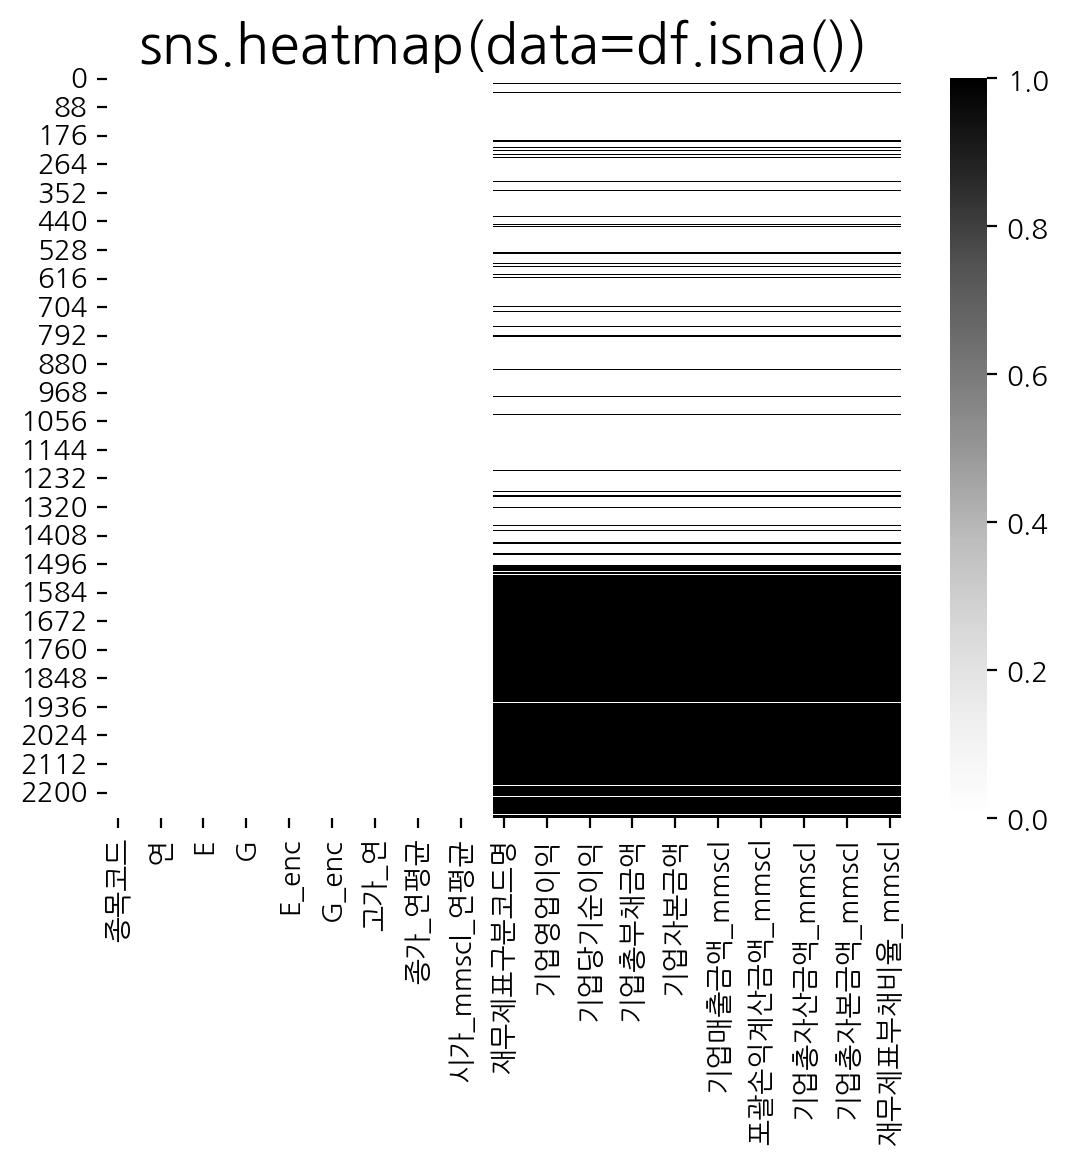



┌▣ df.isna().mean() ---- ---- ---- ----


0
종목코드            0.000000
종목명             0.000000
연               0.000000
ESG종합           0.000000
E               0.000000
S               0.000000
G               0.000000
ESG종합_enc       0.000000
E_enc           0.000000
S_enc           0.000000
G_enc           0.000000
시가_연평균          0.000000
고가_연            0.000000
저가_연            0.000000
종가_연평균          0.000000
거래량             0.000000
시가_mmscl_연평균    0.000000
종가_mmscl_연평균    0.000000
재무제표구분코드명       0.385426
기업매출금액          0.385426
기업영업이익          0.385426
포괄손익계산금액        0.385426
기업당기순이익         0.385426
기업총자산금액         0.385426
기업총부채금액         0.385426
기업총자본금액         0.385426
기업자본금액          0.385426
재무제표부채비율        0.385426
기업매출금액_mmscl    0.385426
기업영업이익_mmscl    0.385426
포괄손익계산금액_mmscl  0.385426
기업당기순이익_mmscl   0.385426
기업총자산금액_mmscl   0.385426
기업총부채금액_mmscl   0.385426
기업총자본금액_mmscl   0.385426
기업자본금액_mmscl    0.385426
재무제표부채비율_mmscl  0.385426

In [5]:
m.Summary_df(df)

## corr

ESG종합_enc   E_enc  S_enc   G_enc
연                  0.0371 -0.0532 0.1307  0.1440
ESG종합_enc          1.0000  0.6342 0.8311  0.6902
E_enc              0.6342  1.0000 0.4199  0.2561
S_enc              0.8311  0.4199 1.0000  0.6275
G_enc              0.6902  0.2561 0.6275  1.0000
시가_연평균             0.0952 -0.0693 0.1459  0.0945
고가_연               0.0844 -0.0748 0.1343  0.0849
저가_연               0.0989 -0.0610 0.1473  0.0974
종가_연평균             0.0949 -0.0697 0.1459  0.0943
거래량                0.1789  0.1521 0.1358  0.1478
시가_mmscl_연평균       0.0599  0.0394 0.0879  0.0557
종가_mmscl_연평균       0.0860  0.0594 0.1063  0.0632
기업매출금액             0.3556  0.1928 0.3246  0.3633
기업영업이익             0.2093  0.1095 0.1927  0.1957
포괄손익계산금액           0.2121  0.1137 0.1937  0.1897
기업당기순이익            0.2051  0.1086 0.1925  0.1841
기업총자산금액            0.3547  0.2028 0.3083  0.3684
기업총부채금액            0.3418  0.2086 0.2916  0.3763
기업총자본금액            0.2981  0.1606 0.2630  0.2943
기업자본금액             0.2607  0.1621 0.2288  0.2623
재무제표부채비율           0.0679 -0.0315 0.0317  0.1634
기업매출금액_mmscl       0.0283  0.0363 0.0379  0.0110
기업영업이익_mmscl       0.0103  0.0312 0.0339  0.0213
포괄손익계산금액_mmscl     0.0084  0.0332 0.0243  0.0111
기업당기순이익_mmscl      0.0098  0.0353 0.0276  0.0033
기업총자산금액_mmscl      0.0116  0.0209 0.0431 -0.0253
기업총부채금액_mmscl      0.0331 -0.0042 0.0374  0.0235
기업총자본금액_mmscl     -0.0318  0.0104 0.0209 -0.0409
기업자본금액_mmscl       0.0641  0.0725 0.1245  0.0416
재무제표부채비율_mmscl     0.0313 -0.0098 0.0108  0.0332

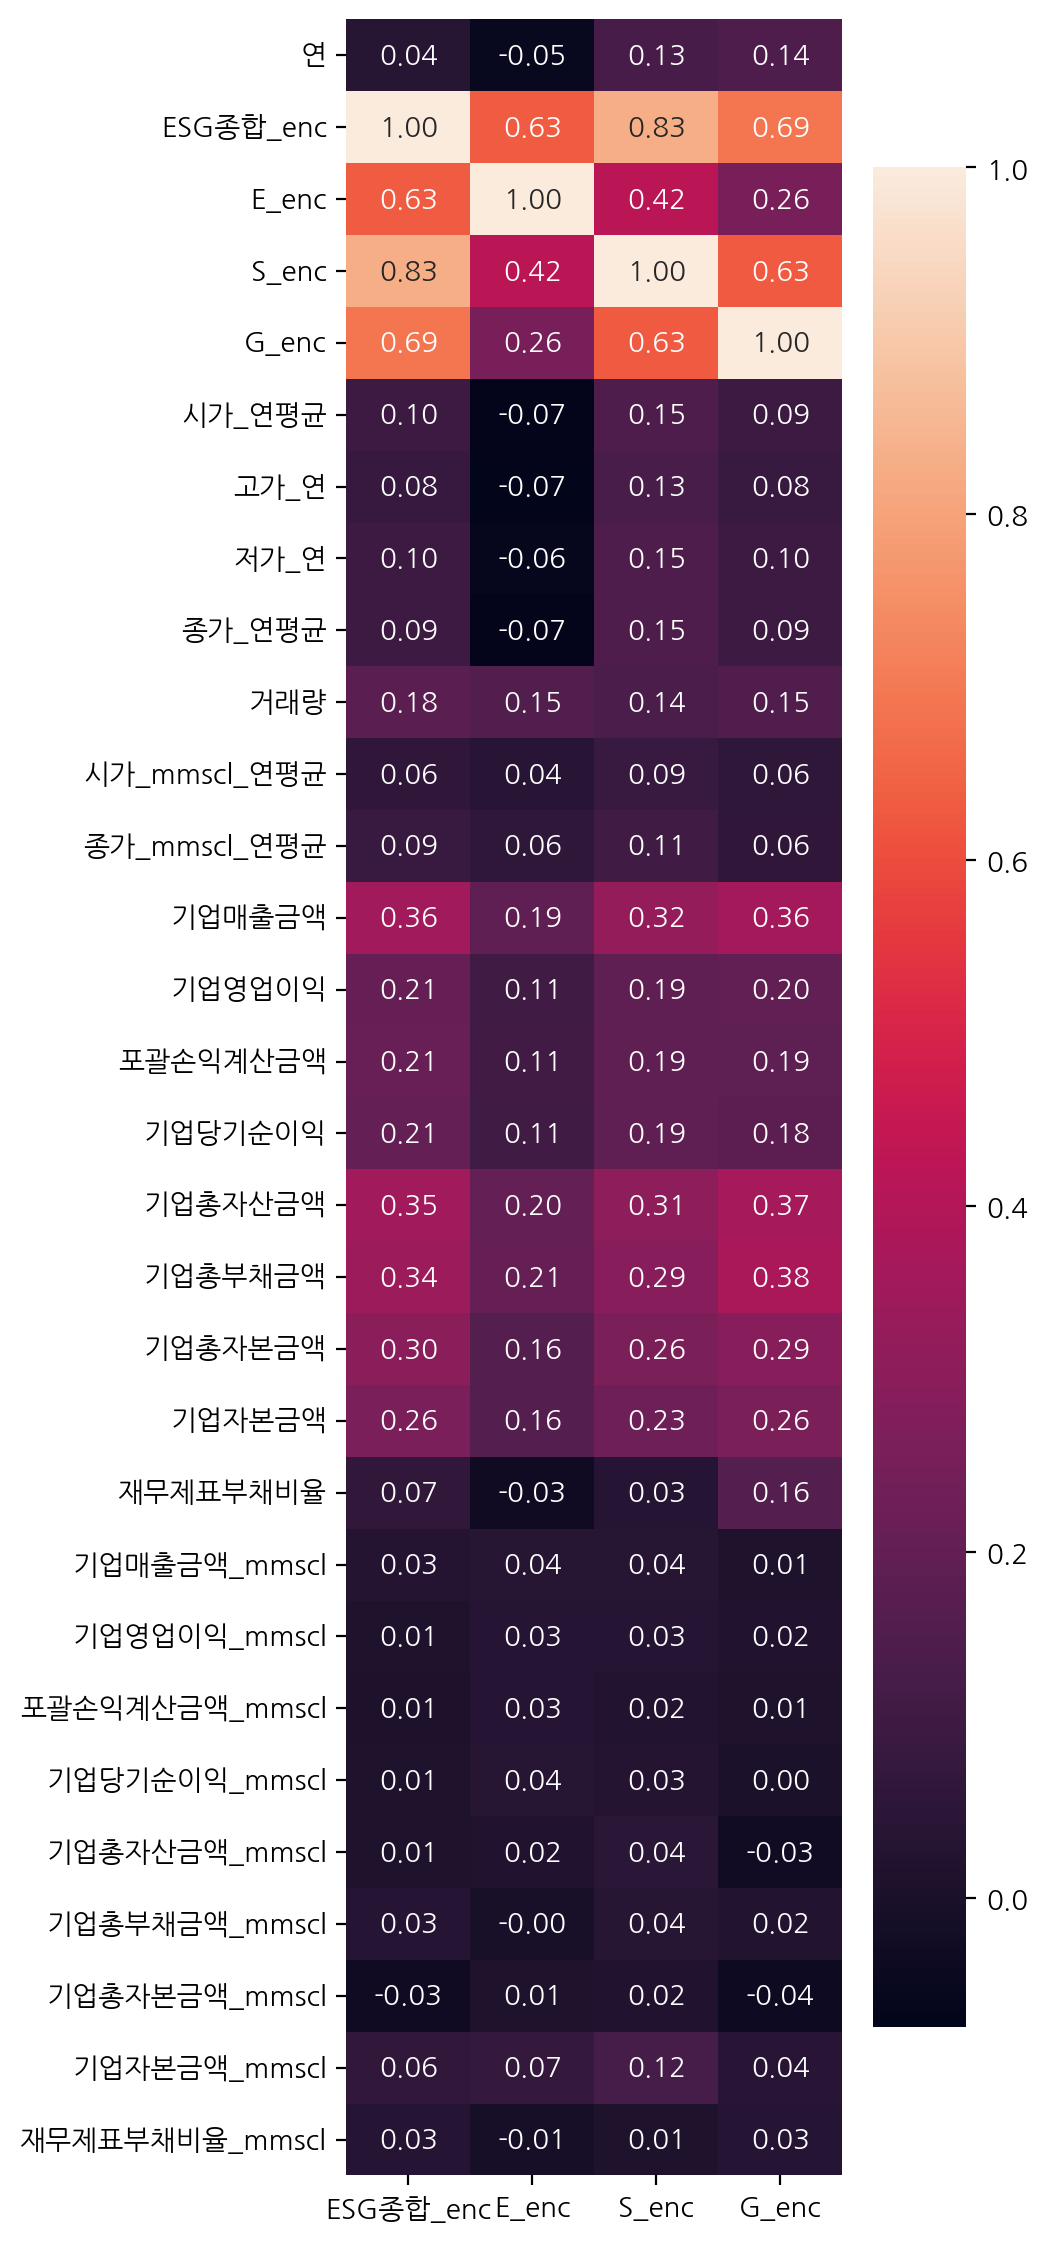

In [64]:
df_corr = df.copy()

egs_enc = ["ESG종합_enc", "E_enc", "S_enc", "G_enc"]
for i in egs_enc:
    df_corr[i] = df_corr[i].astype(str).astype(int)
    
display(df_corr.corr()[egs_enc])

plt.figure(figsize=(4, 14))
sns.heatmap(df_corr.corr()[egs_enc], annot=True, fmt=".2f", annot_kws={"size": 10}, )
plt.show()

## 종목수

In [65]:
list_esg = ['ESG종합', 'E', 'S', 'G']

for i in list_esg:
    display(df.pivot_table("종목코드", ["연"], [i], aggfunc='count').fillna(0))

ESG종합  S  A+   A  B+    B  C  D   N
연                                  
2011   0   7  28  27  101  0  0  19
2012   0   4  24  42  128  0  0   1
2013   0   5  18  54  122  0  0   0
2014   0   2  27  48  121  0  0   0
2015   0   1  31  81  247  0  0   0
2016   0   8  33  96  238  0  0   0
2017   0   7  39  94  240  0  0   0
2018   0  12  47  98  221  0  0   7

E     S  A+   A   B+    B    C   D  N
연                                    
2011  0   6  19   48   84   25   0  0
2012  0   6  14   59  100   20   0  0
2013  0   4  16   56   86   34   3  0
2014  0   7  18   57   81   34   1  0
2015  0   4  31   73  131  112   9  0
2016  0  19  19   70  158   92  17  0
2017  1   4  34  110  156   59  16  0
2018  0   9  27  123  149   65  12  0

S     S  A+   A   B+    B  C  D   N
연                                  
2011  0   7  28   23  105  0  0  19
2012  0  10  28   37  124  0  0   0
2013  0   8  28   43  120  0  0   0
2014  0   3  37   36  122  0  0   0
2015  0   7  37   87  229  0  0   0
2016  0  32  25  119  199  0  0   0
2017  0  35  46   90  209  0  0   0
2018  0  48  47  115  168  0  0   7

G     S  A+   A   B+    B  C  D   N
연                                  
2011  0   7  20   24   70  0  0  61
2012  0   8  18   60  112  0  0   1
2013  0   5  21   64  109  0  0   0
2014  0   6  27   57  108  0  0   0
2015  0   7  54  108  191  0  0   0
2016  0   3  72   94  206  0  0   0
2017  0   3  65  108  204  0  0   0
2018  0   7  59  111  201  0  0   7

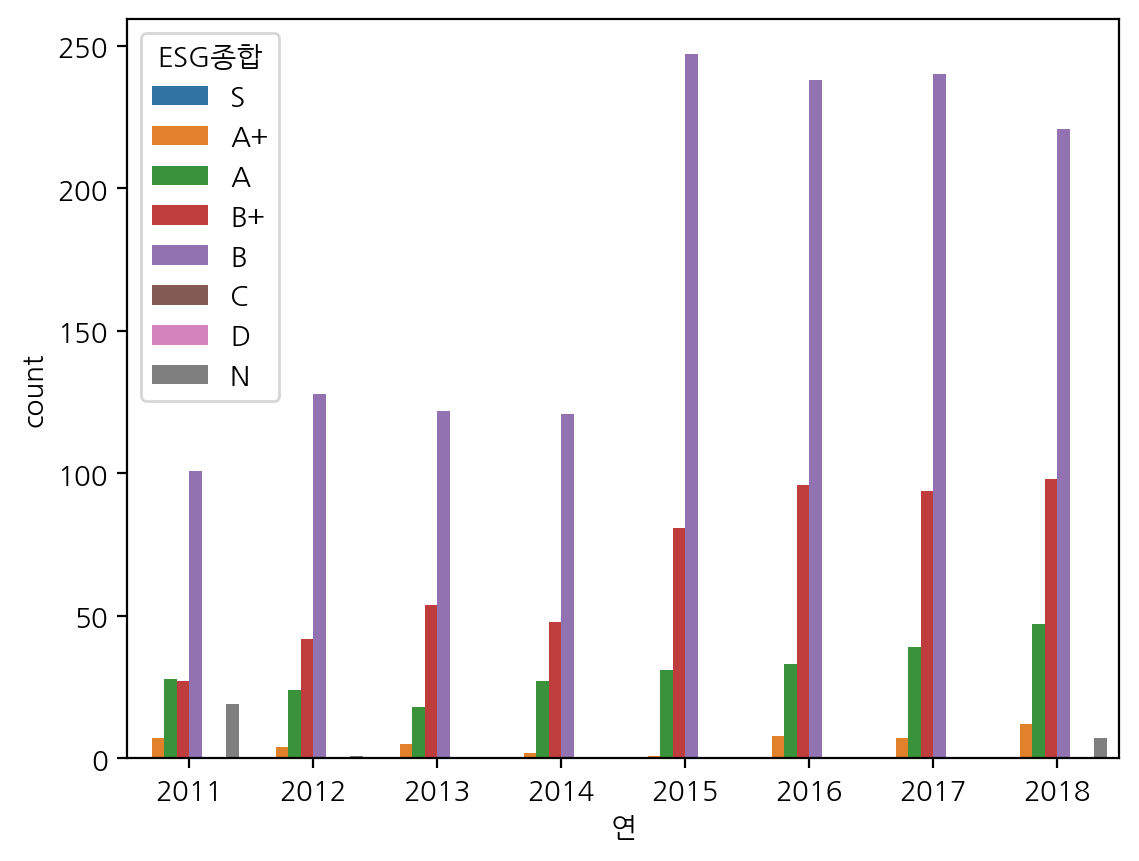

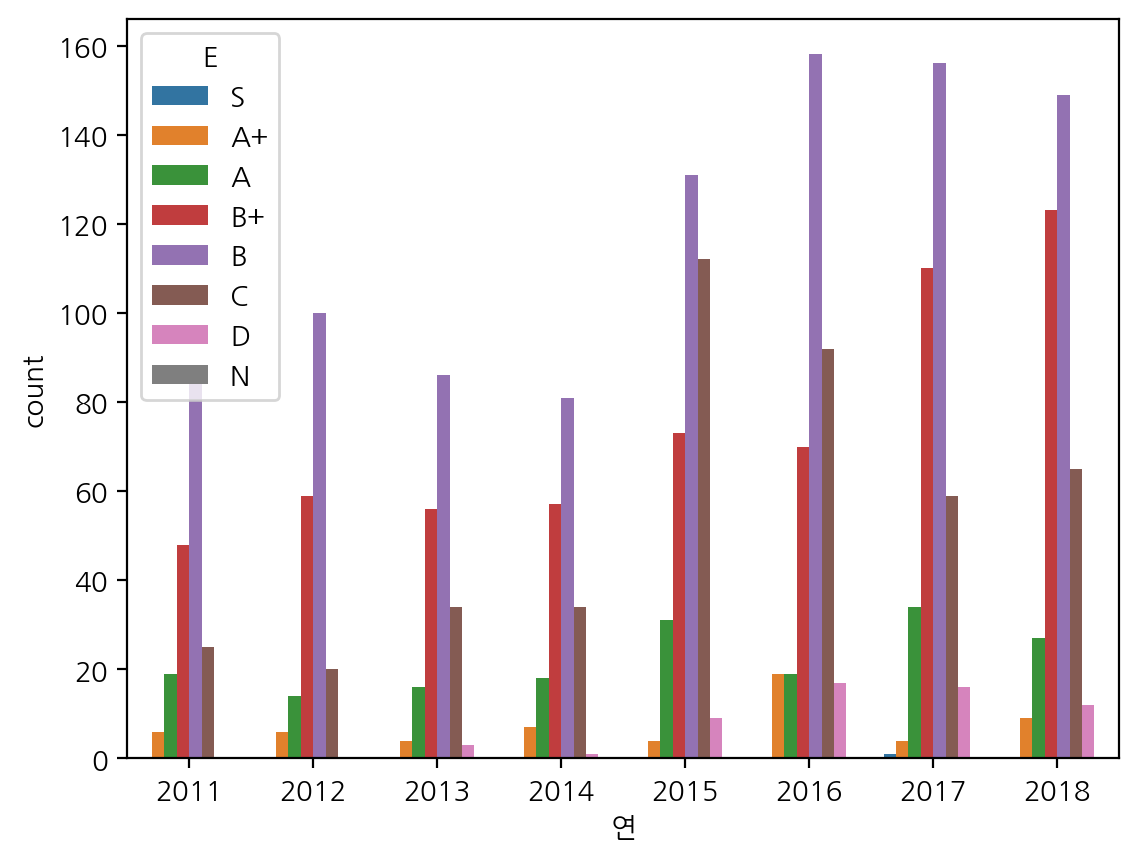

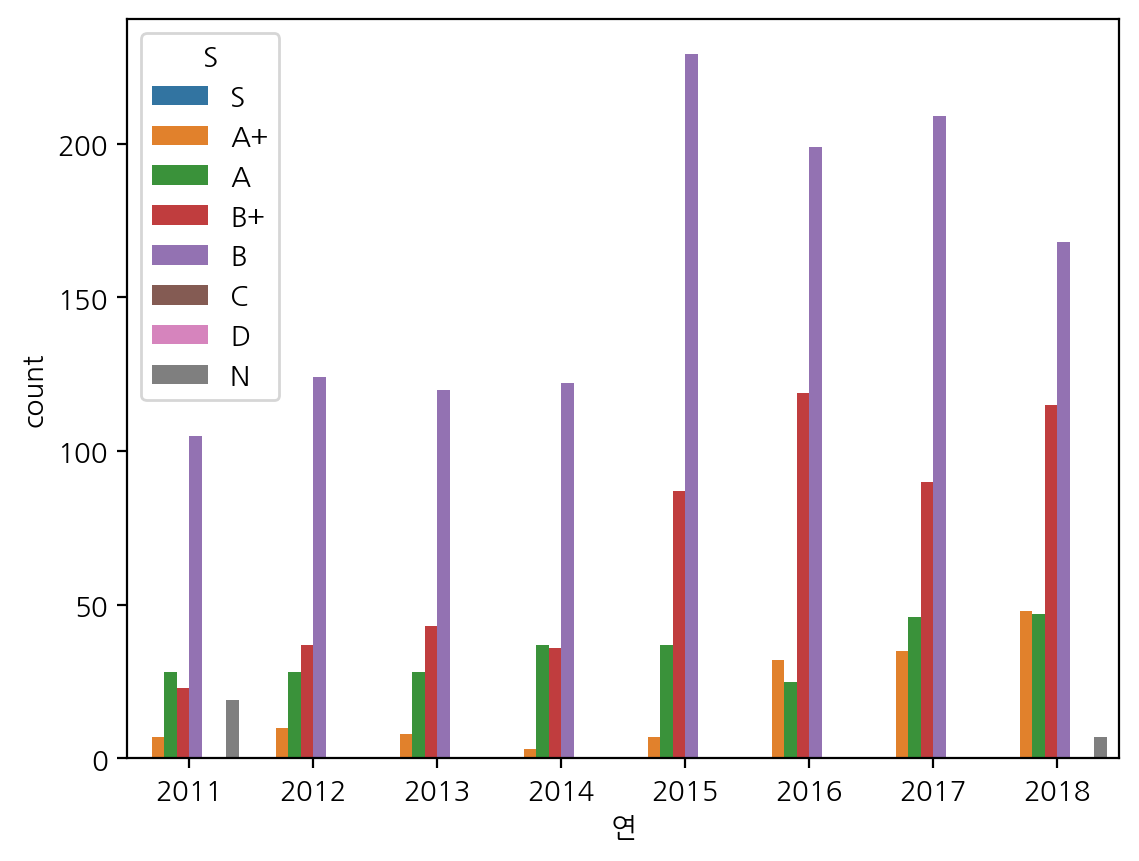

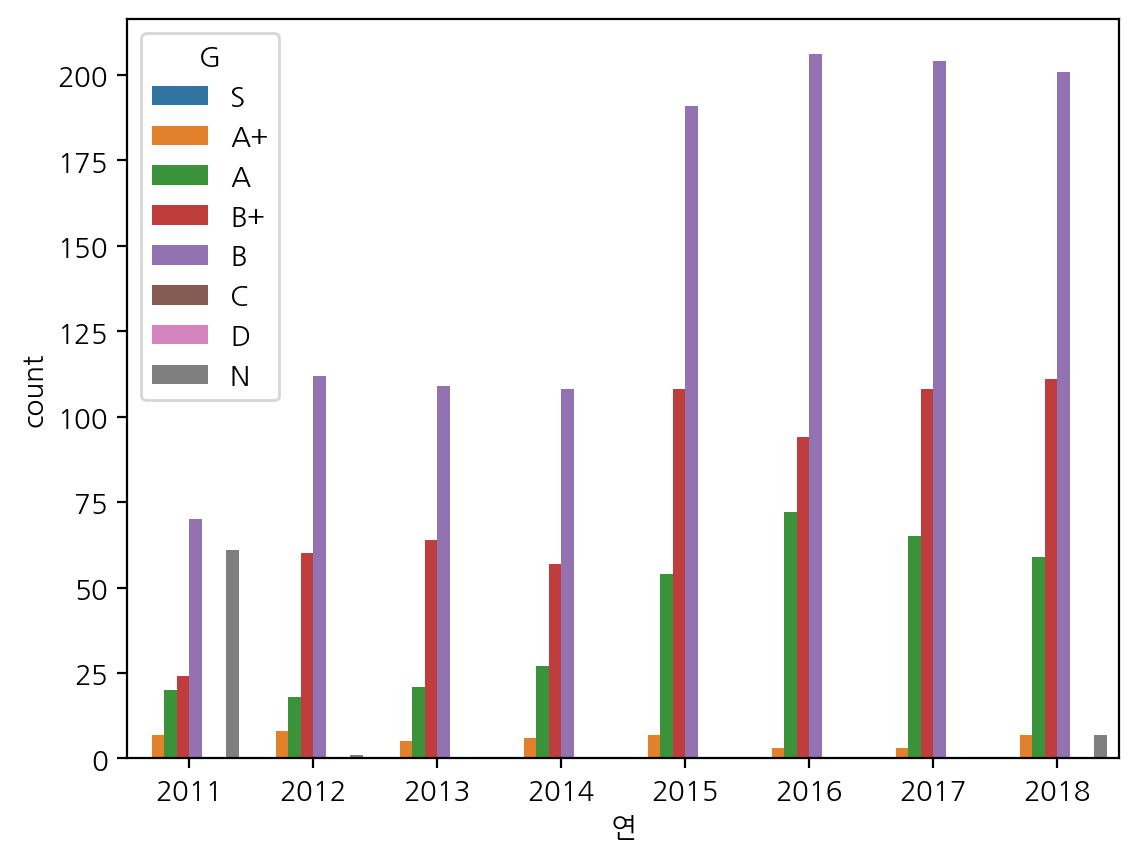

In [7]:
for i in list_esg:
    sns.countplot(df, x="연", hue=i)
    plt.show()

## 종가_연평균


ESG종합


종가_연평균                                               
ESG종합          A+           A          B+          B           N
연                                                               
2011  100427.2961 281719.7077 121570.3048 57434.2322 113604.1902
2012   68224.5615 124201.5523 154878.3405 57171.7045  24503.0242
2013   71139.8113 113117.2220  85997.2156 79918.8737         NaN
2014   57474.4898 111504.3280  81980.2560 73625.4875         NaN
2015   42013.9113 134050.1029 102426.5832 91712.2868         NaN
2016   78103.3791 167430.3335  72241.6684 91601.4525         NaN
2017  136250.4997 170796.1739  69938.4580 87607.5782         NaN
2018  113468.2008 167116.7153  97250.2819 77388.2810  29730.9075

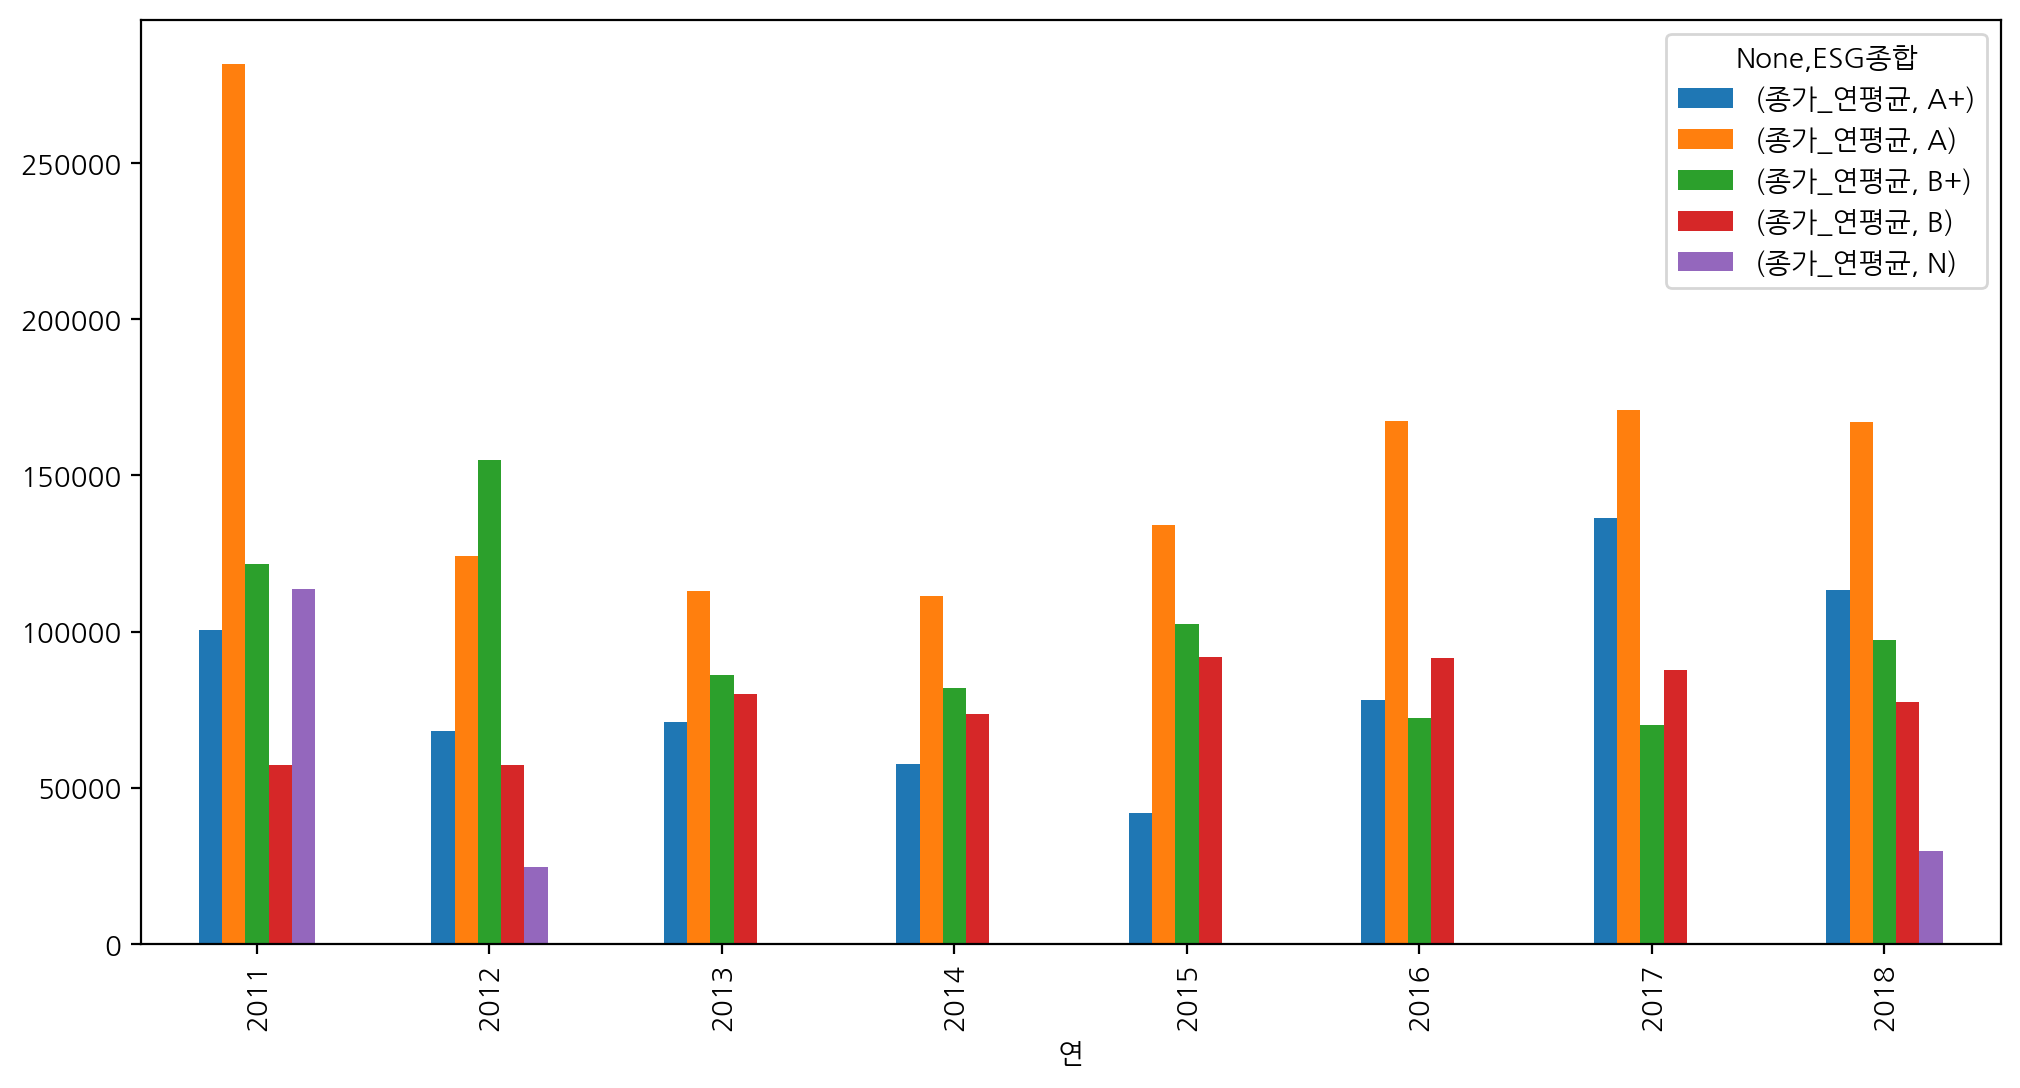

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

E


종가_연평균                                                              \
E             S          A+           A          B+           B           C   
연                                                                             
2011        NaN  73398.6075  79050.8646 135738.9268 116578.1309  63299.5448   
2012        NaN  43659.3918  91725.8859  90579.3615  77790.3012 121588.7903   
2013        NaN  55583.5698  58168.7126  88150.0400  62847.9912 122872.2098   
2014        NaN  37136.2962  81759.7166  93552.4150  44605.1243 155422.8742   
2015        NaN  33128.8962  78904.7570  90351.4523  68219.2221 148614.7834   
2016        NaN  68494.7178  69268.7390 115161.8192  56067.4776  84008.3019   
2017 49094.2387 183698.7654  73510.2787  94526.4655  70197.0994 144772.6312   
2018        NaN 113862.3962 100131.7353  95275.2924  72916.9908 135059.1293   

                  
E              D  
연                 
2011         NaN  
2012         NaN  
2013 371247.6626  
2014   7792.6939  
2015  43473.5856  
2016 448242.0964  
2017 127584.7104  
2018  80575.3074

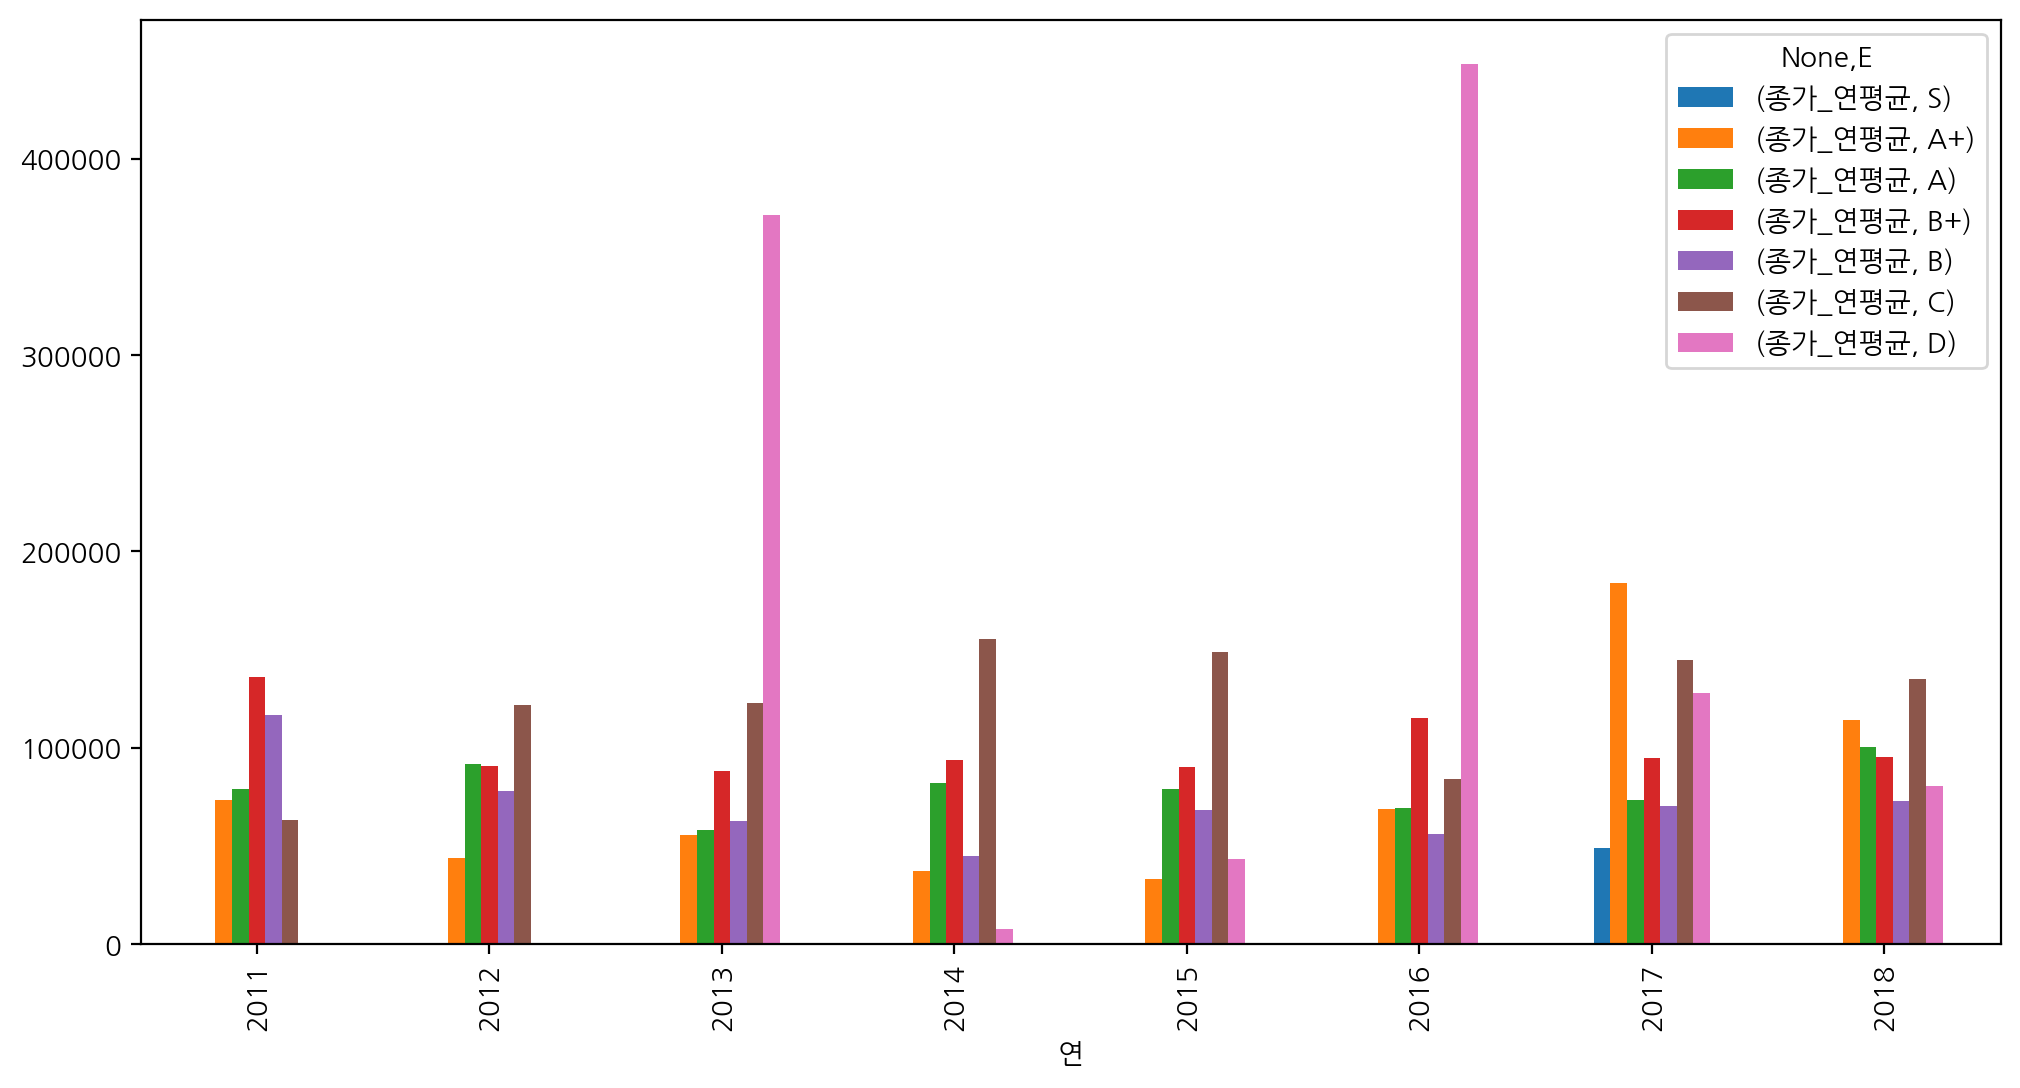

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

S


종가_연평균                                               
S             A+           A          B+          B           N
연                                                              
2011 100427.2961 281719.7077 136825.1829 56535.9664 113604.1902
2012 161414.2948  77916.0006 154887.2888 61084.5674         NaN
2013 133160.8300  93227.1264 130993.6778 62311.5580         NaN
2014  63894.0816 109386.5426  79118.1276 72803.8131         NaN
2015 320431.7500 107535.9202  89662.1086 92247.1635         NaN
2016 172626.3694 107645.4898 115529.8344 64940.4147         NaN
2017 193552.2069 112716.6010  97848.3806 69134.8945         NaN
2018 197308.0867 131054.4866  64959.7476 75885.2485  29730.9075

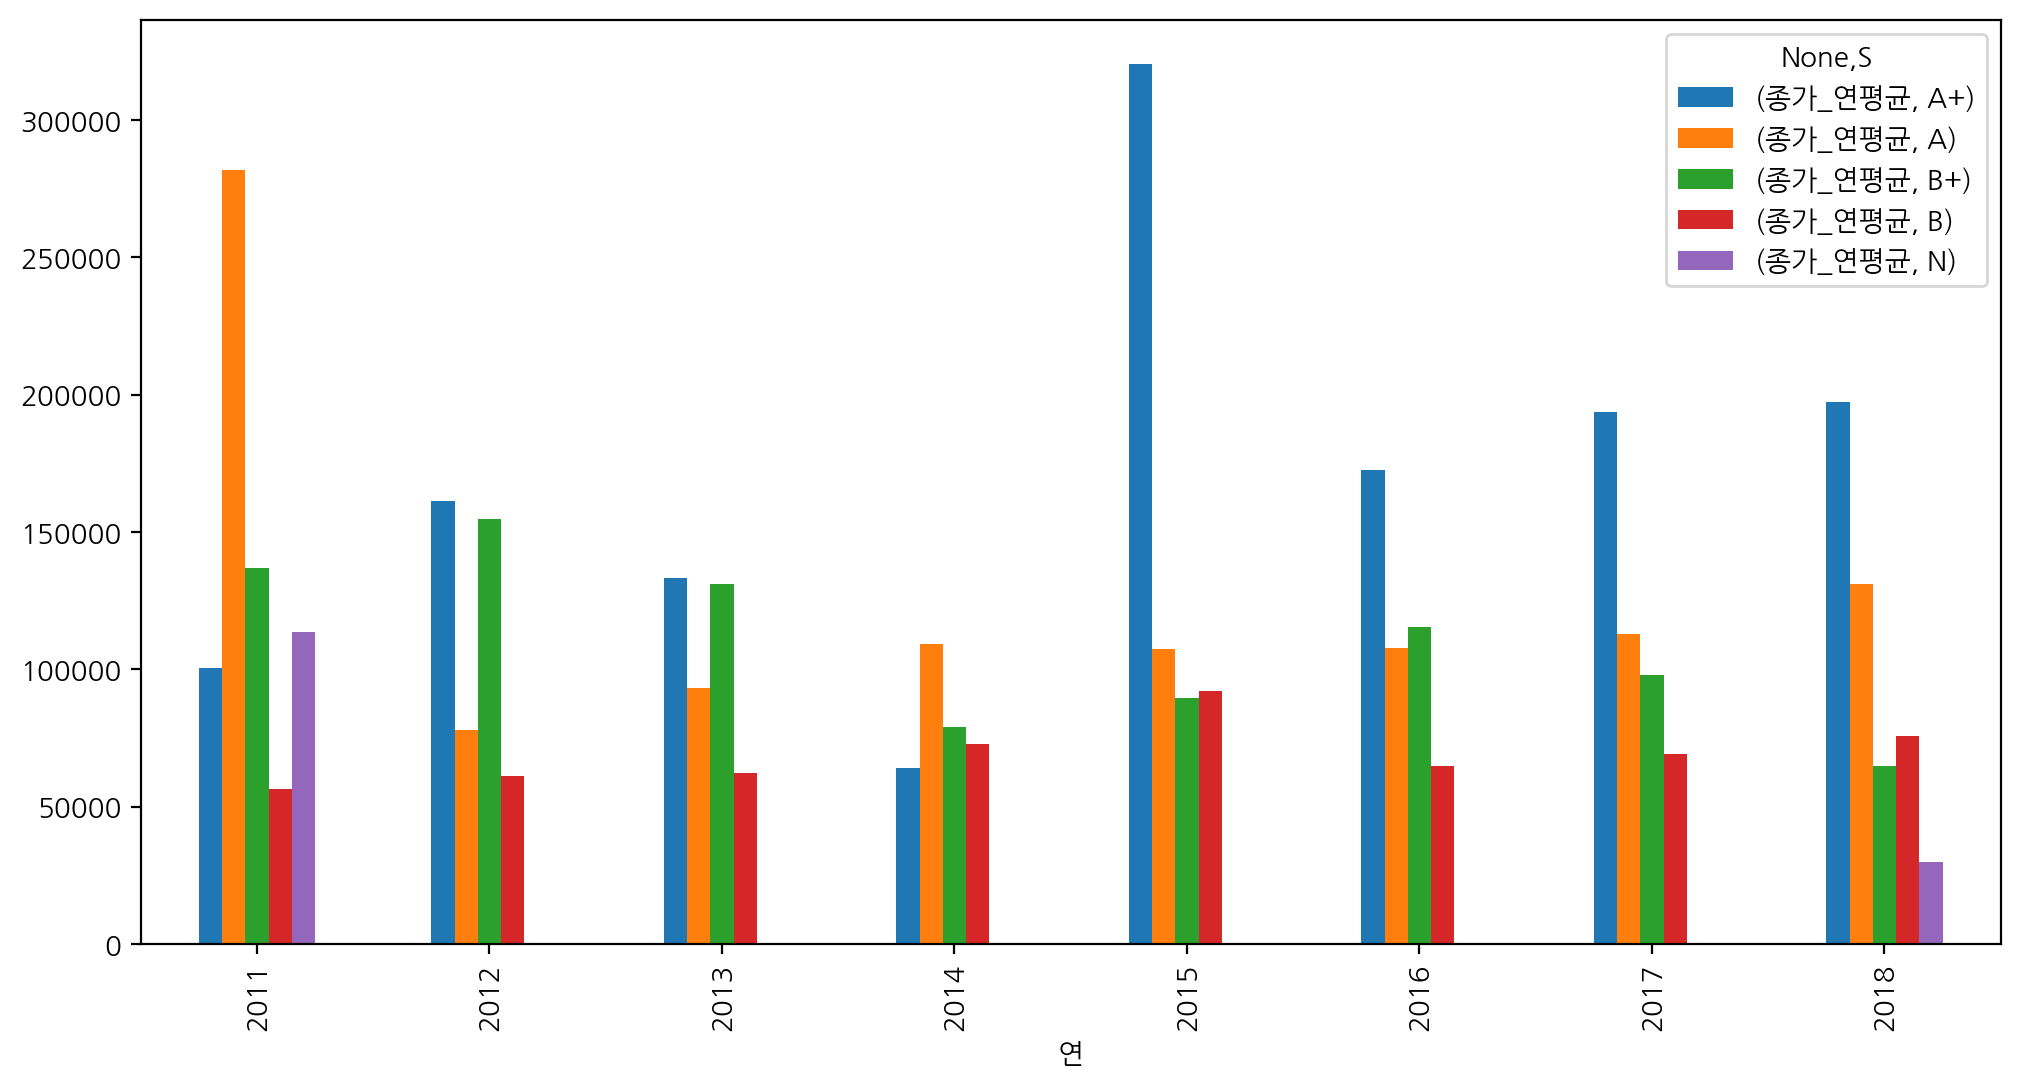

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

G


종가_연평균                                              
G             A+           A          B+          B          N
연                                                             
2011  71149.4101 163703.5629 301088.6542 76848.6713 56643.0550
2012 100307.8599 134356.2321 130416.1838 53846.0526 24503.0242
2013  93635.1555 118197.6638 136326.3578 46885.7584        NaN
2014 127753.1823 103275.6276  98233.3002 63102.2497        NaN
2015 119135.5576 115662.0445 111001.2328 84184.4122        NaN
2016  48620.2575 123129.1548  61770.9785 97421.0777        NaN
2017  72986.1454 142873.9148  78676.1555 84372.7961        NaN
2018  87415.3513 146781.1433  90858.1598 82050.7020 29730.9075

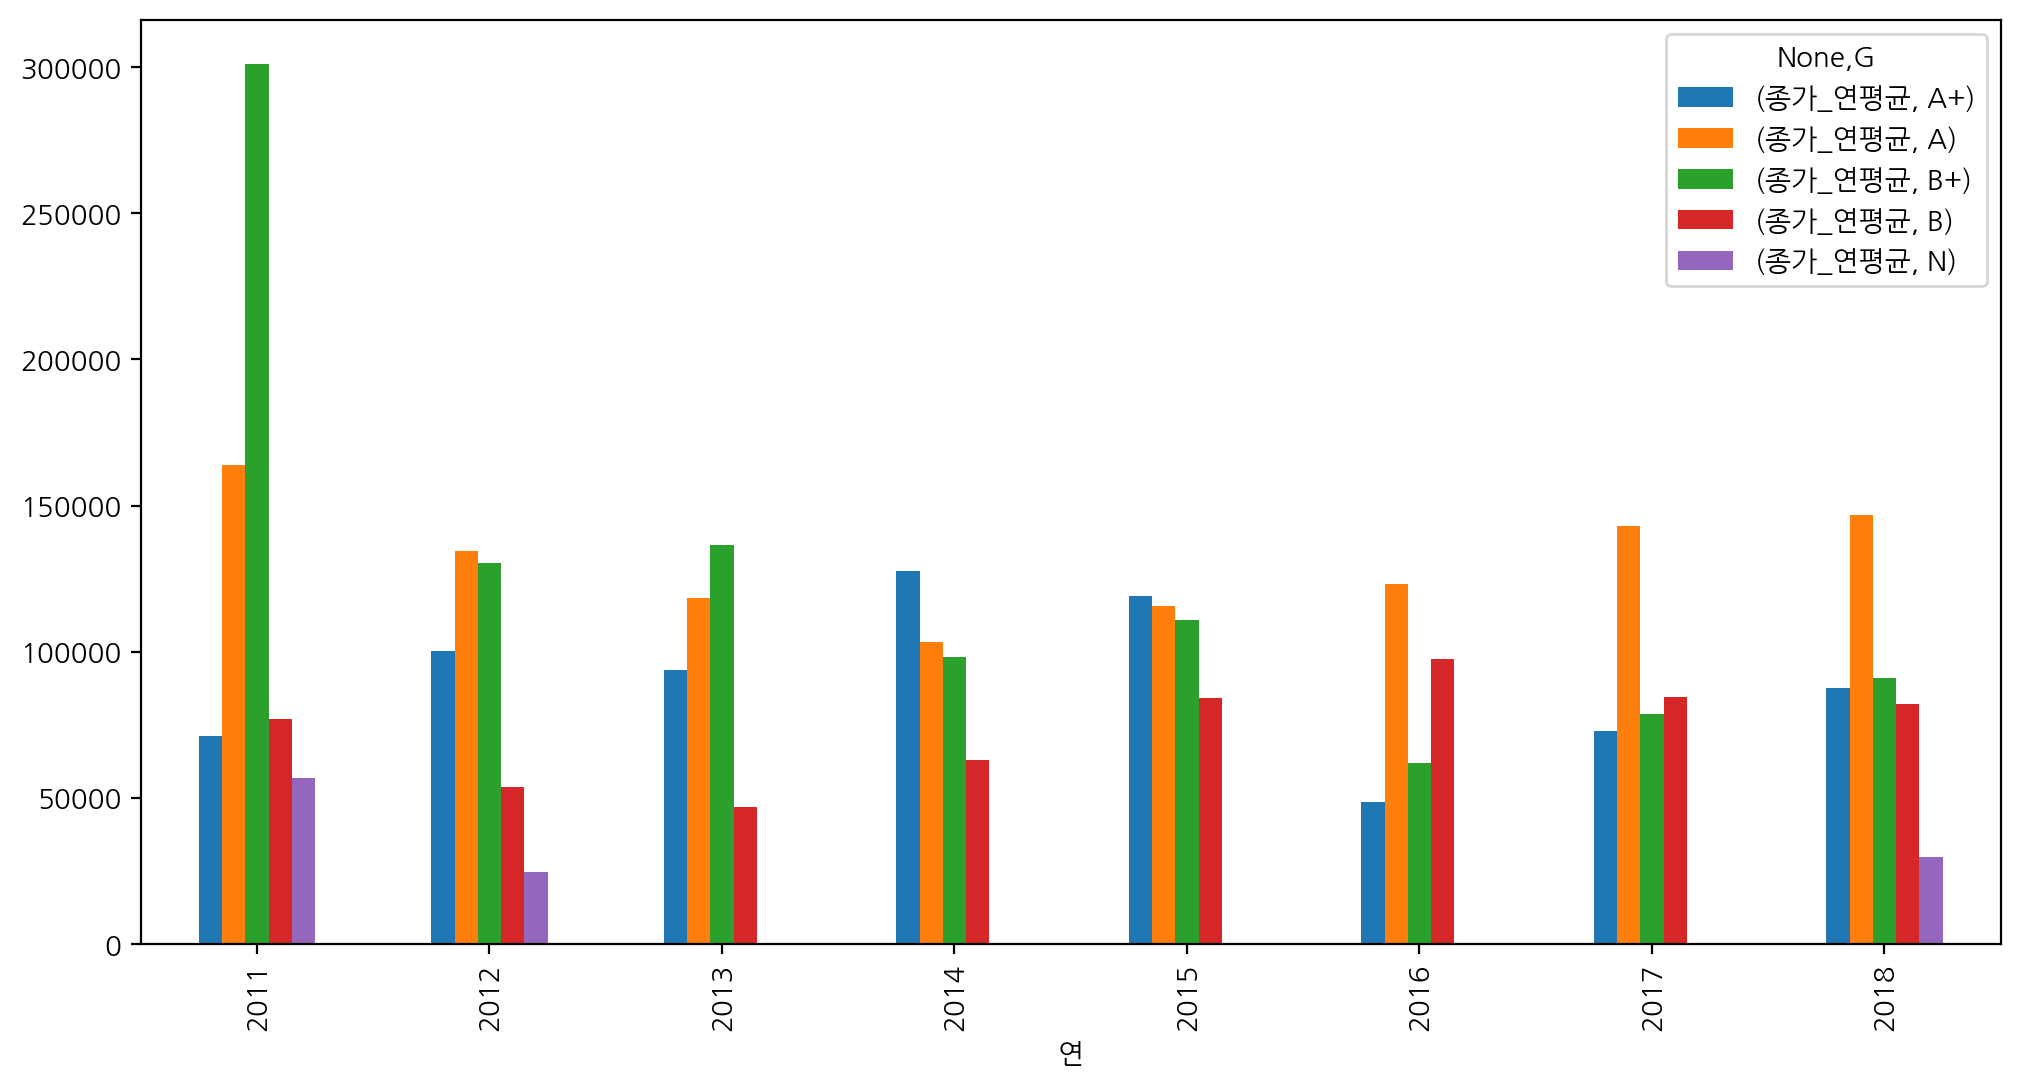

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 


In [87]:
for i in list_esg:
    print()
    print(i)

    d = df.pivot_table(["종가_연평균"], ["연"], [i], aggfunc="mean")
    display(d)

    d.plot(kind="bar", figsize=(12, 6))
    plt.show()
    print("---------- " * 8)

## 종가_mmscl_연평균


ESG종합


종가_mmscl_연평균                            
ESG종합           A+      A     B+      B      N
연                                             
2011        0.4456 0.4867 0.3643 0.2726 0.3128
2012        0.3803 0.3415 0.3218 0.2488 0.2959
2013        0.3884 0.2989 0.3381 0.3021    NaN
2014        0.1450 0.3922 0.3469 0.3502    NaN
2015        0.3928 0.3413 0.4022 0.4469    NaN
2016        0.2832 0.4560 0.3120 0.4090    NaN
2017        0.5645 0.4781 0.4005 0.3828    NaN
2018        0.5951 0.4548 0.3710 0.3590 0.2579

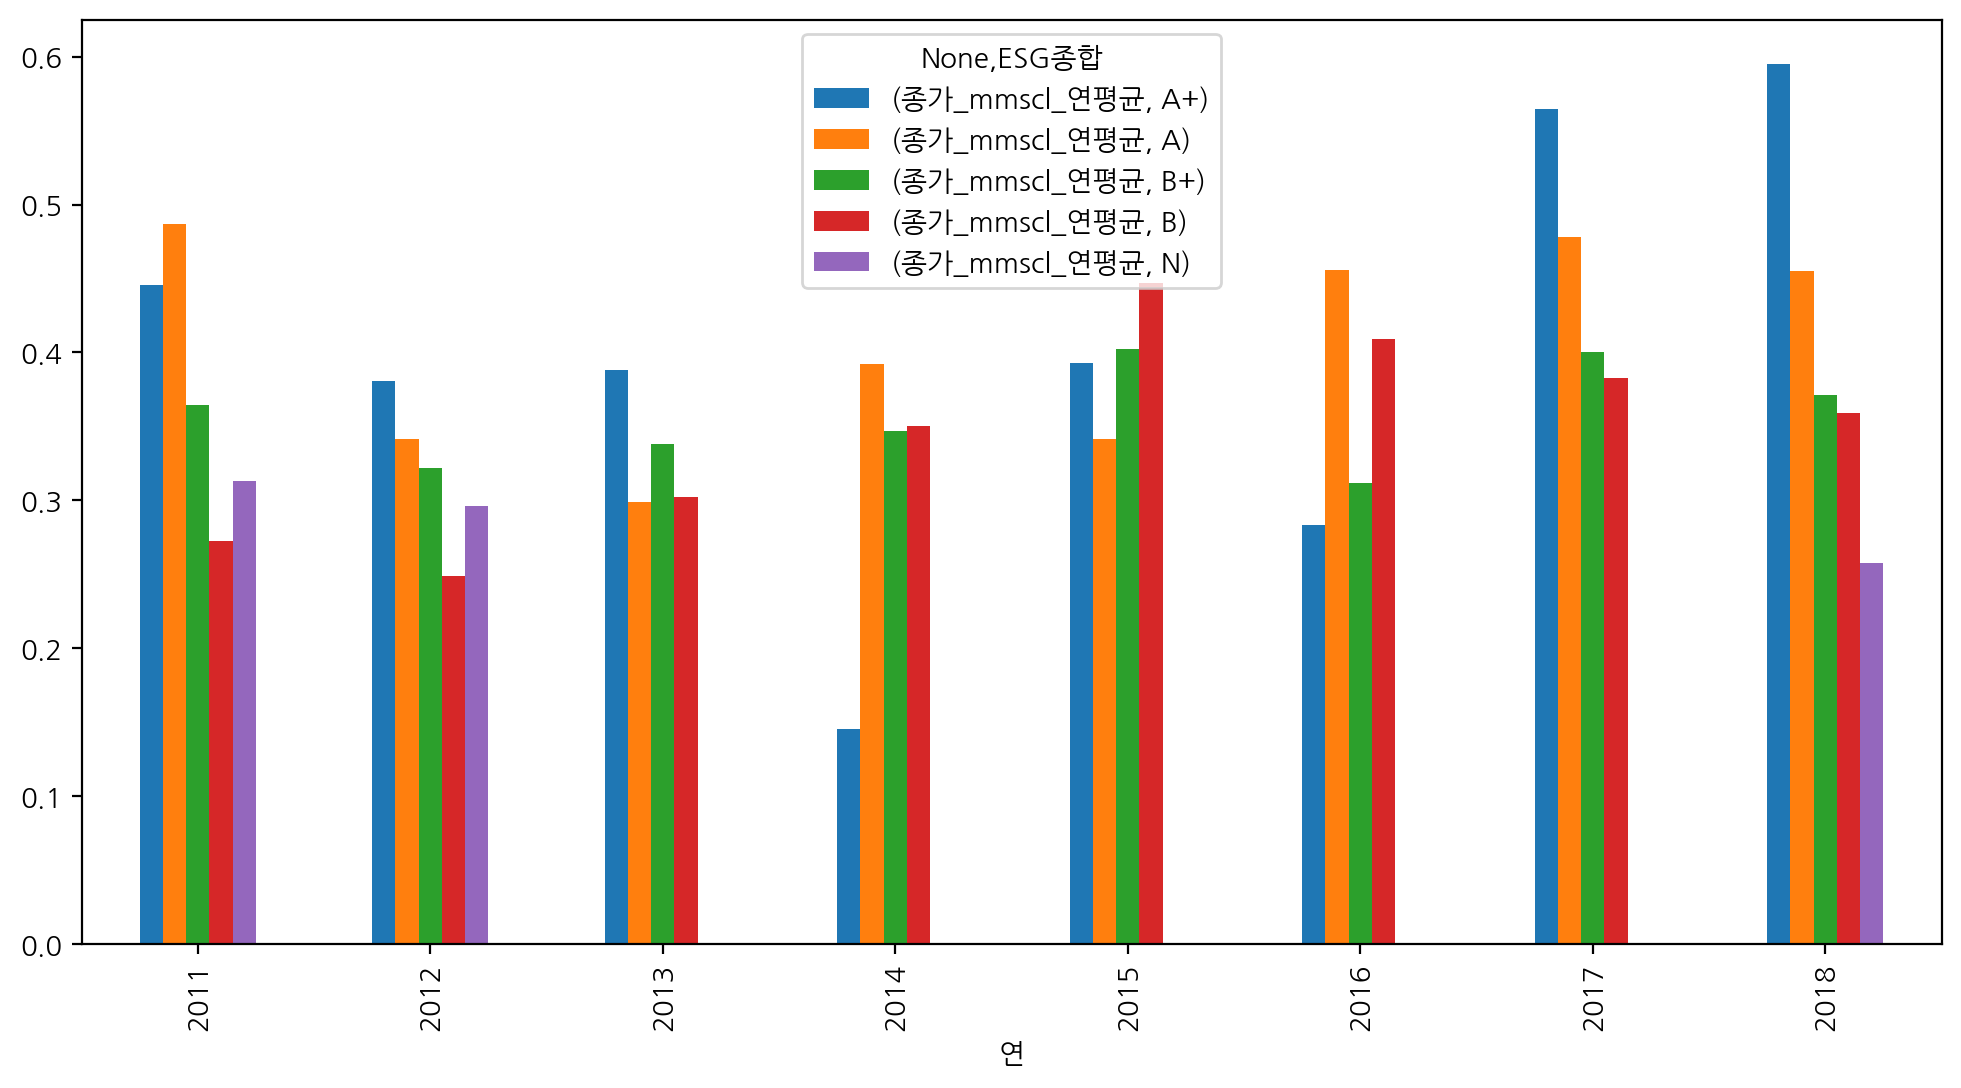

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

E


종가_mmscl_연평균                                          
E               S     A+      A     B+      B      C      D
연                                                          
2011          NaN 0.4512 0.3897 0.4189 0.2844 0.2381    NaN
2012          NaN 0.3705 0.3713 0.3320 0.2284 0.2763    NaN
2013          NaN 0.4267 0.3836 0.3053 0.3251 0.2615 0.2136
2014          NaN 0.4909 0.3711 0.3350 0.3548 0.3425 0.3113
2015          NaN 0.3978 0.4015 0.4196 0.4474 0.4191 0.4128
2016          NaN 0.3054 0.3489 0.4124 0.3804 0.3891 0.4367
2017       0.7139 0.6267 0.4851 0.3742 0.4025 0.3793 0.3792
2018          NaN 0.6871 0.4142 0.3831 0.3534 0.3714 0.3953

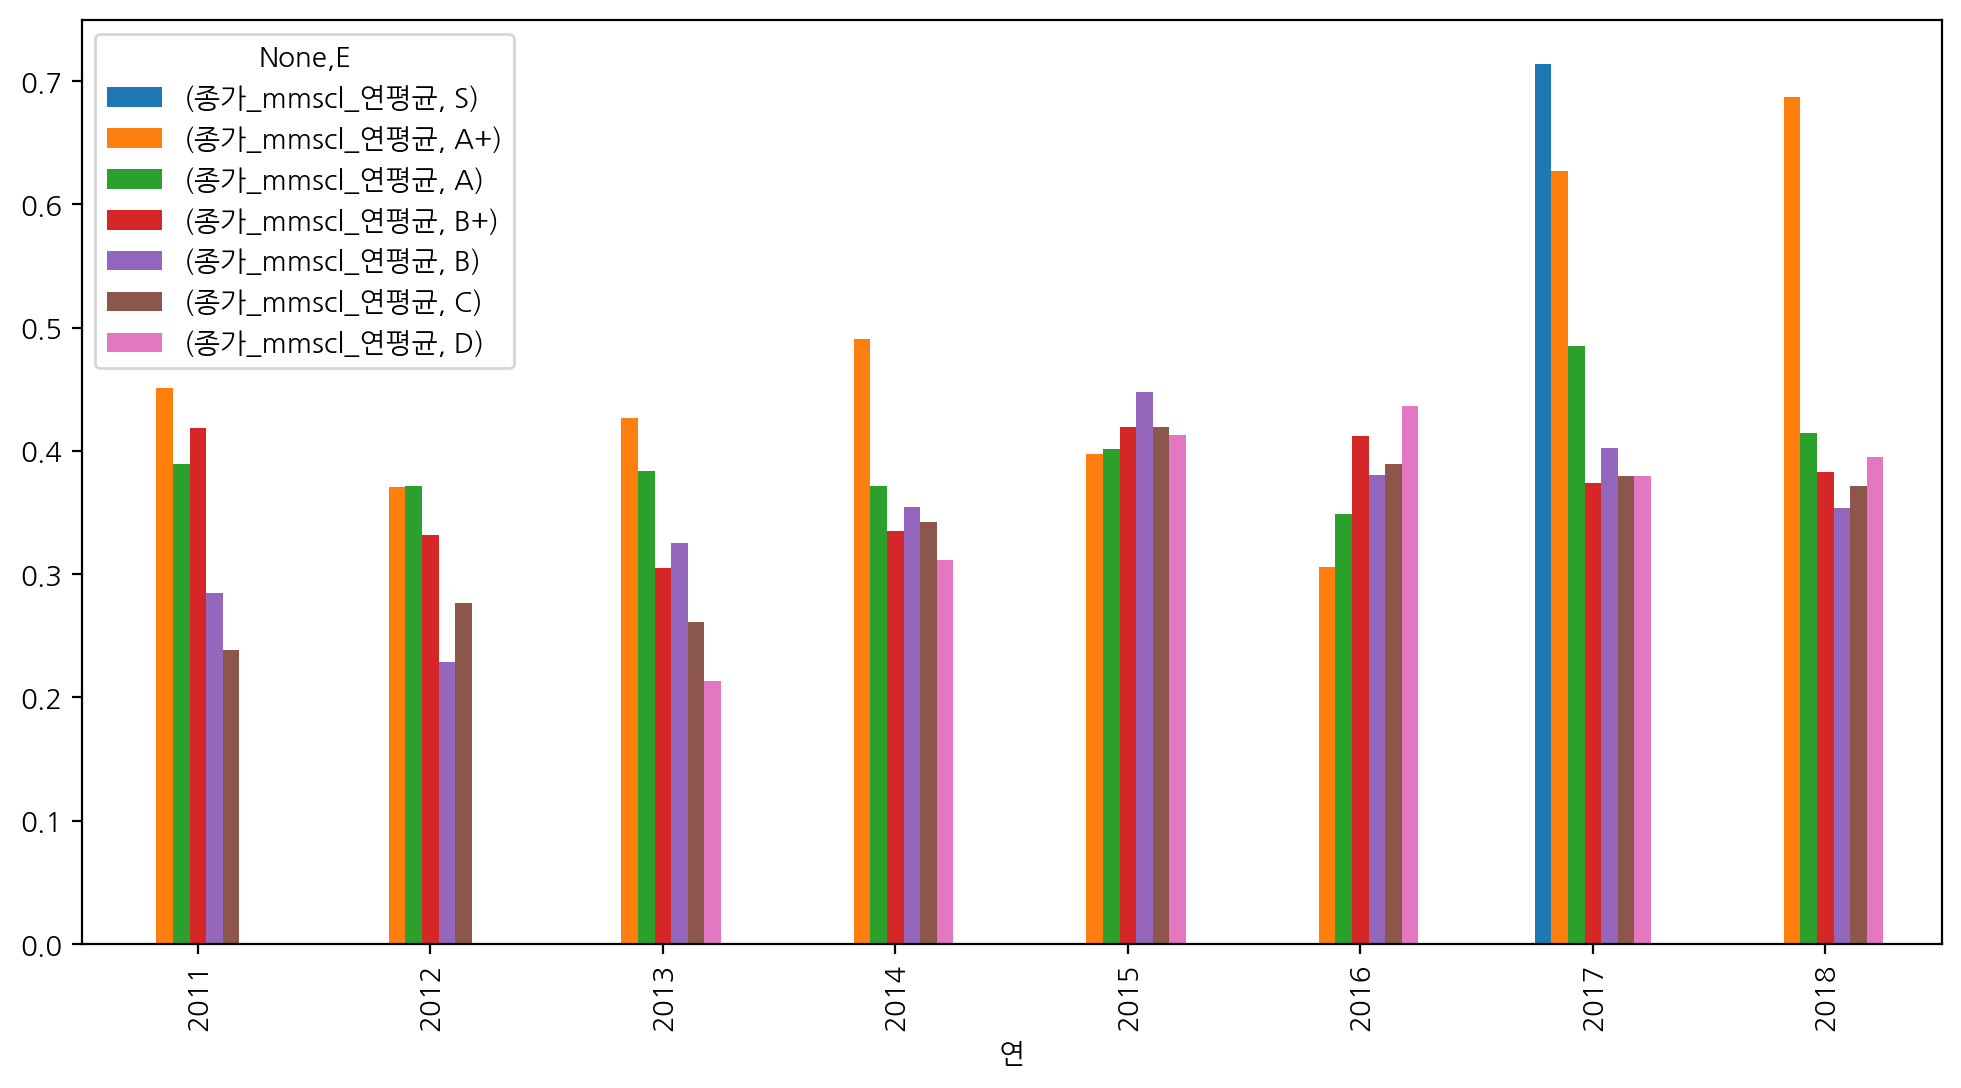

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

S


종가_mmscl_연평균                            
S              A+      A     B+      B      N
연                                            
2011       0.4456 0.4867 0.3826 0.2721 0.3128
2012       0.3713 0.3465 0.2911 0.2515    NaN
2013       0.2787 0.3504 0.3540 0.2930    NaN
2014       0.2961 0.3556 0.3959 0.3410    NaN
2015       0.3232 0.3724 0.3947 0.4522    NaN
2016       0.3728 0.3473 0.3707 0.4015    NaN
2017       0.4299 0.5330 0.3850 0.3727    NaN
2018       0.4707 0.4210 0.4040 0.3296 0.2579

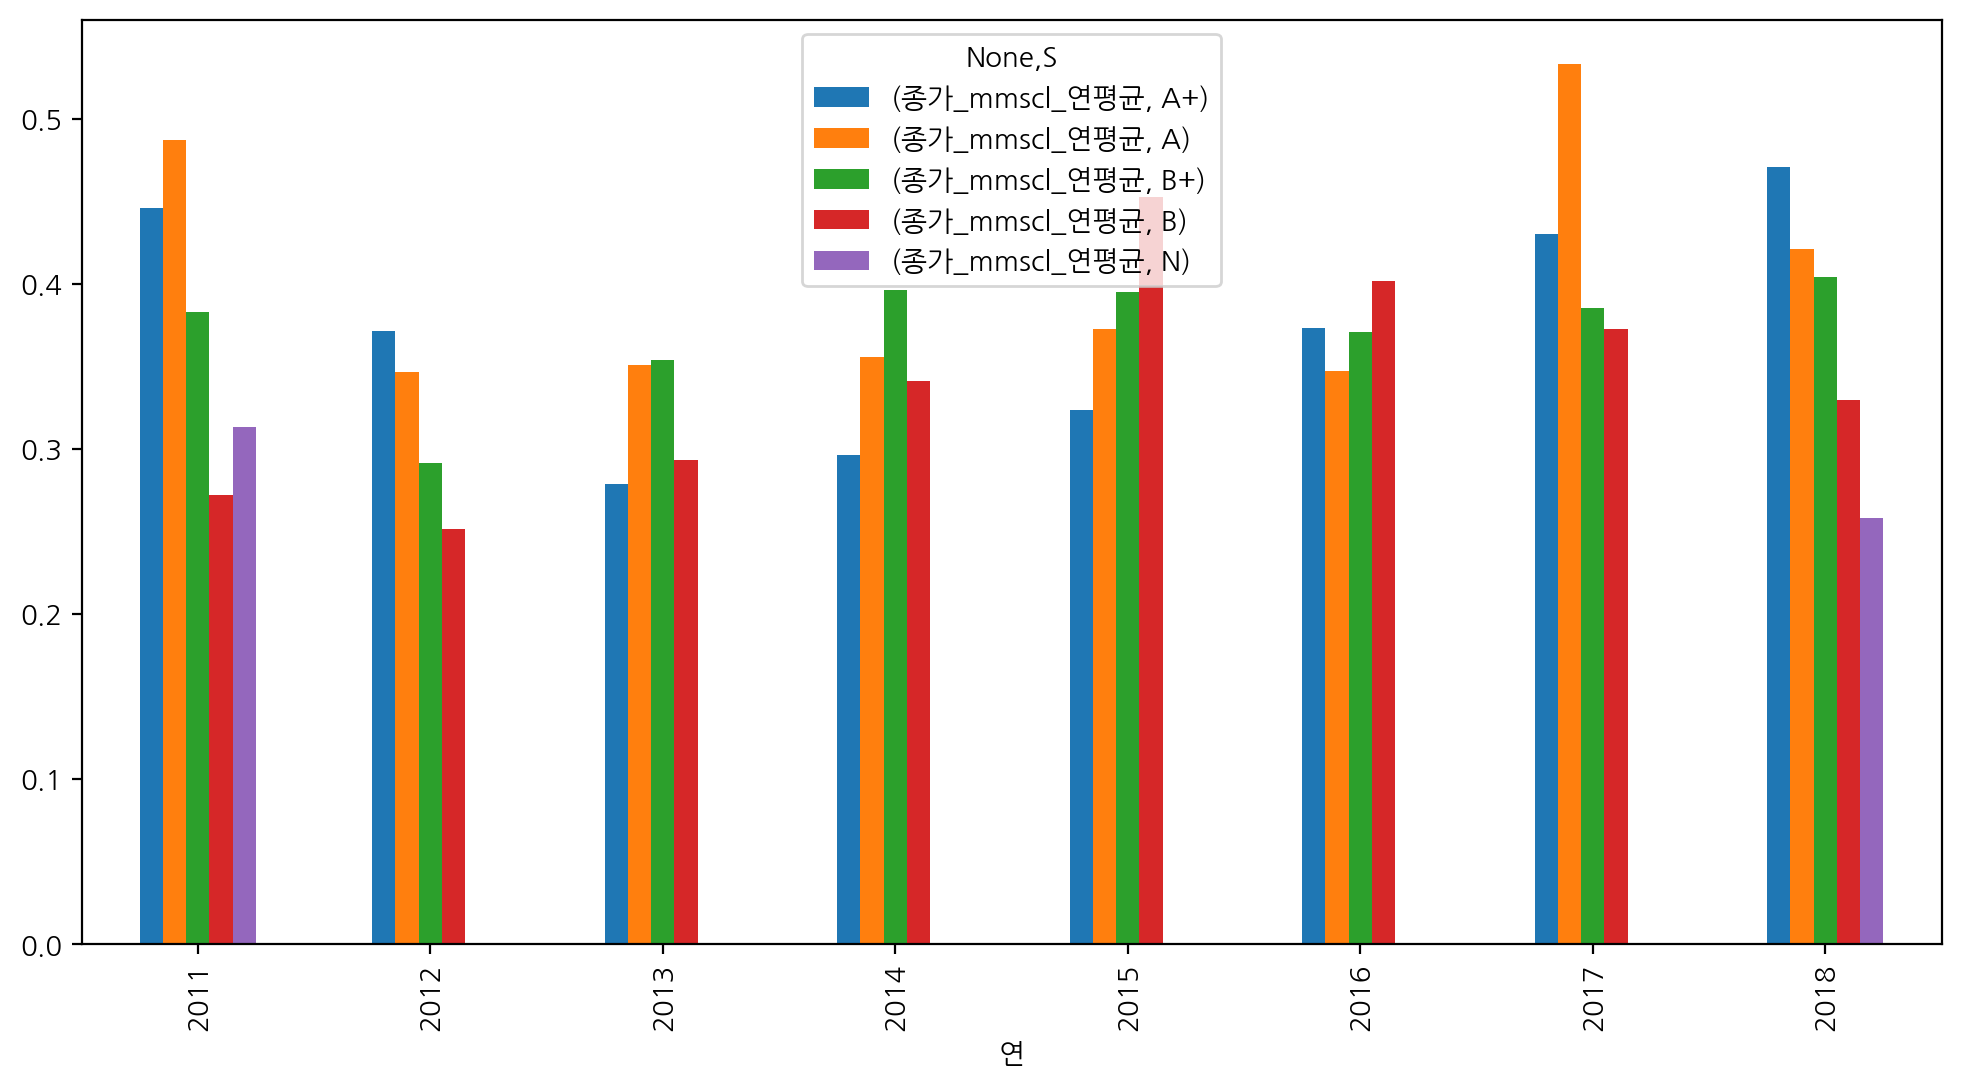

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

G


종가_mmscl_연평균                            
G              A+      A     B+      B      N
연                                            
2011       0.3648 0.4926 0.4315 0.3181 0.2464
2012       0.3989 0.3096 0.2997 0.2530 0.2959
2013       0.3992 0.3052 0.3169 0.3095    NaN
2014       0.2750 0.4081 0.3065 0.3682    NaN
2015       0.2926 0.3508 0.4131 0.4624    NaN
2016       0.1811 0.3425 0.3668 0.4123    NaN
2017       0.4814 0.4609 0.3703 0.3957    NaN
2018       0.5069 0.4393 0.3792 0.3615 0.2579

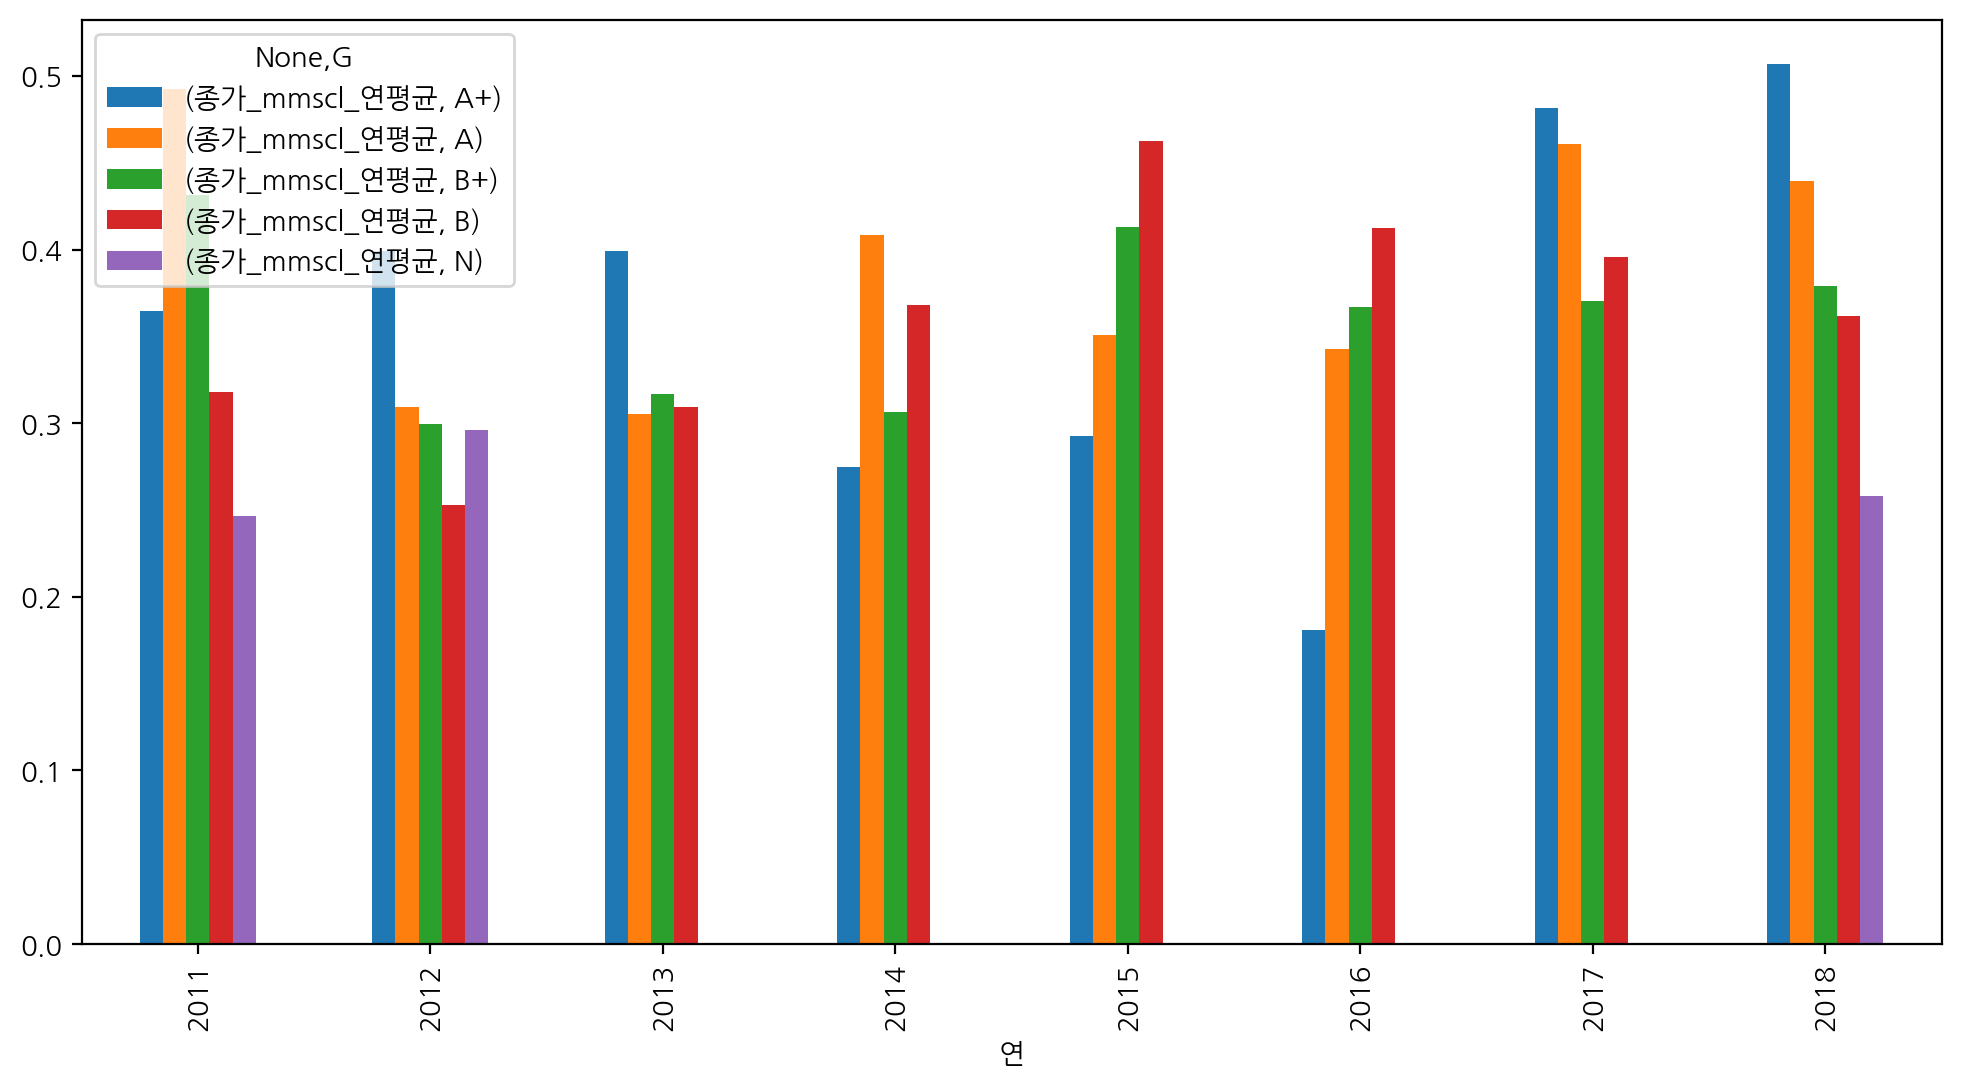

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 


In [88]:
for i in list_esg:
    print()
    print(i)

    d = df.pivot_table(["종가_mmscl_연평균"], ["연"], [i], aggfunc="mean")
    display(d)

    d.plot(kind="bar", figsize=(12, 6))
    plt.show()
    print("---------- " * 8)

## 거래량

In [ ]:
# df["거래량"].sort_values()
# df.iloc[1744]


ESG종합


거래량                                                          
ESG종합             A+              A             B+             B             N
연                                                                             
2011  -62097856.2857 120711030.3571 130458500.5185 89989870.0990 47553817.1579
2012  495233702.0000 121849188.8333  89059563.9286 61086672.3359 94587718.0000
2013  145257273.0000 160826664.0556  51182217.7407 54626442.4426           NaN
2014   97744802.5000 113621632.1111 103170565.9583 41131646.3471           NaN
2015  240308269.0000  97695849.9677 139025838.5679 71896653.5870           NaN
2016  132155846.6250  79135631.9394 113482963.3646 43907030.4202           NaN
2017  111385653.0000 187486318.3077  91264585.2447 61868059.5333           NaN
2018  138278792.9167 269286169.5106 123388223.4184 56227344.5656 42973168.4286

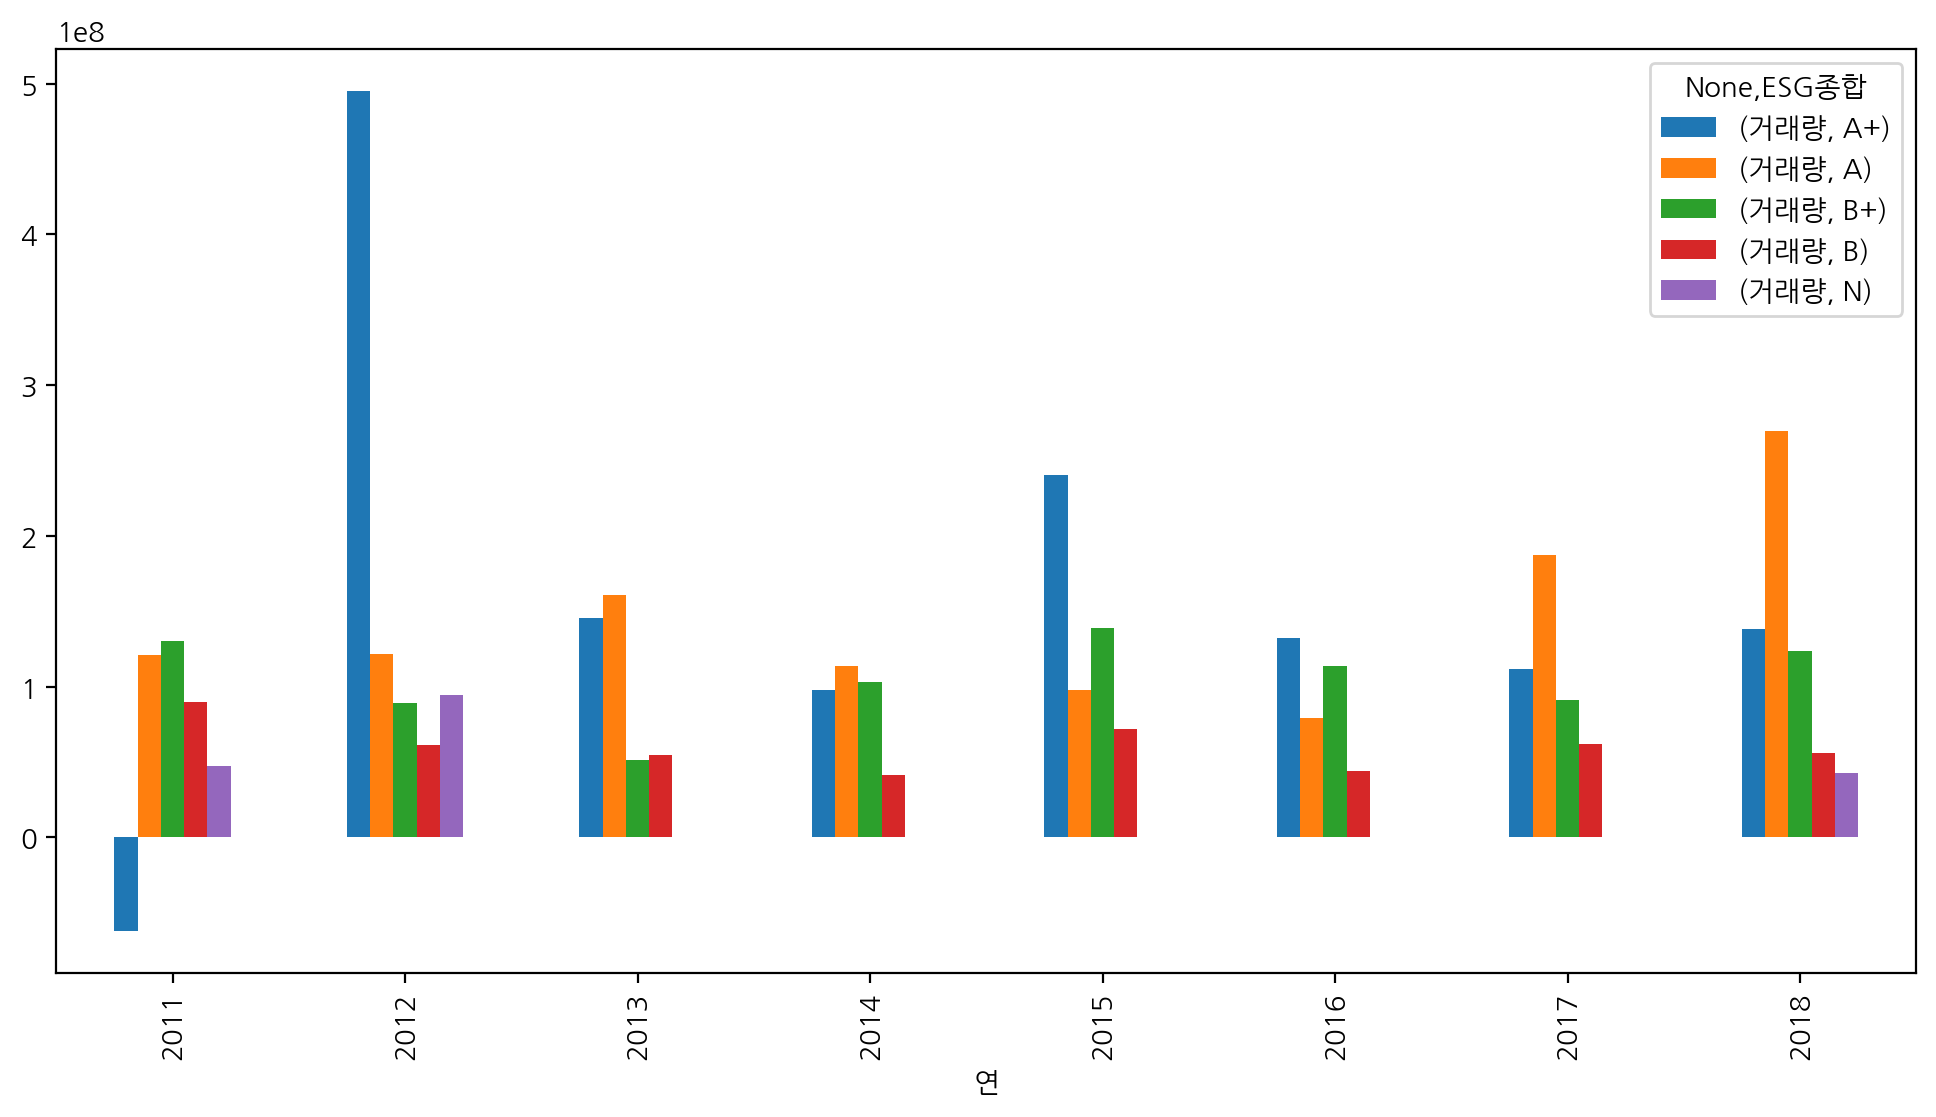

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

E


거래량                                               \
E                 S             A+              A             B+   
연                                                                  
2011            NaN -94110884.1667 165397929.4737 121922502.2708   
2012            NaN 427805490.8333 102894100.9286  99516382.8136   
2013            NaN 198878076.7500 113720119.3750  98558261.8929   
2014            NaN 132779231.5714 103534774.1111  73043272.1930   
2015            NaN 205061038.7500 105862259.3226 130087838.0822   
2016            NaN 122981596.0000 174772165.0000  79978051.3857   
2017 242632403.0000  49791320.5000 146595312.3529 116596063.7455   
2018            NaN 157681963.0000 122936833.7778 156963706.0407   

                                                 
E                B             C              D  
연                                                
2011 72054399.8810 79094308.8800            NaN  
2012 58080617.9400 43631003.2000            NaN  
2013 35376440.4419 52612532.5294  27978395.6667  
2014 57737362.6543 38842239.5000 238480458.0000  
2015 89698716.2519 47324020.0804 182137502.8889  
2016 45646912.7025 63835154.5652  39536992.1765  
2017 48617642.1795 86953969.3729  34539349.7500  
2018 78609440.2282 46831122.2615  27758261.8333

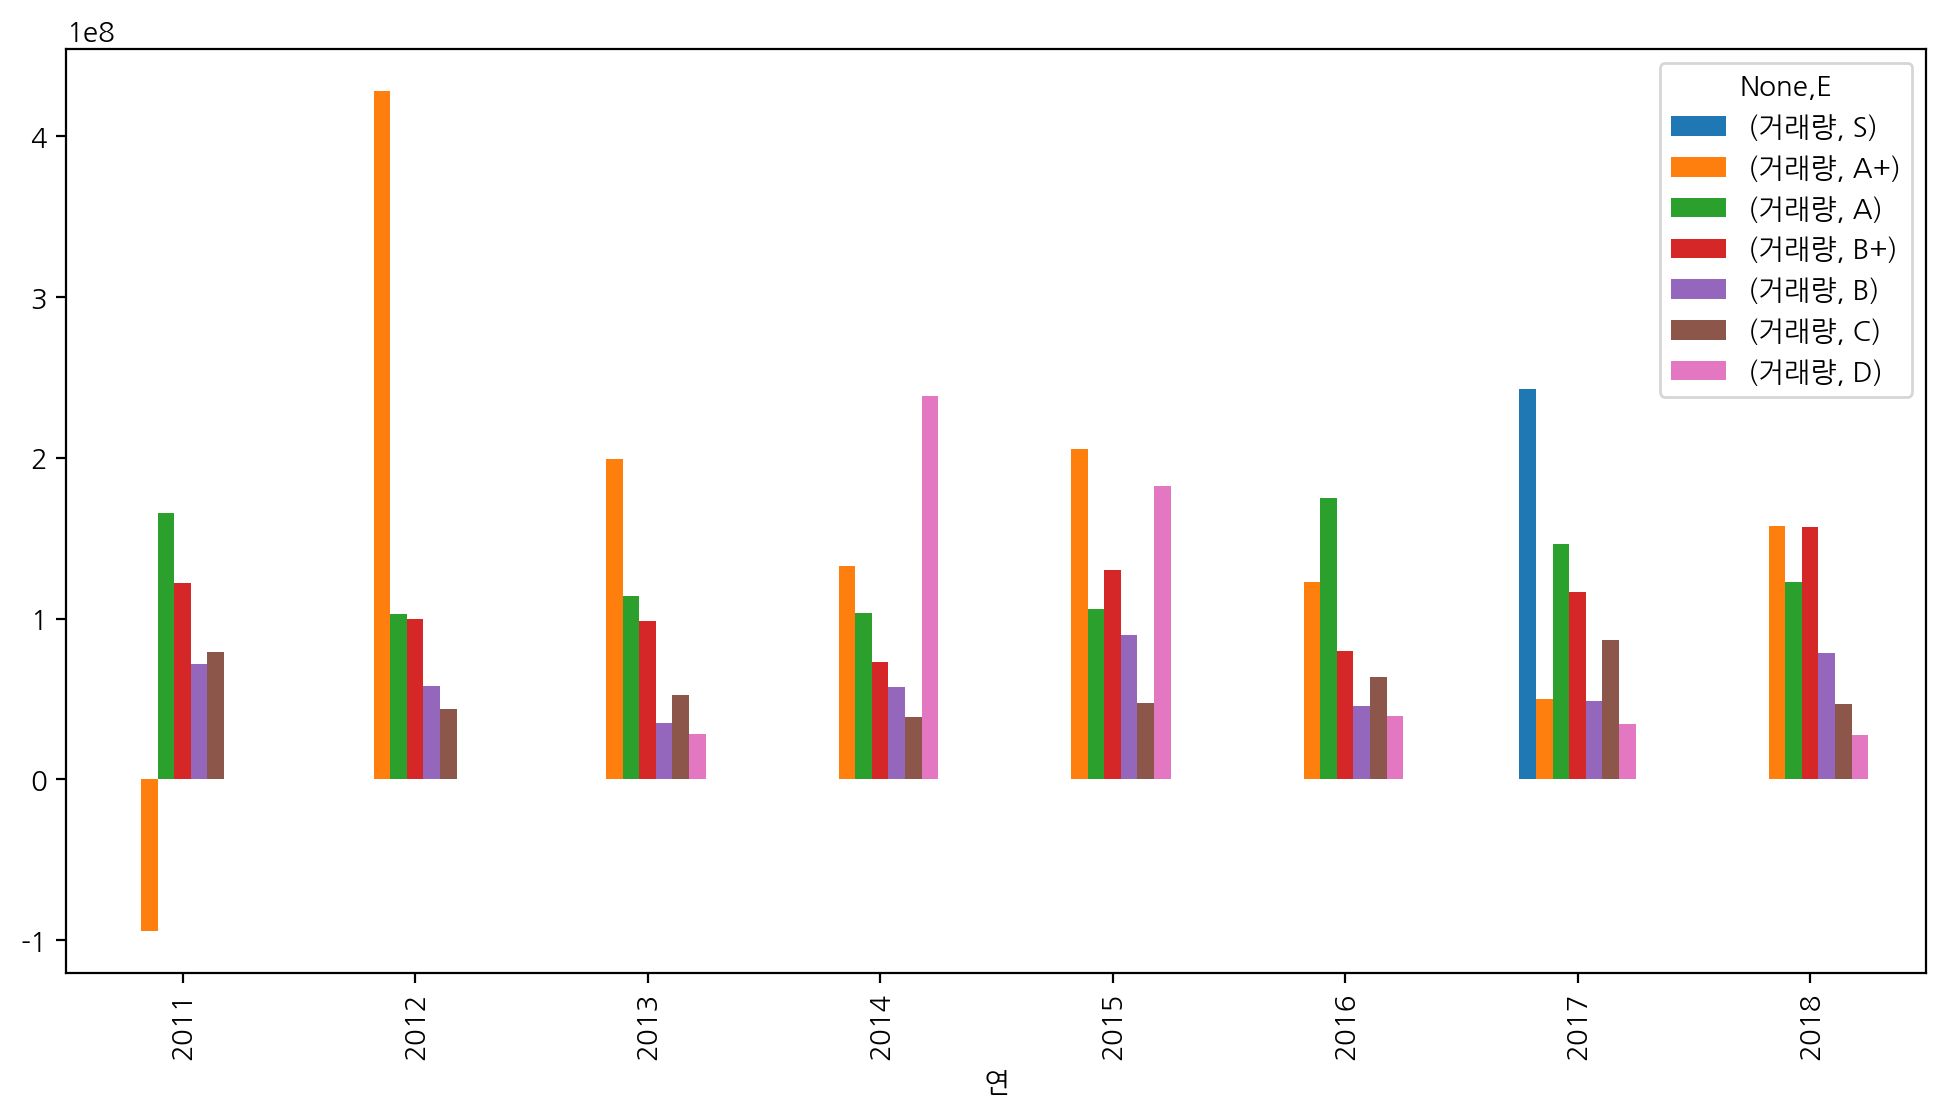

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

S


거래량                                                          
S                A+              A             B+             B             N
연                                                                            
2011 -62097856.2857 120711030.3571 150005529.5217 87249802.0476 47553817.1579
2012 261861800.5000 123537244.2143  82763850.7568 59835286.1371           NaN
2013 249438238.7500 104204058.8571  24251348.5581 59111704.2333           NaN
2014  79154898.0000 117430440.0811  95094432.9444 42513110.5164           NaN
2015  81859791.2857 102022492.8649 140988236.8391 68448116.1485           NaN
2016  77989201.6562 119884317.6000  92244917.7479 42929913.2915           NaN
2017  81876426.6000 157430802.6739  82517744.6889 66912834.4976           NaN
2018 158026899.9375 189609488.6596  71297715.7043 84154226.5238 42973168.4286

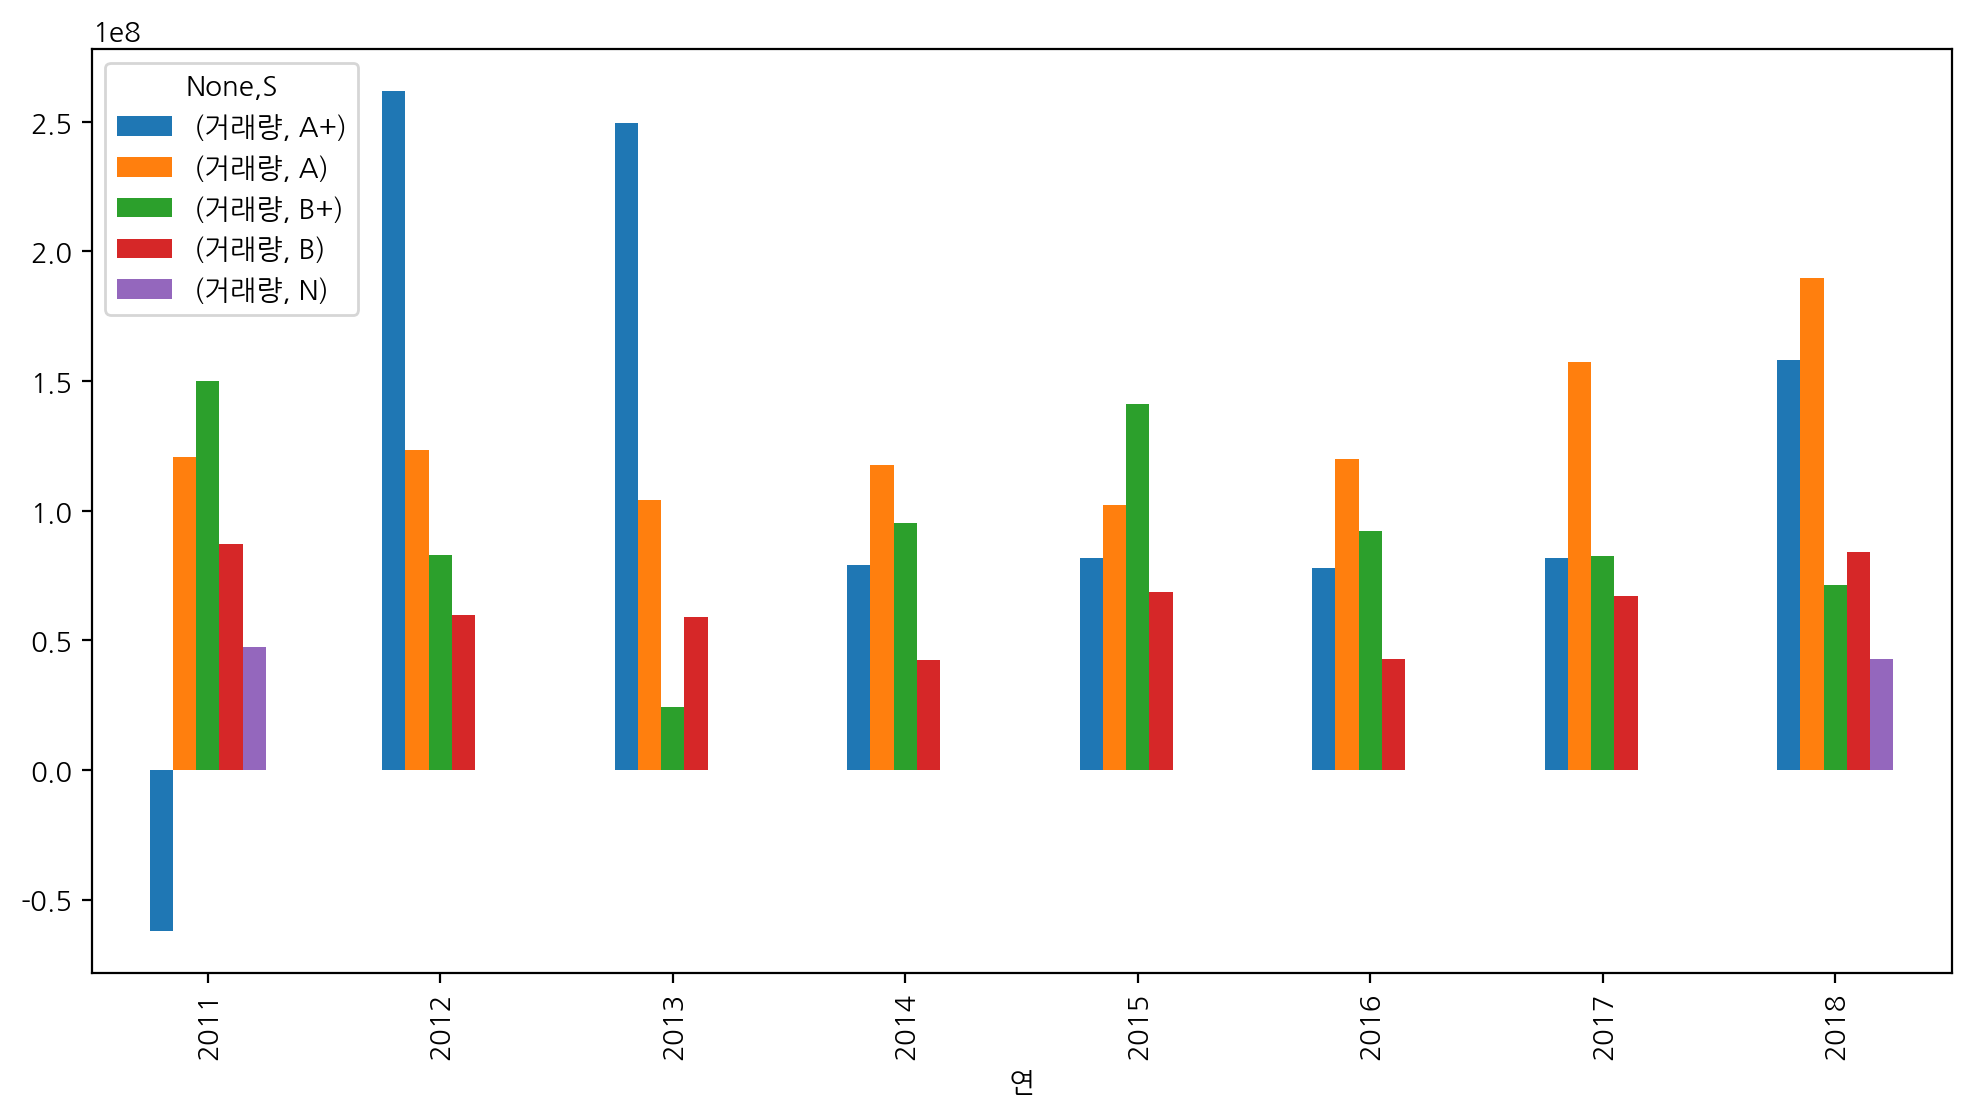

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

G


거래량                                                          
G                 A+              A             B+             B             N
연                                                                             
2011 -150315131.8571 161960578.4000 148762789.5000 86416425.1571 76289187.2459
2012  293244192.6250  87743040.7222  79019270.8500 69628808.5625 94587718.0000
2013  110021247.4000 140702208.6667  35885199.2656 66494740.2018           NaN
2014   77235749.5000 132569809.8889  63810077.7895 51040891.1852           NaN
2015   68239310.7143 145549514.8704  85757666.4722 76907167.6492           NaN
2016  136577089.6667 106574933.2500  88641516.8830 41735588.8350           NaN
2017  193511429.6667 153960587.2462  87624976.6019 56212751.7304           NaN
2018  120389108.8571 253688073.1356 106314345.7477 55835184.4328 42973168.4286

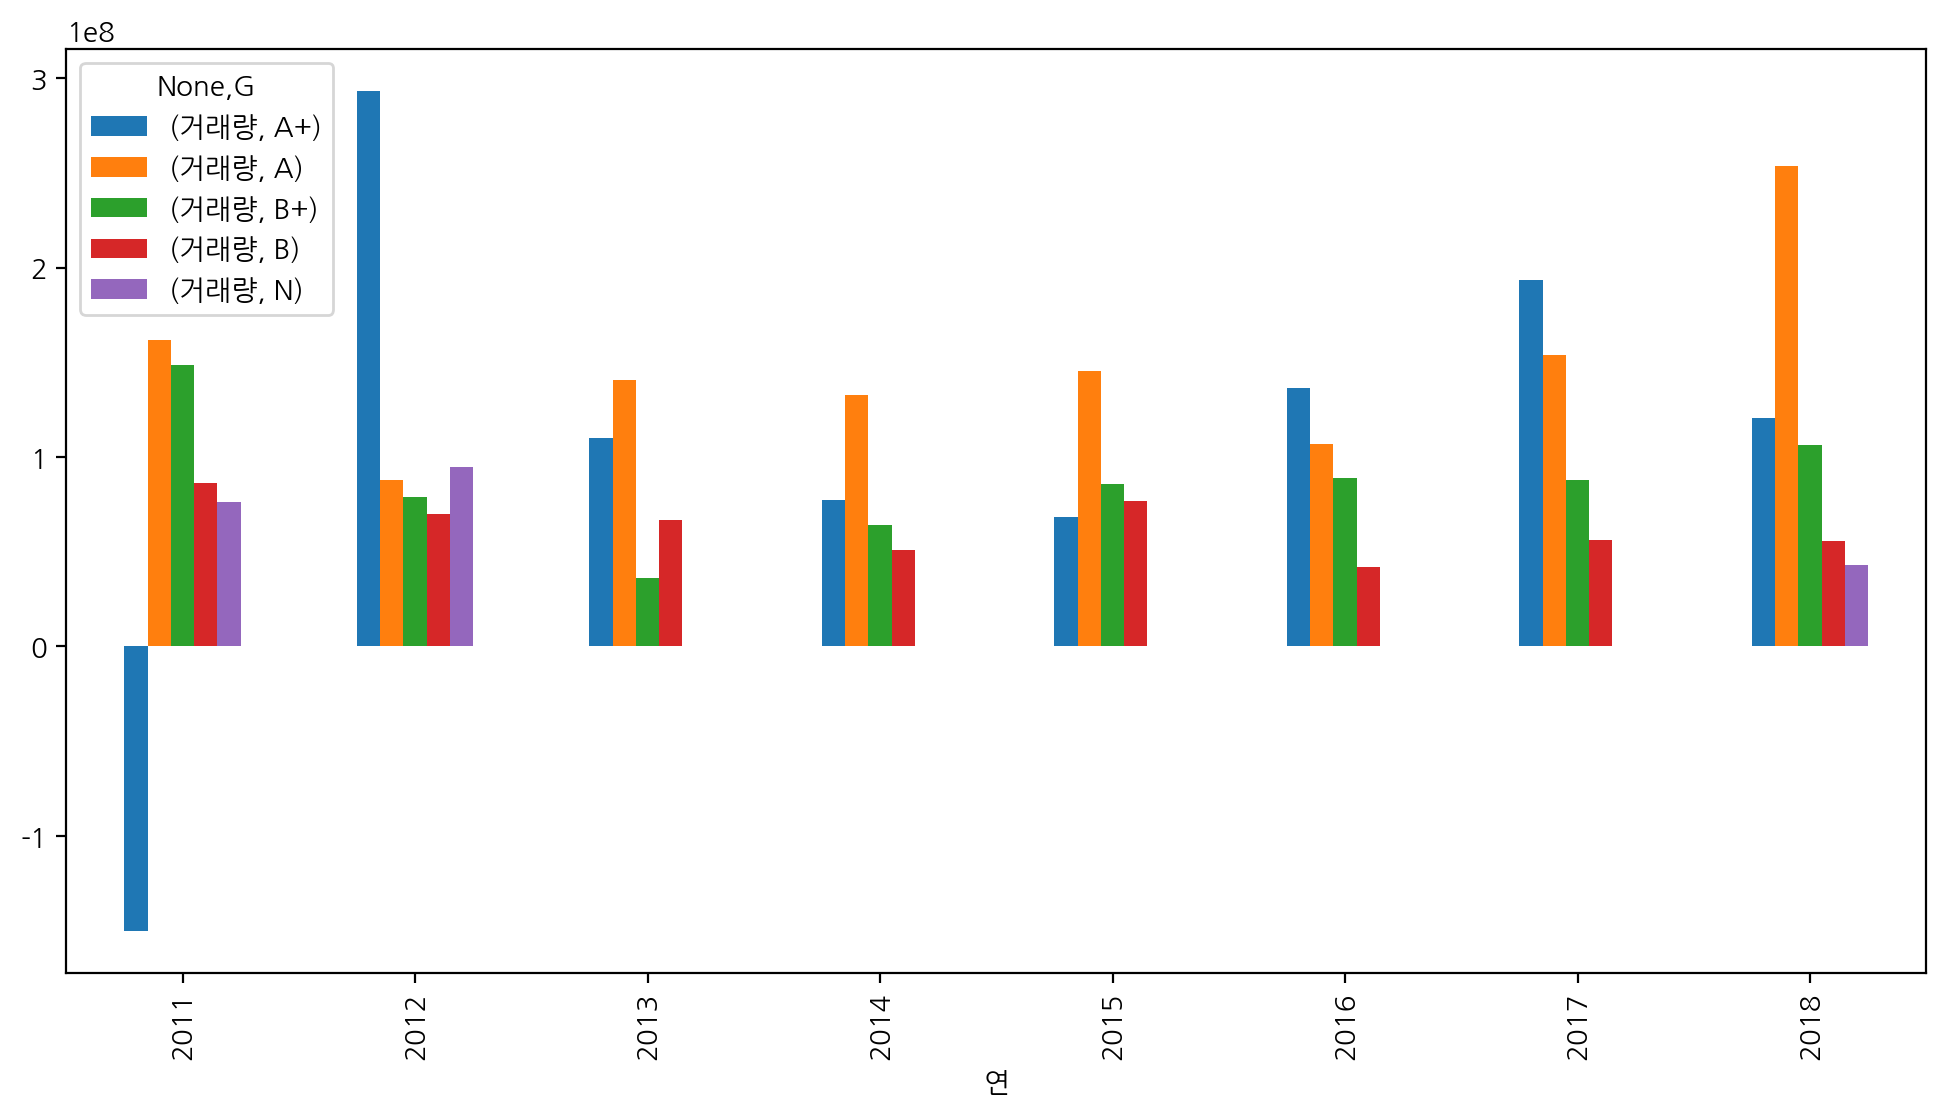

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 


In [89]:
for i in list_esg:
    print()
    print(i)

    d = df.pivot_table(["거래량"], ["연"], [i], aggfunc="mean")
    display(d)

    d.plot(kind="bar", figsize=(12, 6))
    plt.show()
    print("---------- " * 8)

## finaStat


기업매출금액
ESG종합


ESG종합                           A+                   A                  B+  \
재무제표구분코드명 연                                                                  
별도요약재무제표  2011                 NaN                 NaN                 NaN   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN                 NaN   
          2015                 NaN 15761859150503.4609  6649541733784.0273   
          2016 13671246375838.6660 16250311208762.0762  5964710172455.4131   
          2017  8631460343931.0000 10166572618897.8125  8123515042135.1592   
          2018 15168576111844.5000 15592188984556.9570  4397269889210.6978   
연결요약재무제표  2011                 NaN                 NaN  1017339000000.0000   
          2012                 NaN                 NaN   987276000000.0000   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN  3905572000000.0000   
          2015                 NaN 29884501309242.5391 10501450651653.1621   
          2016 16819189095531.0000 34912739111541.1523  9757467139965.3418   
          2017 40342072044466.3359 17566946271311.5000 13852564062186.3750   
          2018 43748727971665.0000 27423023115594.2734  6980192869245.3906   

ESG종합                           B                  N  
재무제표구분코드명 연                                           
별도요약재무제표  2011     138485382.0000                NaN  
          2013    4056326000.0000                NaN  
          2014             0.0000                NaN  
          2015 1538766626283.8547                NaN  
          2016 1087496573711.9832                NaN  
          2017 1335675577680.8982                NaN  
          2018 1110013495546.6729    3908032659.6667  
연결요약재무제표  2011  565991666666.6666                NaN  
          2012  472876500000.0000                NaN  
          2013  596602500000.0000                NaN  
          2014  990983333333.3334                NaN  
          2015 2733173149685.0181                NaN  
          2016 1922675006948.3579                NaN  
          2017 2431077126035.0635                NaN  
          2018 2033300206235.8586 2551020788392.3335

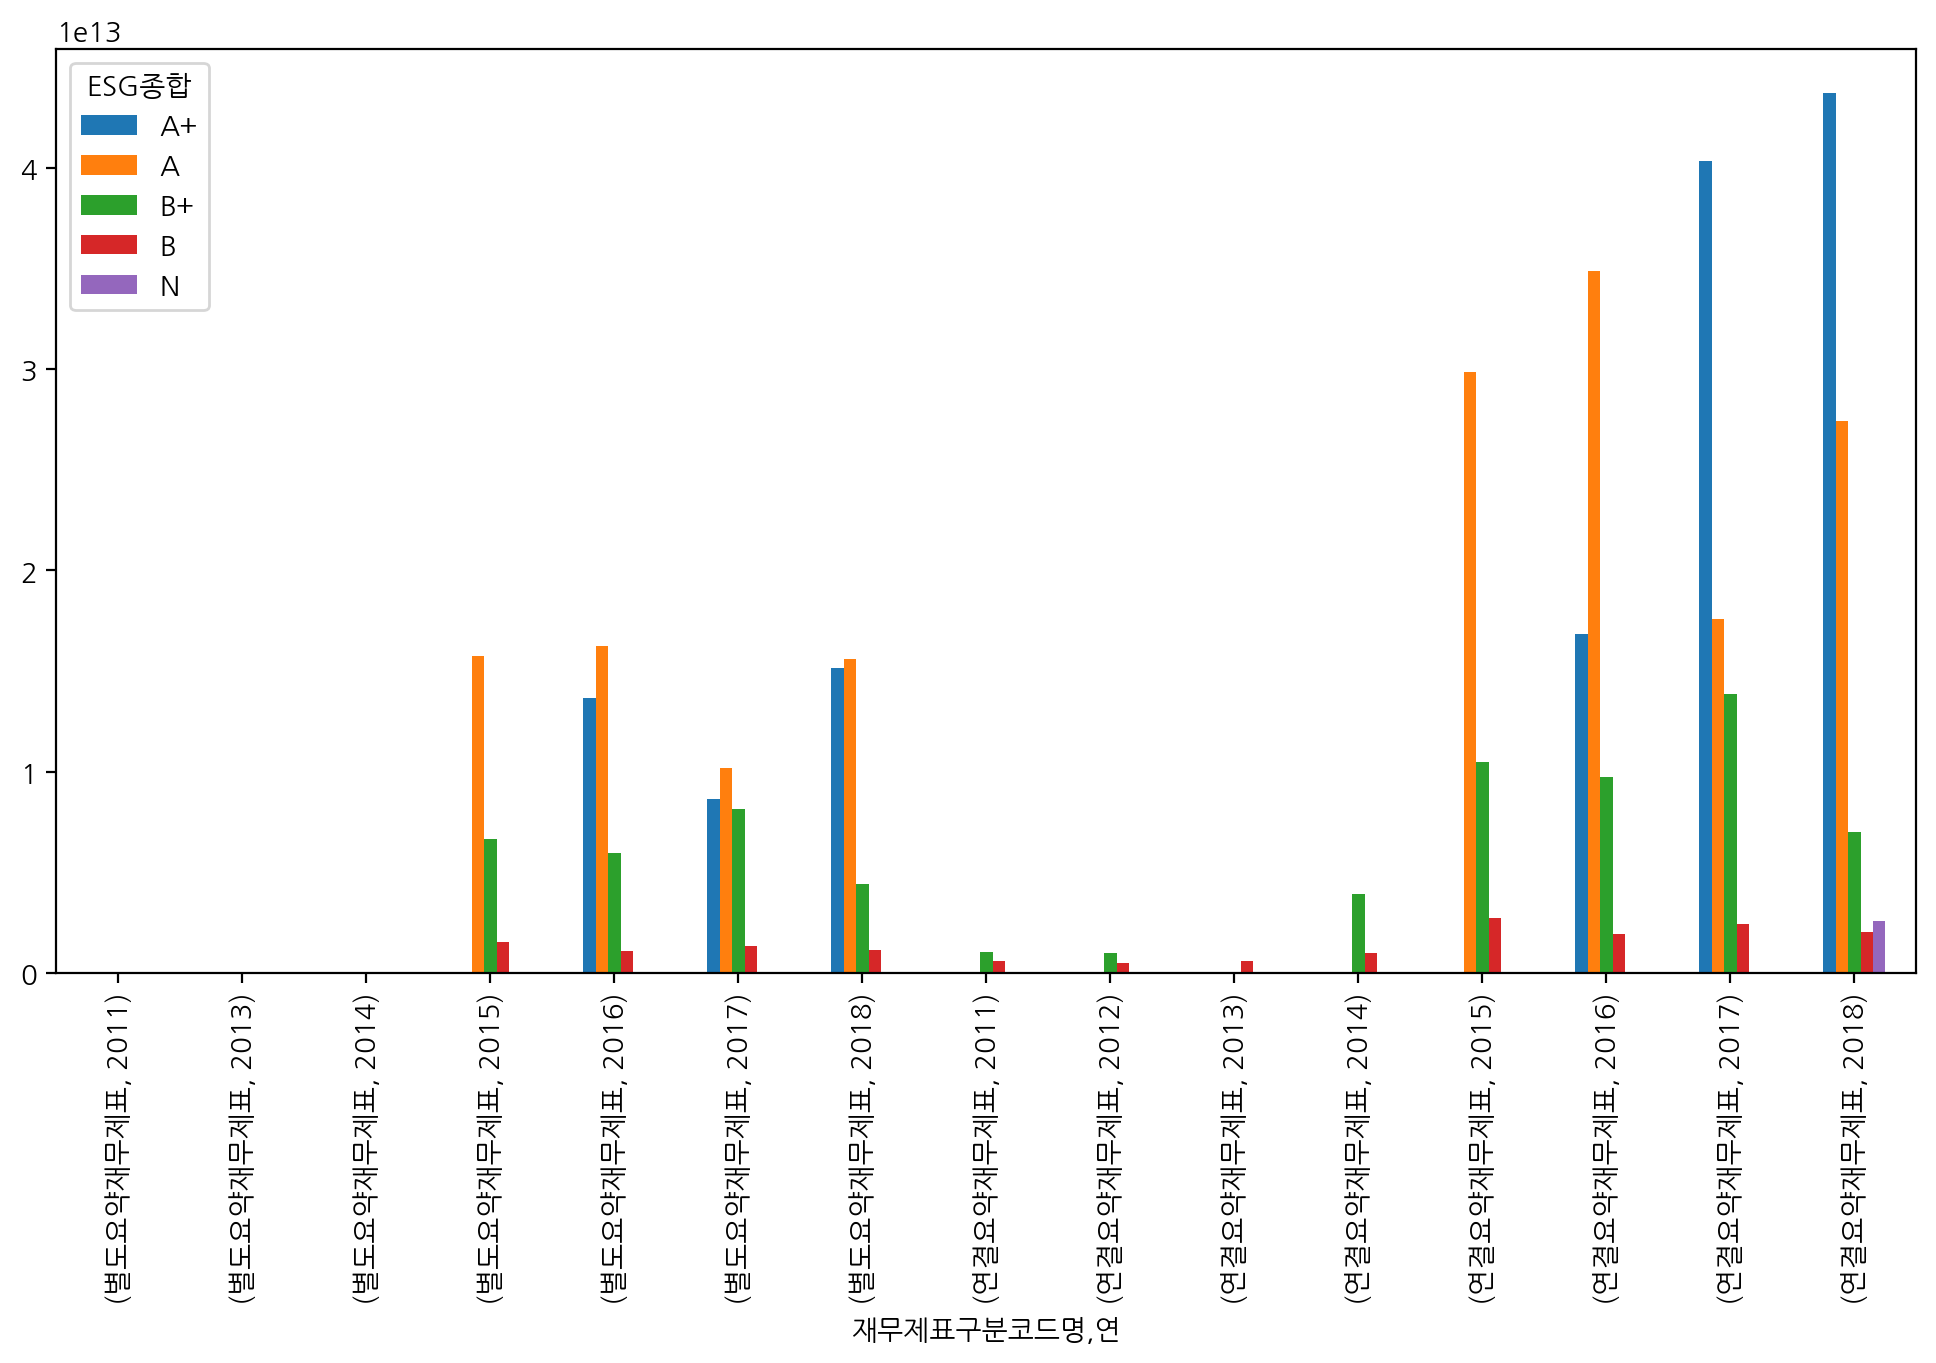

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업매출금액
E


E                               A+                   A                  B+  \
재무제표구분코드명 연                                                                  
별도요약재무제표  2011                 NaN                 NaN                 NaN   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN                 NaN   
          2015                 NaN  4342939317248.2729  9001626857773.5430   
          2016 10553363515379.0000  6583902989988.6670  7799299233424.6172   
          2017 10445670000000.0000  6869111202822.5830  4280696047241.2964   
          2018 13280391000000.0000  4923143091324.5830  8344171047741.0000   
연결요약재무제표  2011                 NaN                 NaN                 NaN   
          2012                 NaN                 NaN                 NaN   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN  3905572000000.0000   
          2015                 NaN 10910993751166.9082 14431035907535.5879   
          2016 22494526508398.2500 19005049970599.6680 13195670321313.3750   
          2017 57093871000000.0000 19428635281950.6367  6340955888980.9609   
          2018 47946425000000.0000 18577143631113.1836 11941520826436.9453   

E                               B                  C                  D  
재무제표구분코드명 연                                                              
별도요약재무제표  2011     138485382.0000                NaN                NaN  
          2013    4056326000.0000                NaN                NaN  
          2014                NaN             0.0000                NaN  
          2015 1917846489418.6956 2251715372547.4106 6829177873800.6670  
          2016 1979212773677.0127 2496624109831.2764 1964080981961.6250  
          2017 3842699716856.5864 1945042462922.2666 2821488664704.7500  
          2018 1632329679594.6758 1484590253119.9333  663670474077.8334  
연결요약재무제표  2011  779482333333.3334  376867000000.0000                NaN  
          2012  692180500000.0000  548668000000.0000                NaN  
          2013                NaN  596602500000.0000                NaN  
          2014                NaN  990983333333.3334                NaN  
          2015 3715775259880.1167 4226744244593.4424 6755260578911.2500  
          2016 3592389669149.3613 4057262424635.8408 2845837092340.6250  
          2017 6473924164674.9707 3133932229705.5356 4734506573985.1250  
          2018 3024069748735.1060 2508241941144.8965 1346918595293.8333

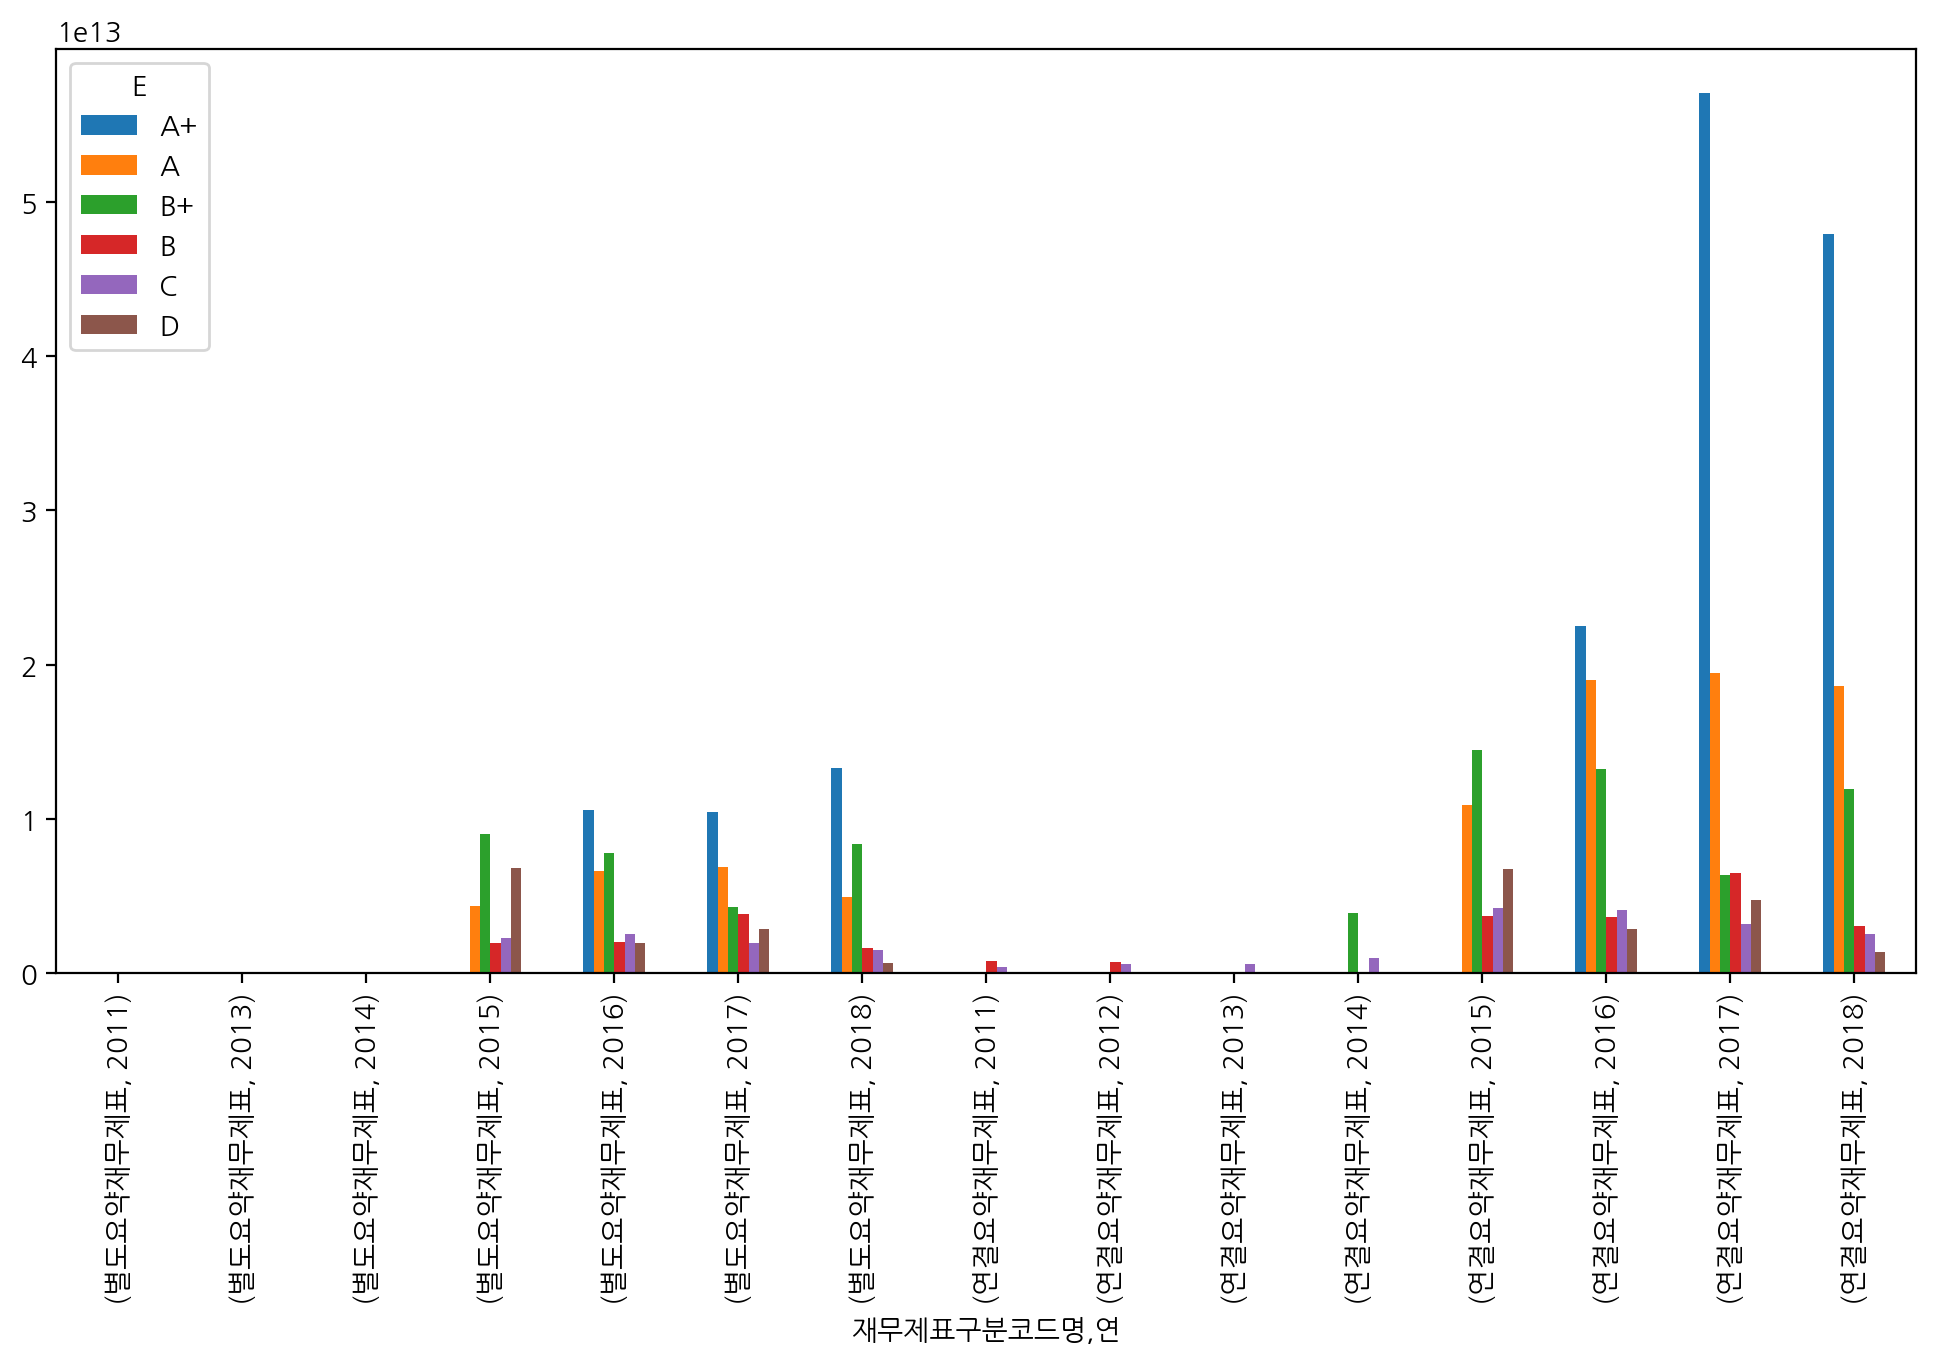

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업매출금액
S


S                               A+                   A                  B+  \
재무제표구분코드명 연                                                                  
별도요약재무제표  2011                 NaN                 NaN                 NaN   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN                 NaN   
          2015  9797851540478.3340  5464212419153.0625  9750116231250.7441   
          2016 17609181031687.6680  6383683818674.0000  3618728804086.3213   
          2017  7361979030638.2354 17718455299089.6094  3415066843848.3477   
          2018  9453570439614.9121 15733886529895.4766  1782147715084.9805   
연결요약재무제표  2011                 NaN                 NaN  1017339000000.0000   
          2012                 NaN                 NaN   987276000000.0000   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN                 NaN   
          2015 11644034156495.0000 15819290210960.5000 14707241534394.6309   
          2016 32033512422510.4648 12320242651806.5000  6769800233510.1377   
          2017 18586766135425.2500 30326014357092.3906  5038282502564.0244   
          2018 20498754246832.6836 27943616967848.4727  2713844343096.5601   

S                               B                  N  
재무제표구분코드명 연                                           
별도요약재무제표  2011     138485382.0000                NaN  
          2013    4056326000.0000                NaN  
          2014             0.0000                NaN  
          2015 1247144727750.7673                NaN  
          2016 1202520146833.6868                NaN  
          2017 1024250092329.6400                NaN  
          2018 1078236946871.4634    3908032659.6667  
연결요약재무제표  2011  565991666666.6666                NaN  
          2012  472876500000.0000                NaN  
          2013  596602500000.0000                NaN  
          2014 1719630500000.0000                NaN  
          2015 2245370063408.7310                NaN  
          2016 2088799794491.7742                NaN  
          2017 1848854293894.7126                NaN  
          2018 1975900206825.0266 2551020788392.3335

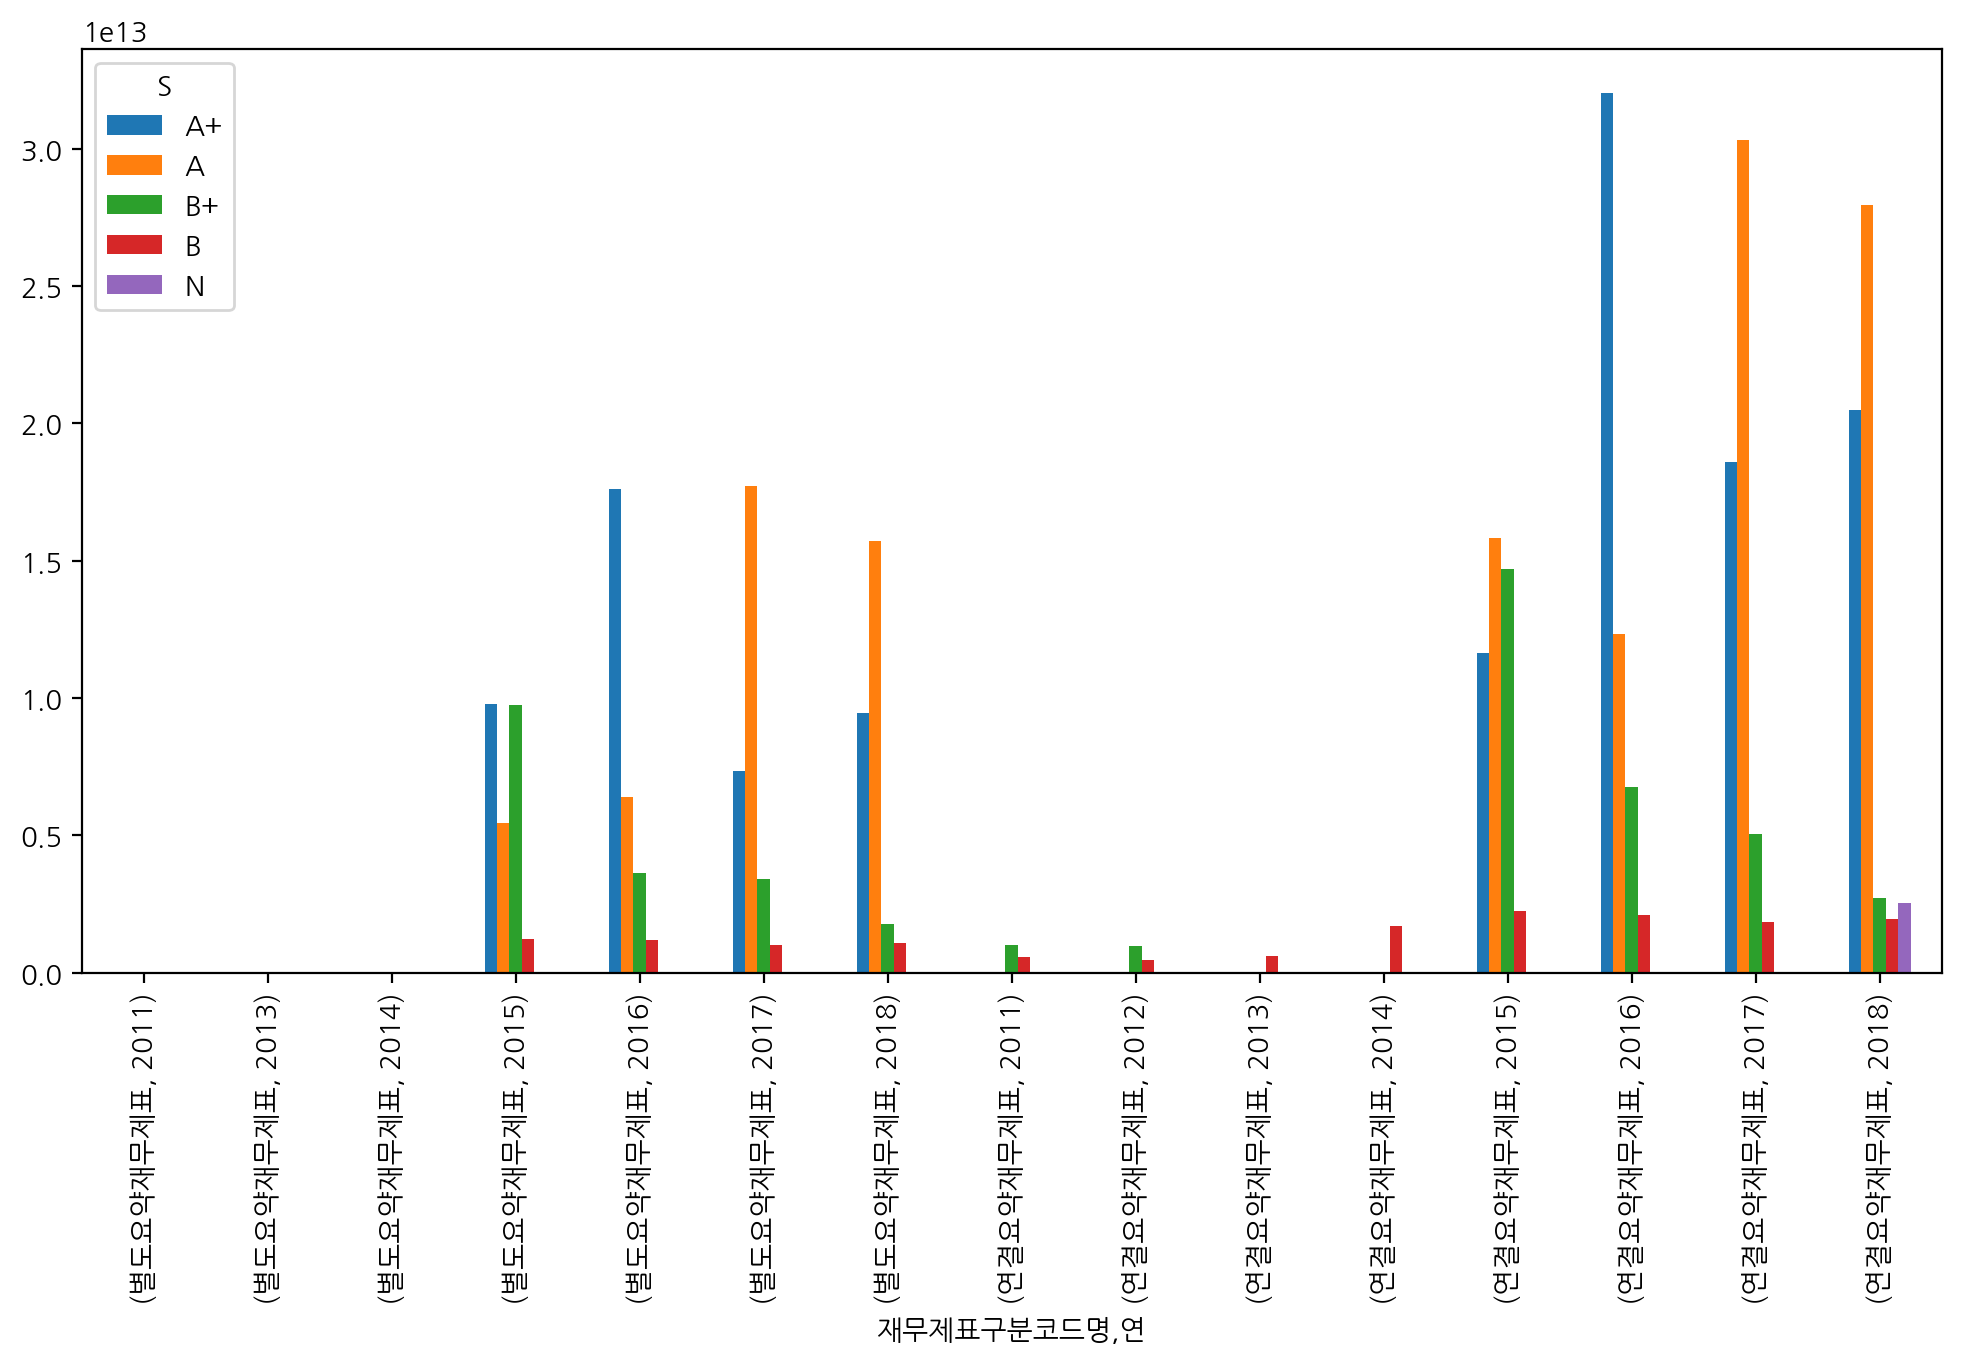

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업매출금액
G


G                               A+                   A                 B+  \
재무제표구분코드명 연                                                                 
별도요약재무제표  2011                 NaN                 NaN                NaN   
          2013                 NaN                 NaN                NaN   
          2014                 NaN                 NaN                NaN   
          2015 50119042373495.6641  9294029083632.9238 3254196028415.5000   
          2016  4690337158428.0000 12170821201420.7051 3004305803519.1738   
          2017  5003041031793.0000 15540925240823.0332 2814883931825.9214   
          2018 11614314986459.5000 15080685801127.2969 4332199346316.9058   
연결요약재무제표  2011                 NaN                 NaN 1017339000000.0000   
          2012                 NaN                 NaN  987276000000.0000   
          2013                 NaN                 NaN                NaN   
          2014                 NaN                 NaN 2030989666666.6667   
          2015 73312050347021.3281 17864546158653.6523 4982072320017.5488   
          2016  6033040463975.0000 22695119428519.5312 4409811207170.0000   
          2017  6838474133399.0000 27060347353478.6562 3945368167636.9165   
          2018 16931476045368.5000 27800950193700.1914 6704925607196.7002   

G                               B                  N  
재무제표구분코드명 연                                           
별도요약재무제표  2011                NaN     138485382.0000  
          2013    4056326000.0000                NaN  
          2014             0.0000                NaN  
          2015  813360504795.2968                NaN  
          2016  993602200774.8400                NaN  
          2017  897111557321.6666                NaN  
          2018  706684088353.5790    3908032659.6667  
연결요약재무제표  2011  403937000000.0000  890101000000.0000  
          2012  472876500000.0000                NaN  
          2013  596602500000.0000                NaN  
          2014  785553000000.0000                NaN  
          2015 1752276188387.6914                NaN  
          2016 1905827905592.8333                NaN  
          2017 2666507509833.4395                NaN  
          2018 1975592170447.3635 2551020788392.3335

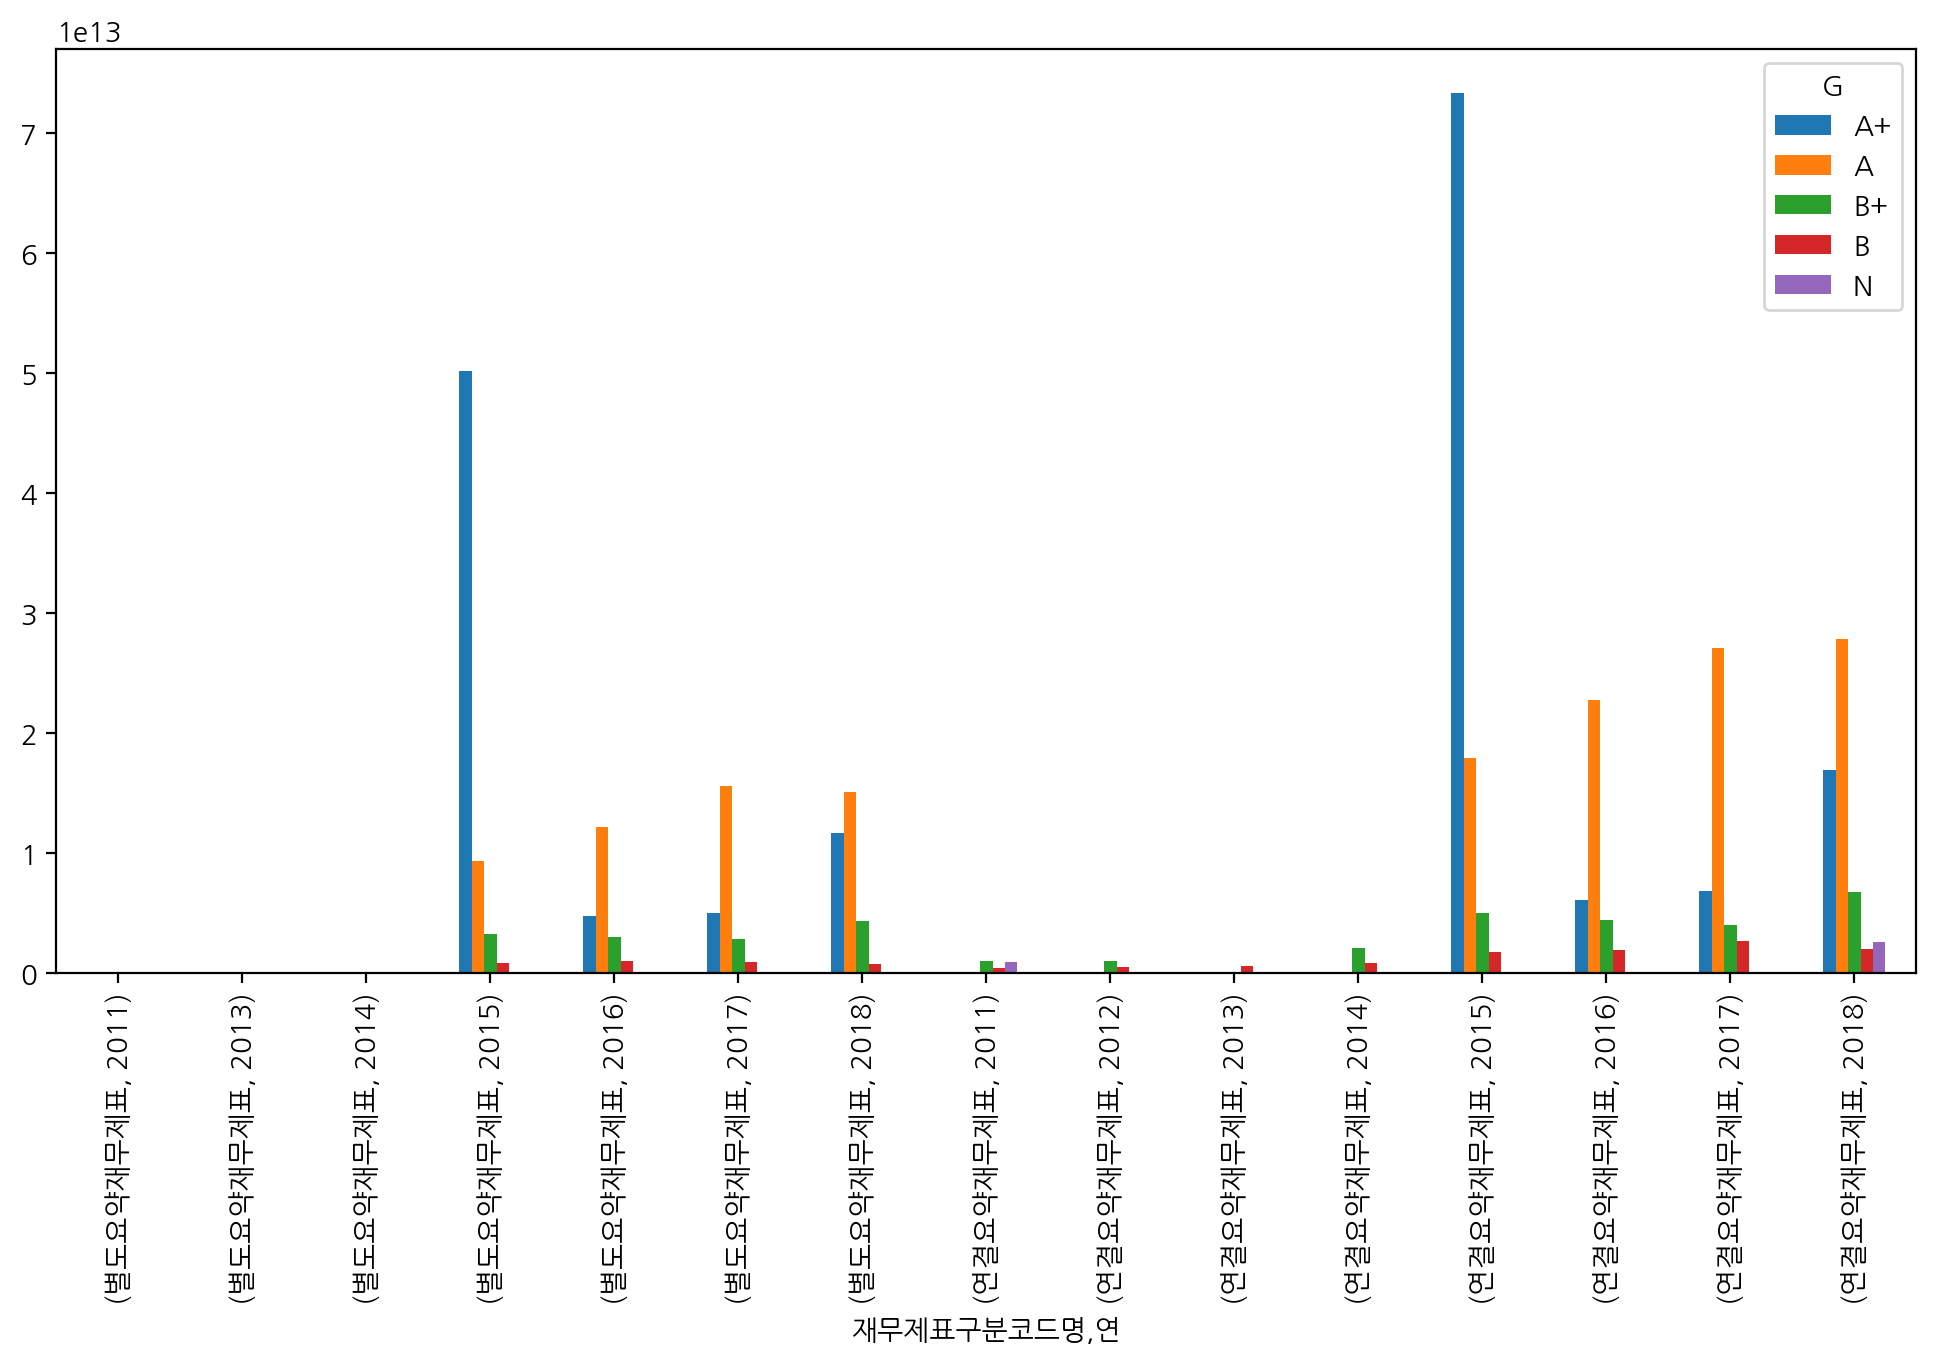

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업영업이익
ESG종합


ESG종합                          A+                  A                 B+  \
재무제표구분코드명 연                                                               
별도요약재무제표  2011                NaN                NaN                NaN   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN                NaN   
          2015                NaN 1223976498917.6924  321798023424.2703   
          2016  466070066342.0000 1508666457442.1538  351169666633.4348   
          2017  731152115723.6666 1527872930218.4375 1059429442866.6136   
          2018  928677045578.0000 3195626619554.1304  252373588055.5581   
연결요약재무제표  2011                NaN                NaN   11179000000.0000   
          2012                NaN                NaN   -5980000000.0000   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN  187868000000.0000   
          2015                NaN 2492506215317.4614  514204752987.6757   
          2016  593604369401.6666 3535933761919.0771  542035093748.1364   
          2017 2513502476187.3335 1954979743893.7500 1781966234415.4500   
          2018 1908306792061.7500 4346467848925.1362  399874117209.0000   

ESG종합                          B                N  
재무제표구분코드명 연                                        
별도요약재무제표  2011      5922667.0000              NaN  
          2013  -2308079000.0000              NaN  
          2014            0.0000              NaN  
          2015  94679228652.0645              NaN  
          2016  76648821610.4538              NaN  
          2017  88525676894.0085              NaN  
          2018  82218899224.9065 26235717316.6667  
연결요약재무제표  2011   4631666666.6667              NaN  
          2012  11917000000.0000              NaN  
          2013  23209500000.0000              NaN  
          2014  22293000000.0000              NaN  
          2015 155537069864.5946              NaN  
          2016 126618883721.2569              NaN  
          2017 150459569415.7273              NaN  
          2018 135969073749.2828 65785785715.6667

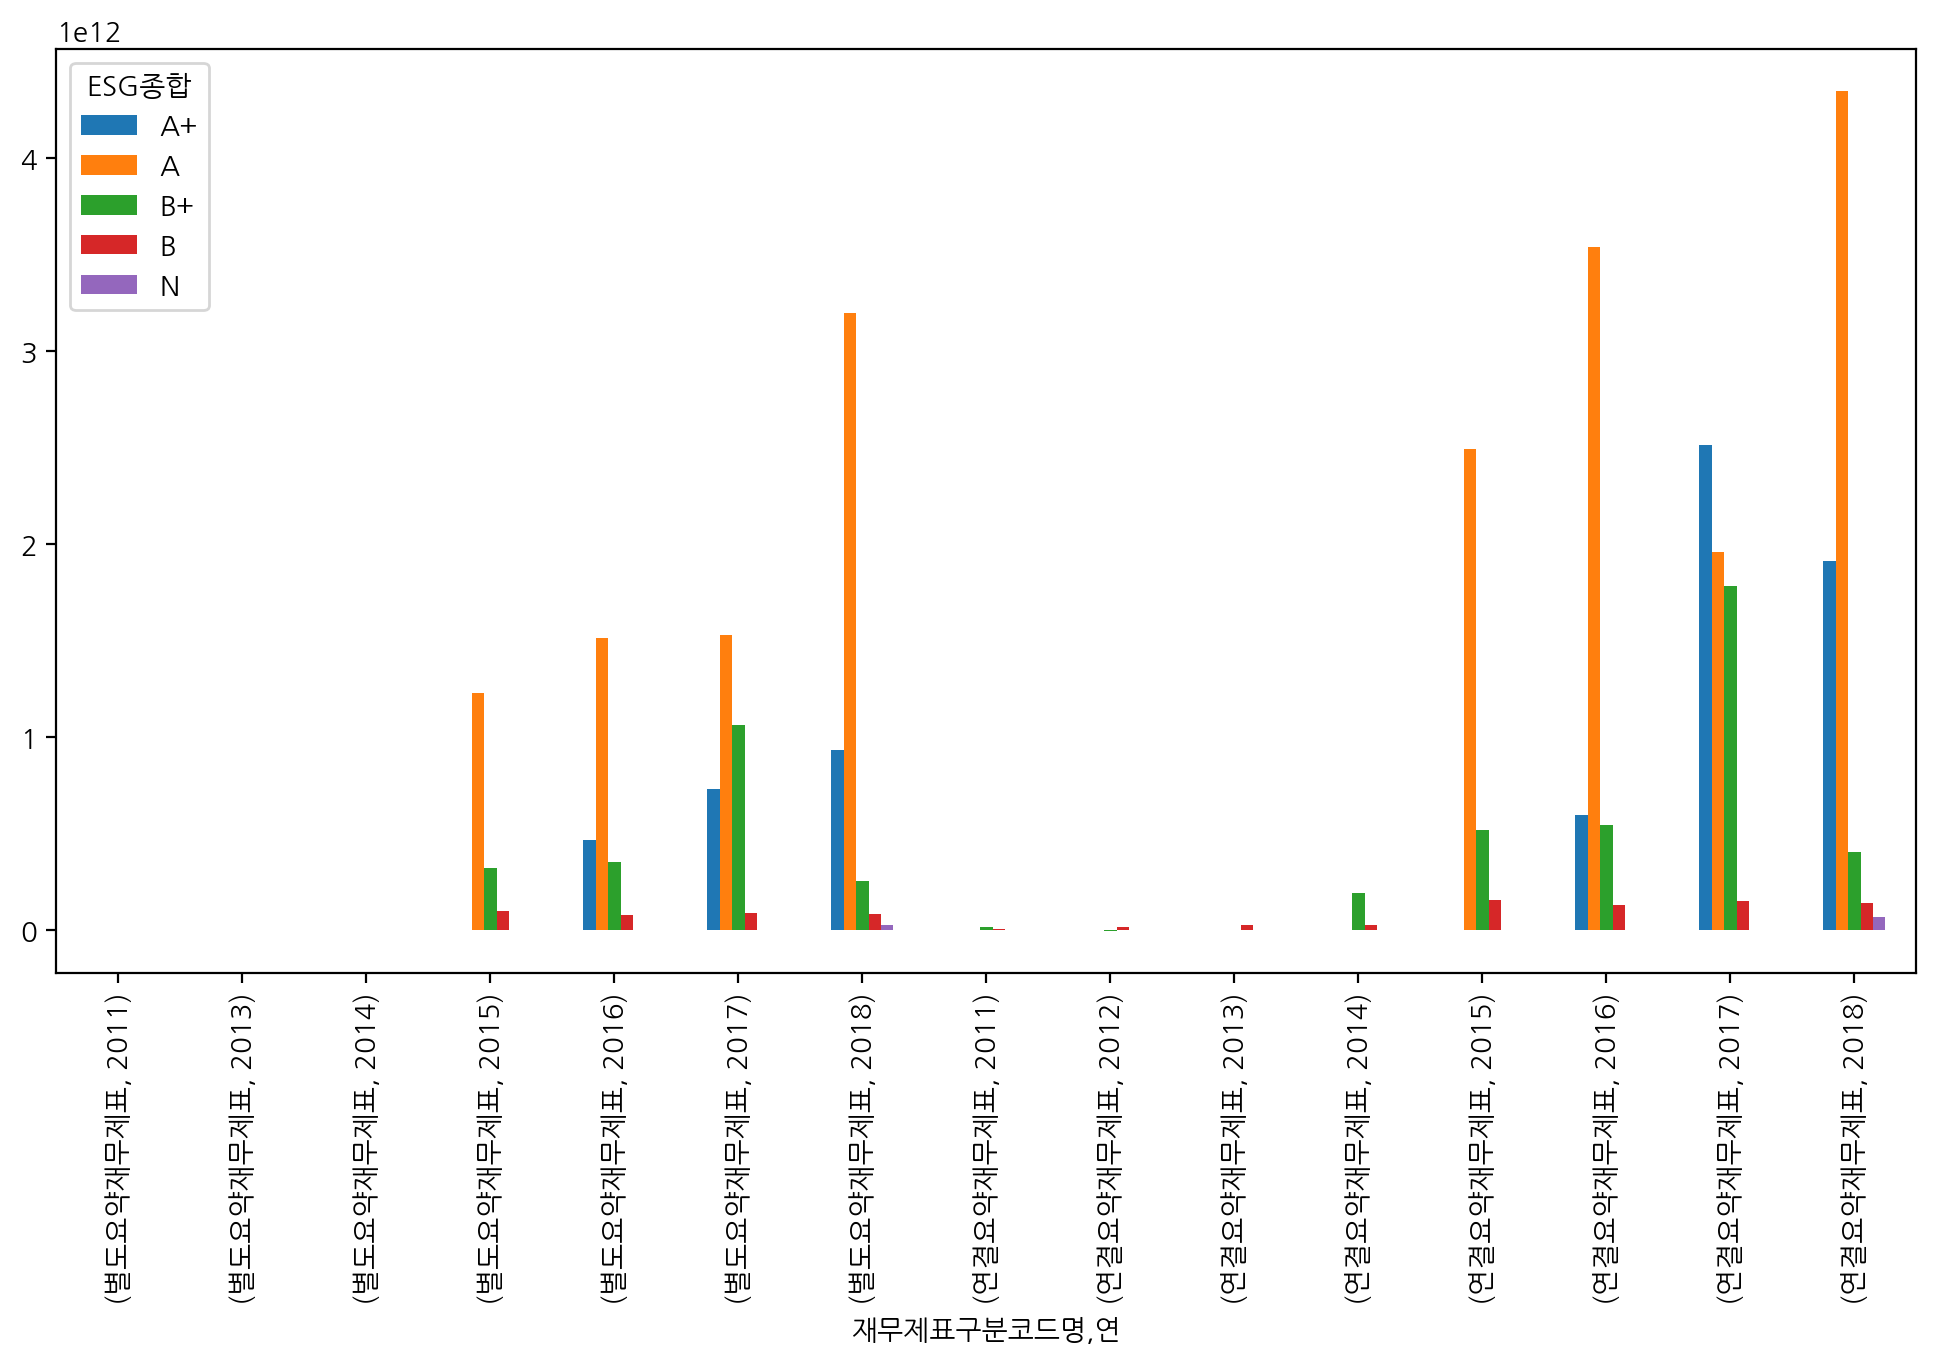

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업영업이익
E


E                              A+                  A                 B+  \
재무제표구분코드명 연                                                               
별도요약재무제표  2011                NaN                NaN                NaN   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN                NaN   
          2015                NaN  262010660934.0909  662076327038.1428   
          2016  366593056756.5000  742264697061.2222  618054024124.8823   
          2017 1122057500000.0000 1508220830099.2500  304879815109.1481   
          2018 1001769000000.0000  461505587203.5833 1441210534194.2183   
연결요약재무제표  2011                NaN                NaN                NaN   
          2012                NaN                NaN                NaN   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN  187868000000.0000   
          2015                NaN  466266455733.9091 1185749231520.6177   
          2016 1252287570051.2500 1422100099929.6667 1277254140088.5312   
          2017 3617152000000.0000 2167375852287.8181  468459682172.7059   
          2018 2176445666666.6667  935190800258.6364 1888039961458.2964   

E                              B                 C                 D  
재무제표구분코드명 연                                                           
별도요약재무제표  2011      5922667.0000               NaN               NaN  
          2013  -2308079000.0000               NaN               NaN  
          2014               NaN            0.0000               NaN  
          2015  91842542113.3333 115792509850.0000 227380343818.0000  
          2016 124818471289.0633 140726390436.0425  81312209925.3750  
          2017 564833565401.4800 116480585237.9000 129642331369.6250  
          2018  80537839189.8784  99832779916.3000  29596193799.3333  
연결요약재무제표  2011   2756666666.6667  16804000000.0000               NaN  
          2012   1714000000.0000  14426000000.0000               NaN  
          2013               NaN  23209500000.0000               NaN  
          2014               NaN  22293000000.0000               NaN  
          2015 190038413932.2833 208804916171.1538 247051513257.5000  
          2016 232901888735.0695 201887153569.6591 133350006911.6250  
          2017 943133601690.5217 164700355713.2143 249334337577.5000  
          2018 146241890688.9394 151849889114.8965  80408169516.6667

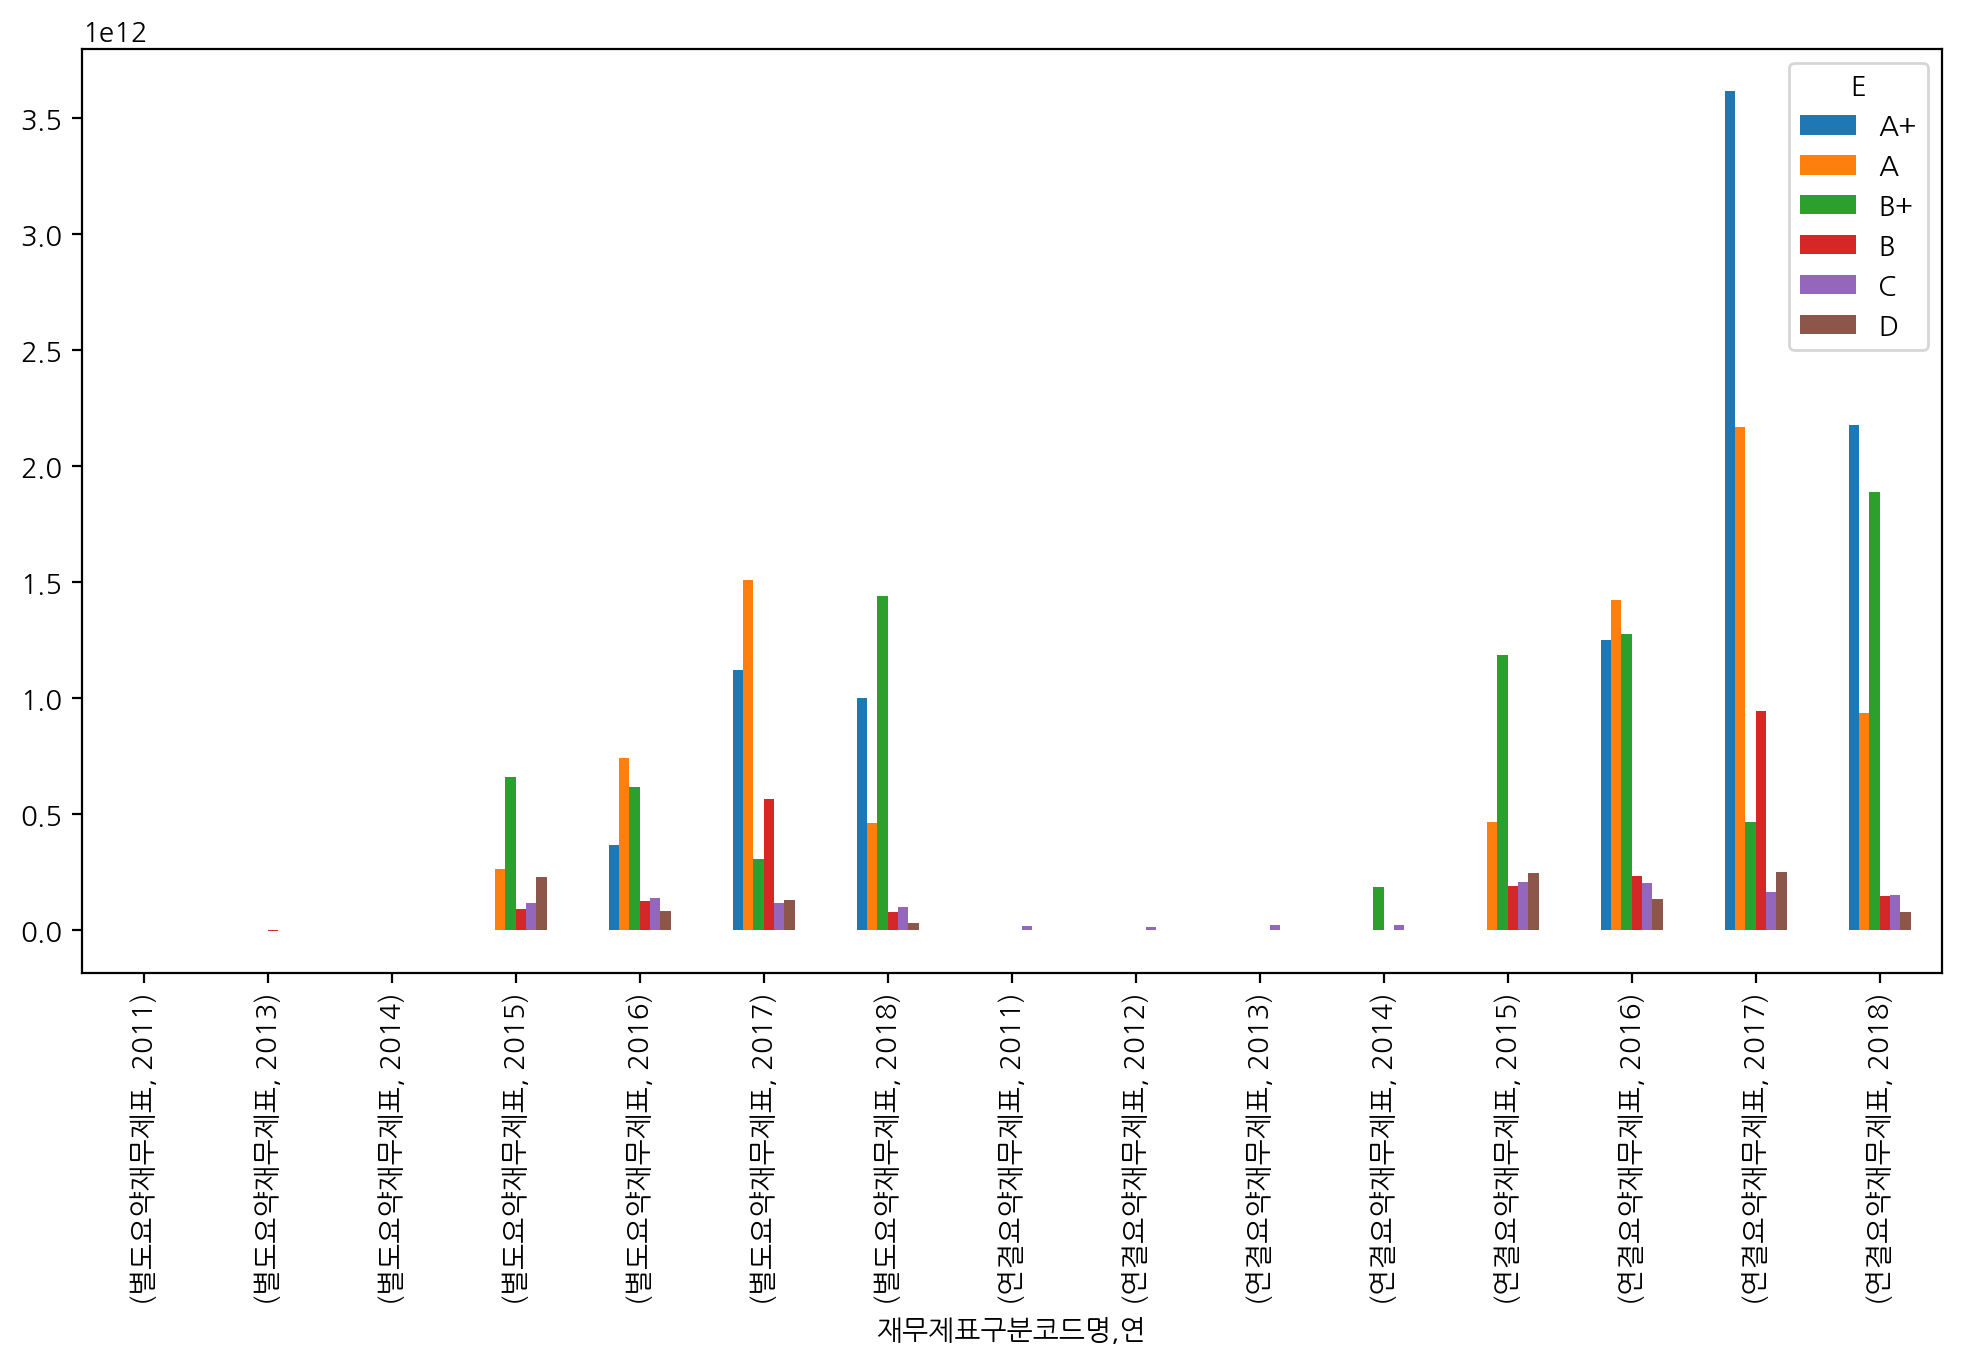

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업영업이익
S


S                              A+                  A                 B+  \
재무제표구분코드명 연                                                               
별도요약재무제표  2011                NaN                NaN                NaN   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN                NaN   
          2015  872158289494.6666   82603705433.6250  775266598913.2565   
          2016 1435040680723.3333  203687908231.2727  254607987243.1250   
          2017  605642820576.1765 3202324306891.6113  203921391619.6304   
          2018 1390342921177.6956 2512016865065.0000  131545428615.2549   
연결요약재무제표  2011                NaN                NaN   11179000000.0000   
          2012                NaN                NaN   -5980000000.0000   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN                NaN   
          2015 1037606209944.3334  423110275012.1875 1299418323632.0527   
          2016 3043929503381.4668  496622366721.8000  435342762653.6078   
          2017 1221763294523.8750 4662027035934.3330  308840381105.9756   
          2018 1865061984618.6819 3940688742328.7368  159475521925.1600   

S                              B                N  
재무제표구분코드명 연                                        
별도요약재무제표  2011      5922667.0000              NaN  
          2013  -2308079000.0000              NaN  
          2014            0.0000              NaN  
          2015  46421674072.8017              NaN  
          2016  83451152480.2727              NaN  
          2017  63821991019.4300              NaN  
          2018  66153033203.4268 26235717316.6667  
연결요약재무제표  2011   4631666666.6667              NaN  
          2012  11917000000.0000              NaN  
          2013  23209500000.0000              NaN  
          2014  63686750000.0000              NaN  
          2015  90695116217.2596              NaN  
          2016 135175347853.9140              NaN  
          2017 111938620836.8617              NaN  
          2018 123107614523.1067 65785785715.6667

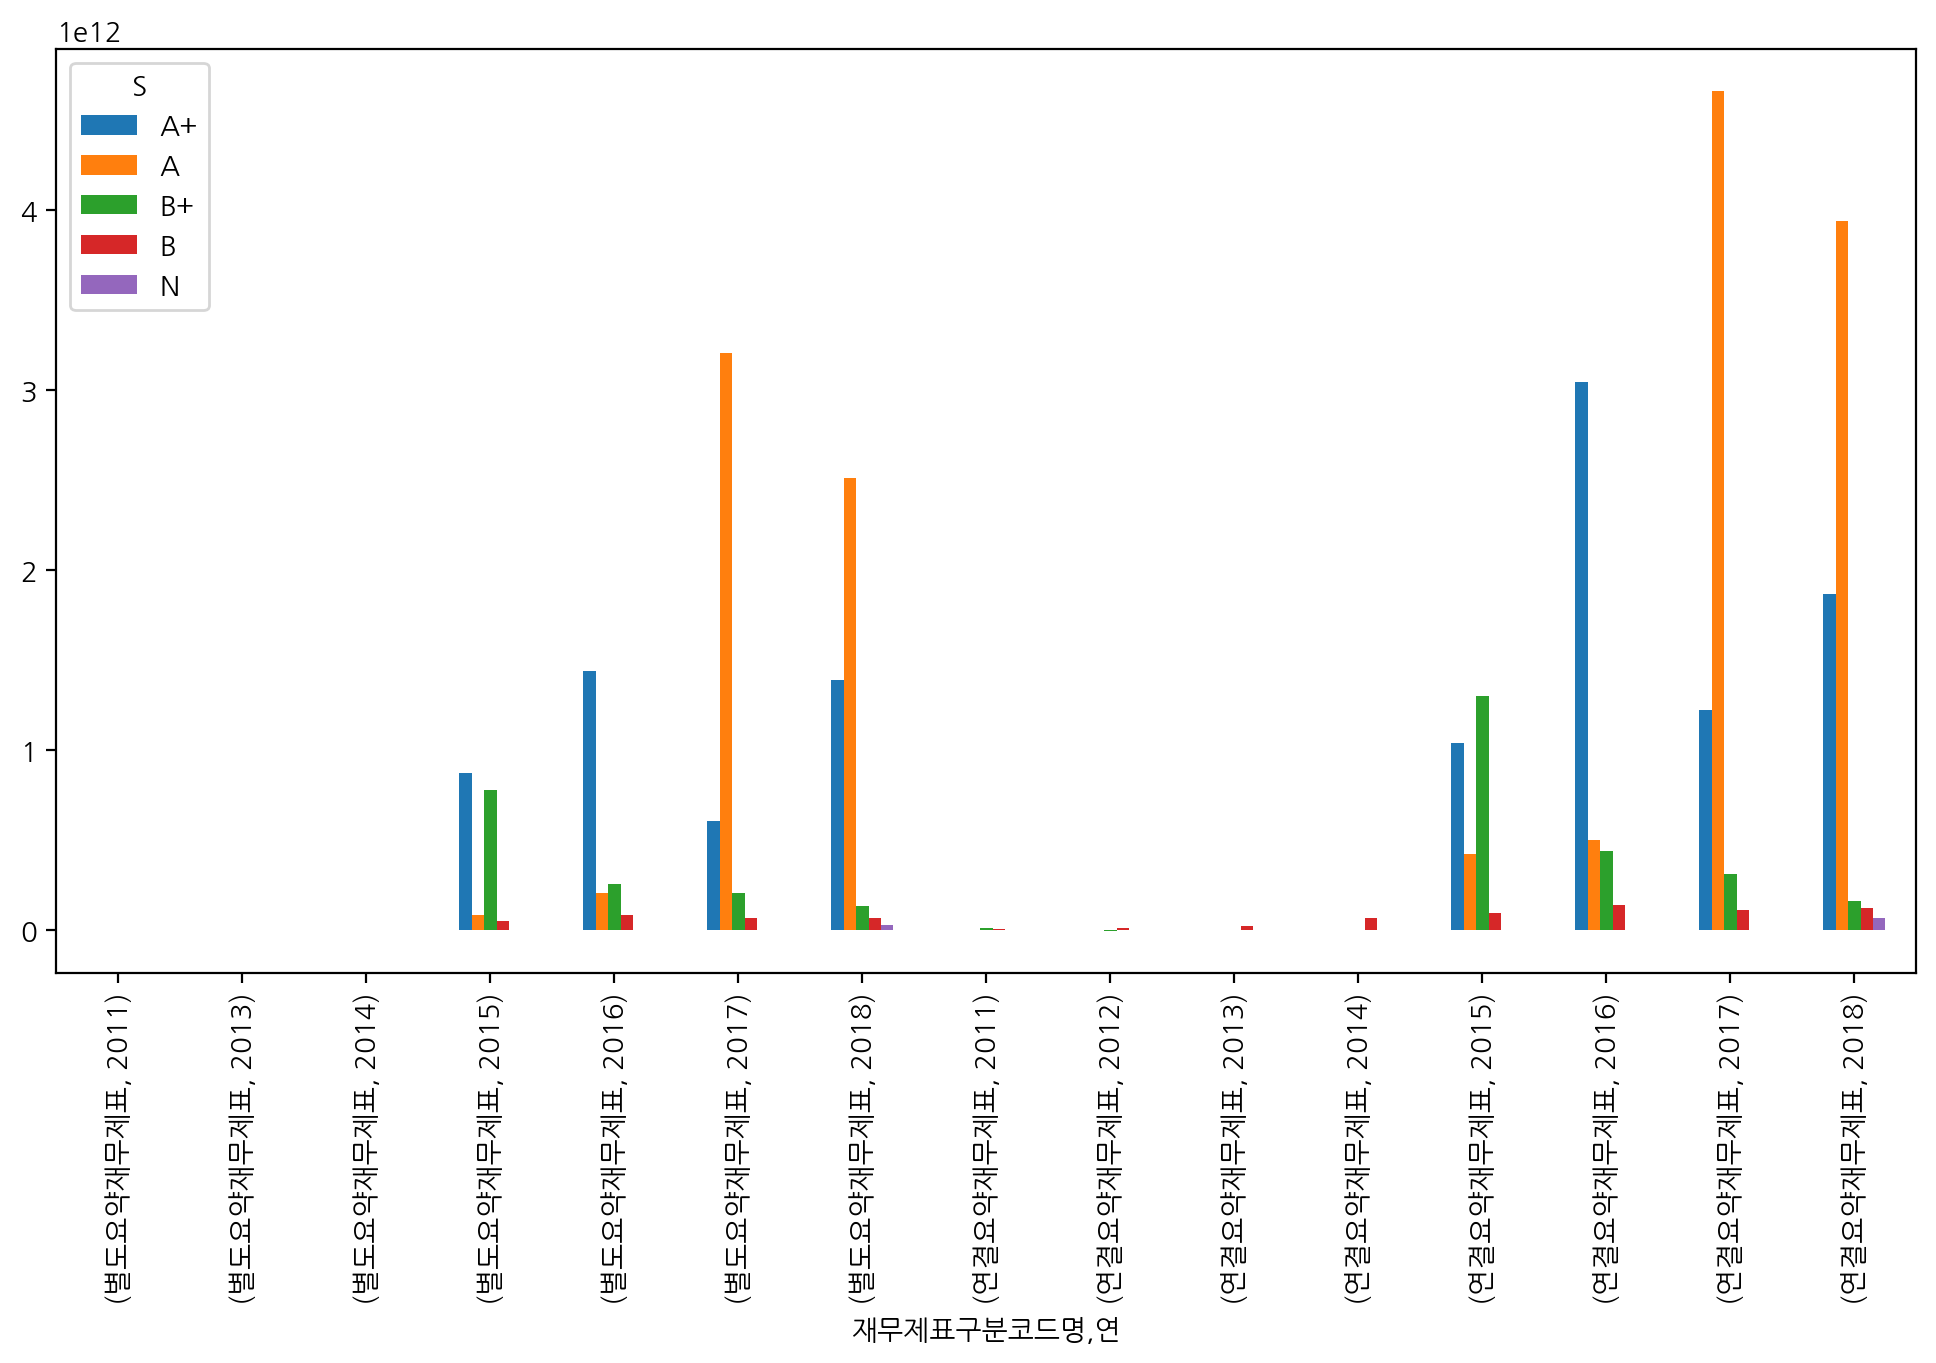

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업영업이익
G


G                              A+                  A                B+  \
재무제표구분코드명 연                                                              
별도요약재무제표  2011                NaN                NaN               NaN   
          2013                NaN                NaN               NaN   
          2014                NaN                NaN               NaN   
          2015 4843054868063.0000  198010979322.1923 272704848842.5555   
          2016 -250235564887.0000  840815006710.2354 241518310065.9565   
          2017  -50658652829.0000 2270618266259.4668 142998997803.1176   
          2018  593308573256.5000 2062840484363.4075 628339450173.9246   
연결요약재무제표  2011                NaN                NaN  11179000000.0000   
          2012                NaN                NaN  -5980000000.0000   
          2013                NaN                NaN               NaN   
          2014                NaN                NaN  73182666666.6667   
          2015 9321576479888.0000  473086510303.8461 381885316118.3726   
          2016   24399516934.0000 1731573122048.6470 337914610169.7045   
          2017  306203428562.0000 3450365457037.4136 199902298733.8958   
          2018  811858691524.0000 3172205767427.1538 744291328105.6200   

G                              B                 N  
재무제표구분코드명 연                                         
별도요약재무제표  2011               NaN      5922667.0000  
          2013  -2308079000.0000               NaN  
          2014            0.0000               NaN  
          2015  56647624191.4286               NaN  
          2016  68385716562.6100               NaN  
          2017  84237478458.3434               NaN  
          2018  70297956336.5053  26235717316.6667  
연결요약재무제표  2011  17198500000.0000 -20502000000.0000  
          2012  11917000000.0000               NaN  
          2013  23209500000.0000               NaN  
          2014  35199000000.0000               NaN  
          2015 110514093642.4691               NaN  
          2016 129253621662.5889               NaN  
          2017 183376629904.7912               NaN  
          2018 134041627385.3750  65785785715.6667

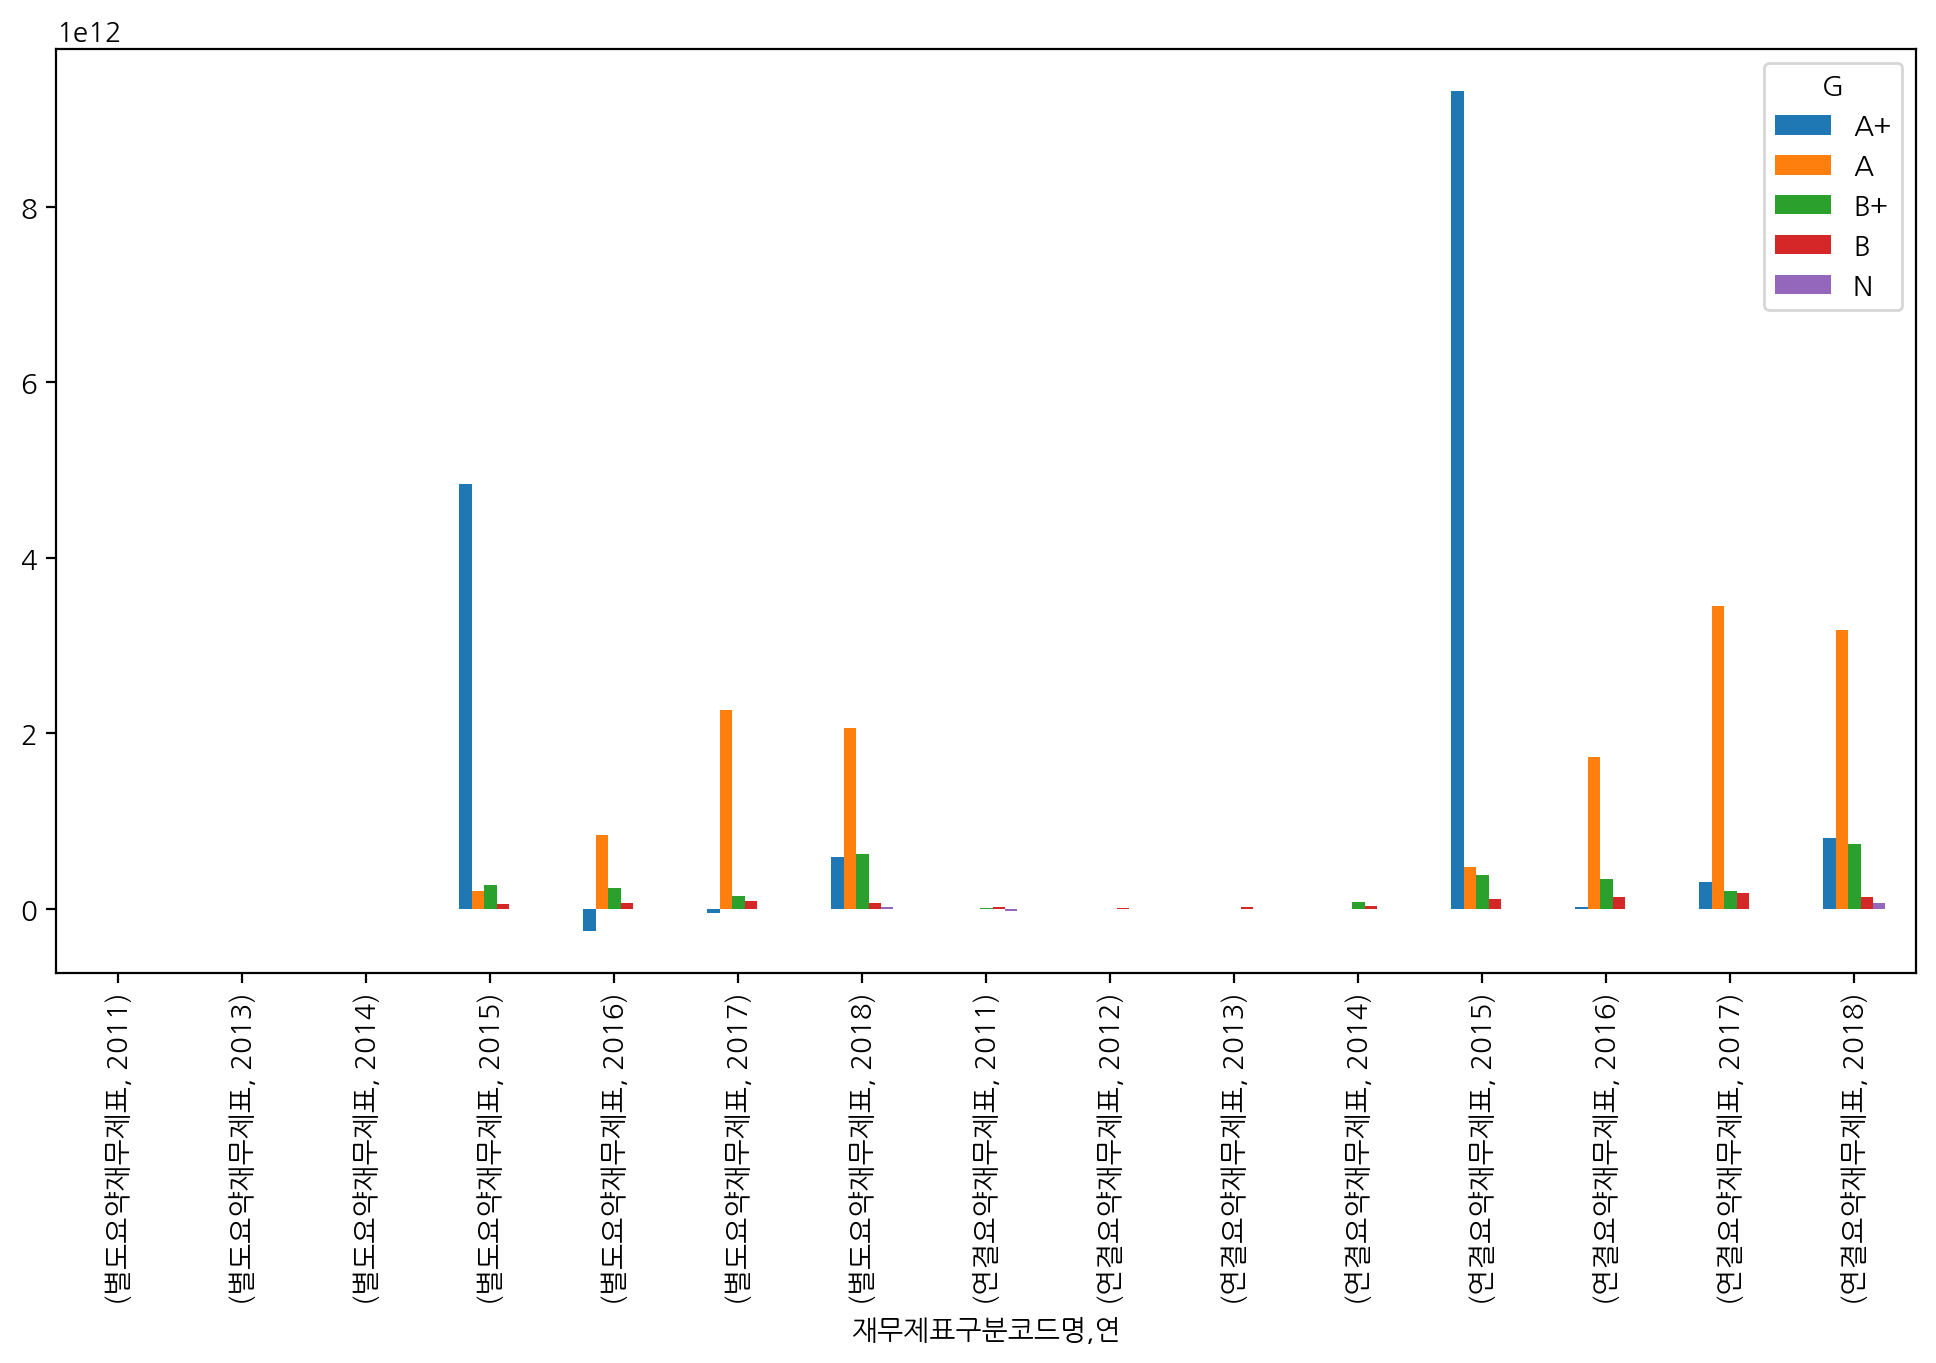

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액
ESG종합


ESG종합                          A+                  A                 B+  \
재무제표구분코드명 연                                                               
별도요약재무제표  2011                NaN                NaN                NaN   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN                NaN   
          2015                NaN 1729245503659.7693  303949520252.3243   
          2016  697635058589.0000 1514489103006.0769  242766008051.7174   
          2017  705932890838.0000 1488813455691.1875 1087597753539.4773   
          2018 1169069509004.0000 3268858651461.0435  225248917954.3488   
연결요약재무제표  2011                NaN                NaN  -11767000000.0000   
          2012                NaN                NaN  -13678000000.0000   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN   84311000000.0000   
          2015                NaN 2544646250653.1538  442881806068.7027   
          2016  565652780330.6666 3425986375811.1538  417223950528.8409   
          2017 3113531368601.3335 1977871030335.6875 1831406784303.7251   
          2018 3554718886414.5000 4439198889980.2275  364577317018.6097   

ESG종합                          B                N  
재무제표구분코드명 연                                        
별도요약재무제표  2011      3113883.0000              NaN  
          2013  -4027226000.0000              NaN  
          2014            0.0000              NaN  
          2015  96867925885.7581              NaN  
          2016  67760261467.7899              NaN  
          2017  91392914074.6186              NaN  
          2018  67376671453.7664 48534818099.6667  
연결요약재무제표  2011  -6506000000.0000              NaN  
          2012 -56995500000.0000              NaN  
          2013   6814500000.0000              NaN  
          2014 -58795000000.0000              NaN  
          2015 148166036160.1802              NaN  
          2016 110240164397.0459              NaN  
          2017 144473369343.2182              NaN  
          2018 108403141139.5152 75623753990.0000

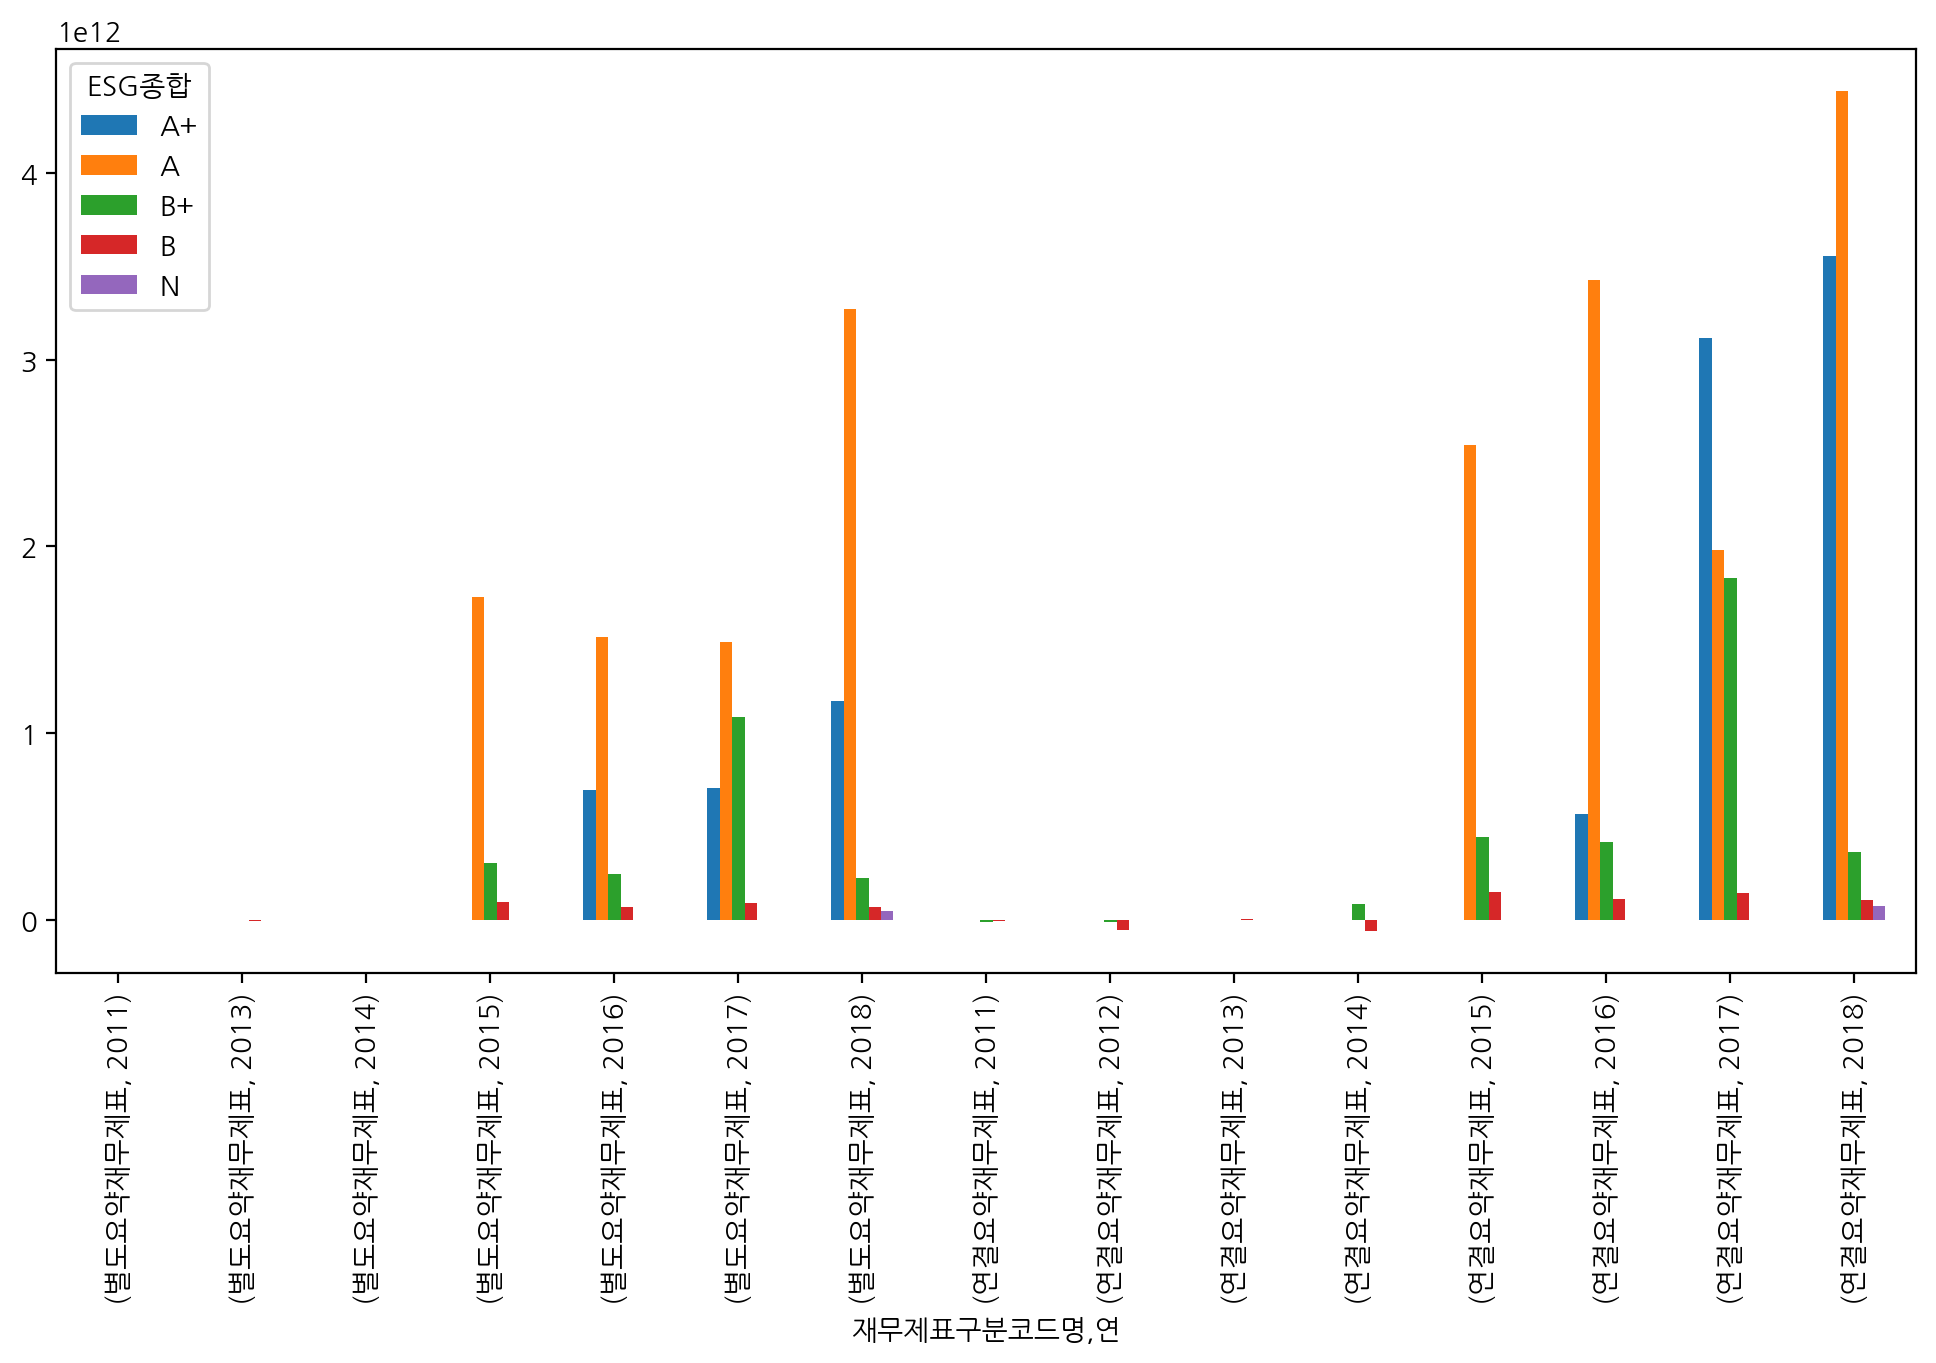

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액
E


E                              A+                  A                 B+  \
재무제표구분코드명 연                                                               
별도요약재무제표  2011                NaN                NaN                NaN   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN                NaN   
          2015                NaN  821458804715.4546  653304197317.2000   
          2016  436479640941.7500  671752040318.1111  597140435583.4412   
          2017 1145698000000.0000 1469117475611.0833  289432986292.9259   
          2018 1041970333333.3334  562749879937.0834 1444642002379.2727   
연결요약재무제표  2011                NaN                NaN                NaN   
          2012                NaN                NaN                NaN   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN   84311000000.0000   
          2015                NaN  746301647366.1818 1056094365119.6177   
          2016 1030084316248.0000 1250148299426.8889 1238463671244.1250   
          2017 4543523000000.0000 2306201143996.8184  424991874738.5686   
          2018 3945379333333.3335 1042252381782.4546 1894011629261.3333   

E                              B                 C                 D  
재무제표구분코드명 연                                                           
별도요약재무제표  2011      3113883.0000               NaN               NaN  
          2013  -4027226000.0000               NaN               NaN  
          2014               NaN            0.0000               NaN  
          2015  84129185558.6522 109784361599.1250 627804931892.3334  
          2016 114219408770.8228  73096344739.8936  57330970969.3750  
          2017 587125922034.7733 143843882327.6667  84691423815.7500  
          2018  65827296930.5811  83403114997.9333  32184279767.1667  
연결요약재무제표  2011 -16041000000.0000  16838000000.0000               NaN  
          2012 -14722500000.0000 -98224000000.0000               NaN  
          2013               NaN   6814500000.0000               NaN  
          2014               NaN -58795000000.0000               NaN  
          2015 160733010820.8333 190145997904.6923 566339755356.0000  
          2016 202169601866.5000 144800798779.5000  84857131094.0000  
          2017 973104338748.3623 205148165991.3929 139585046756.2500  
          2018 120243716295.9242 131142586739.1035  78490147847.3333

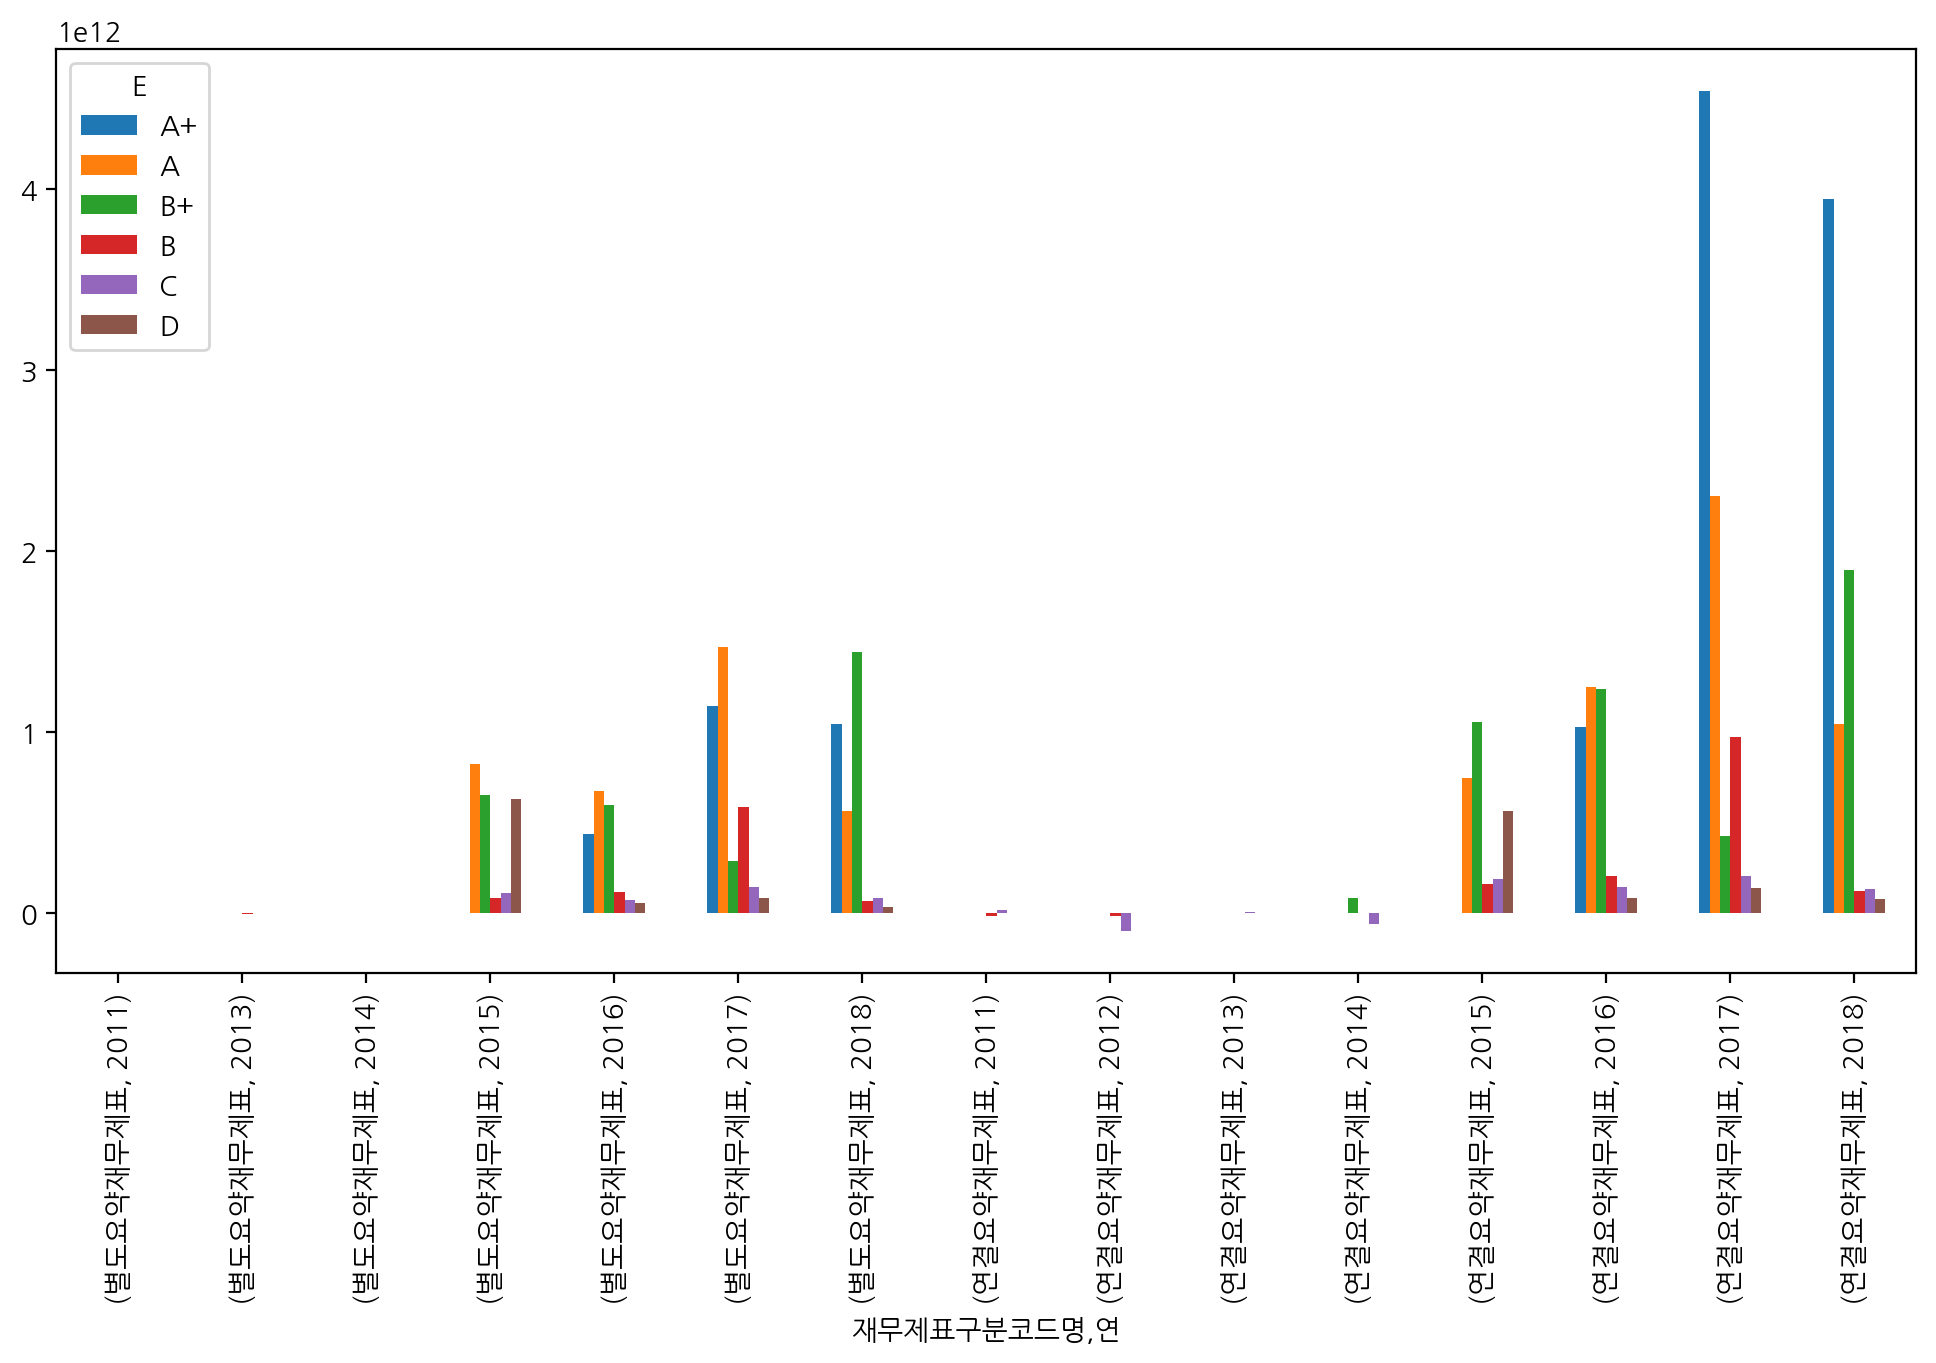

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액
S


S                              A+                  A                 B+  \
재무제표구분코드명 연                                                               
별도요약재무제표  2011                NaN                NaN                NaN   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN                NaN   
          2015  805218341363.0000  430550901944.1875  786042173832.4359   
          2016 1566715806803.7334  196590602025.0909  165741002432.9643   
          2017  579049295481.2354 3316297739481.1665  171564887412.5000   
          2018 1471396543769.5217 2498965990926.4287  125940557181.8235   
연결요약재무제표  2011                NaN                NaN  -11767000000.0000   
          2012                NaN                NaN  -13678000000.0000   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN                NaN   
          2015  959625174296.6666  444554453911.8125 1252014086461.7368   
          2016 3091437331174.4668  291904283588.5000  338762185057.2745   
          2017 1289386292900.5000 4798353242832.6670  307075912780.7561   
          2018 2030472161649.5908 4125876590272.2632  152842230585.2000   

S                              B                N  
재무제표구분코드명 연                                        
별도요약재무제표  2011      3113883.0000              NaN  
          2013  -4027226000.0000              NaN  
          2014            0.0000              NaN  
          2015  49808899759.3621              NaN  
          2016  61285264033.4747              NaN  
          2017  71482968252.9800              NaN  
          2018  48922678107.1098 48534818099.6667  
연결요약재무제표  2011  -6506000000.0000              NaN  
          2012 -56995500000.0000              NaN  
          2013   6814500000.0000              NaN  
          2014 -23018500000.0000              NaN  
          2015  80242077171.0385              NaN  
          2016 107971384168.3978              NaN  
          2017 112172564996.5000              NaN  
          2018  91422370600.9867 75623753990.0000

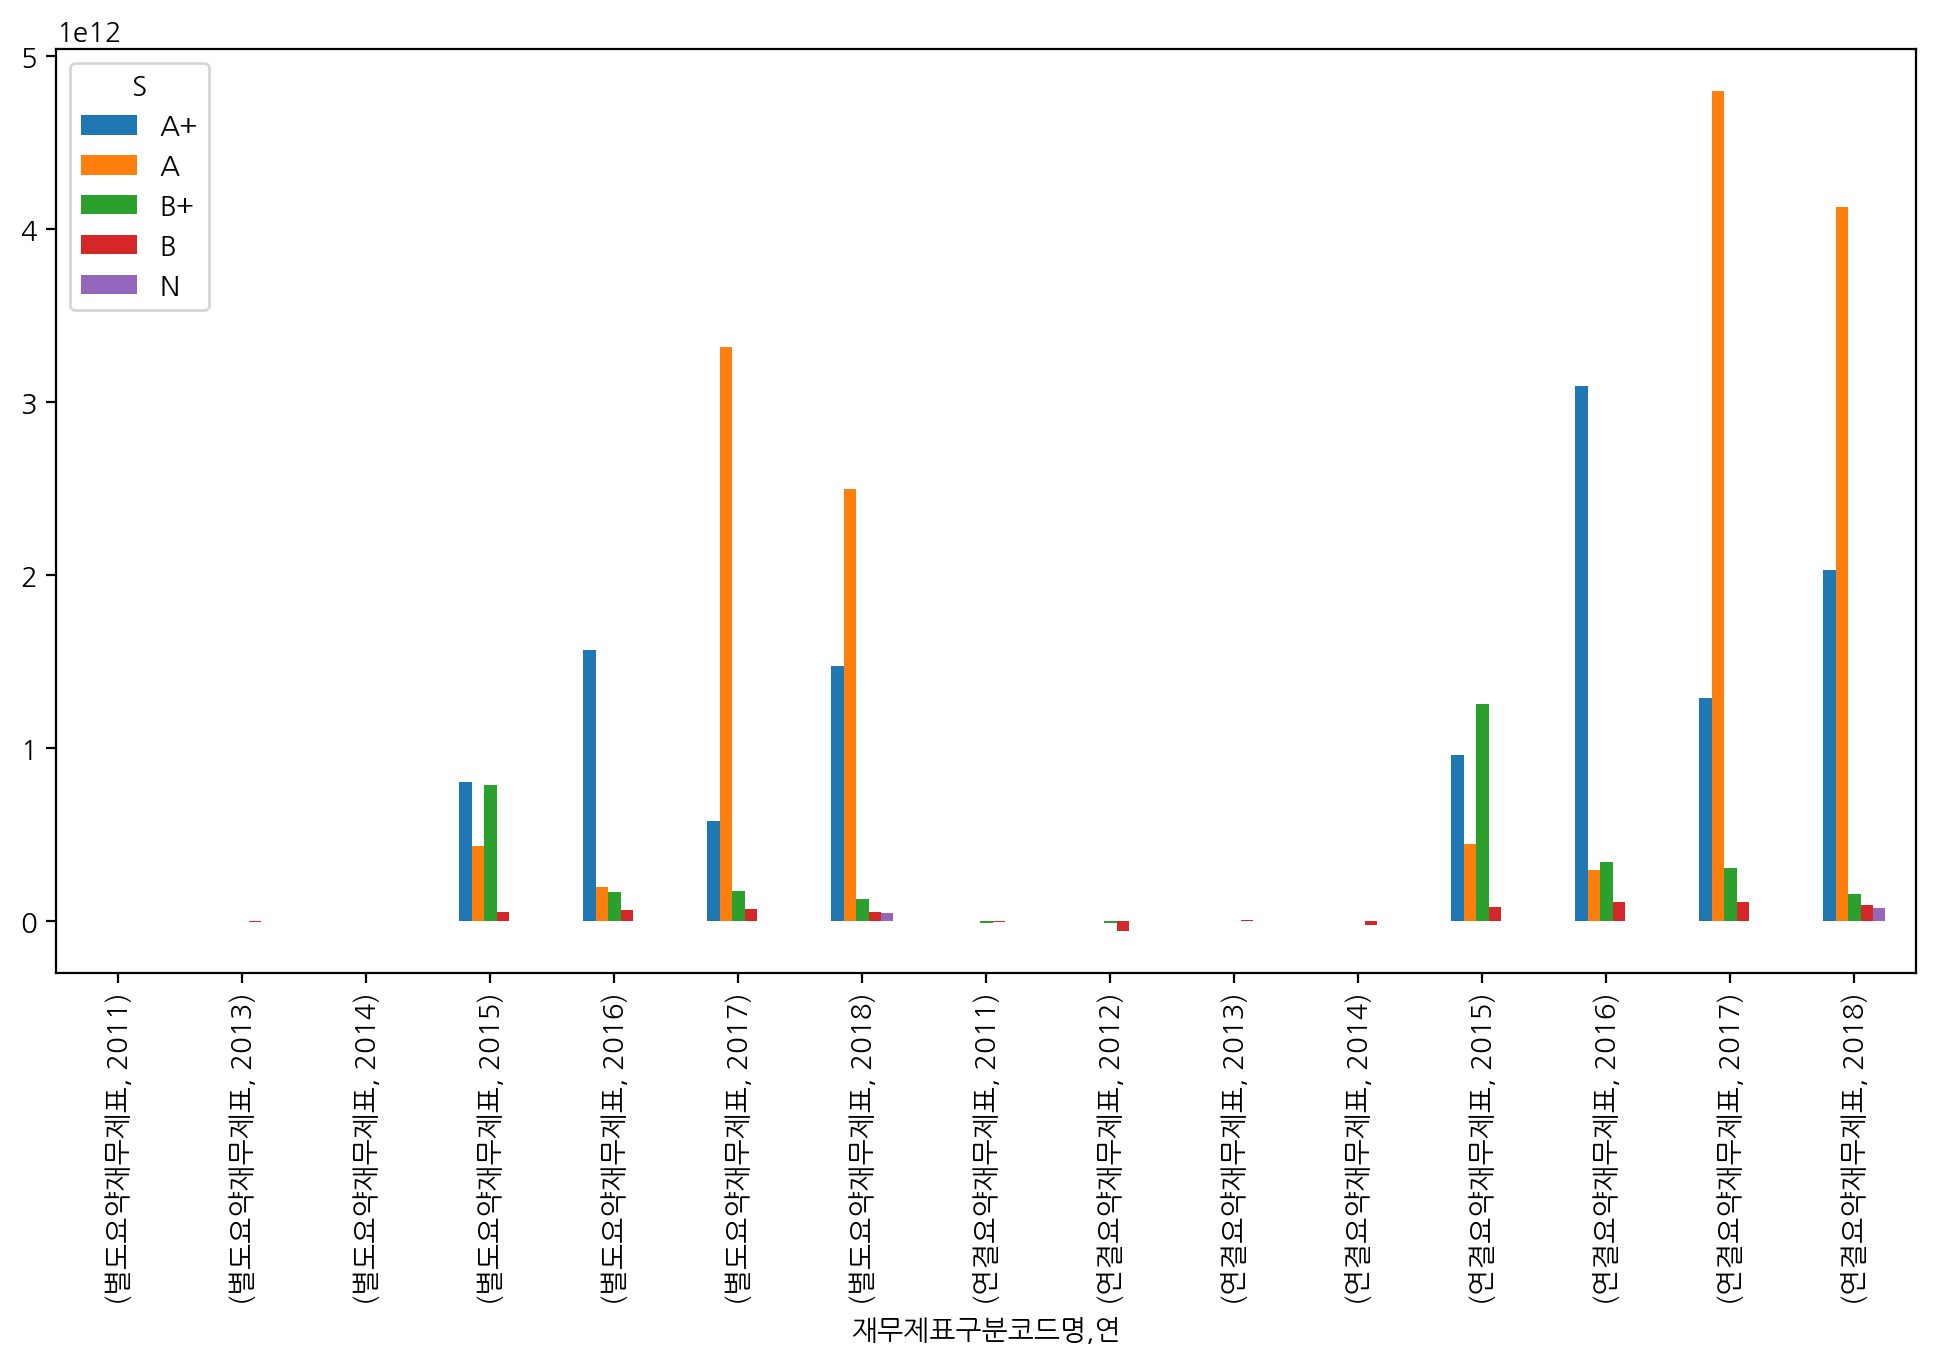

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액
G


G                              A+                  A                B+  \
재무제표구분코드명 연                                                              
별도요약재무제표  2011                NaN                NaN               NaN   
          2013                NaN                NaN               NaN   
          2014                NaN                NaN               NaN   
          2015 5101188160111.6670  334958536229.6539 310757793294.0555   
          2016 -103297905688.0000  699983376351.7941 234983455977.6956   
          2017 -173597327486.0000 2287168608263.2666 137667907436.2745   
          2018  997710530192.0000 2094445762708.3333 589390919315.8302   
연결요약재무제표  2011                NaN                NaN -11767000000.0000   
          2012                NaN                NaN -13678000000.0000   
          2013                NaN                NaN               NaN   
          2014                NaN                NaN -40270333333.3333   
          2015 9140473886075.0000  395950571437.1539 408415335281.3726   
          2016   32082609343.0000 1550891941476.4707 285460047060.4545   
          2017  253548105804.0000 3577881787346.5171 186261159236.8542   
          2018 1425652303461.5000 3395476045613.6924 700197555676.3400   

G                              B                 N  
재무제표구분코드명 연                                         
별도요약재무제표  2011               NaN      3113883.0000  
          2013  -4027226000.0000               NaN  
          2014            0.0000               NaN  
          2015  54335597214.9670               NaN  
          2016  65065951346.4500               NaN  
          2017  92070250307.6061               NaN  
          2018  73387989052.2316  48534818099.6667  
연결요약재무제표  2011   2646000000.0000 -24810000000.0000  
          2012 -56995500000.0000               NaN  
          2013   6814500000.0000               NaN  
          2014  28737000000.0000               NaN  
          2015  90964684961.3827               NaN  
          2016 125401803098.6778               NaN  
          2017 188815571525.8901               NaN  
          2018 129741733171.6136  75623753990.0000

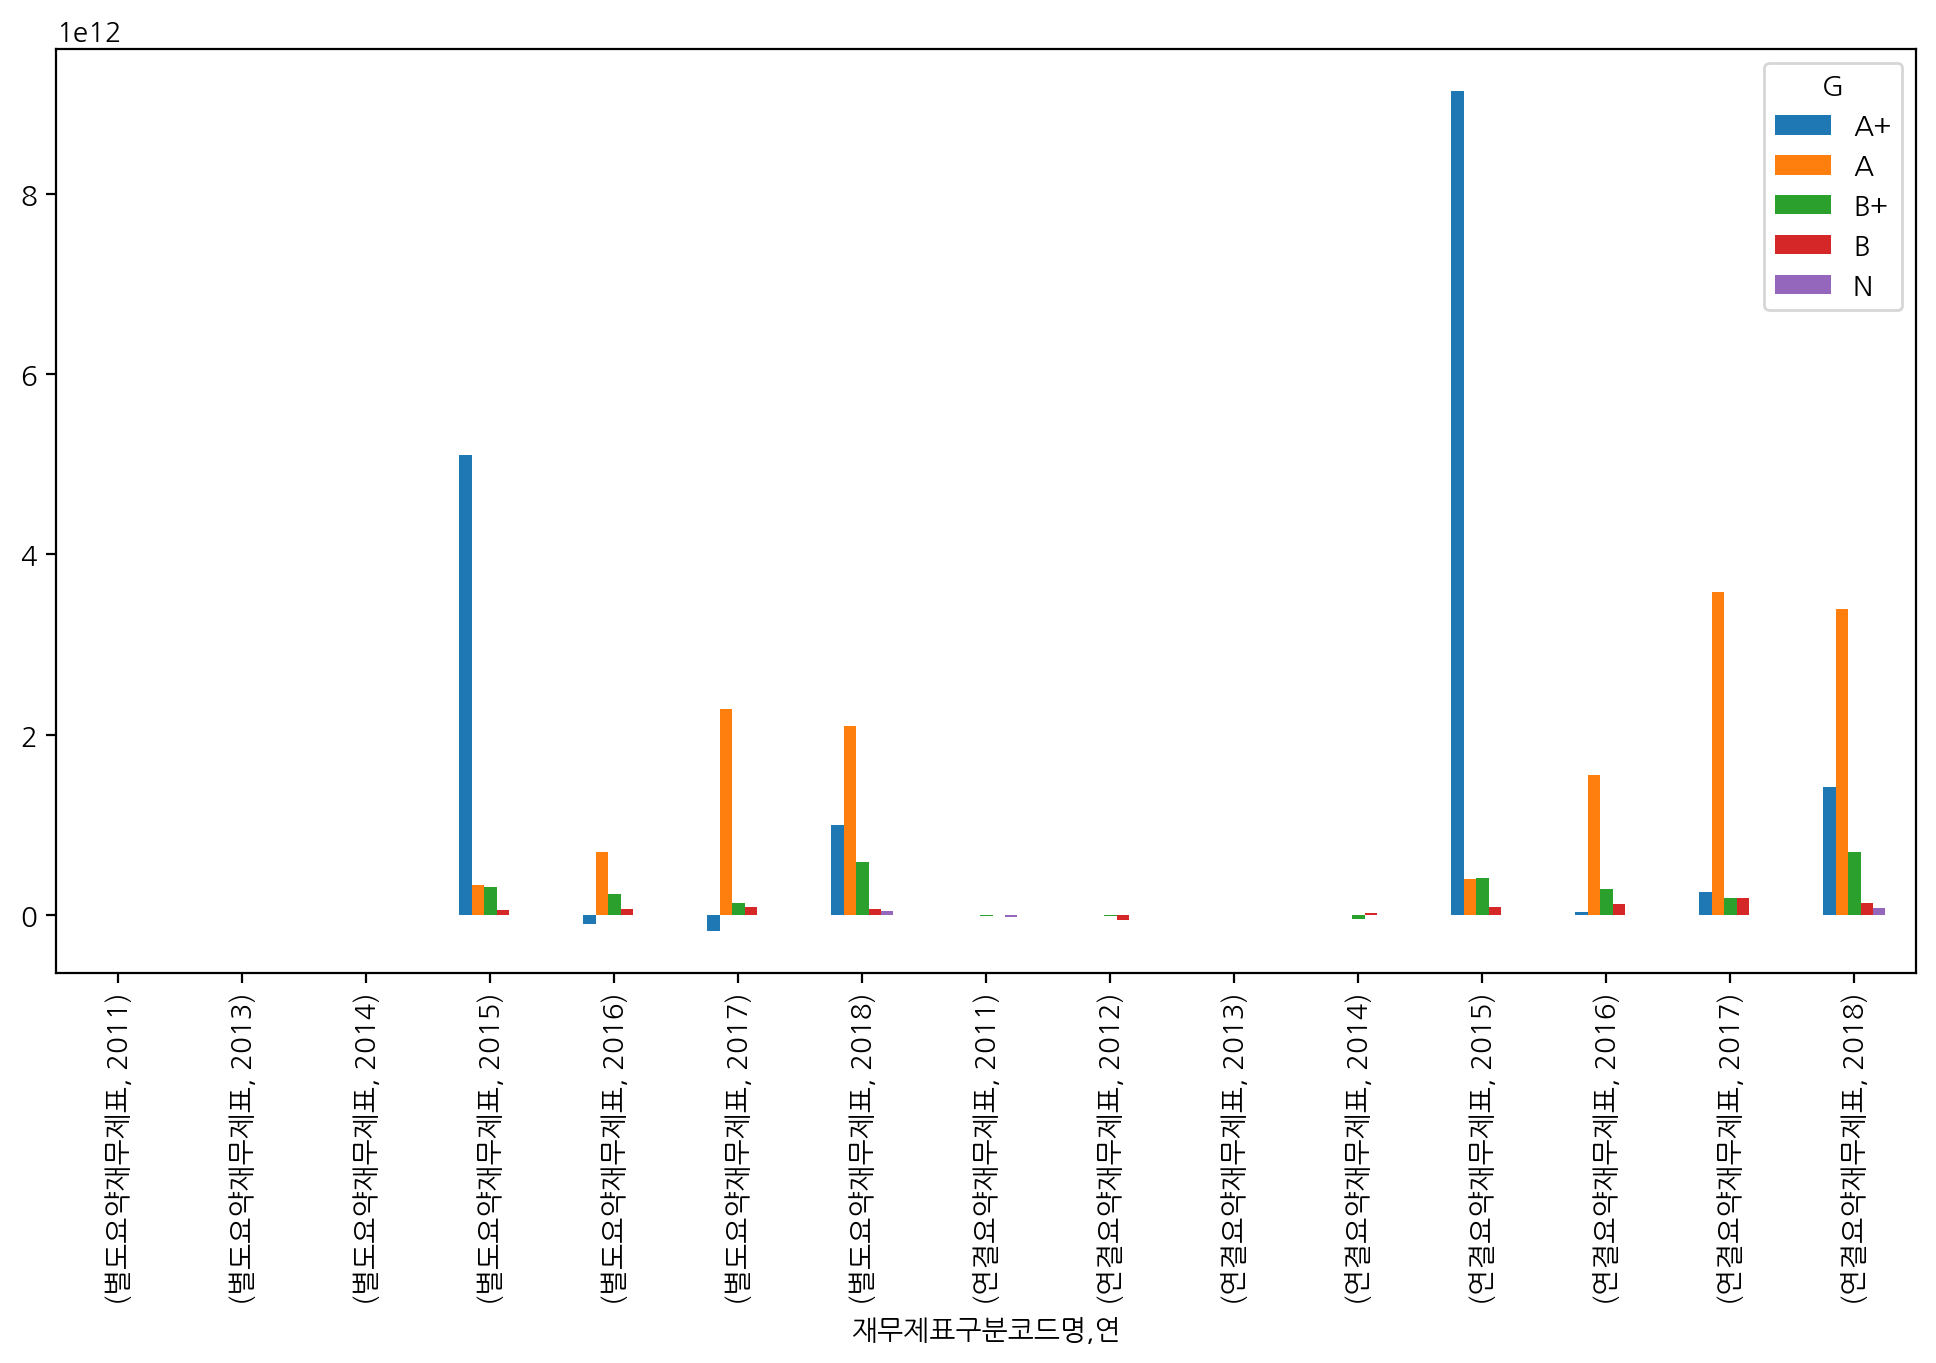

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업당기순이익
ESG종합


ESG종합                          A+                  A                 B+  \
재무제표구분코드명 연                                                               
별도요약재무제표  2011                NaN                NaN                NaN   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN                NaN   
          2015                NaN 1454077518303.2307  257901178616.2433   
          2016  517618273235.3333 1236721805496.7693  158287865574.5217   
          2017  564182436566.6666 1162879901248.6250  867700703283.0909   
          2018  955921658185.0000 2337338360105.3911  192002934180.0930   
연결요약재무제표  2011                NaN                NaN  -11578000000.0000   
          2012                NaN                NaN  -11927000000.0000   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN   44942000000.0000   
          2015                NaN 1492462825570.0000  363682517572.5676   
          2016  416373428543.0000 2544838860323.1538  289140905481.7273   
          2017 2163408998125.0000 1510267344711.8125 1381197318392.5750   
          2018 2822351885852.0000 3102421677761.3184  296575357534.2195   

ESG종합                          B                N  
재무제표구분코드명 연                                        
별도요약재무제표  2011      1975802.0000              NaN  
          2013  14352687000.0000              NaN  
          2014            0.0000              NaN  
          2015  75404859010.0645              NaN  
          2016  53913983593.3277              NaN  
          2017 126722838116.2881              NaN  
          2018  78563086524.4299 43208800449.3333  
연결요약재무제표  2011  -5341333333.3333              NaN  
          2012 -53568000000.0000              NaN  
          2013   3374000000.0000              NaN  
          2014 -88844333333.3333              NaN  
          2015 102673395266.4865              NaN  
          2016  78790560392.4495              NaN  
          2017 153441835078.6454              NaN  
          2018 104055445152.0808 76487835247.3333

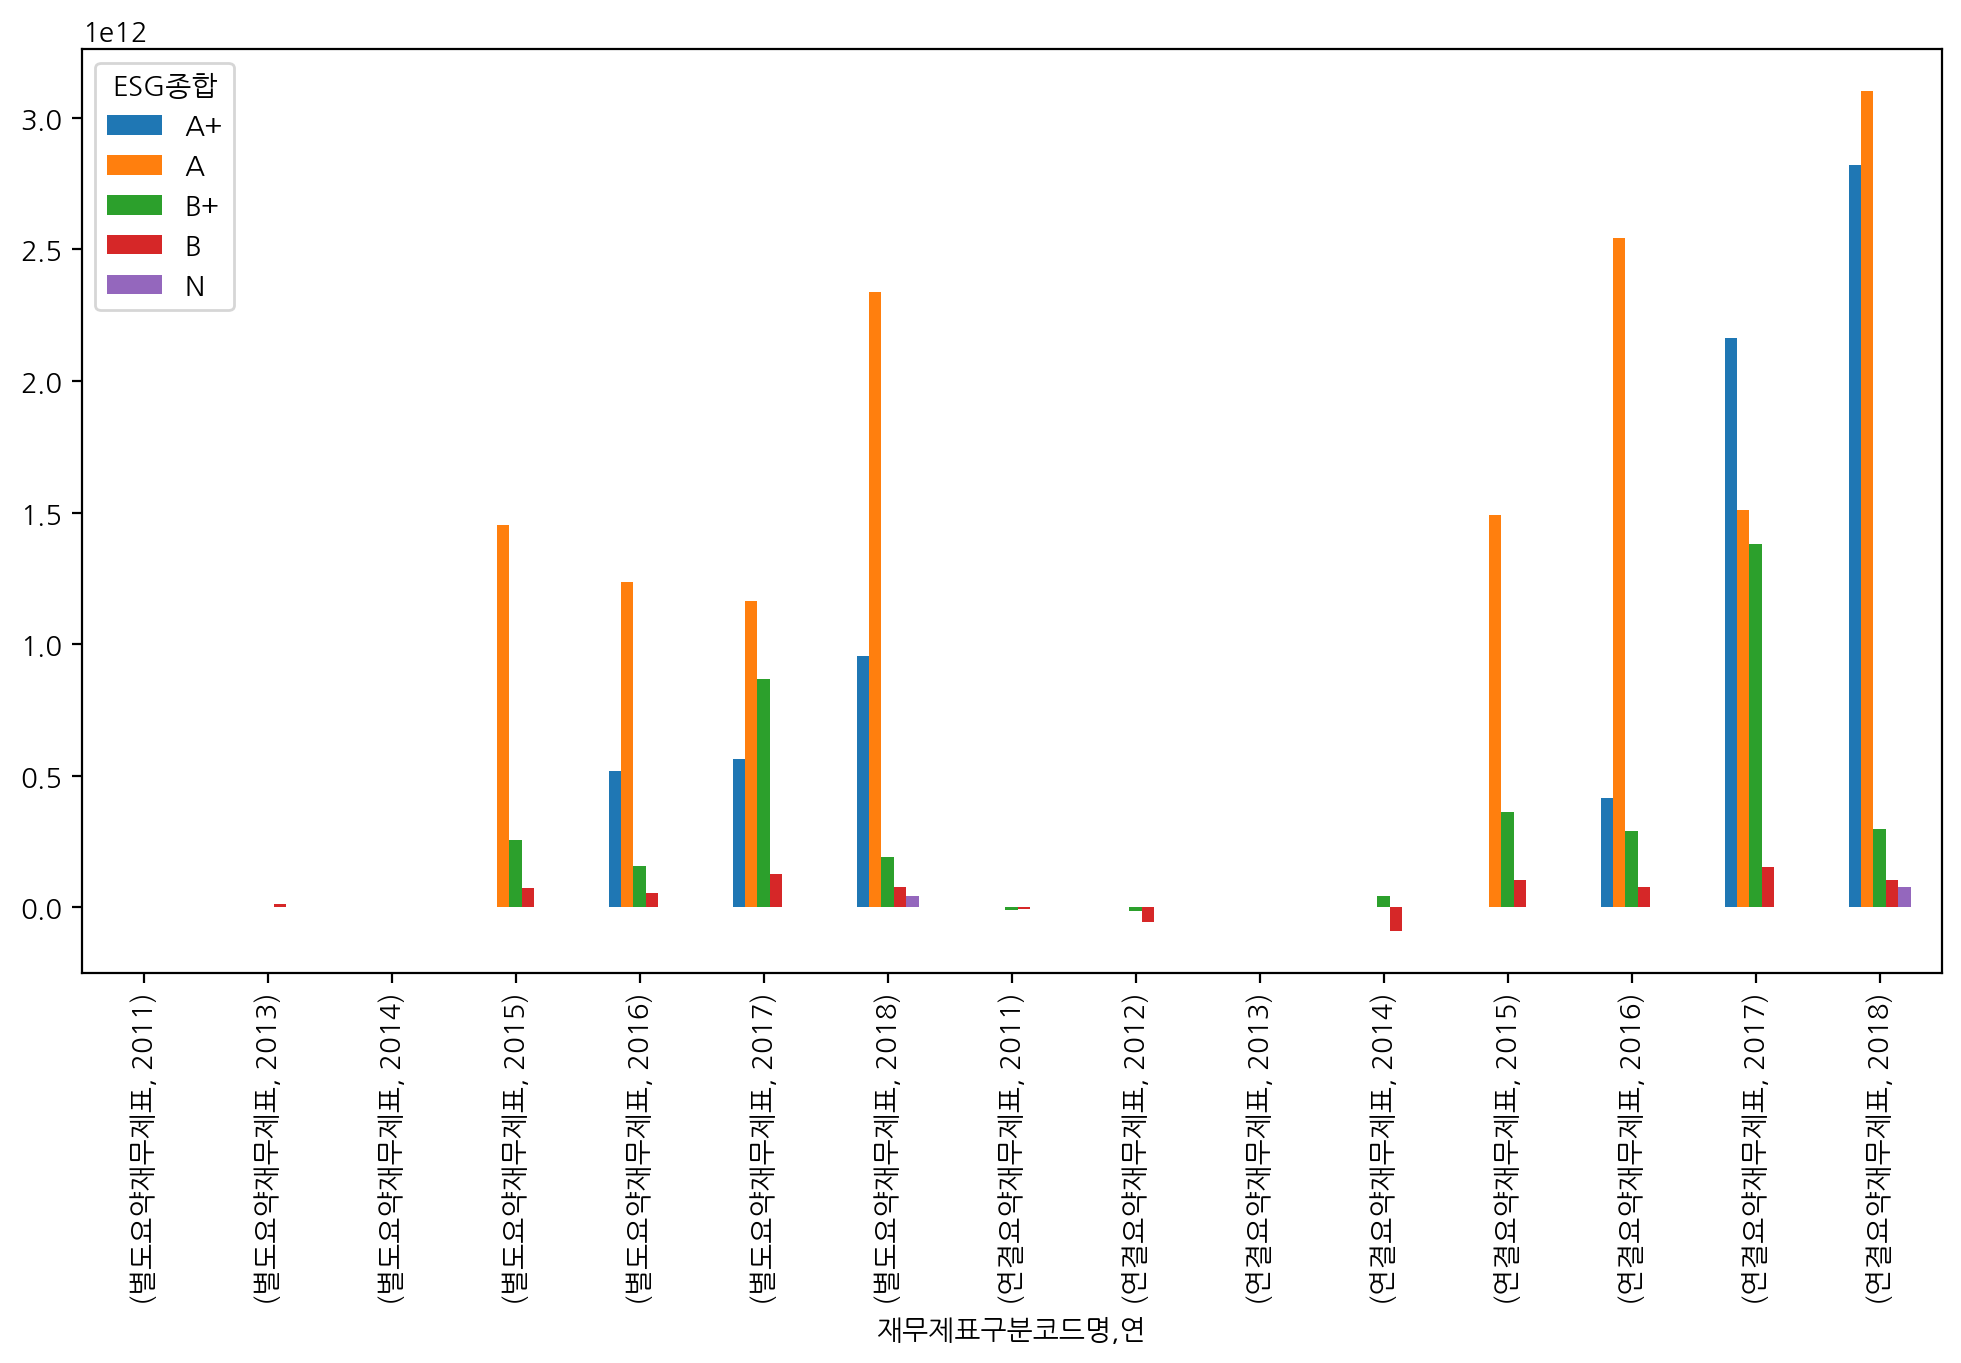

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업당기순이익
E


E                              A+                  A                 B+  \
재무제표구분코드명 연                                                               
별도요약재무제표  2011                NaN                NaN                NaN   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN                NaN   
          2015                NaN  712949457254.2727  529713722845.7143   
          2016  302163902676.5000  566520609166.1111  487916924628.7059   
          2017  930638500000.0000 1158678264920.6667  239124806570.7037   
          2018  880436666666.6666  285286420652.9167 1087036437146.9091   
연결요약재무제표  2011                NaN                NaN                NaN   
          2012                NaN                NaN                NaN   
          2013                NaN                NaN                NaN   
          2014                NaN                NaN   44942000000.0000   
          2015                NaN   68651719588.5455  802522555361.7354   
          2016  742638643657.2500  964374683164.4445  947772636076.9375   
          2017 3156485500000.0000 1734455820440.3635  330414327700.0980   
          2018 3180388000000.0000  566346713235.5454 1377939686630.0186   

E                              B                 C                 D  
재무제표구분코드명 연                                                           
별도요약재무제표  2011      1975802.0000               NaN               NaN  
          2013  14352687000.0000               NaN               NaN  
          2014               NaN            0.0000               NaN  
          2015  74067262893.9565  77220590660.1607 659378439314.0000  
          2016  87671402658.6582  26644400077.6596  31550001367.1250  
          2017 518129384302.2534 175875887412.9000  77076924116.7500  
          2018  48564106759.8108 159282706105.5333  25082595010.5000  
연결요약재무제표  2011 -13460000000.0000  12778000000.0000               NaN  
          2012 -16468000000.0000 -86127000000.0000               NaN  
          2013               NaN   3374000000.0000               NaN  
          2014               NaN -88844333333.3333               NaN  
          2015 126570850370.5333 125677131638.9423 521154772986.2500  
          2016 138941612305.4445  75692855350.0227  41182949354.8750  
          2017 790501352498.7826 181867449388.2143 112625182660.3750  
          2018  87673317977.8333 205902242067.0000  49316959794.3333

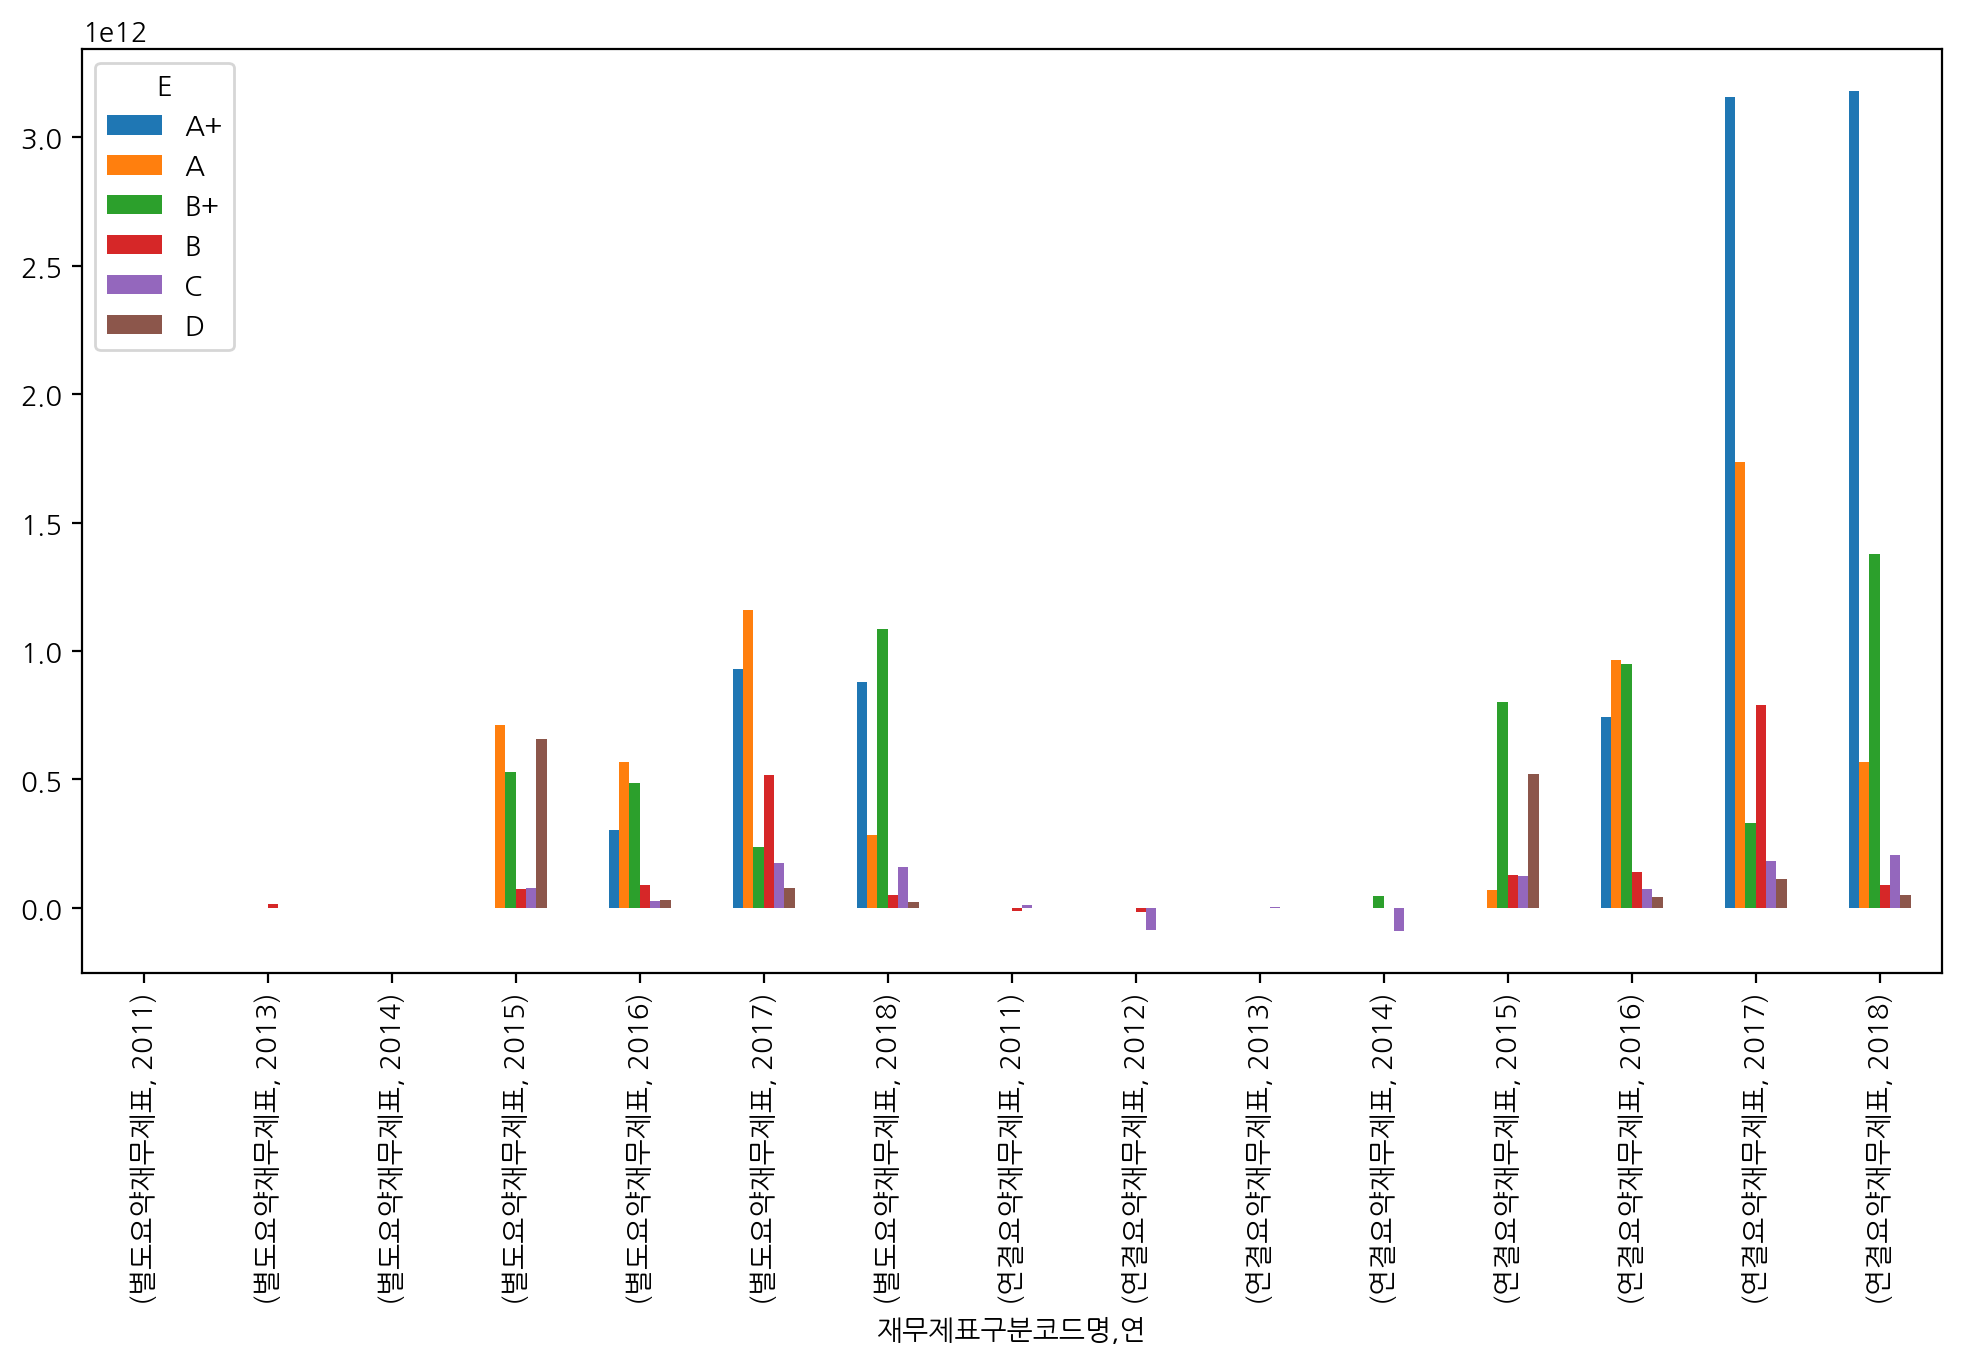

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업당기순이익
S


S                              A+                  A                B+  \
재무제표구분코드명 연                                                              
별도요약재무제표  2011                NaN                NaN               NaN   
          2013                NaN                NaN               NaN   
          2014                NaN                NaN               NaN   
          2015  601481095401.6666  350207174119.1250 656883319409.0513   
          2016 1216390458478.1333  230507144730.3636 103740486942.3393   
          2017  444289430549.6470 2862531359501.6665 127528581932.2174   
          2018 1026254232523.2174 1859552768158.9048 167633357176.0392   
연결요약재무제표  2011                NaN                NaN -11578000000.0000   
          2012                NaN                NaN -11927000000.0000   
          2013                NaN                NaN               NaN   
          2014                NaN                NaN               NaN   
          2015  697446513586.3334   38902209590.6875 944958952808.3422   
          2016 2233493267473.2666  314707925347.2000 230385360629.9608   
          2017  924660028415.0625 3818660653615.5557 233660161091.7073   
          2018 1407925619898.8635 3017063305076.2632 189203048984.1400   

S                              B                N  
재무제표구분코드명 연                                        
별도요약재무제표  2011      1975802.0000              NaN  
          2013  14352687000.0000              NaN  
          2014            0.0000              NaN  
          2015  41115054611.4397              NaN  
          2016  47841832497.1818              NaN  
          2017  84859520126.0000              NaN  
          2018  37086446922.8415 43208800449.3333  
연결요약재무제표  2011  -5341333333.3333              NaN  
          2012 -53568000000.0000              NaN  
          2013   3374000000.0000              NaN  
          2014 -55397750000.0000              NaN  
          2015  54151939002.3846              NaN  
          2016  77884567054.8817              NaN  
          2017 102877449783.3723              NaN  
          2018  56600590662.4667 76487835247.3333

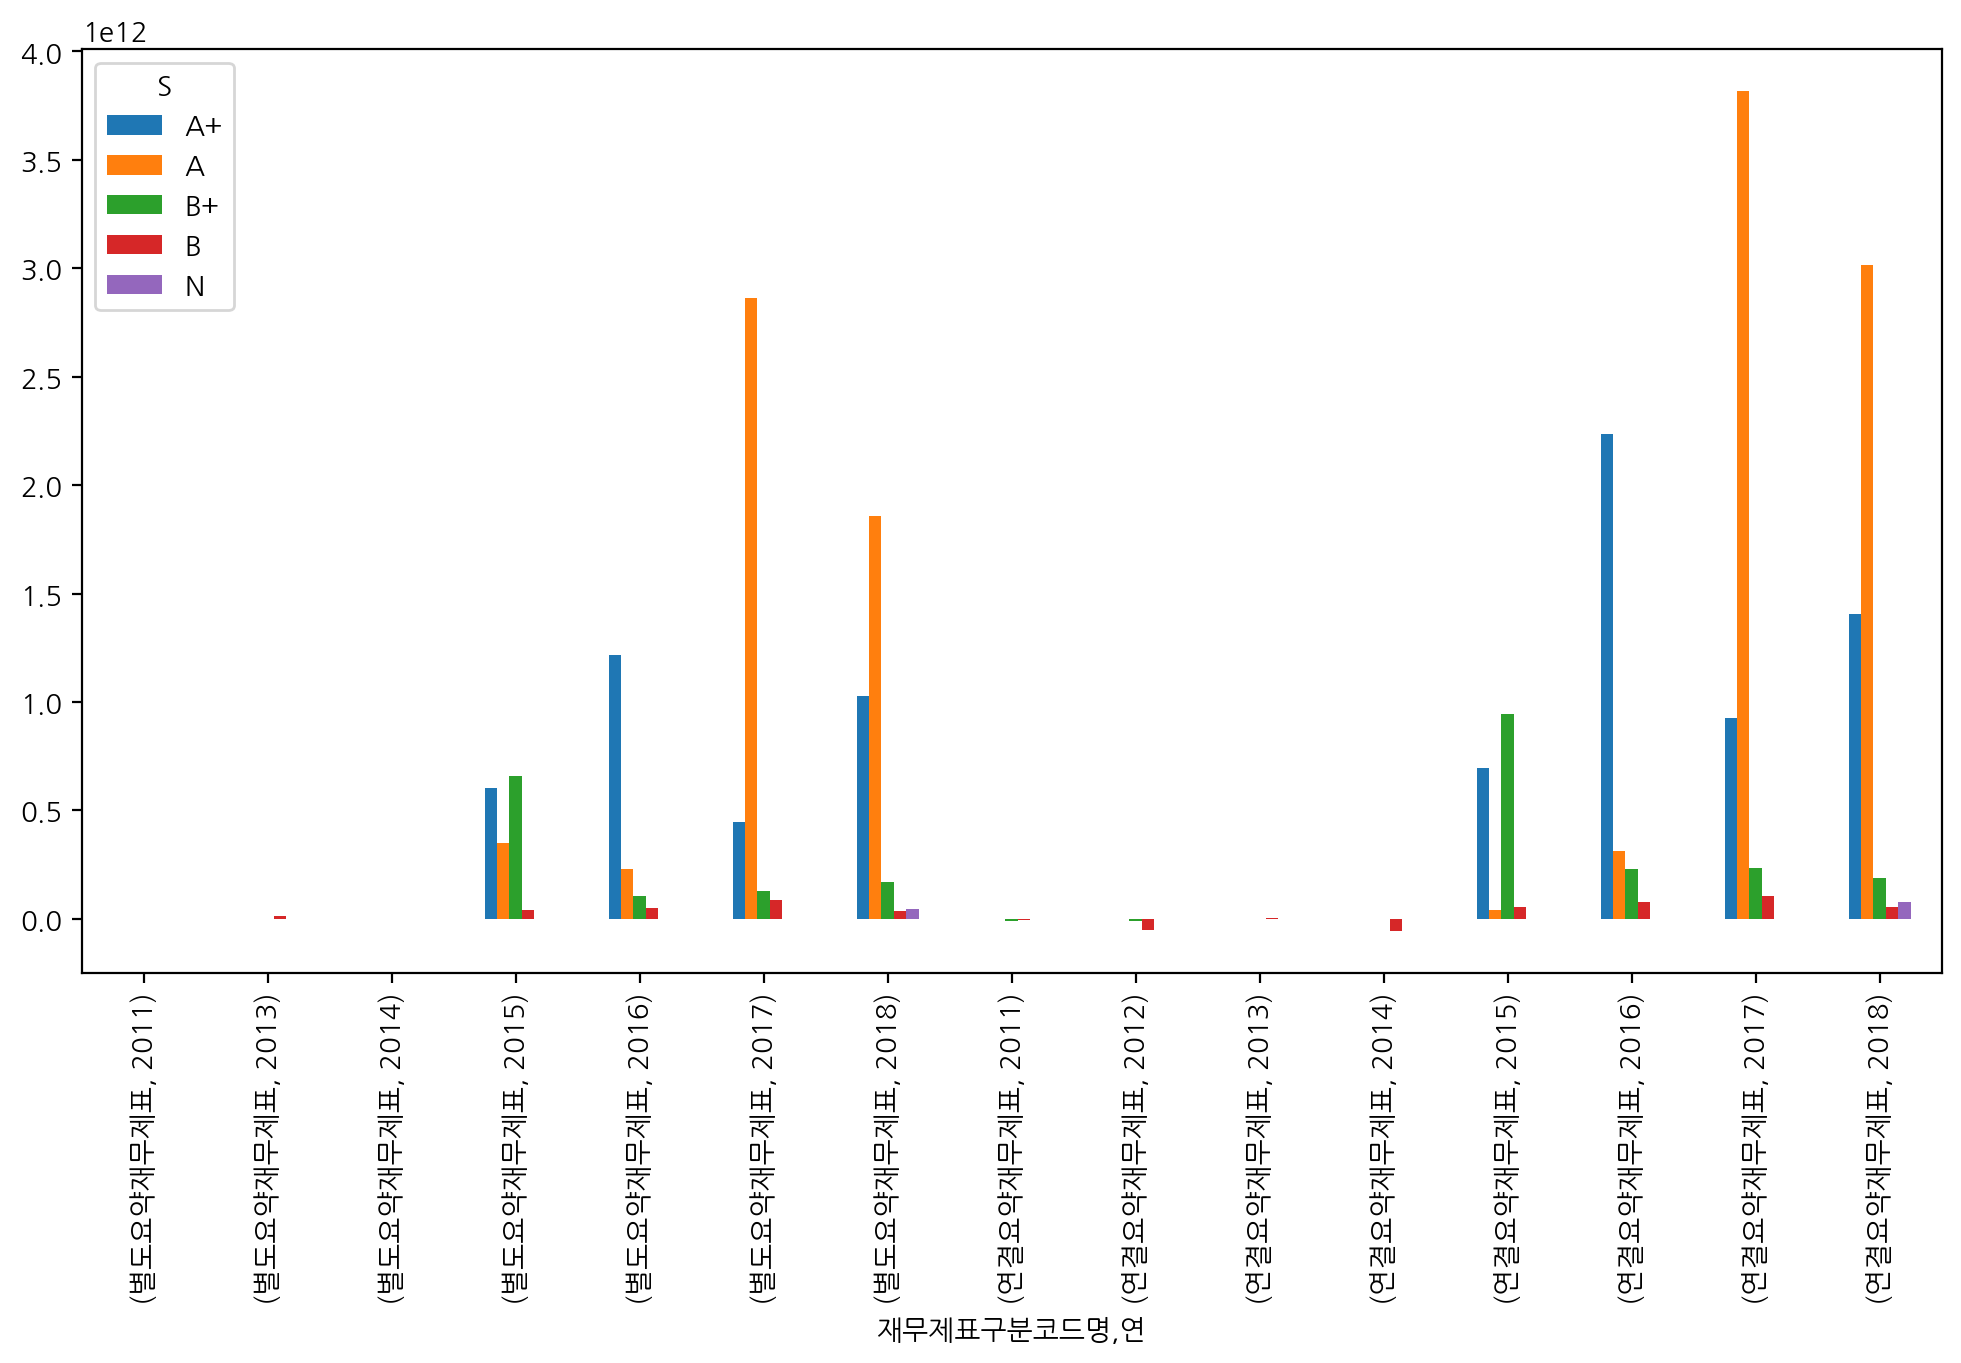

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업당기순이익
G


G                              A+                  A                B+  \
재무제표구분코드명 연                                                              
별도요약재무제표  2011                NaN                NaN               NaN   
          2013                NaN                NaN               NaN   
          2014                NaN                NaN               NaN   
          2015 4322293472253.6665  295600762890.1154 249149400413.6667   
          2016  -63793094643.0000  514214811288.1177 190377613082.5869   
          2017 -168729690300.0000 1785894399580.6667 103425799878.2549   
          2018  757327110733.0000 1559768612754.9629 464744040124.7547   
연결요약재무제표  2011                NaN                NaN -11578000000.0000   
          2012                NaN                NaN -11927000000.0000   
          2013                NaN                NaN               NaN   
          2014                NaN                NaN -79734333333.3333   
          2015 6692161753684.0000  104946413283.8462 315587654637.9608   
          2016   22914358716.0000 1099894884373.6470 229661159154.1364   
          2017  177255994375.0000 2657861935323.0000 131756459439.3958   
          2018 1049027516258.5000 2476634463900.8076 540210404384.1200   

G                              B                 N  
재무제표구분코드명 연                                         
별도요약재무제표  2011               NaN      1975802.0000  
          2013  14352687000.0000               NaN  
          2014            0.0000               NaN  
          2015  40538307579.6593               NaN  
          2016  51503634642.4600               NaN  
          2017 148969025060.0505               NaN  
          2018  63000046848.0000  43208800449.3333  
연결요약재무제표  2011   1455000000.0000 -18934000000.0000  
          2012 -53568000000.0000               NaN  
          2013   3374000000.0000               NaN  
          2014  17612000000.0000               NaN  
          2015  66110547706.2593               NaN  
          2016  90199610706.6778               NaN  
          2017 211004801453.6813               NaN  
          2018  96621498522.4091  76487835247.3333

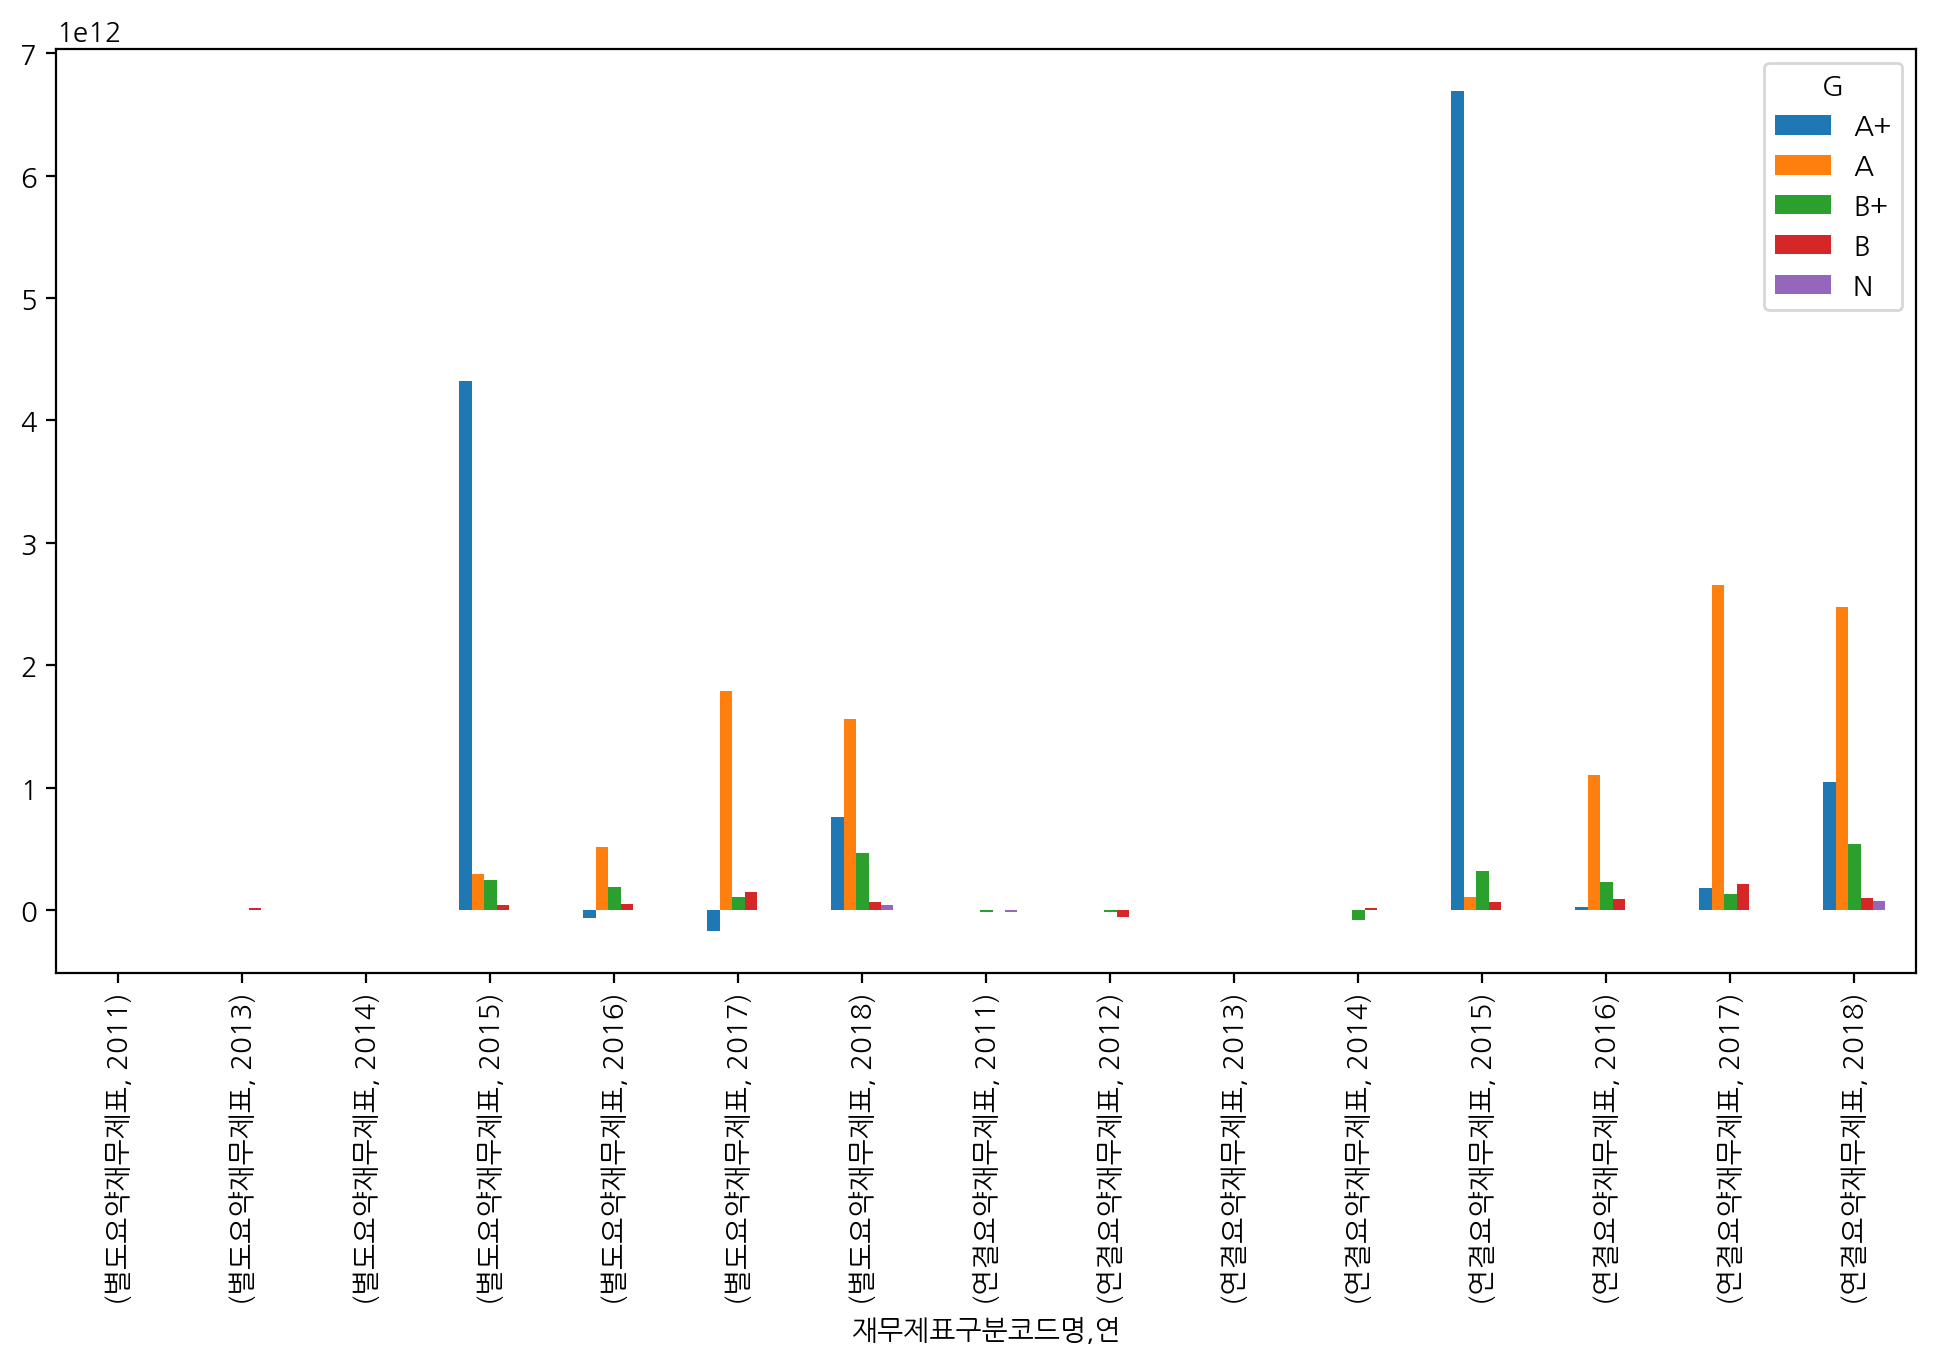

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자산금액
ESG종합


ESG종합                           A+                   A                  B+  \
재무제표구분코드명 연                                                                  
별도요약재무제표  2011                 NaN                 NaN                 NaN   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN                 NaN   
          2015                 NaN 21750380986422.8477  9495098928190.5137   
          2016 18089336140599.0000 23622654846958.3086  7934320245650.1953   
          2017 13326742508284.6660 14144902602627.6250 10782122927182.2949   
          2018 25046996632176.7500 20467665970658.0859  5825873777438.9531   
연결요약재무제표  2011                 NaN                 NaN   768653000000.0000   
          2012                 NaN                 NaN   829158000000.0000   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN  3537038000000.0000   
          2015                 NaN 37962837266428.9219 15906667694802.4863   
          2016 22026723883175.0000 42026309897420.1562 14435599053445.5684   
          2017 44210591514349.3359 28159757565067.4375 16248516737371.1992   
          2018 55046949439429.0000 38758496173727.2734  7941162663245.8047   

ESG종합                           B                  N  
재무제표구분코드명 연                                           
별도요약재무제표  2011     315552191.0000                NaN  
          2013   86018225000.0000                NaN  
          2014  761248573000.0000                NaN  
          2015 2075281142381.4436                NaN  
          2016 1475703194241.6638                NaN  
          2017 1863349673230.1272                NaN  
          2018 1795357419624.4954 1112488245833.0000  
연결요약재무제표  2011  634194333333.3334                NaN  
          2012  512130000000.0000                NaN  
          2013  711750000000.0000                NaN  
          2014  987634000000.0000                NaN  
          2015 3251959658330.7568                NaN  
          2016 2267425156394.7891                NaN  
          2017 2940953118653.4819                NaN  
          2018 2732323619603.8687 2392506443240.3335

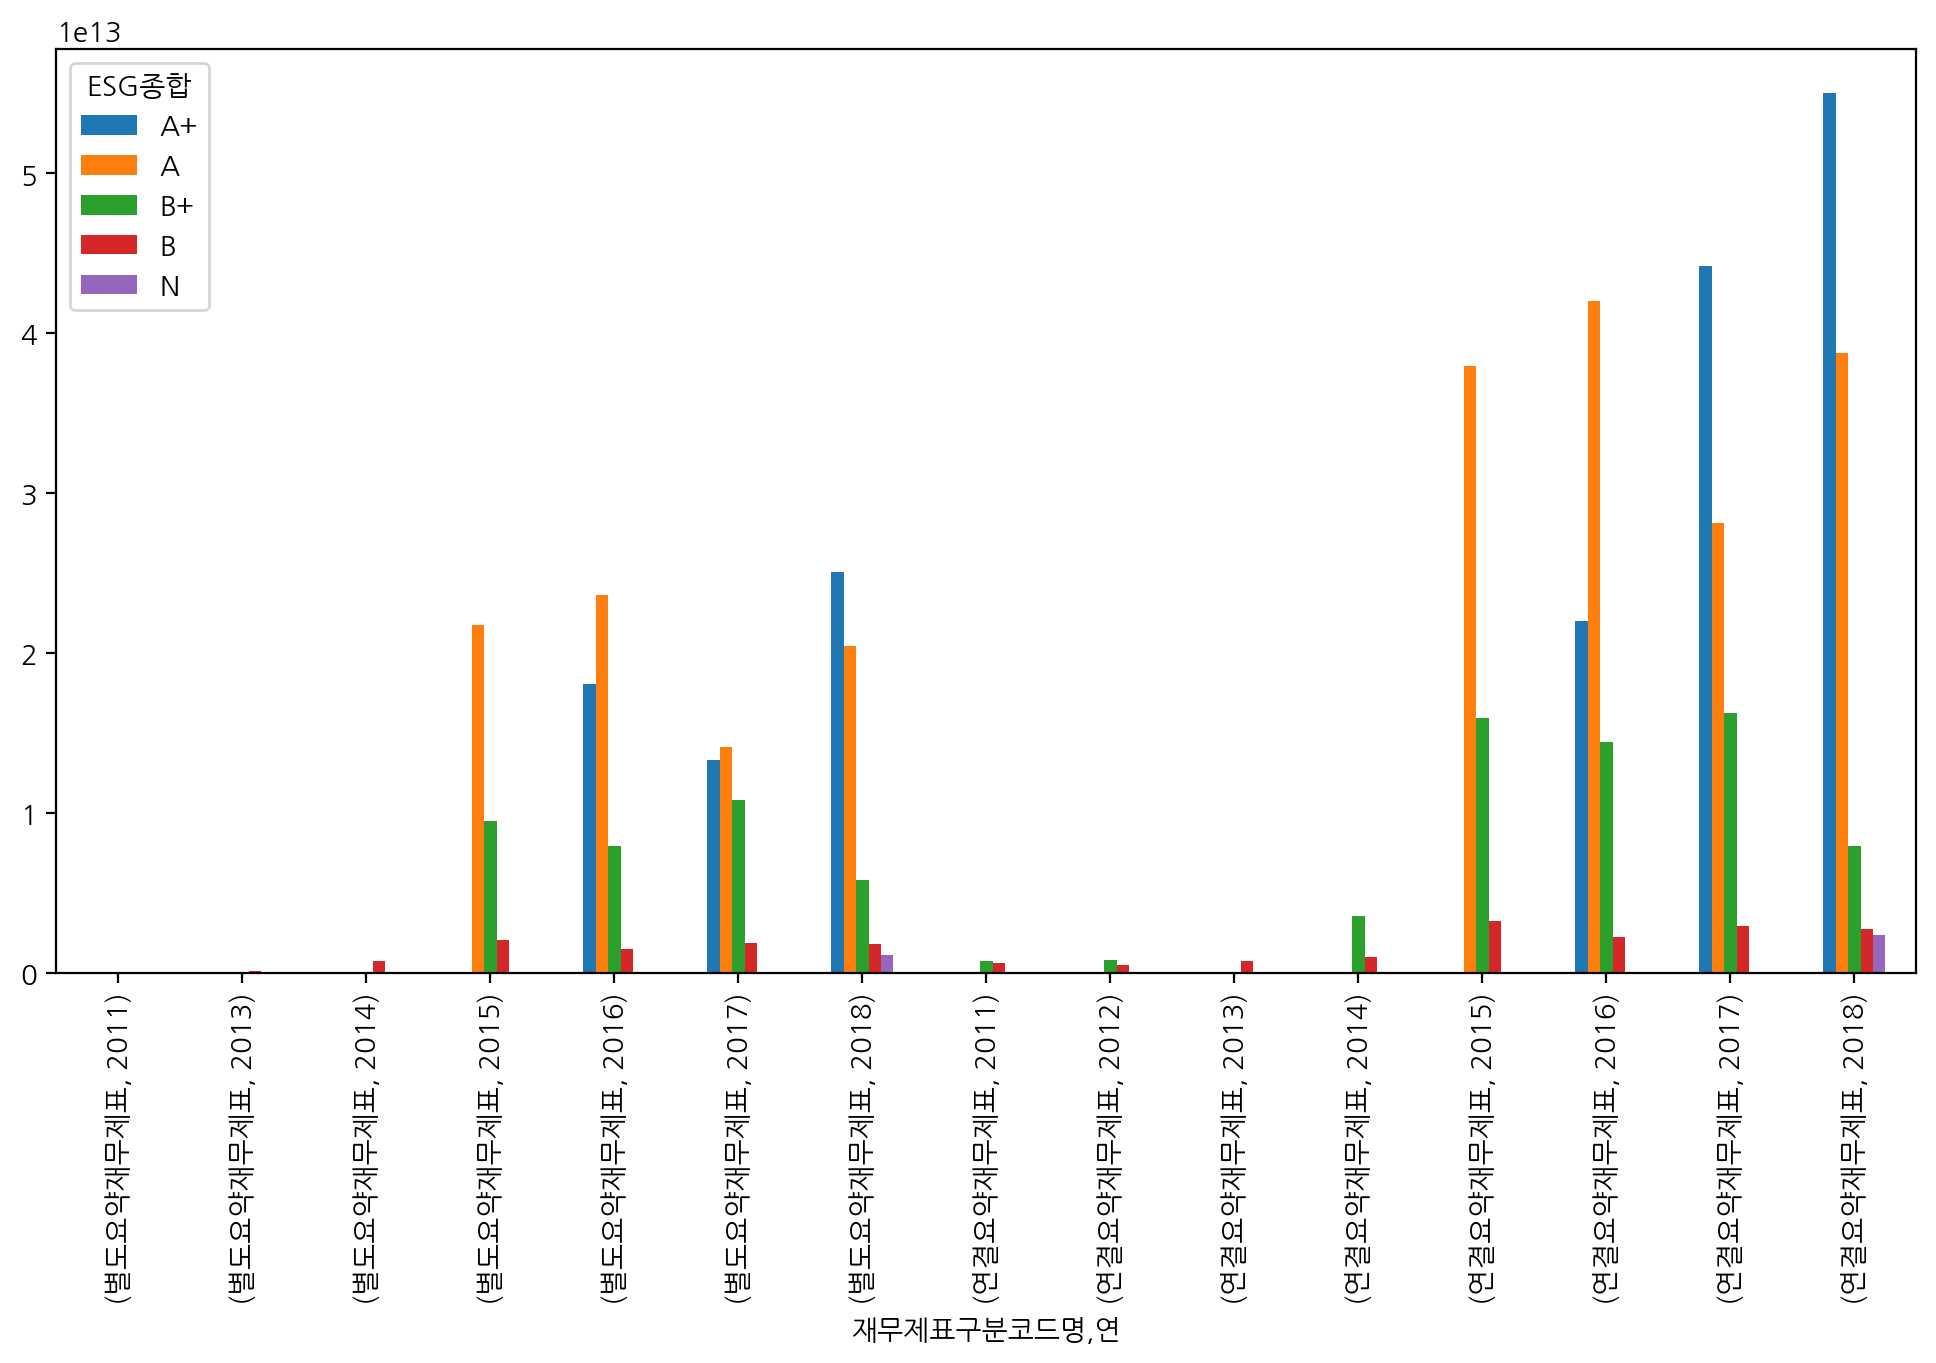

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자산금액
E


E                               A+                   A                  B+  \
재무제표구분코드명 연                                                                  
별도요약재무제표  2011                 NaN                 NaN                 NaN   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN                 NaN   
          2015                 NaN  7293783967413.0908 11311893671337.2852   
          2016 16957461540699.2500 11309766137274.5547 10366370897413.8535   
          2017 17518312000000.0000 12512886981936.0840  5489597965492.6299   
          2018 22102067666666.6680  7997394158836.0000 10943055001061.2363   
연결요약재무제표  2011                 NaN                 NaN                 NaN   
          2012                 NaN                 NaN                 NaN   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN  3537038000000.0000   
          2015                 NaN 18661020007010.6367 19257756323776.5000   
          2016 24665375658131.2500 25601160360405.7773 19963162843098.8125   
          2017 62432185500000.0000 33635006332992.4531  7393599197169.9023   
          2018 59260382000000.0000 29625002827922.8164 15409086730558.8516   

E                               B                  C                   D  
재무제표구분코드명 연                                                               
별도요약재무제표  2011     315552191.0000                NaN                 NaN  
          2013   86018225000.0000                NaN                 NaN  
          2014                NaN  761248573000.0000                 NaN  
          2015 2955383685819.2173 2746499736072.8750 19178371047296.3320  
          2016 2247303589509.2783 3919714574674.8511  2264001544454.0000  
          2017 5095233240602.0000 2424647355983.7002  3009483469947.0000  
          2018 2398583405494.7974 2317898295543.1333   953751013954.8334  
연결요약재무제표  2011  636553333333.3334  761576000000.0000                 NaN  
          2012  715287000000.0000  422844000000.0000                 NaN  
          2013                NaN  711750000000.0000                 NaN  
          2014                NaN  987634000000.0000                 NaN  
          2015 4838655304628.6338 4310630160707.4424 17131022381489.7500  
          2016 3554633445907.6113 5514544543550.3633  3533896979715.1250  
          2017 7832735916188.5508 3682829647806.1787  5141550007086.6250  
          2018 3556106985573.6060 3291952234740.0347  1703900671775.0000

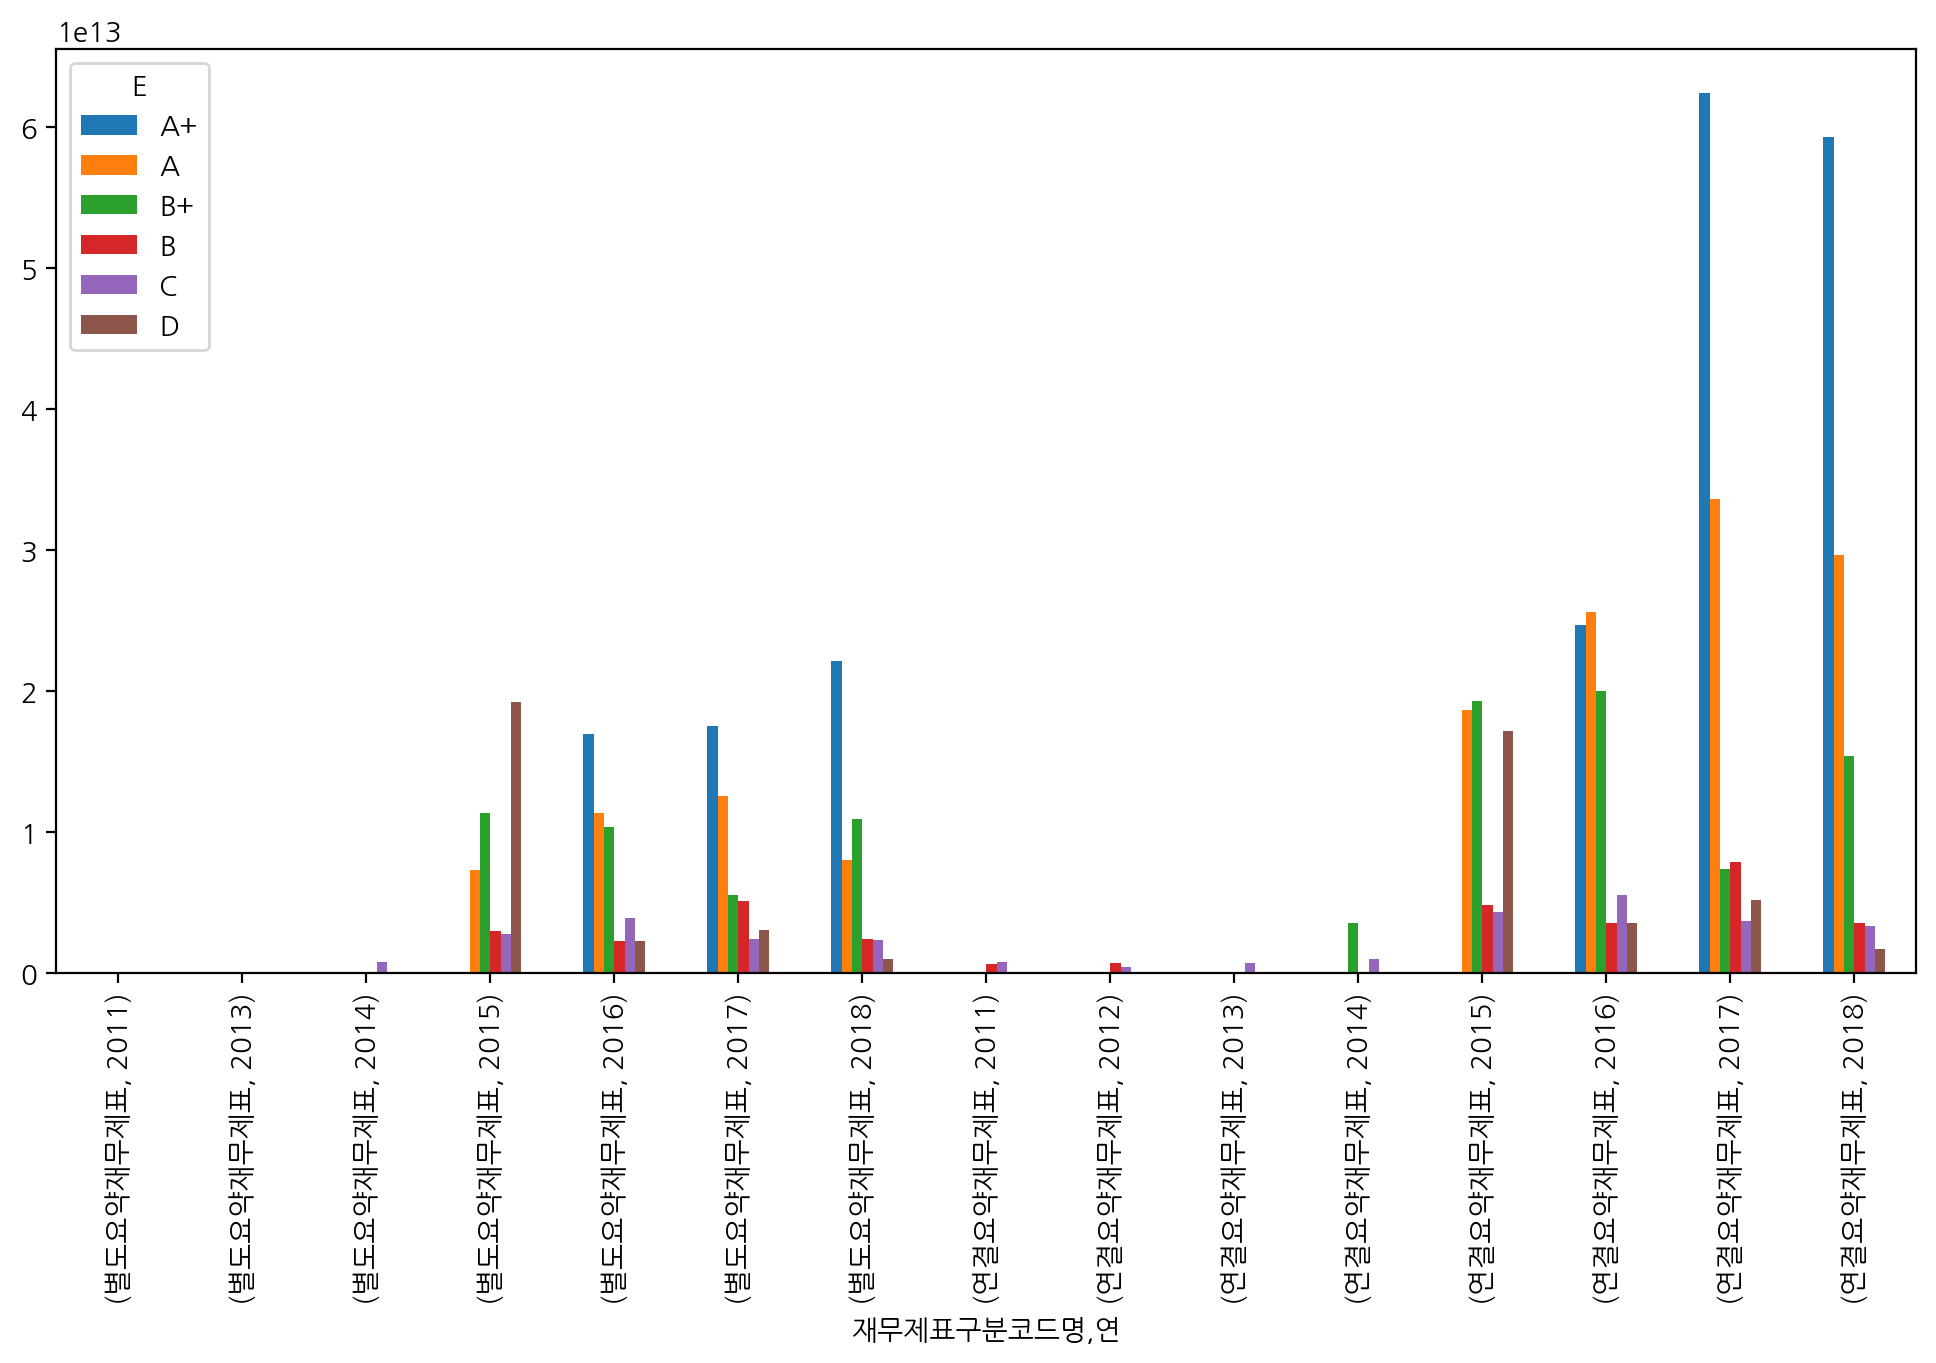

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자산금액
S


S                               A+                   A                  B+  \
재무제표구분코드명 연                                                                  
별도요약재무제표  2011                 NaN                 NaN                 NaN   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN                 NaN   
          2015  8087582665269.6670  9157808736254.3125 13061035686770.2051   
          2016 22771115678761.1992  9288414704923.0918  4896152356785.7676   
          2017 11227104782324.7051 22160390879855.7773  4537493378200.6084   
          2018 12991569586274.3906 21267539974810.6680  2310003289851.1963   
연결요약재무제표  2011                 NaN                 NaN   768653000000.0000   
          2012                 NaN                 NaN   829158000000.0000   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN                 NaN   
          2015  8825990620788.3340 19948522907648.6250 21189578220606.1055   
          2016 37637643139292.8672 17153246811035.1992  9881431134054.4902   
          2017 29120363269901.6875 33891097504342.1680  6064640448898.6094   
          2018 22727255617417.5898 42167413965734.6875  3219921894186.1602   

S                               B                  N  
재무제표구분코드명 연                                           
별도요약재무제표  2011     315552191.0000                NaN  
          2013   86018225000.0000                NaN  
          2014  761248573000.0000                NaN  
          2015 1821037890189.0432                NaN  
          2016 1858849534660.0708                NaN  
          2017 1621148268699.2000                NaN  
          2018 1833237956656.0122 1112488245833.0000  
연결요약재무제표  2011  634194333333.3334                NaN  
          2012  512130000000.0000                NaN  
          2013  711750000000.0000                NaN  
          2014 1624985000000.0000                NaN  
          2015 2809353850751.9902                NaN  
          2016 2738578469656.9893                NaN  
          2017 2468272152440.7339                NaN  
          2018 2757144499628.3066 2392506443240.3335

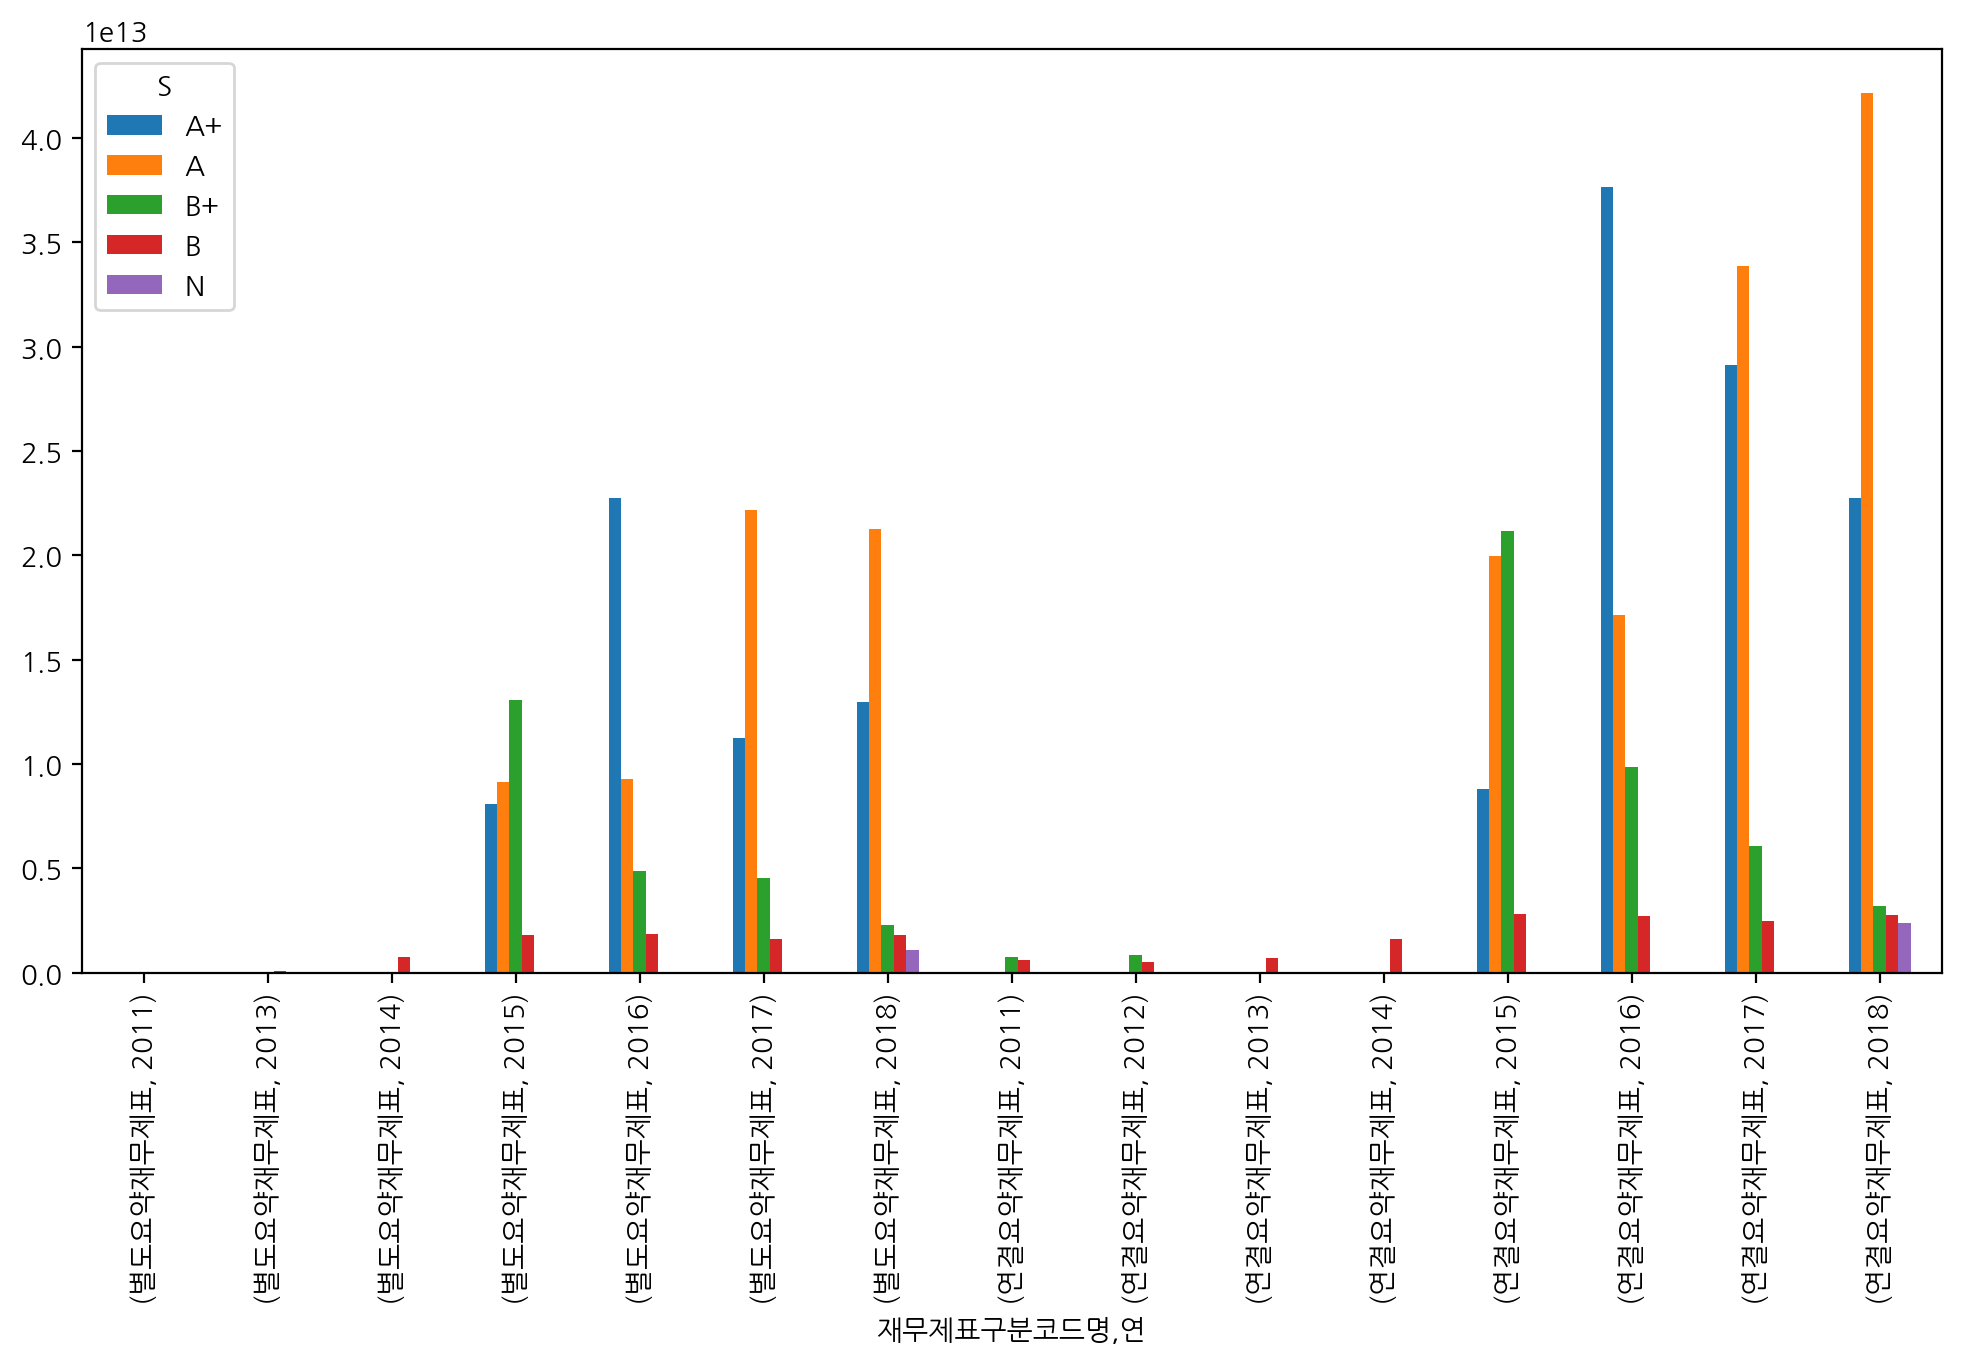

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자산금액
G


G                               A+                   A                 B+  \
재무제표구분코드명 연                                                                 
별도요약재무제표  2011                 NaN                 NaN                NaN   
          2013                 NaN                 NaN                NaN   
          2014                 NaN                 NaN                NaN   
          2015 64717221961741.3359 13278454072128.9609 4707991933451.1670   
          2016  5072566444328.0000 17360394807035.4121 4004709282618.0220   
          2017  4943603524854.0000 21015871585952.0664 3671203236571.1763   
          2018 18106832036220.0000 19761027413215.8164 6102603031205.8115   
연결요약재무제표  2011                 NaN                 NaN  768653000000.0000   
          2012                 NaN                 NaN  829158000000.0000   
          2013                 NaN                 NaN                NaN   
          2014                 NaN                 NaN 1904096666666.6667   
          2015 89957544452175.3281 26170110561237.8828 6508904553199.2158   
          2016  7662629259862.0000 31072984141290.7656 5480259090397.5225   
          2017  7767403543048.0000 36777923759143.3828 4613925123449.9375   
          2018 22392777417387.5000 38808529335216.8047 7974600427628.8398   

G                               B                  N  
재무제표구분코드명 연                                           
별도요약재무제표  2011                NaN     315552191.0000  
          2013   86018225000.0000                NaN  
          2014  761248573000.0000                NaN  
          2015 1074565259944.0110                NaN  
          2016 1224073159629.6101                NaN  
          2017 1393295184197.2324                NaN  
          2018 1266955318951.2000 1112488245833.0000  
연결요약재무제표  2011  713727000000.0000  475129000000.0000  
          2012  512130000000.0000                NaN  
          2013  711750000000.0000                NaN  
          2014  787650000000.0000                NaN  
          2015 1984956433137.1729                NaN  
          2016 2105137896370.9443                NaN  
          2017 2866349556561.0439                NaN  
          2018 2459375933883.2158 2392506443240.3335

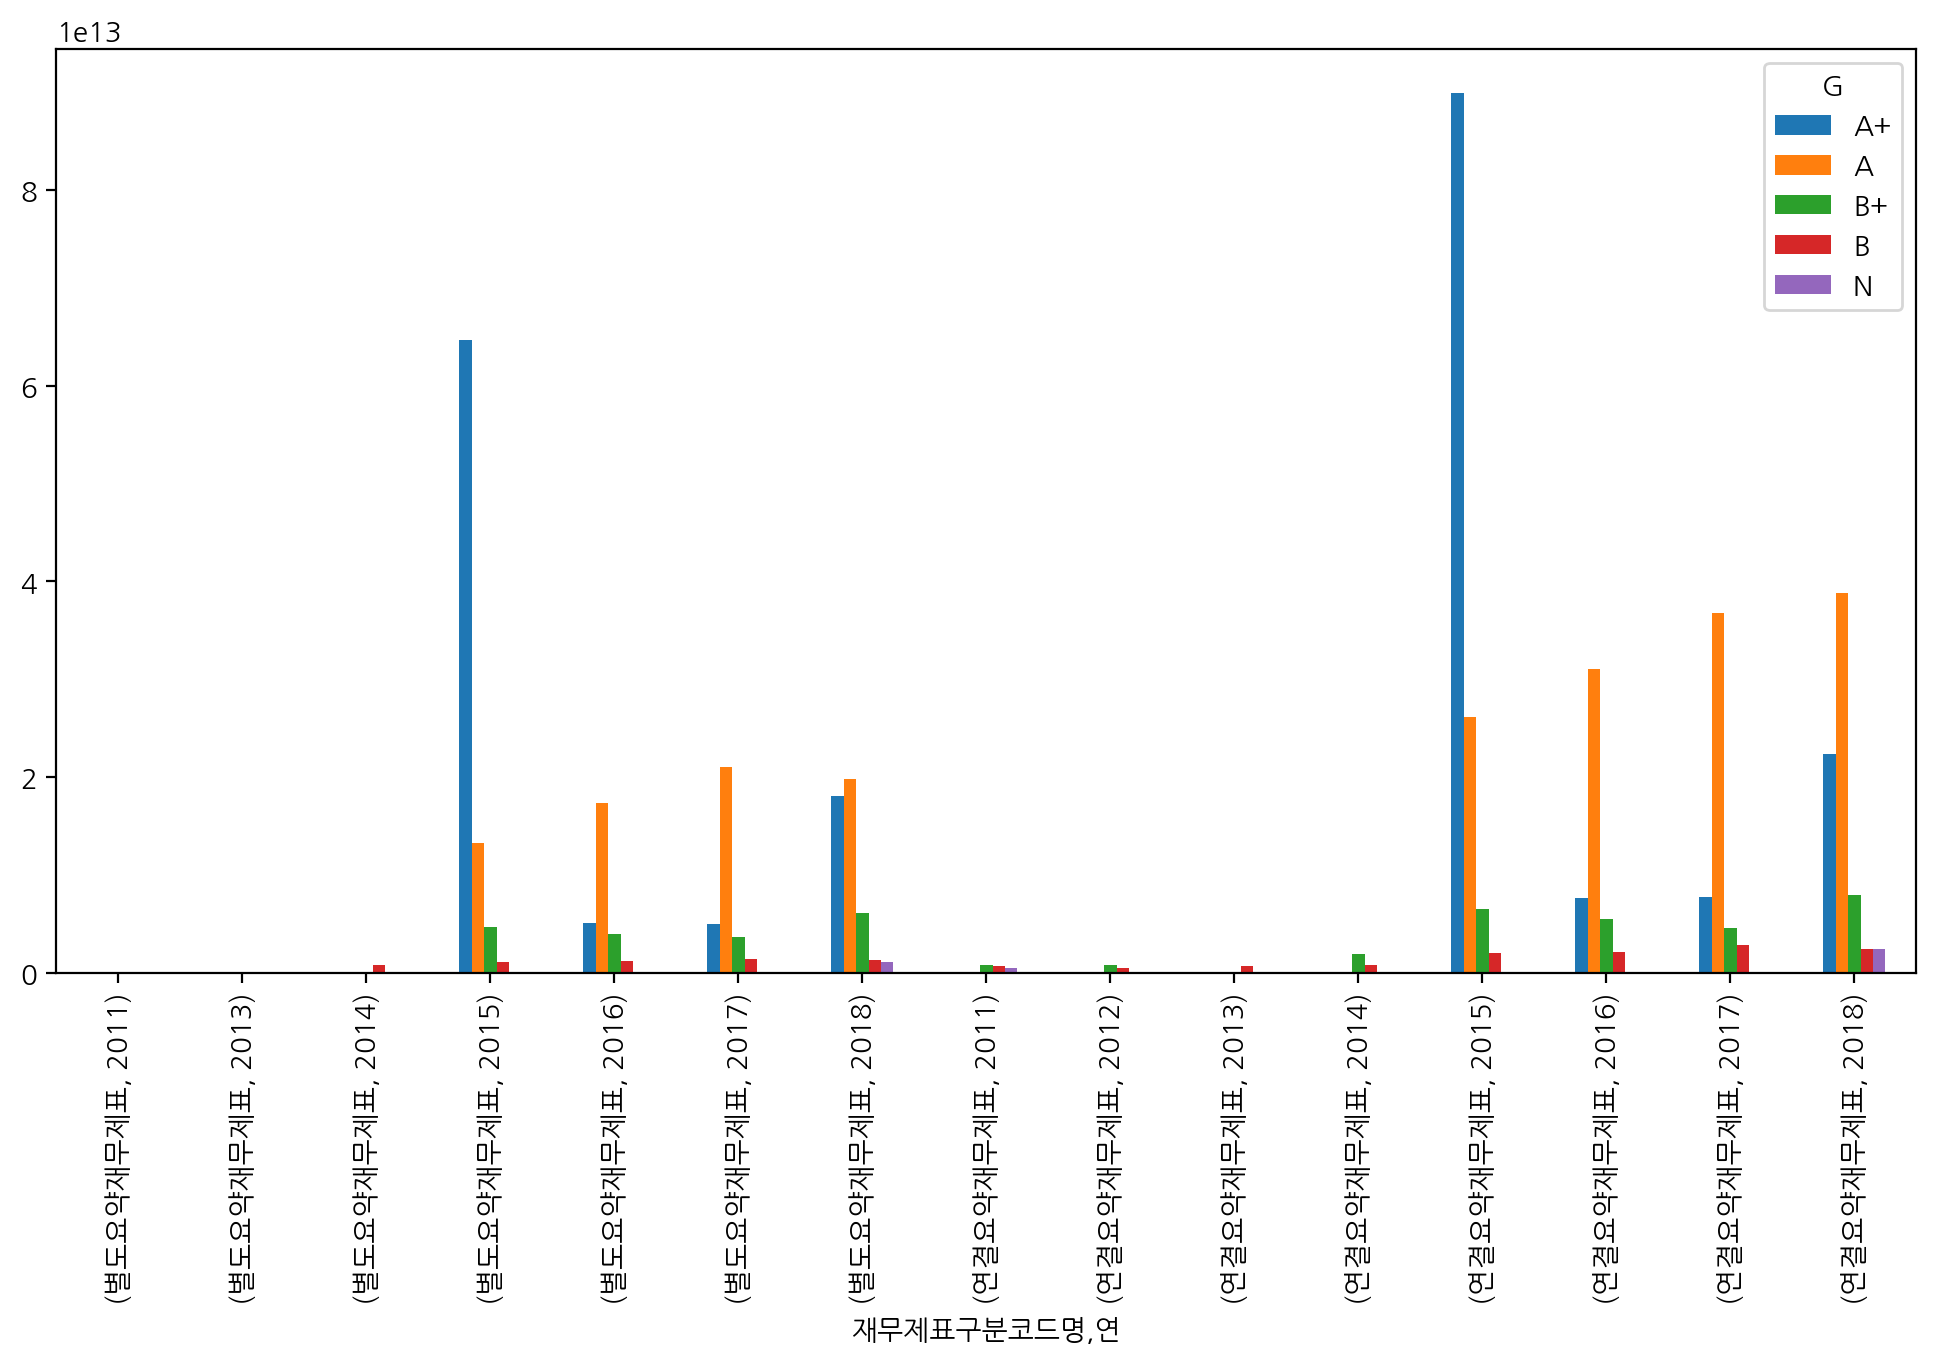

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총부채금액
ESG종합


ESG종합                           A+                   A                  B+  \
재무제표구분코드명 연                                                                  
별도요약재무제표  2011                 NaN                 NaN                 NaN   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN                 NaN   
          2015                 NaN  5703366448617.6152  5050994858075.7295   
          2016  8642716449821.3330  6894011712166.1543  4037311541299.6523   
          2017  5687394851807.3330  5676413151033.3125  4234993803591.7046   
          2018 11193373769239.2500  6039367270510.2607  2716888998272.0234   
연결요약재무제표  2011                 NaN                 NaN   434877000000.0000   
          2012                 NaN                 NaN   511823000000.0000   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN  1912214000000.0000   
          2015                 NaN 15379078906901.0762 10229160470064.9727   
          2016 11415096888040.6660 17098173067203.3848  9179601821808.4551   
          2017 25233747718906.0000 17365384741906.3750  6873749912005.6250   
          2018 29483126677492.5000 18290239921279.5000  3912325042661.8291   

ESG종합                           B                 N  
재무제표구분코드명 연                                          
별도요약재무제표  2011     190382692.0000               NaN  
          2013   89757536000.0000               NaN  
          2014  351736555000.0000               NaN  
          2015  945760109685.0887               NaN  
          2016  581262774441.6471               NaN  
          2017  685847790567.0339               NaN  
          2018  735525093093.8785 119632742047.3333  
연결요약재무제표  2011  395779333333.3333               NaN  
          2012  357350000000.0000               NaN  
          2013  451596500000.0000               NaN  
          2014  764824333333.3334               NaN  
          2015 1794202626739.2073               NaN  
          2016 1141641546131.9907               NaN  
          2017 1397420883042.5181               NaN  
          2018 1353913238048.6162 911249193784.3334

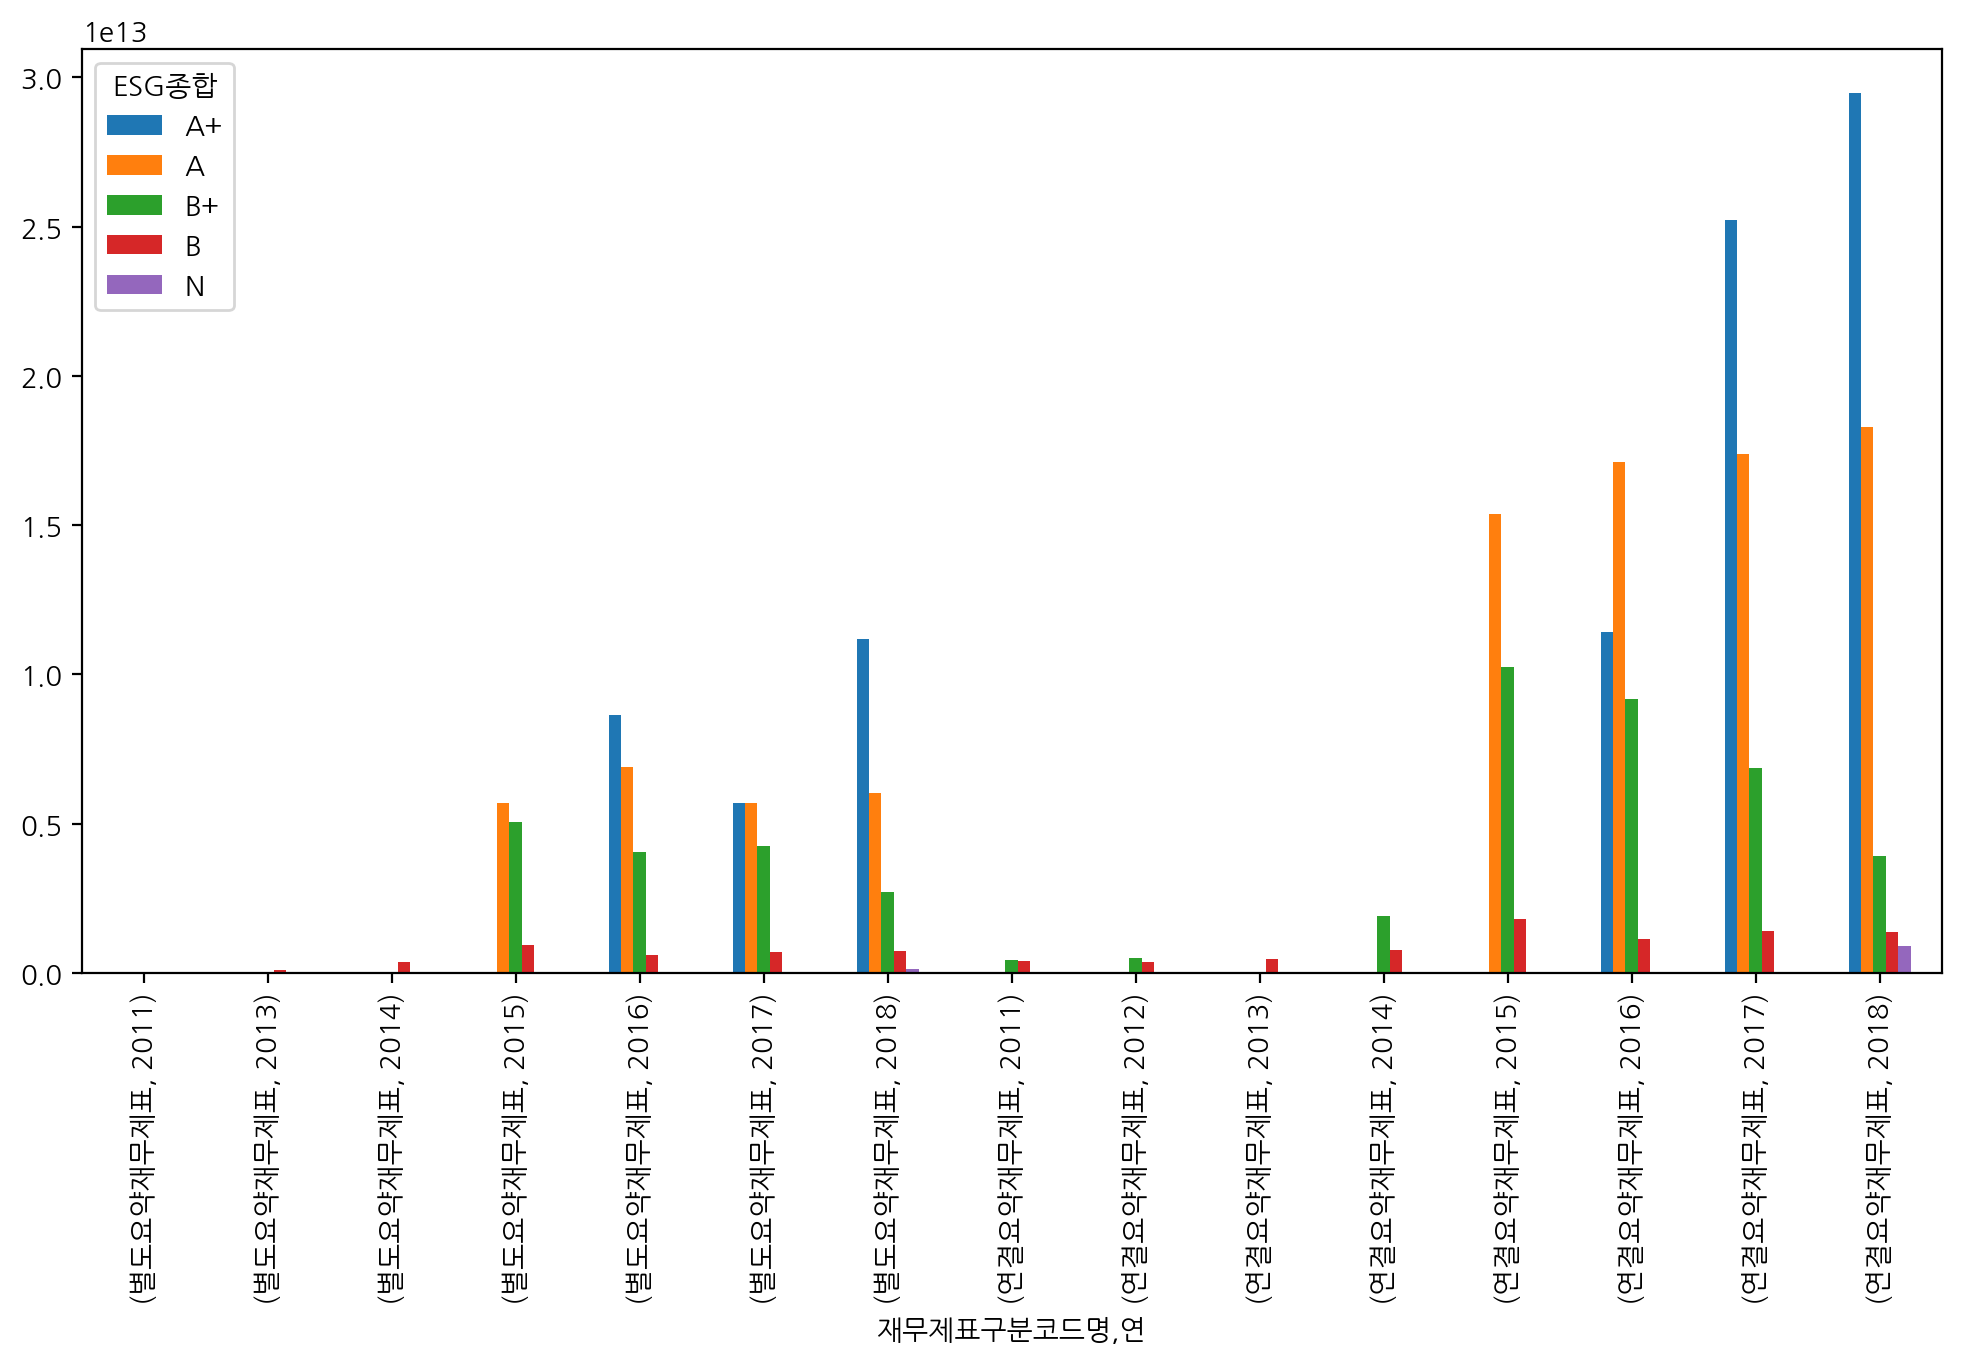

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총부채금액
E


E                               A+                   A                  B+  \
재무제표구분코드명 연                                                                  
별도요약재무제표  2011                 NaN                 NaN                 NaN   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN                 NaN   
          2015                 NaN  2477090766711.2729  4132556887208.6284   
          2016  6819806252366.0000  4049474523531.0000  3666559750048.5586   
          2017  7932412000000.0000  4102668144698.0000  2750469929263.4629   
          2018  9929663666666.6660  2850205557417.0835  3797240759964.2183   
연결요약재무제표  2011                 NaN                 NaN                 NaN   
          2012                 NaN                 NaN                 NaN   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN  1912214000000.0000   
          2015                 NaN  9987293720438.4551  9884648476739.9707   
          2016 12130394097030.5000 13280077661342.5547 10269870010320.5625   
          2017 36132665500000.0000 21322213111183.9102  3999552315541.6860   
          2018 32691596666666.6680 20783126603085.1836  6013395987319.2588   

E                               B                  C                   D  
재무제표구분코드명 연                                                               
별도요약재무제표  2011     190382692.0000                NaN                 NaN  
          2013   89757536000.0000                NaN                 NaN  
          2014                NaN  351736555000.0000                 NaN  
          2015 1464253427865.1450 1190164434665.1606 12911547610570.6660  
          2016 1017440558920.0127 1982947605382.8511  1059129229424.3750  
          2017 1639117660644.8533  892914398187.1333  1476385900789.8750  
          2018 1101618471634.6082  786512339455.3000   268402639986.6667  
연결요약재무제표  2011  407509000000.0000  399688000000.0000                 NaN  
          2012  475653000000.0000  275217000000.0000                 NaN  
          2013                NaN  451596500000.0000                 NaN  
          2014                NaN  764824333333.3334                 NaN  
          2015 2795306283849.9502 2246486376668.0962 11772376749612.5000  
          2016 1883932217622.6250 3104236485355.5908  1994413566348.3750  
          2017 2946783952357.2466 1553684042505.4285  3074450427958.8750  
          2018 1822038409299.0605 1436082236294.2415   696797343328.6666

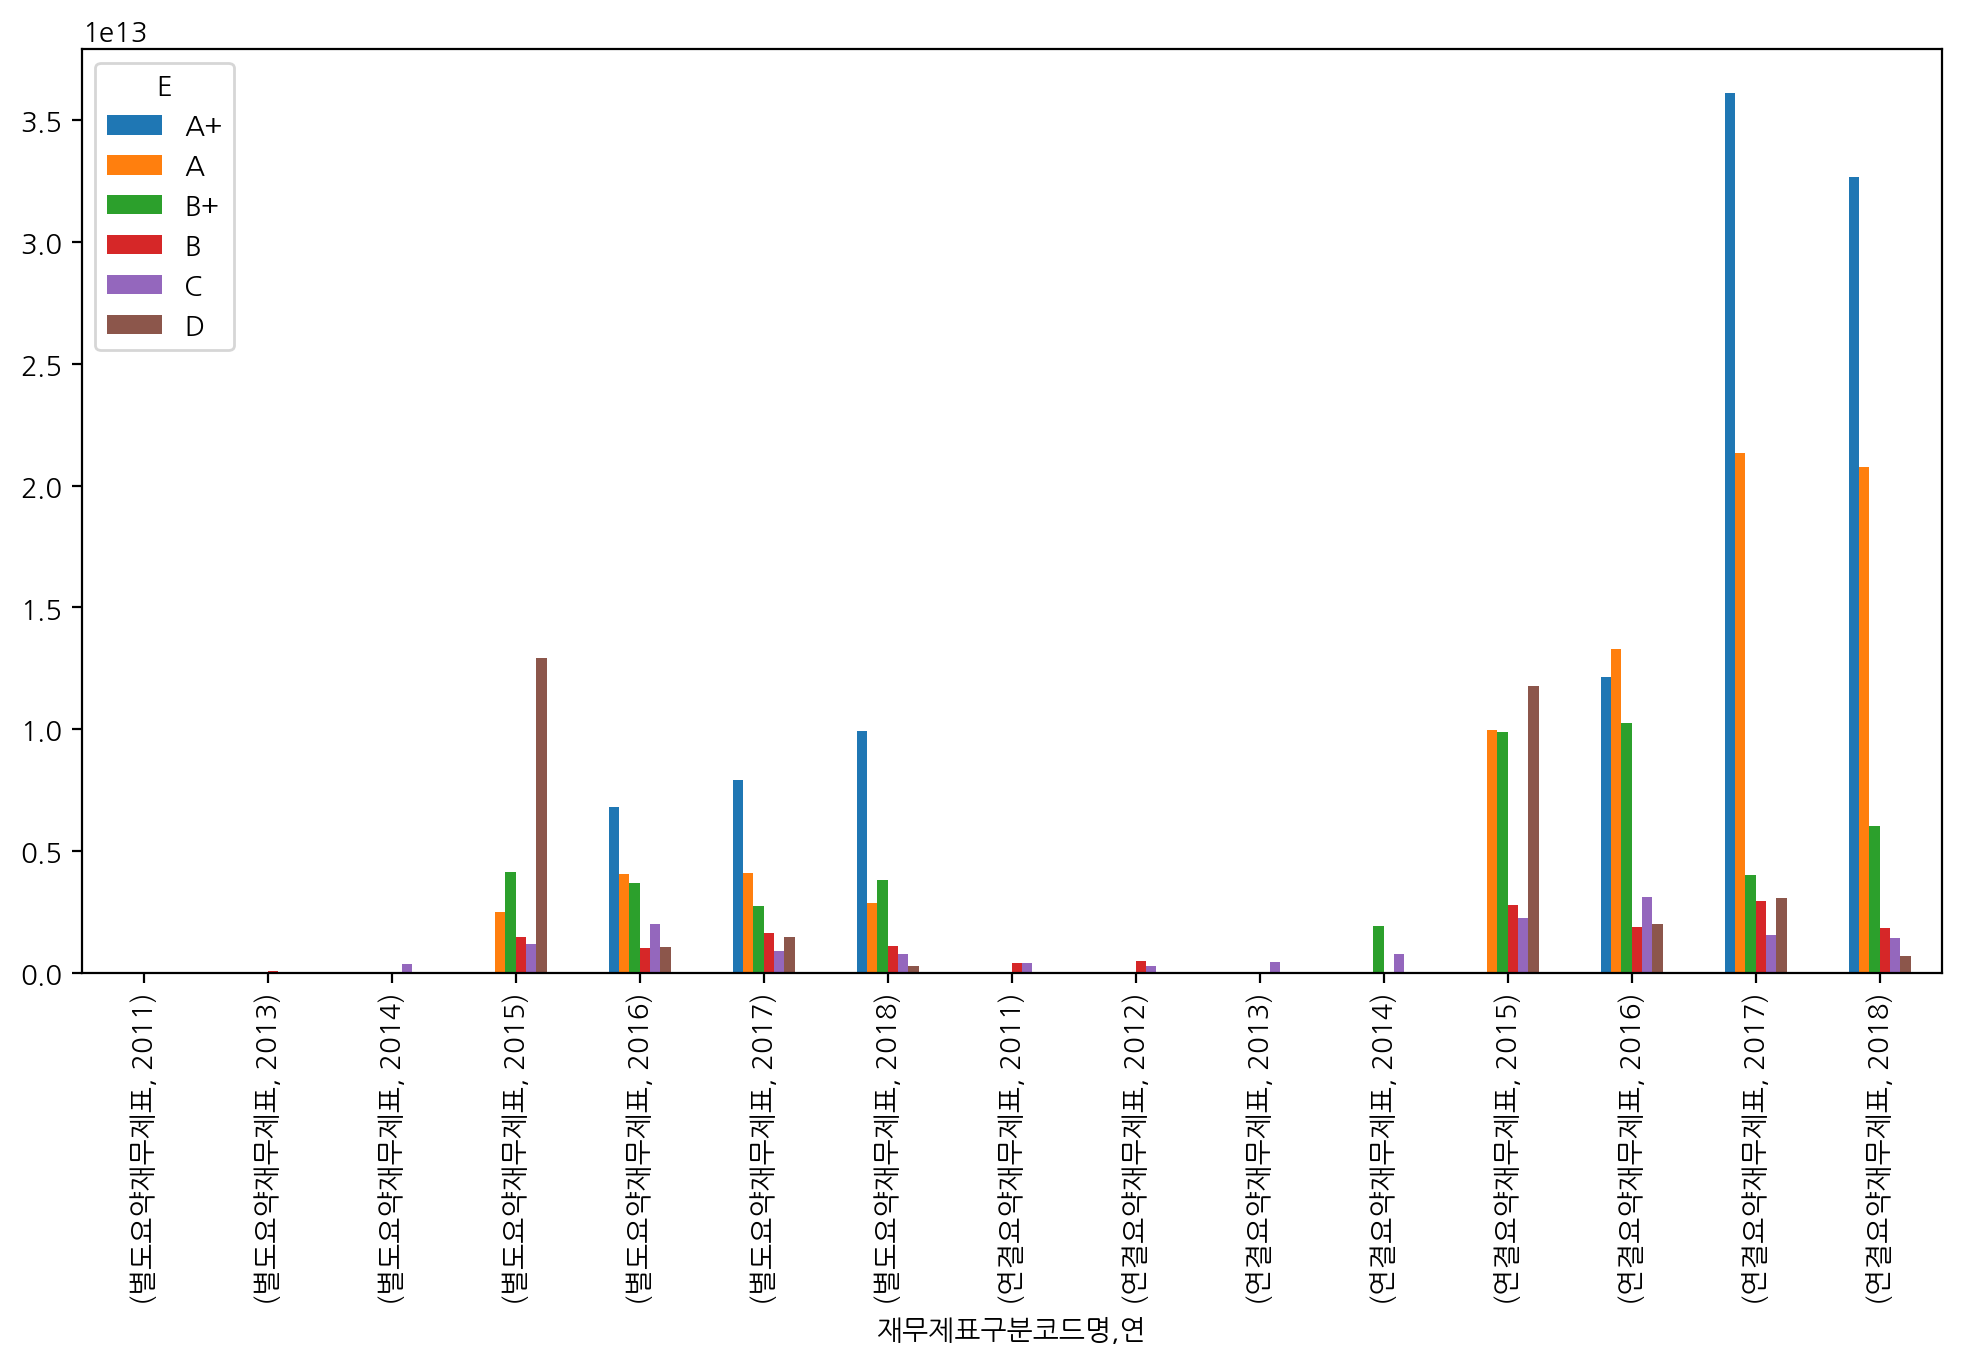

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총부채금액
S


S                               A+                   A                  B+  \
재무제표구분코드명 연                                                                  
별도요약재무제표  2011                 NaN                 NaN                 NaN   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN                 NaN   
          2015  3315943531212.3335  3963101705441.8125  5315418641368.3594   
          2016  7430408373742.2002  3658072788616.8184  2402338772785.3213   
          2017  4611785463681.6475  6782546468149.0000  2458448148060.1304   
          2018  4934005032019.5215  7296805697932.0479   872501331621.5686   
연결요약재무제표  2011                 NaN                 NaN   434877000000.0000   
          2012                 NaN                 NaN   511823000000.0000   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN                 NaN   
          2015  3805708729522.0000 11349970831734.2500 11057675864171.0254   
          2016 15239684461295.3340  9288568817725.9004  6416388351842.3135   
          2017 18622682240409.1250 12915468384993.1113  3388131568286.6587   
          2018 11157956437660.8184 20327297764063.6836  1499794638978.8401   

S                               B                 N  
재무제표구분코드명 연                                          
별도요약재무제표  2011     190382692.0000               NaN  
          2013   89757536000.0000               NaN  
          2014  351736555000.0000               NaN  
          2015  841776226618.1897               NaN  
          2016  850616213222.9091               NaN  
          2017  615797574968.6400               NaN  
          2018  829192083898.9390 119632742047.3333  
연결요약재무제표  2011  395779333333.3333               NaN  
          2012  357350000000.0000               NaN  
          2013  451596500000.0000               NaN  
          2014 1051671750000.0000               NaN  
          2015 1580337619378.4326               NaN  
          2016 1463937507366.4302               NaN  
          2017 1200627144318.5852               NaN  
          2018 1441027882658.3601 911249193784.3334

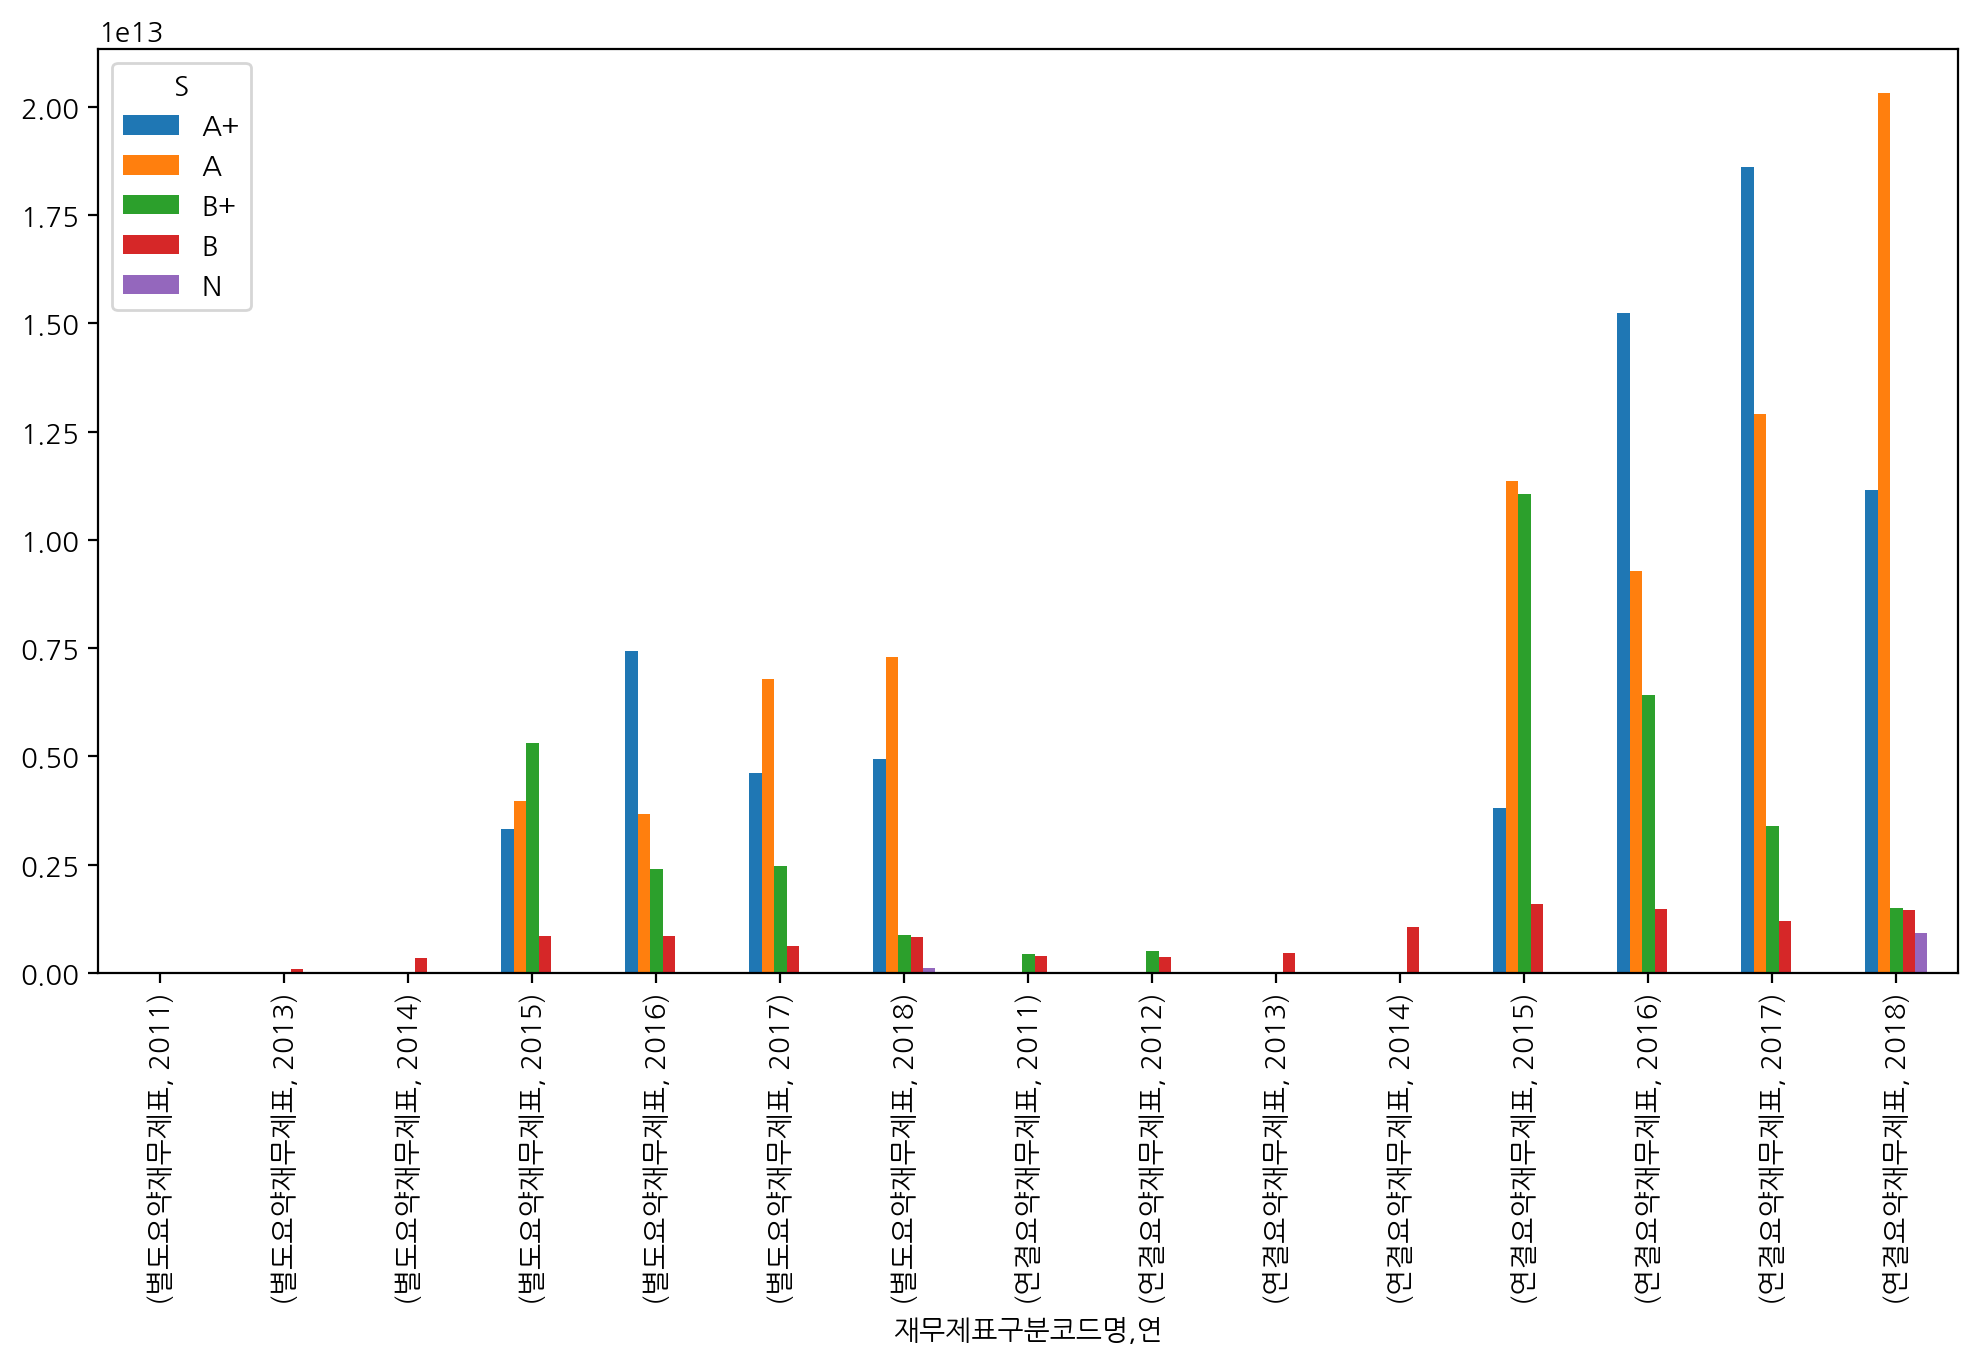

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총부채금액
G


G                               A+                   A                 B+  \
재무제표구분코드명 연                                                                 
별도요약재무제표  2011                 NaN                 NaN                NaN   
          2013                 NaN                 NaN                NaN   
          2014                 NaN                 NaN                NaN   
          2015 13150501217821.0000  7653413791710.0381 1999202834411.7778   
          2016  1060250540430.0000  7542051557214.5586 1611525919652.4565   
          2017  1197360555422.0000  8289591711159.0664 1745796387488.8628   
          2018  8093675876755.5000  6846656478037.1855 2790661300282.2075   
연결요약재무제표  2011                 NaN                 NaN  434877000000.0000   
          2012                 NaN                 NaN  511823000000.0000   
          2013                 NaN                 NaN                NaN   
          2014                 NaN                 NaN 1251296000000.0000   
          2015 24001349809608.3320 17920967931714.8828 3172387776831.0000   
          2016  3325043961430.0000 17137214628668.1758 2581430216946.3638   
          2017  3435912156718.0000 18771545470556.2070 2399380050504.0625   
          2018 10574460777306.0000 19249478685302.0781 3909143601748.5400   

G                               B                 N  
재무제표구분코드명 연                                          
별도요약재무제표  2011                NaN    190382692.0000  
          2013   89757536000.0000               NaN  
          2014  351736555000.0000               NaN  
          2015  350633097644.1978               NaN  
          2016  388167068762.2600               NaN  
          2017  365998322876.5051               NaN  
          2018  318465564315.4000 119632742047.3333  
연결요약재무제표  2011  448264500000.0000 290809000000.0000  
          2012  357350000000.0000               NaN  
          2013  451596500000.0000               NaN  
          2014  452799000000.0000               NaN  
          2015  960771141708.3580               NaN  
          2016  947663092710.4111               NaN  
          2017 1310249663901.9670               NaN  
          2018 1109863350388.3408 911249193784.3334

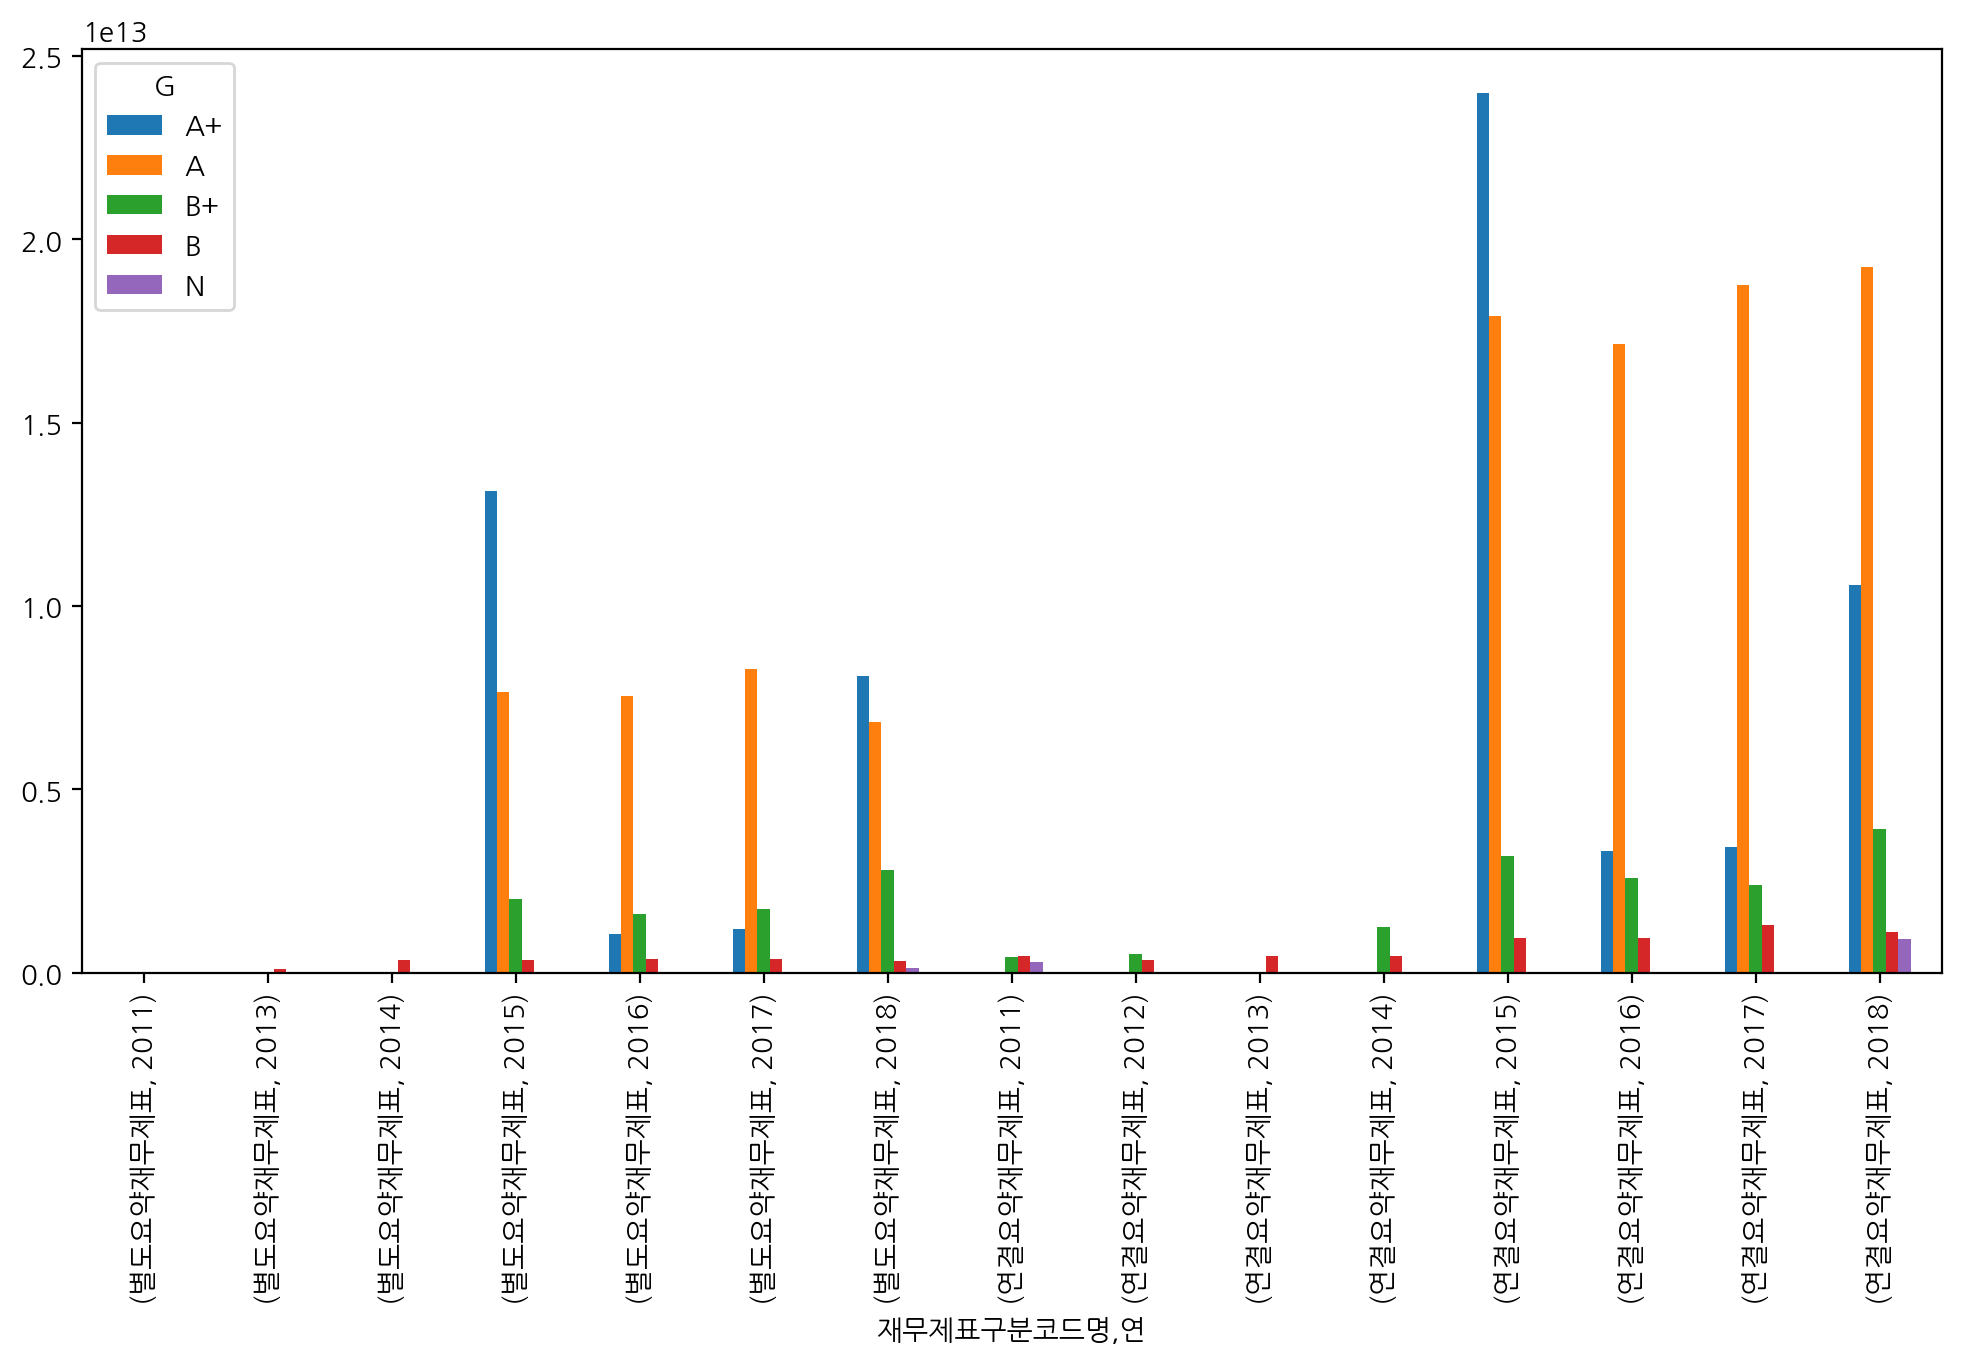

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자본금액
ESG종합


ESG종합                           A+                   A                 B+  \
재무제표구분코드명 연                                                                 
별도요약재무제표  2011                 NaN                 NaN                NaN   
          2013                 NaN                 NaN                NaN   
          2014                 NaN                 NaN                NaN   
          2015                 NaN 16047014537805.2305 4444104070114.7842   
          2016  9446619690777.6660 16728643134792.1543 3897008704350.5435   
          2017  7639347656477.3330  8468489451594.3125 6547129123590.5908   
          2018 13853622862937.5000 14428298700147.8262 3108984779166.9302   
연결요약재무제표  2011                 NaN                 NaN  333776000000.0000   
          2012                 NaN                 NaN  317335000000.0000   
          2013                 NaN                 NaN                NaN   
          2014                 NaN                 NaN 1624824000000.0000   
          2015                 NaN 22583758359527.8477 5677507224737.5137   
          2016 10611626995134.3340 24928136830216.7695 5233571853805.3184   
          2017 18976843795443.3320 10733367084809.5625 9374766825365.5742   
          2018 25563822761936.5000 20468256252447.7734 4028837620583.9756   

ESG종합                           B                  N  
재무제표구분코드명 연                                           
별도요약재무제표  2011     125169499.0000                NaN  
          2013   -3739311000.0000                NaN  
          2014  409512018000.0000                NaN  
          2015 1129521032696.3547                NaN  
          2016  894440419800.0168                NaN  
          2017 1146366613412.5168                NaN  
          2018 1013034472803.5608  992855503785.6666  
연결요약재무제표  2011  238415000000.0000                NaN  
          2012  154780000000.0000                NaN  
          2013  260153500000.0000                NaN  
          2014  222809666666.6667                NaN  
          2015 1467357971025.0901                NaN  
          2016 1136761864471.6238                NaN  
          2017 1535118868091.5818                NaN  
          2018 1368366779636.8989 1481257249456.0000

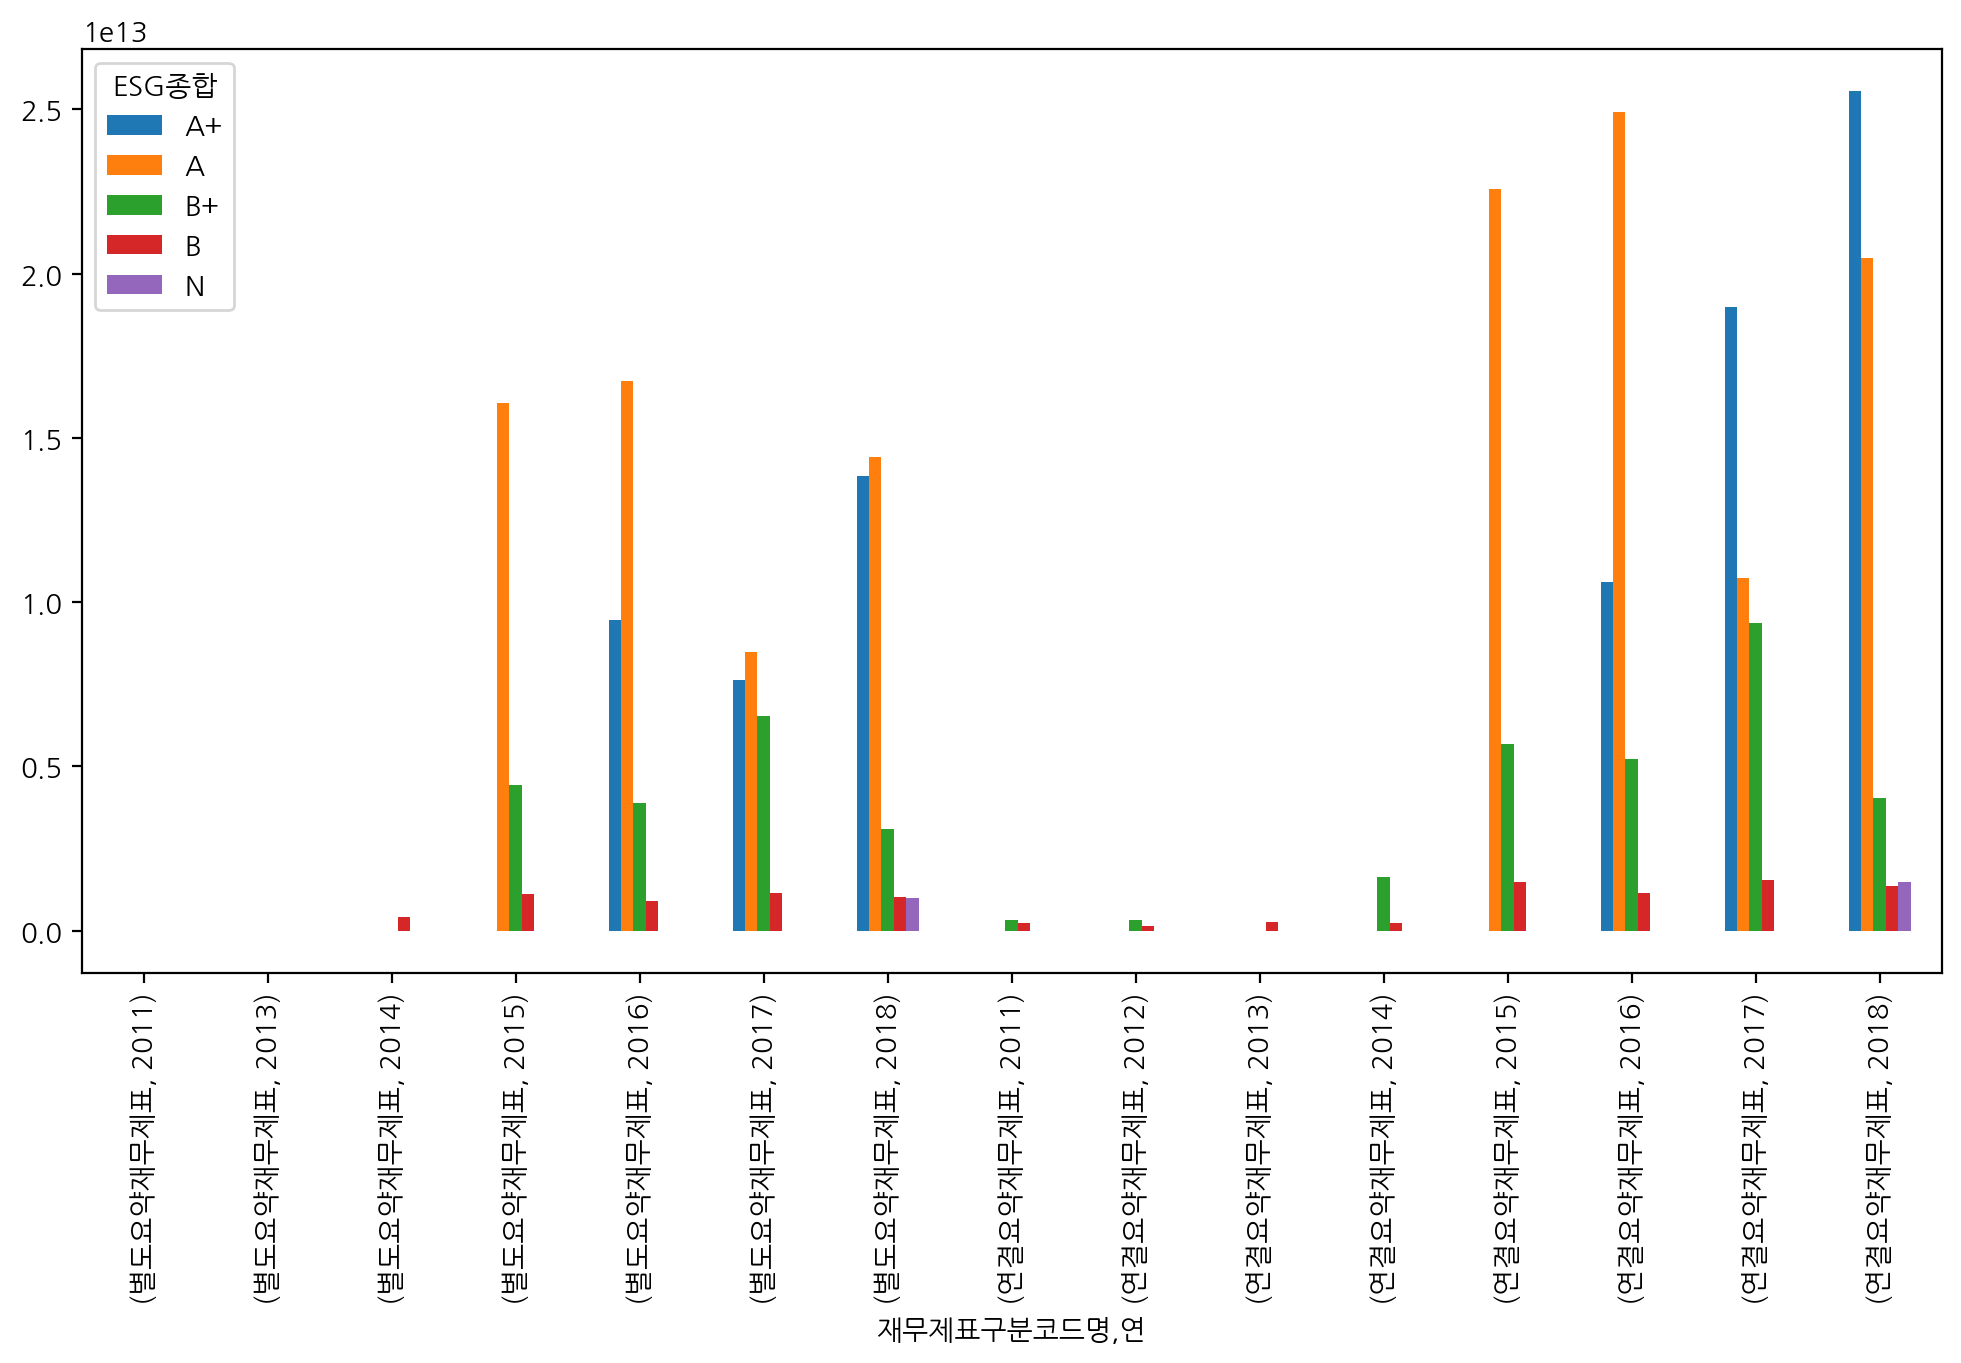

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자본금액
E


E                               A+                   A                 B+  \
재무제표구분코드명 연                                                                 
별도요약재무제표  2011                 NaN                 NaN                NaN   
          2013                 NaN                 NaN                NaN   
          2014                 NaN                 NaN                NaN   
          2015                 NaN  4816693200701.8184 7179336784128.6572   
          2016 10137655288333.2500  7260291613743.5557 6699811147365.2939   
          2017  9585900000000.0000  8410218837238.0830 2739128036229.1665   
          2018 12172404000000.0000  5147188601418.9170 7083854162323.5088   
연결요약재무제표  2011                 NaN                 NaN                NaN   
          2012                 NaN                 NaN                NaN   
          2013                 NaN                 NaN                NaN   
          2014                 NaN                 NaN 1624824000000.0000   
          2015                 NaN  8673726286572.1816 9382921234297.5879   
          2016 12534981561100.7500 12321082699063.2227 9662457938259.5312   
          2017 26299520000000.0000 12312793221808.5449 3374907826459.1177   
          2018 26568785333333.3320  8841876224837.6367 9377277473055.9453   

E                               B                  C                  D  
재무제표구분코드명 연                                                              
별도요약재무제표  2011     125169499.0000                NaN                NaN  
          2013   -3739311000.0000                NaN                NaN  
          2014                NaN  409512018000.0000                NaN  
          2015 1491130257954.0725 1556335301407.7144 6266823436725.6670  
          2016 1229863030589.2659 1936766969292.0000 1204872315029.6250  
          2017 3407129423002.9067 1531732957796.5667 1533097569157.1250  
          2018 1292319779143.3242 1489525137181.0334  685348373968.1666  
연결요약재무제표  2011  229044333333.3333  361888000000.0000                NaN  
          2012  239634000000.0000  147627000000.0000                NaN  
          2013                NaN  260153500000.0000                NaN  
          2014                NaN  222809666666.6667                NaN  
          2015 2061396734991.4834 2057397365913.9424 5358645631877.2500  
          2016 1670701228284.9861 2437504187939.3638 1539483413366.7500  
          2017 4872539348945.3330 2129145605300.7500 2067099579127.7500  
          2018 1734068576274.5454 1855869998445.7932 1007103328446.3334

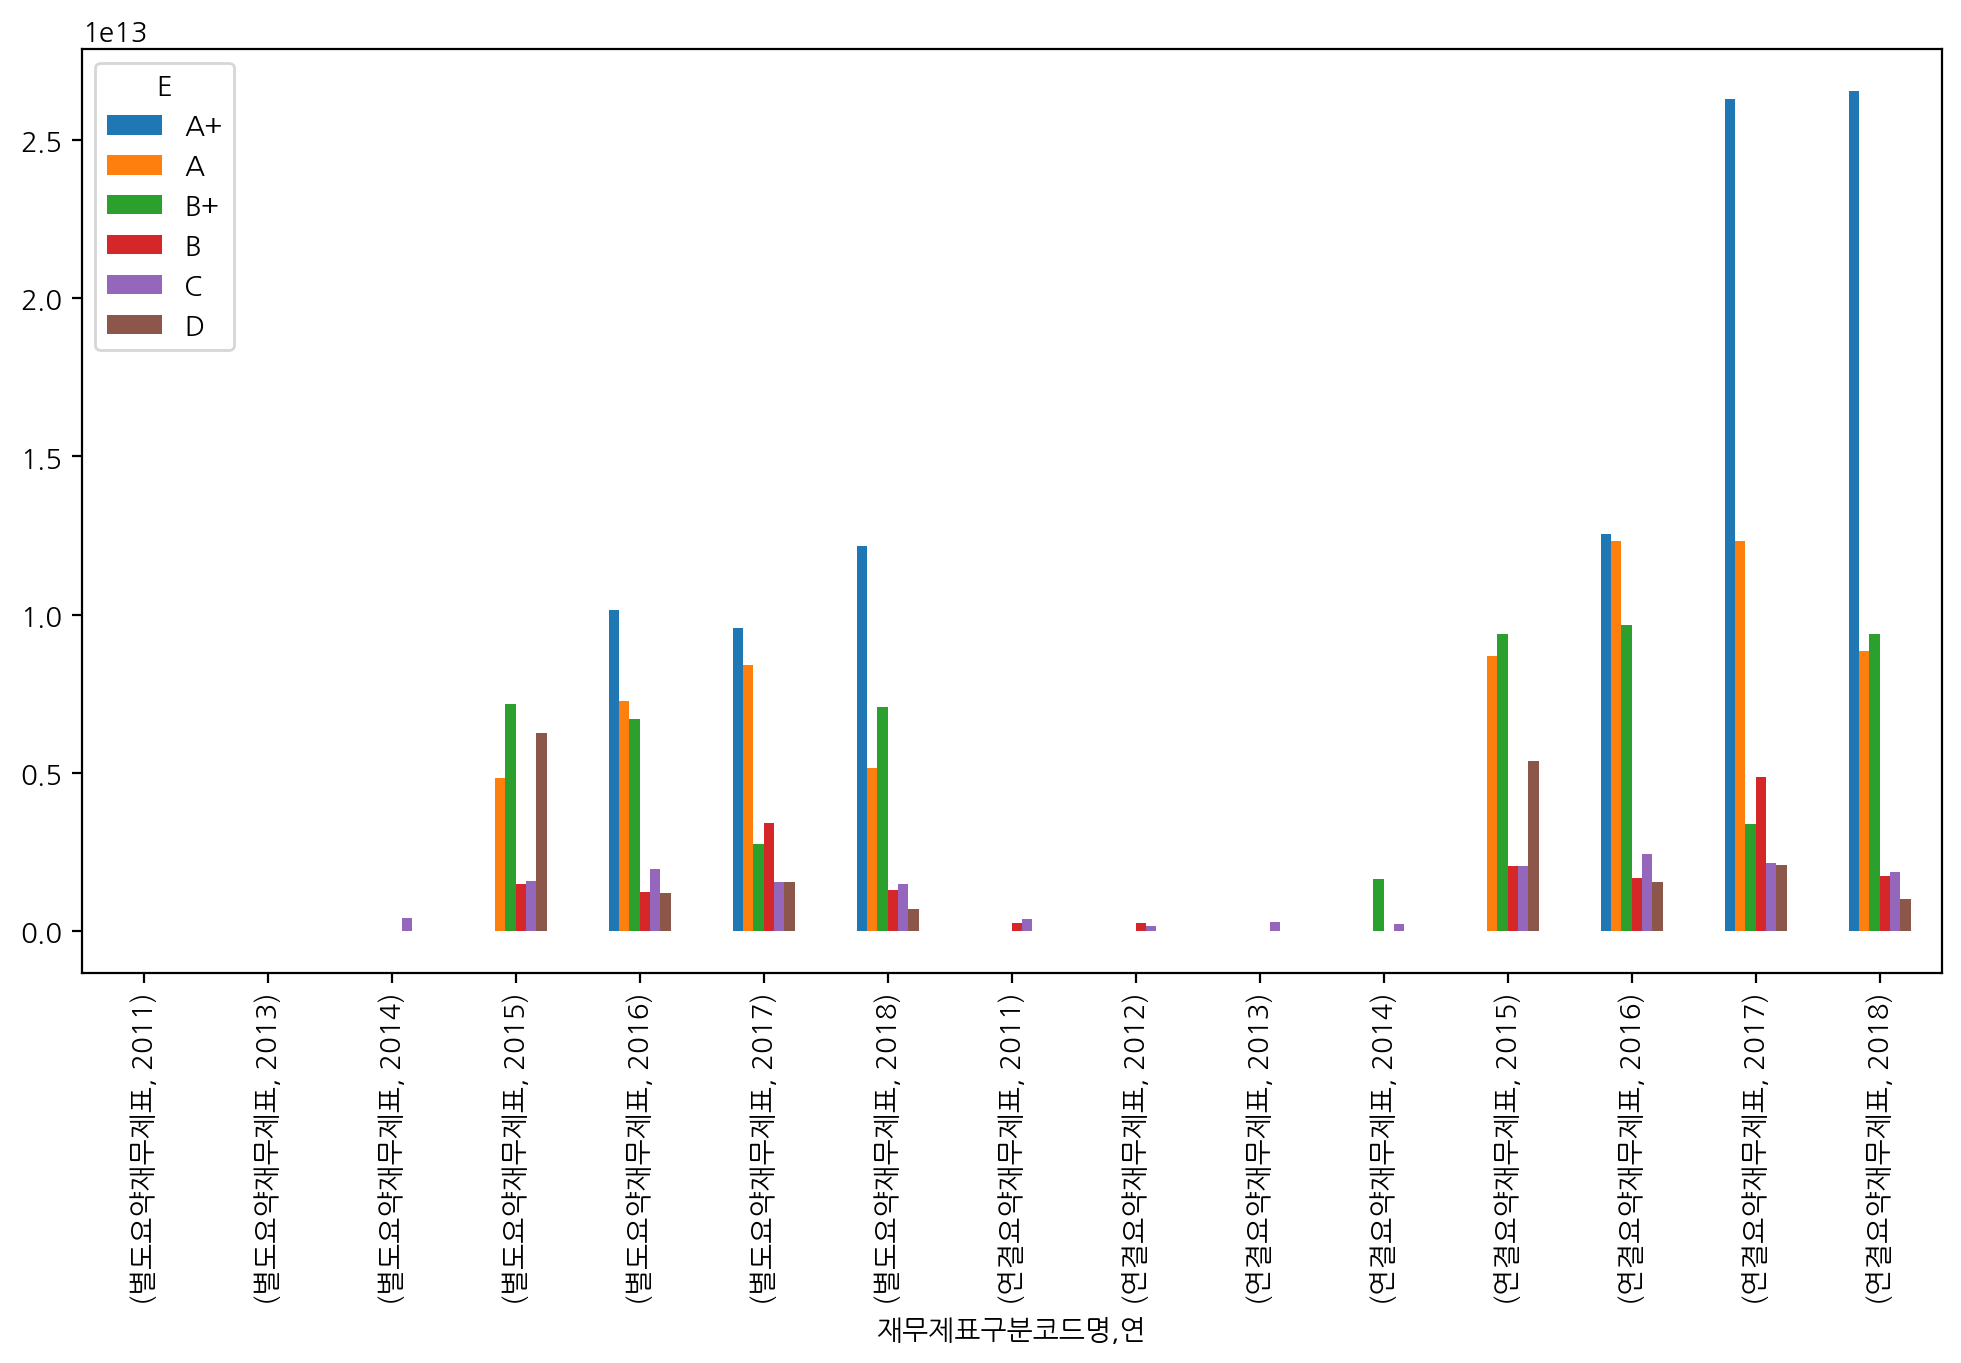

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자본금액
S


S                               A+                   A                  B+  \
재무제표구분코드명 연                                                                  
별도요약재무제표  2011                 NaN                 NaN                 NaN   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN                 NaN   
          2015  4771639134057.3330  5194707030812.5000  7745617045401.8457   
          2016 15340707305019.0000  5630341916306.2725  2493813584000.4463   
          2017  6615319318643.0586 15377844411706.7773  2079045230140.4783   
          2018  8057564554254.8691 13970734276878.6191  1411431398615.9805   
연결요약재무제표  2011                 NaN                 NaN   333776000000.0000   
          2012                 NaN                 NaN   317335000000.0000   
          2013                 NaN                 NaN                 NaN   
          2014                 NaN                 NaN                 NaN   
          2015  5020281891266.3330  8598552075914.3750 10122670415842.4219   
          2016 22397958677997.5352  7864677993309.2998  3469158725038.9019   
          2017 10436675291141.0625 20975629119349.0547  2676508880611.9512   
          2018 11569299179756.7734 21840116201671.0000  1700240923408.9800   

S                               B                  N  
재무제표구분코드명 연                                           
별도요약재무제표  2011     125169499.0000                NaN  
          2013   -3739311000.0000                NaN  
          2014  409512018000.0000                NaN  
          2015  979261663570.8534                NaN  
          2016 1008233321437.1616                NaN  
          2017  968611076014.8800                NaN  
          2018  959194997043.6708  992855503785.6666  
연결요약재무제표  2011  238415000000.0000                NaN  
          2012  154780000000.0000                NaN  
          2013  260153500000.0000                NaN  
          2014  573313250000.0000                NaN  
          2015 1242636596947.0576                NaN  
          2016 1274640962290.5591                NaN  
          2017 1257799578046.2766                NaN  
          2018 1316116616969.9468 1481257249456.0000

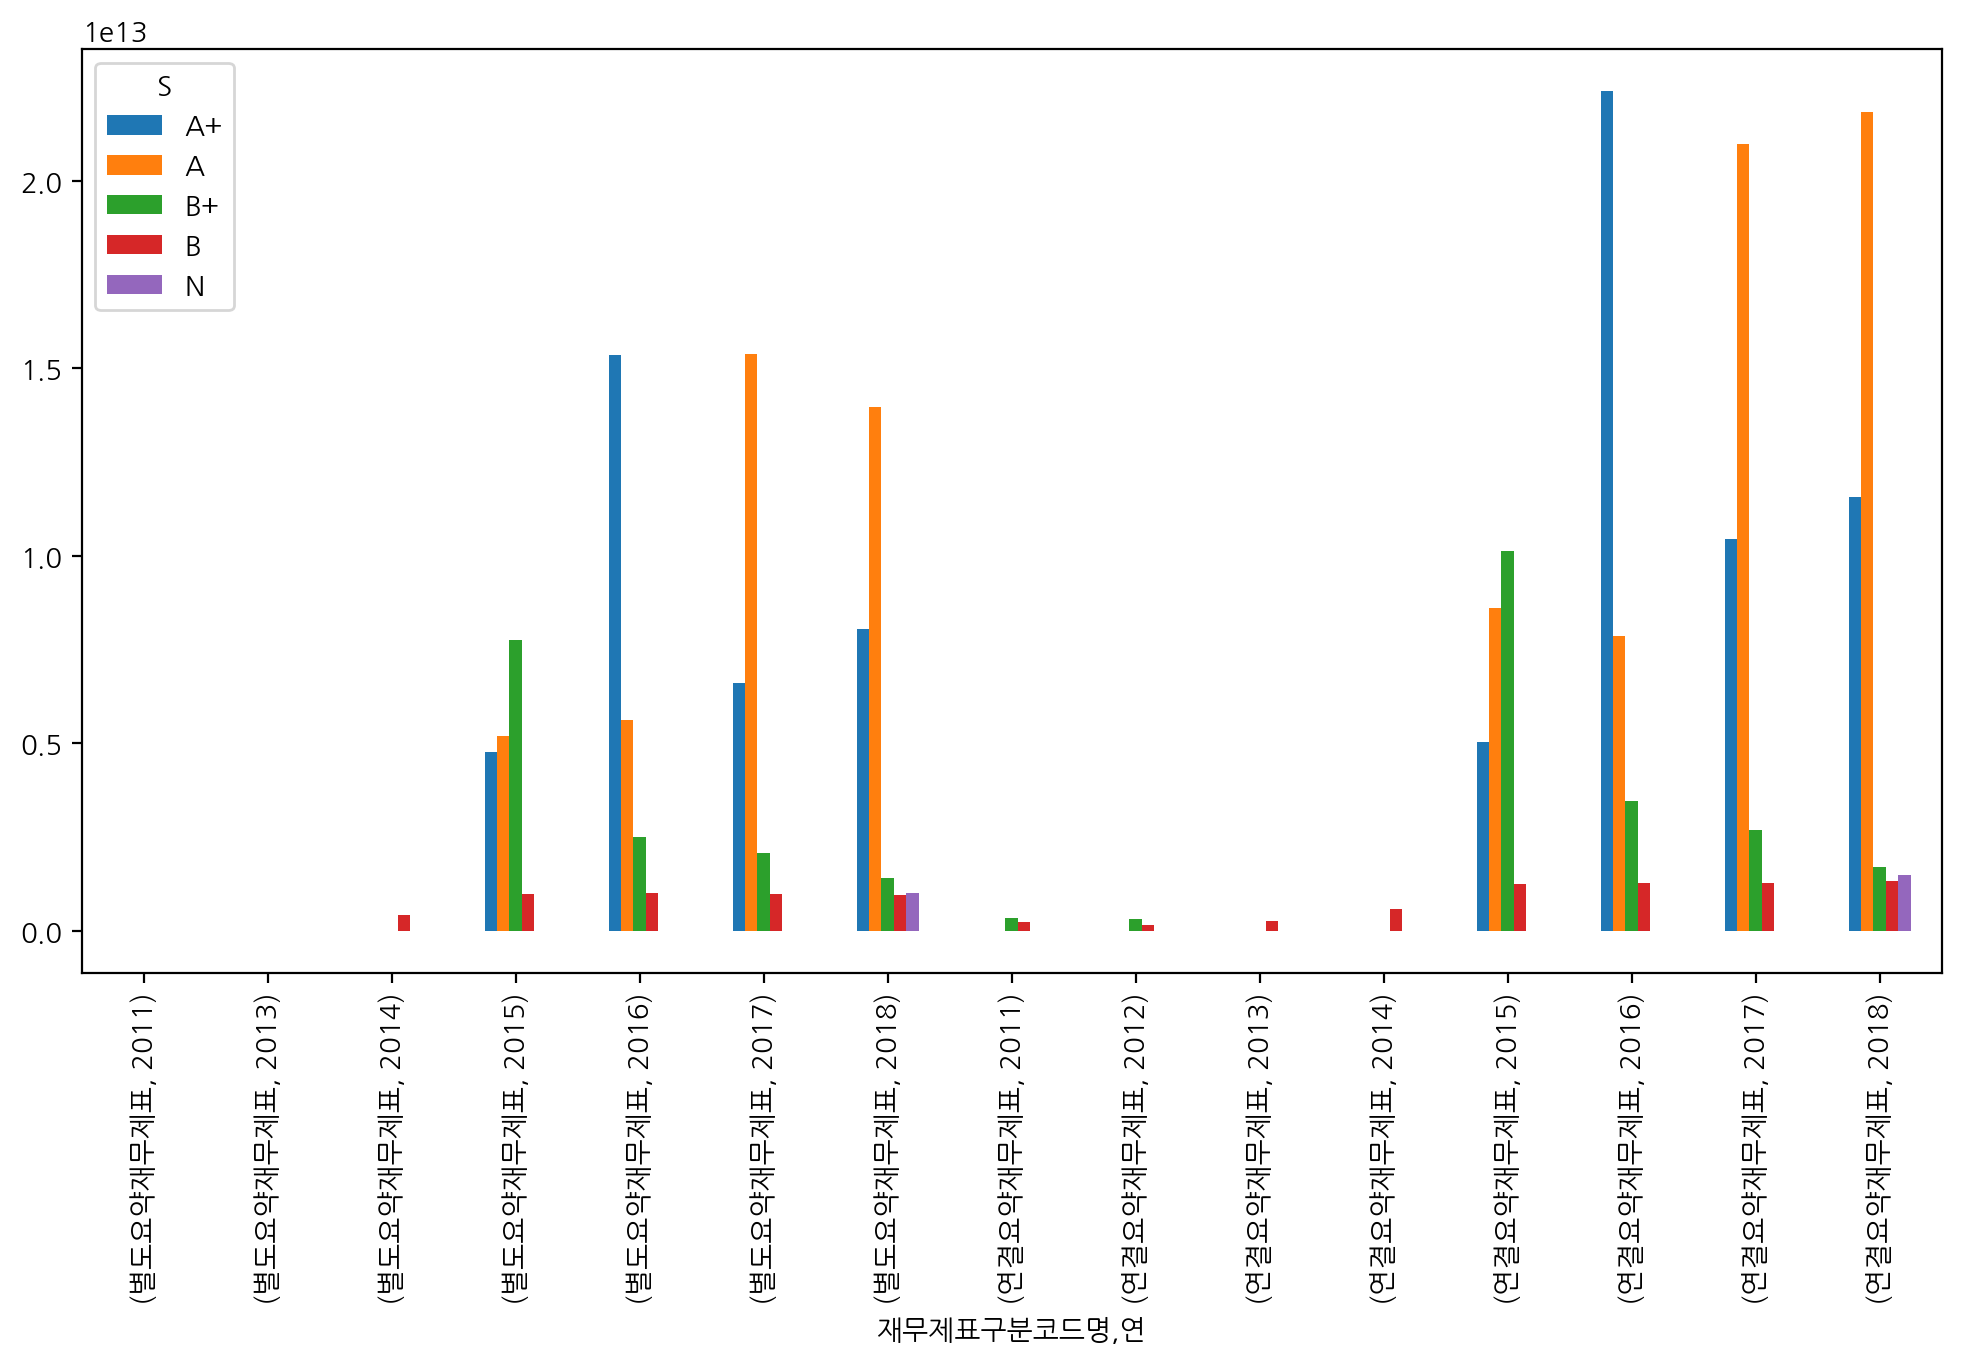

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자본금액
G


G                               A+                   A                 B+  \
재무제표구분코드명 연                                                                 
별도요약재무제표  2011                 NaN                 NaN                NaN   
          2013                 NaN                 NaN                NaN   
          2014                 NaN                 NaN                NaN   
          2015 51566720743920.3359  5625040280418.9229 2708789099039.3887   
          2016  4012315903898.0000  9818343249820.8535 2393183362965.5654   
          2017  3746242969432.0000 12726279874793.0000 1925406849082.3137   
          2018 10013156159464.5000 12914370935178.6289 3311941730923.6040   
연결요약재무제표  2011                 NaN                 NaN  333776000000.0000   
          2012                 NaN                 NaN  317335000000.0000   
          2013                 NaN                 NaN                NaN   
          2014                 NaN                 NaN  652800666666.6666   
          2015 65956194642567.0000  8249142629523.0000 3336516776368.2158   
          2016  4337585298432.0000 13906748435428.5000 2898828873451.1592   
          2017  4331491386330.0000 17972719950186.3438 2214545072945.8750   
          2018 11818316640081.5000 19559050649914.7305 4065456825880.2998   

G                               B                  N  
재무제표구분코드명 연                                           
별도요약재무제표  2011                NaN     125169499.0000  
          2013   -3739311000.0000                NaN  
          2014  409512018000.0000                NaN  
          2015  723932162299.8132                NaN  
          2016  835906090867.3500                NaN  
          2017  990186136355.3939                NaN  
          2018  895780593069.5369  992855503785.6666  
연결요약재무제표  2011  265462500000.0000  184320000000.0000  
          2012  154780000000.0000                NaN  
          2013  260153500000.0000                NaN  
          2014  334851000000.0000                NaN  
          2015 1037342134356.2593                NaN  
          2016 1170770689313.4443                NaN  
          2017 1545929887965.3186                NaN  
          2018 1338213531336.7273 1481257249456.0000

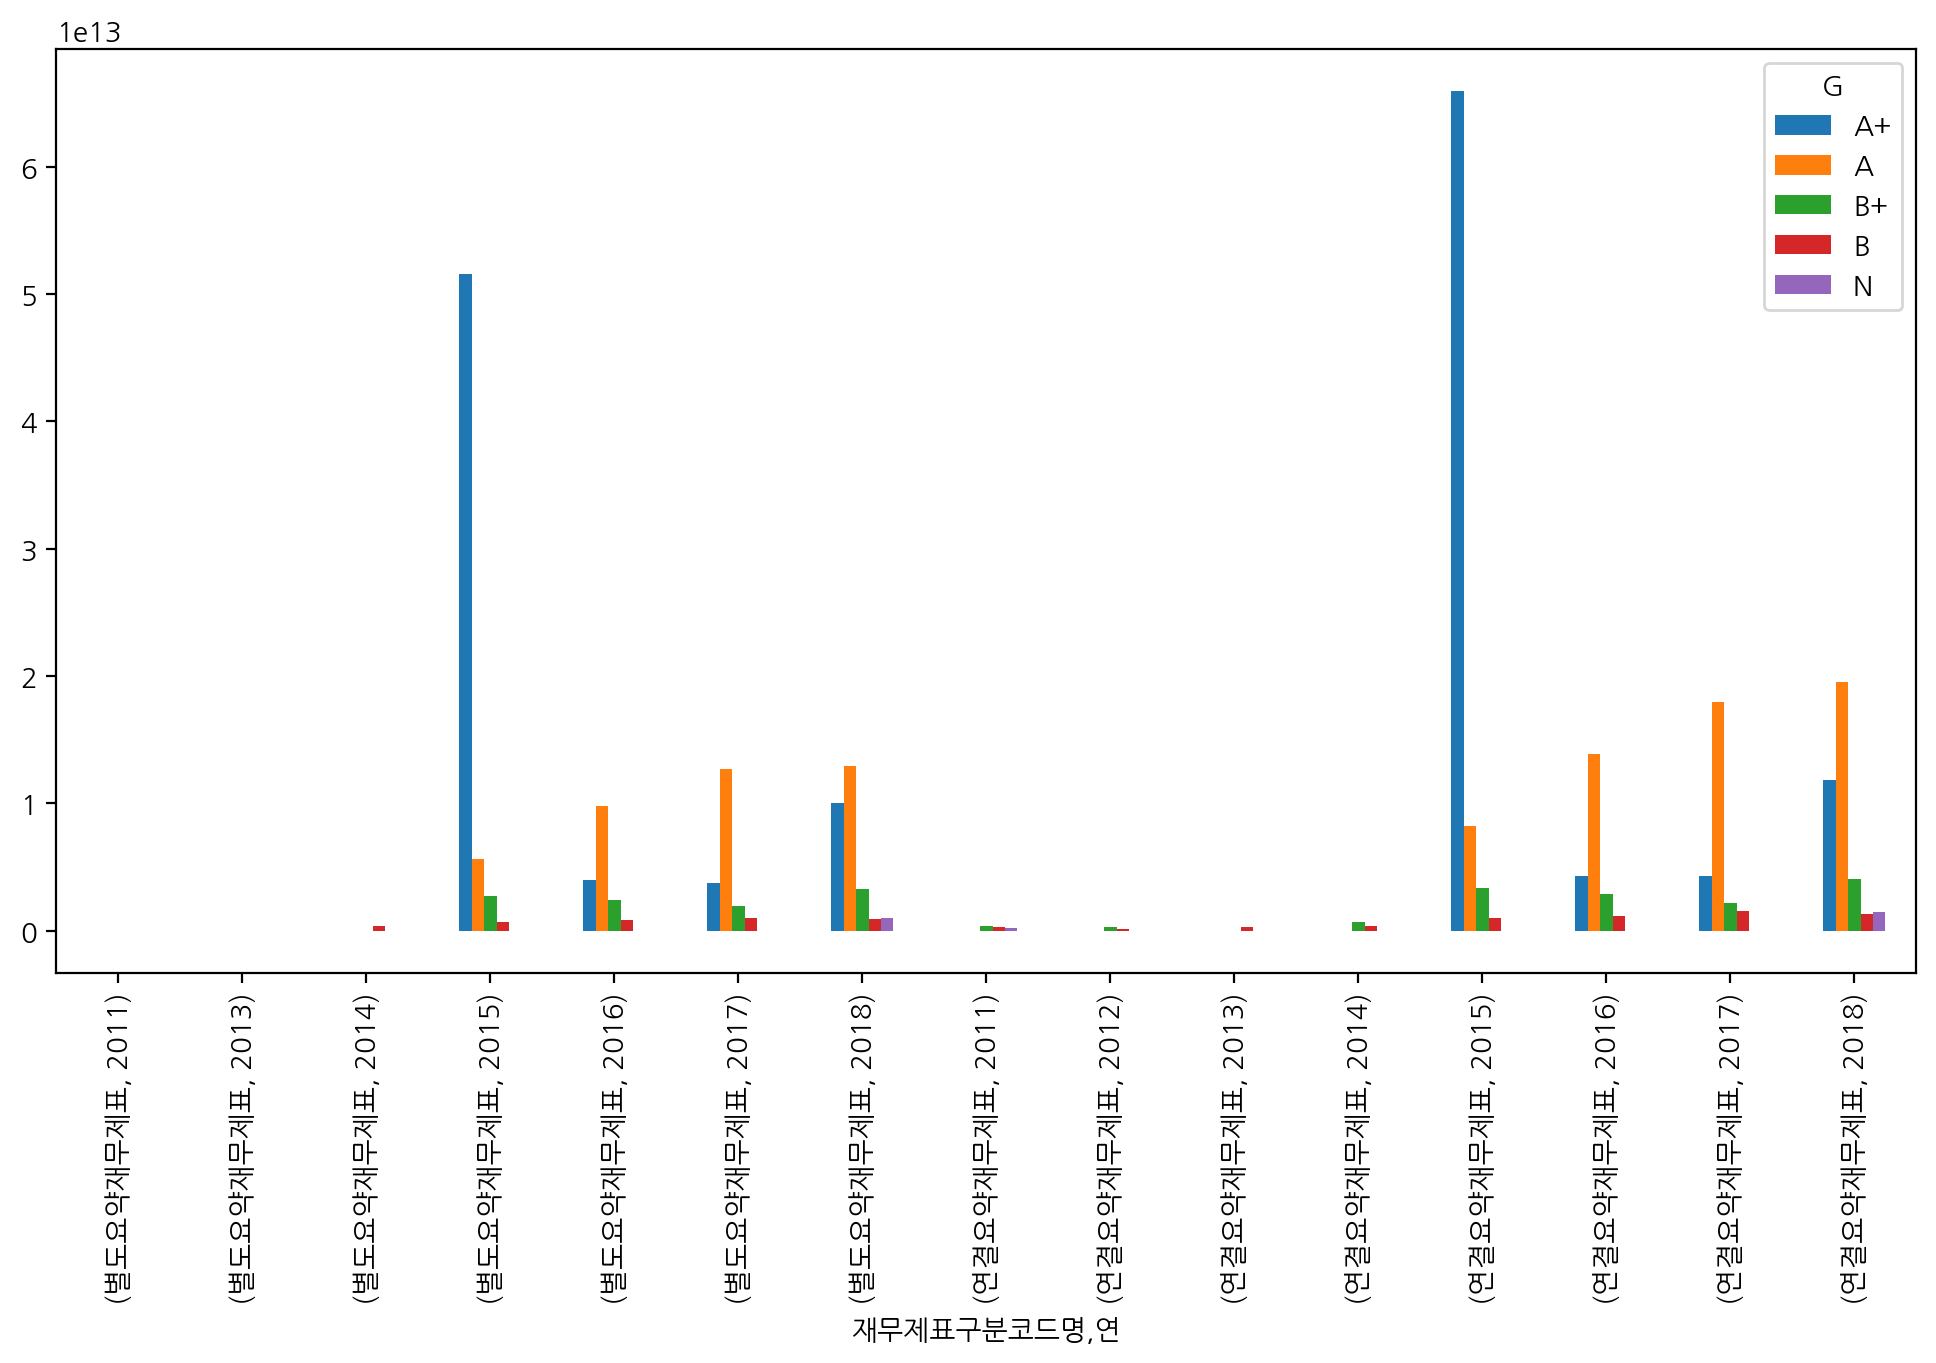

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업자본금액
ESG종합


ESG종합                         A+                 A                B+  \
재무제표구분코드명 연                                                            
별도요약재무제표  2011               NaN               NaN               NaN   
          2013               NaN               NaN               NaN   
          2014               NaN               NaN               NaN   
          2015               NaN 110378200000.0000  60624101756.7568   
          2016 226505133333.3333 120545881538.4615  84358595760.8696   
          2017 231633466666.6667 539332922706.2500 276698034443.1818   
          2018  92666937075.0000 537415295304.3478 326727084974.5582   
연결요약재무제표  2011               NaN               NaN  37080000000.0000   
          2012               NaN               NaN  37080000000.0000   
          2013               NaN               NaN               NaN   
          2014               NaN               NaN 139359000000.0000   
          2015               NaN  37811566538.4615  74774219683.7838   
          2016  97170666666.6667  37811566538.4615  95701064659.0909   
          2017 231633466666.6667 539332922706.2500 231589986387.5000   
          2018  92666937075.0000 561843263272.7273 263443904829.2683   

ESG종합                          B                N  
재무제표구분코드명 연                                        
별도요약재무제표  2011     36369015.0000              NaN  
          2013   5896603000.0000              NaN  
          2014  19295620000.0000              NaN  
          2015  39096961455.6452              NaN  
          2016  31023268945.3782              NaN  
          2017  81879477846.3051              NaN  
          2018  65538802872.5607 70200849166.6667  
연결요약재무제표  2011  27044000000.0000              NaN  
          2012  43398500000.0000              NaN  
          2013  36046000000.0000              NaN  
          2014 220248333333.3333              NaN  
          2015  36462231538.7387              NaN  
          2016  34259360059.6330              NaN  
          2017  84716593966.9454              NaN  
          2018  66806384872.3636 70200849166.6667

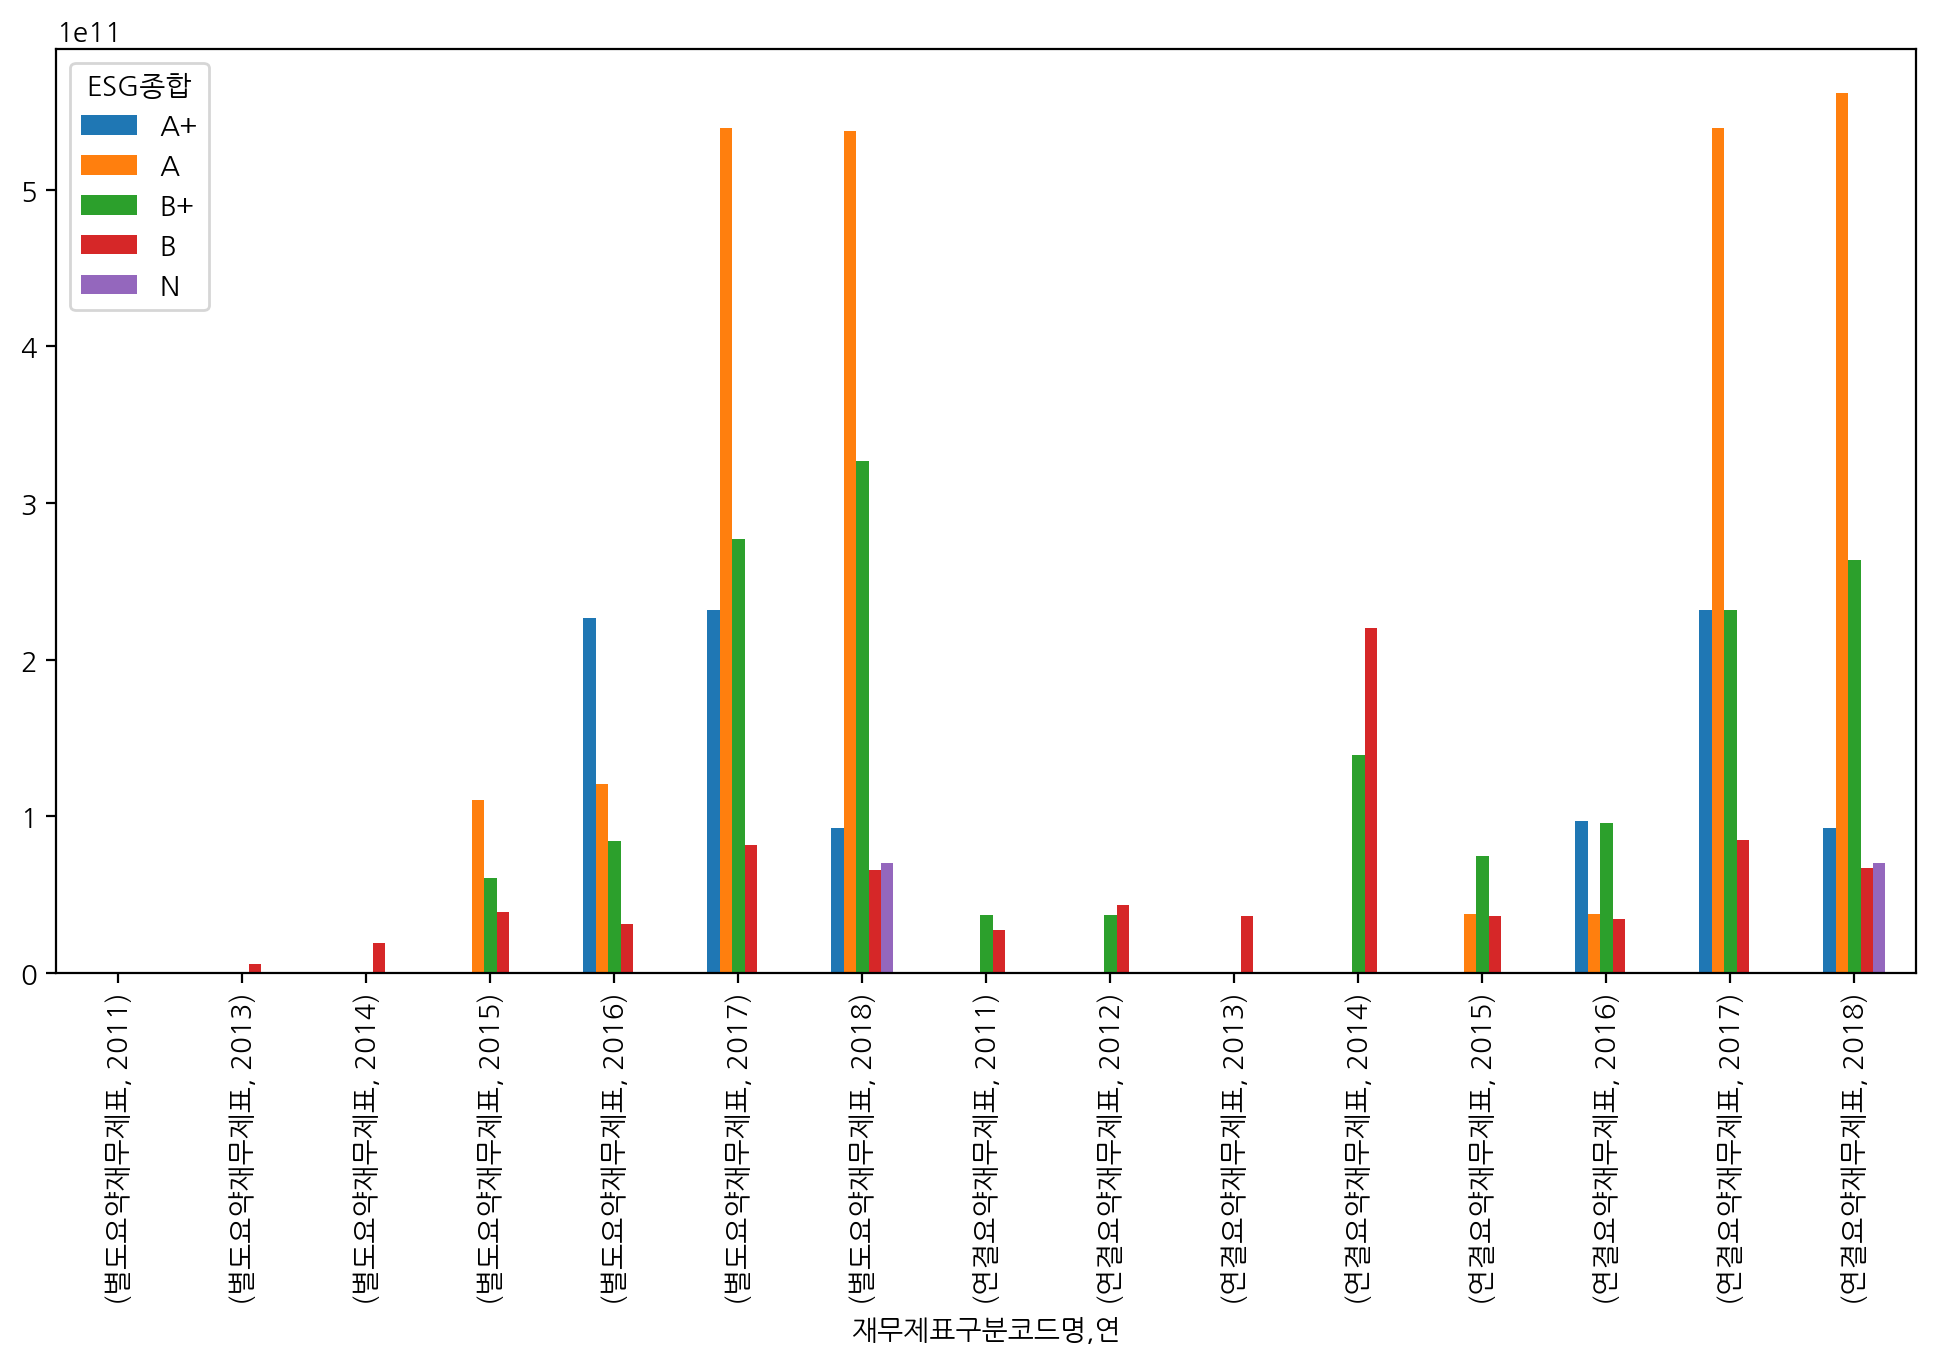

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업자본금액
E


E                             A+                 A                B+  \
재무제표구분코드명 연                                                            
별도요약재무제표  2011               NaN               NaN               NaN   
          2013               NaN               NaN               NaN   
          2014               NaN               NaN               NaN   
          2015               NaN  47531057727.2727  76040586457.1429   
          2016 169878850000.0000  87054667777.7778  81714267985.2941   
          2017 153448500000.0000 469557414275.0000 263594167537.0370   
          2018 117178666666.6667 251468227358.3333 353949655016.4727   
연결요약재무제표  2011               NaN               NaN               NaN   
          2012               NaN               NaN               NaN   
          2013               NaN               NaN               NaN   
          2014               NaN               NaN 139359000000.0000   
          2015               NaN  12258021363.6364  89842184588.2353   
          2016  72878000000.0000  14982026111.1111  57284690671.8750   
          2017 153448500000.0000 501154397936.3636 224642661019.6078   
          2018 117178666666.6667 274152659572.7273 304582420000.0000   

E                              B                 C                 D  
재무제표구분코드명 연                                                           
별도요약재무제표  2011     36369015.0000               NaN               NaN  
          2013   5896603000.0000               NaN               NaN  
          2014               NaN  19295620000.0000               NaN  
          2015  32543311014.4928  48075862044.6429 134677563333.3333  
          2016  41953145645.5696  42116853659.5745  35474140000.0000  
          2017  87671088126.6667 119008767262.1333 104931677375.0000  
          2018 121264065910.3243  69550139083.3333  17884640833.3333  
연결요약재무제표  2011  35148333333.3333  12767000000.0000               NaN  
          2012  33017500000.0000  57842000000.0000               NaN  
          2013               NaN  36046000000.0000               NaN  
          2014               NaN 220248333333.3333               NaN  
          2015  34094014363.3333  31677430442.3077 105791109575.0000  
          2016  59410717437.5000  43941866409.0909  32213167812.5000  
          2017  92034319050.7246 122873551155.8571 104931677375.0000  
          2018 127243260278.2424  70235356189.6552  17884640833.3333

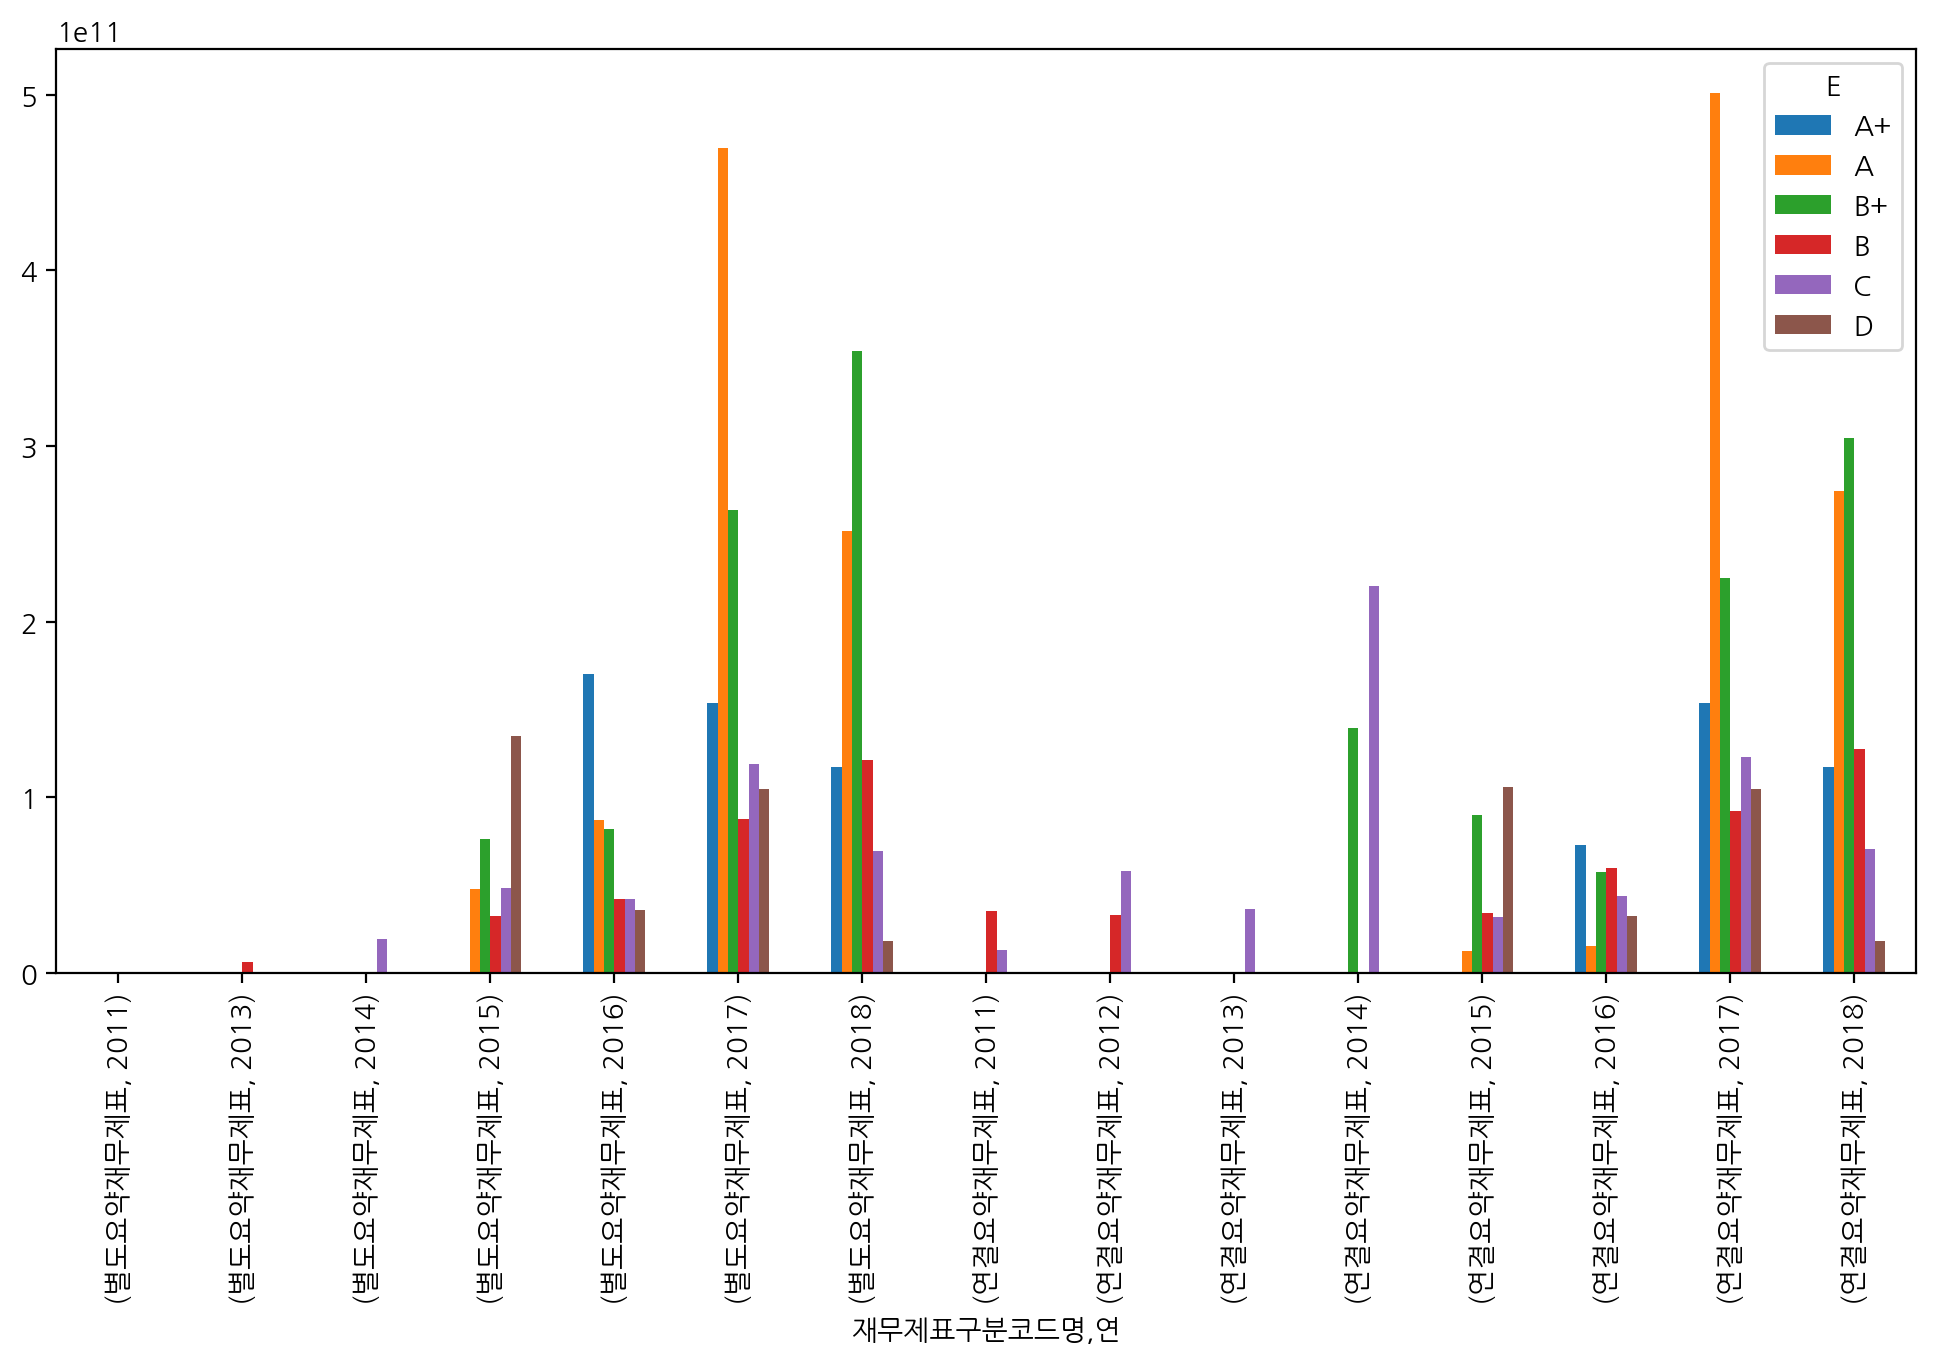

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업자본금액
S


S                             A+                 A                B+  \
재무제표구분코드명 연                                                            
별도요약재무제표  2011               NaN               NaN               NaN   
          2013               NaN               NaN               NaN   
          2014               NaN               NaN               NaN   
          2015  57125698333.3333 153290870000.0000  51812924423.0769   
          2016 118254099666.6667  81340962727.2727  71621070964.2857   
          2017 230281548900.0000 521212602694.4445 209790403877.4783   
          2018 446825249186.9565 371857893828.8571 126229713411.7647   
연결요약재무제표  2011               NaN               NaN  37080000000.0000   
          2012               NaN               NaN  37080000000.0000   
          2013               NaN               NaN               NaN   
          2014               NaN               NaN               NaN   
          2015            0.0000  48530986250.0000  73005167586.8421   
          2016  19434133333.3333 272728625500.0000  46614687794.1176   
          2017 237296735706.2500 521212602694.4445 164339152264.9756   
          2018 467135487786.3636 308991920500.0000 102278402180.0000   

S                              B                N  
재무제표구분코드명 연                                        
별도요약재무제표  2011     36369015.0000              NaN  
          2013   5896603000.0000              NaN  
          2014  19295620000.0000              NaN  
          2015  33459452741.3793              NaN  
          2016  31712466772.7273              NaN  
          2017  82137473065.0000              NaN  
          2018 113041758730.0488 70200849166.6667  
연결요약재무제표  2011  27044000000.0000              NaN  
          2012  43398500000.0000              NaN  
          2013  36046000000.0000              NaN  
          2014 200026000000.0000              NaN  
          2015  36103961978.8462              NaN  
          2016  35828302408.6021              NaN  
          2017  85001830771.2766              NaN  
          2018 118460058811.5200 70200849166.6667

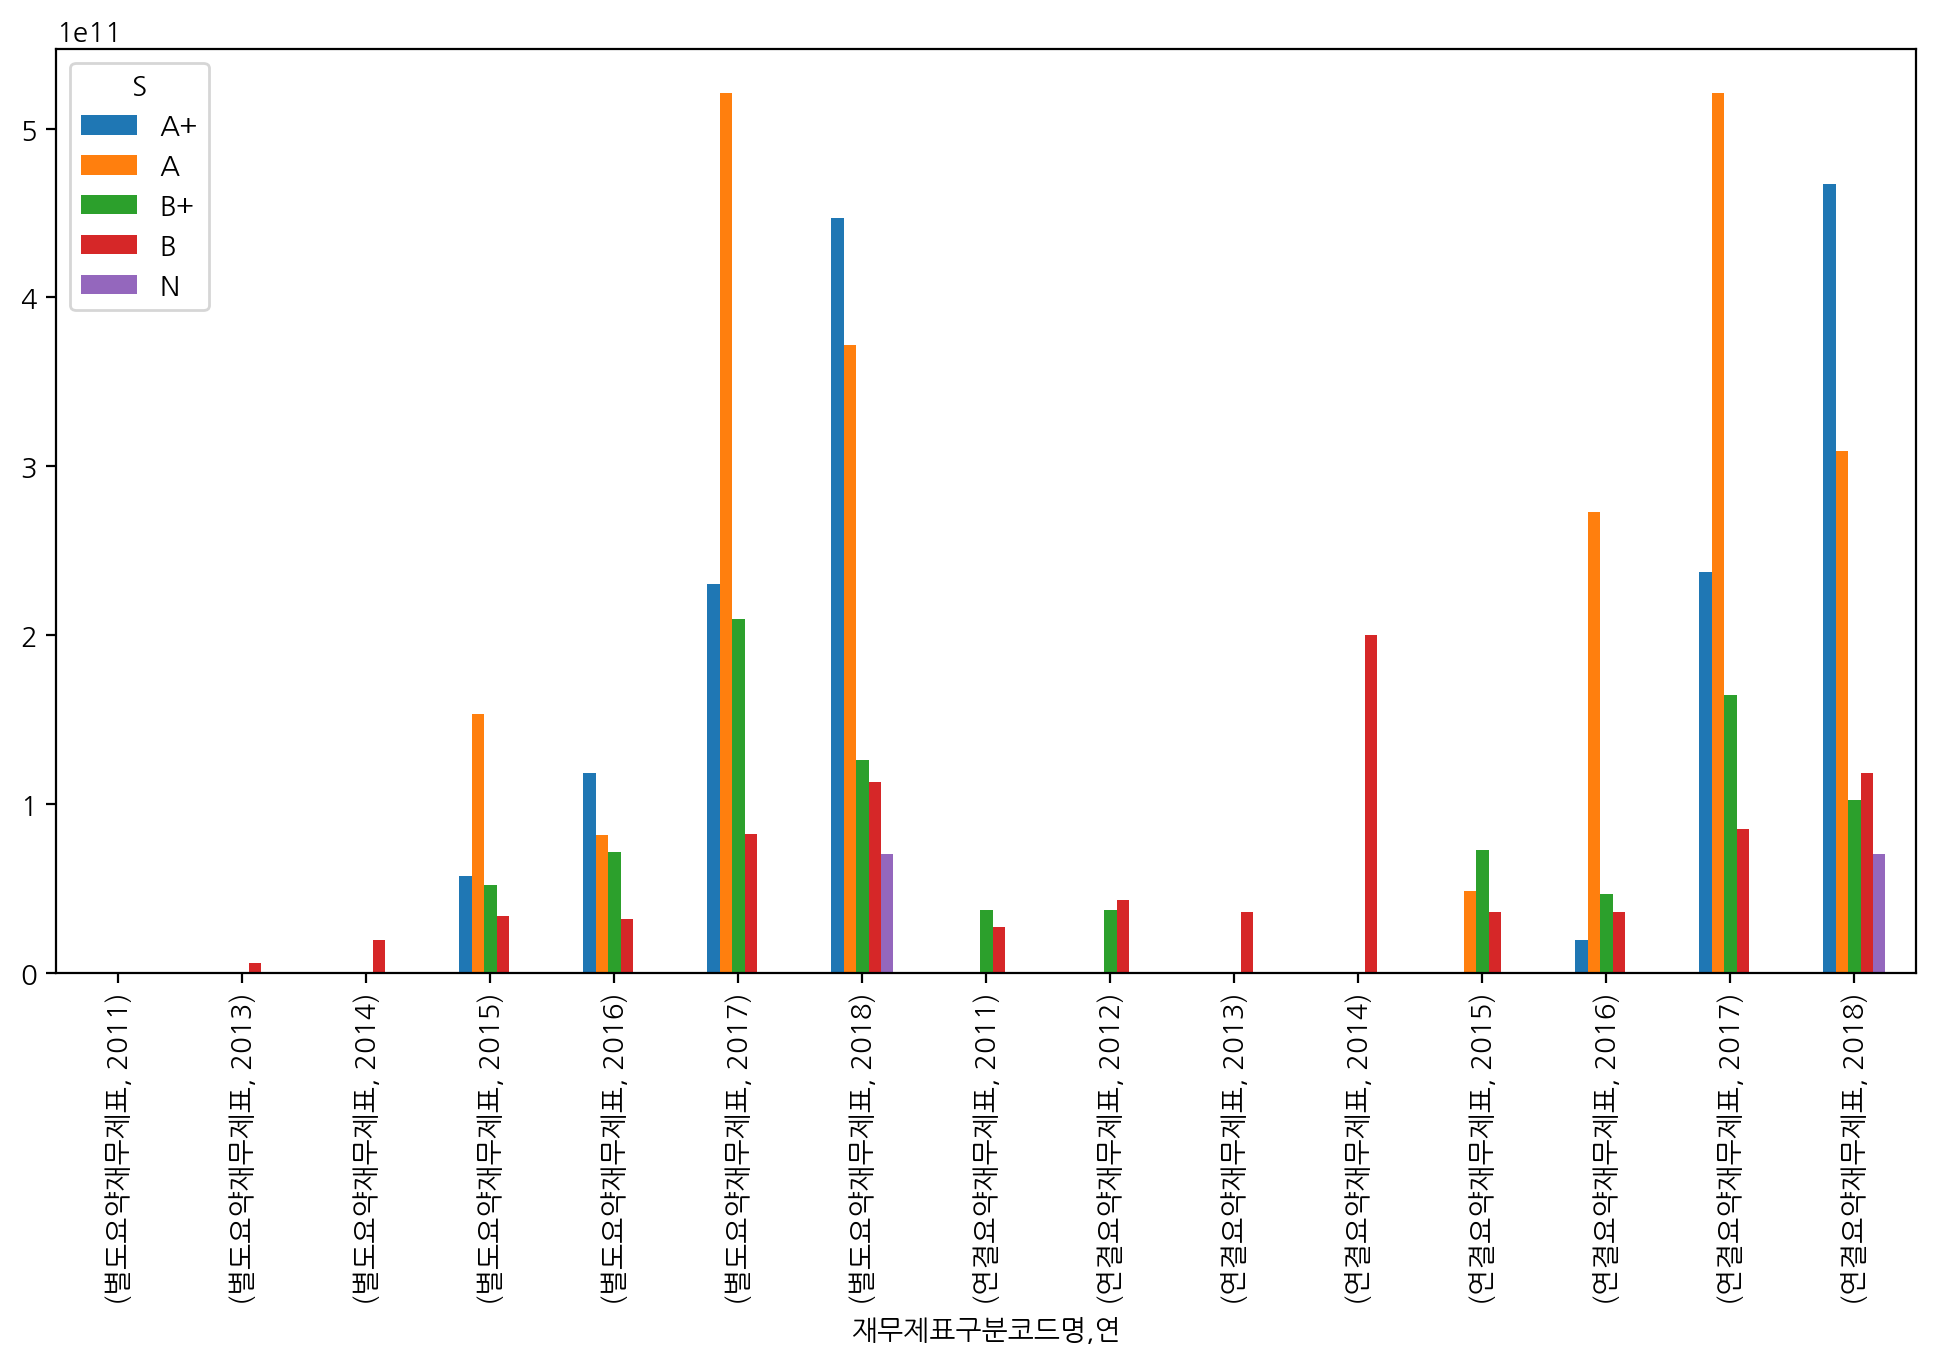

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업자본금액
G


G                             A+                 A                B+  \
재무제표구분코드명 연                                                            
별도요약재무제표  2011               NaN               NaN               NaN   
          2013               NaN               NaN               NaN   
          2014               NaN               NaN               NaN   
          2015 176029741666.6667 106988198461.5385  58688486814.8148   
          2016 388003400000.0000 122722508676.4706  63302387239.1304   
          2017 388003400000.0000 502170196043.3333 172415160075.7647   
          2018  29897073150.0000 550085334148.1482 257700359410.7547   
연결요약재무제표  2011               NaN               NaN  37080000000.0000   
          2012               NaN               NaN  37080000000.0000   
          2013               NaN               NaN               NaN   
          2014               NaN               NaN 254341333333.3333   
          2015 118904043333.3333  43256414165.3846  86945525858.8235   
          2016            0.0000 119635100735.2941  71192522454.5455   
          2017 388003400000.0000 430465271768.9655 177250896330.5000   
          2018  29897073150.0000 471949654692.3077 260943878597.2800   

G                             B                N  
재무제표구분코드명 연                                       
별도요약재무제표  2011              NaN    36369015.0000  
          2013  5896603000.0000              NaN  
          2014 19295620000.0000              NaN  
          2015 22495284752.7473              NaN  
          2016 23463977615.0000              NaN  
          2017 69842794136.3636              NaN  
          2018 54978093521.0526 70200849166.6667  
연결요약재무제표  2011 19143000000.0000 42846000000.0000  
          2012 43398500000.0000              NaN  
          2013 36046000000.0000              NaN  
          2014 37080000000.0000              NaN  
          2015 17159302185.1852              NaN  
          2016 16979056038.8889              NaN  
          2017 71726512637.3626              NaN  
          2018 54188325482.9545 70200849166.6667

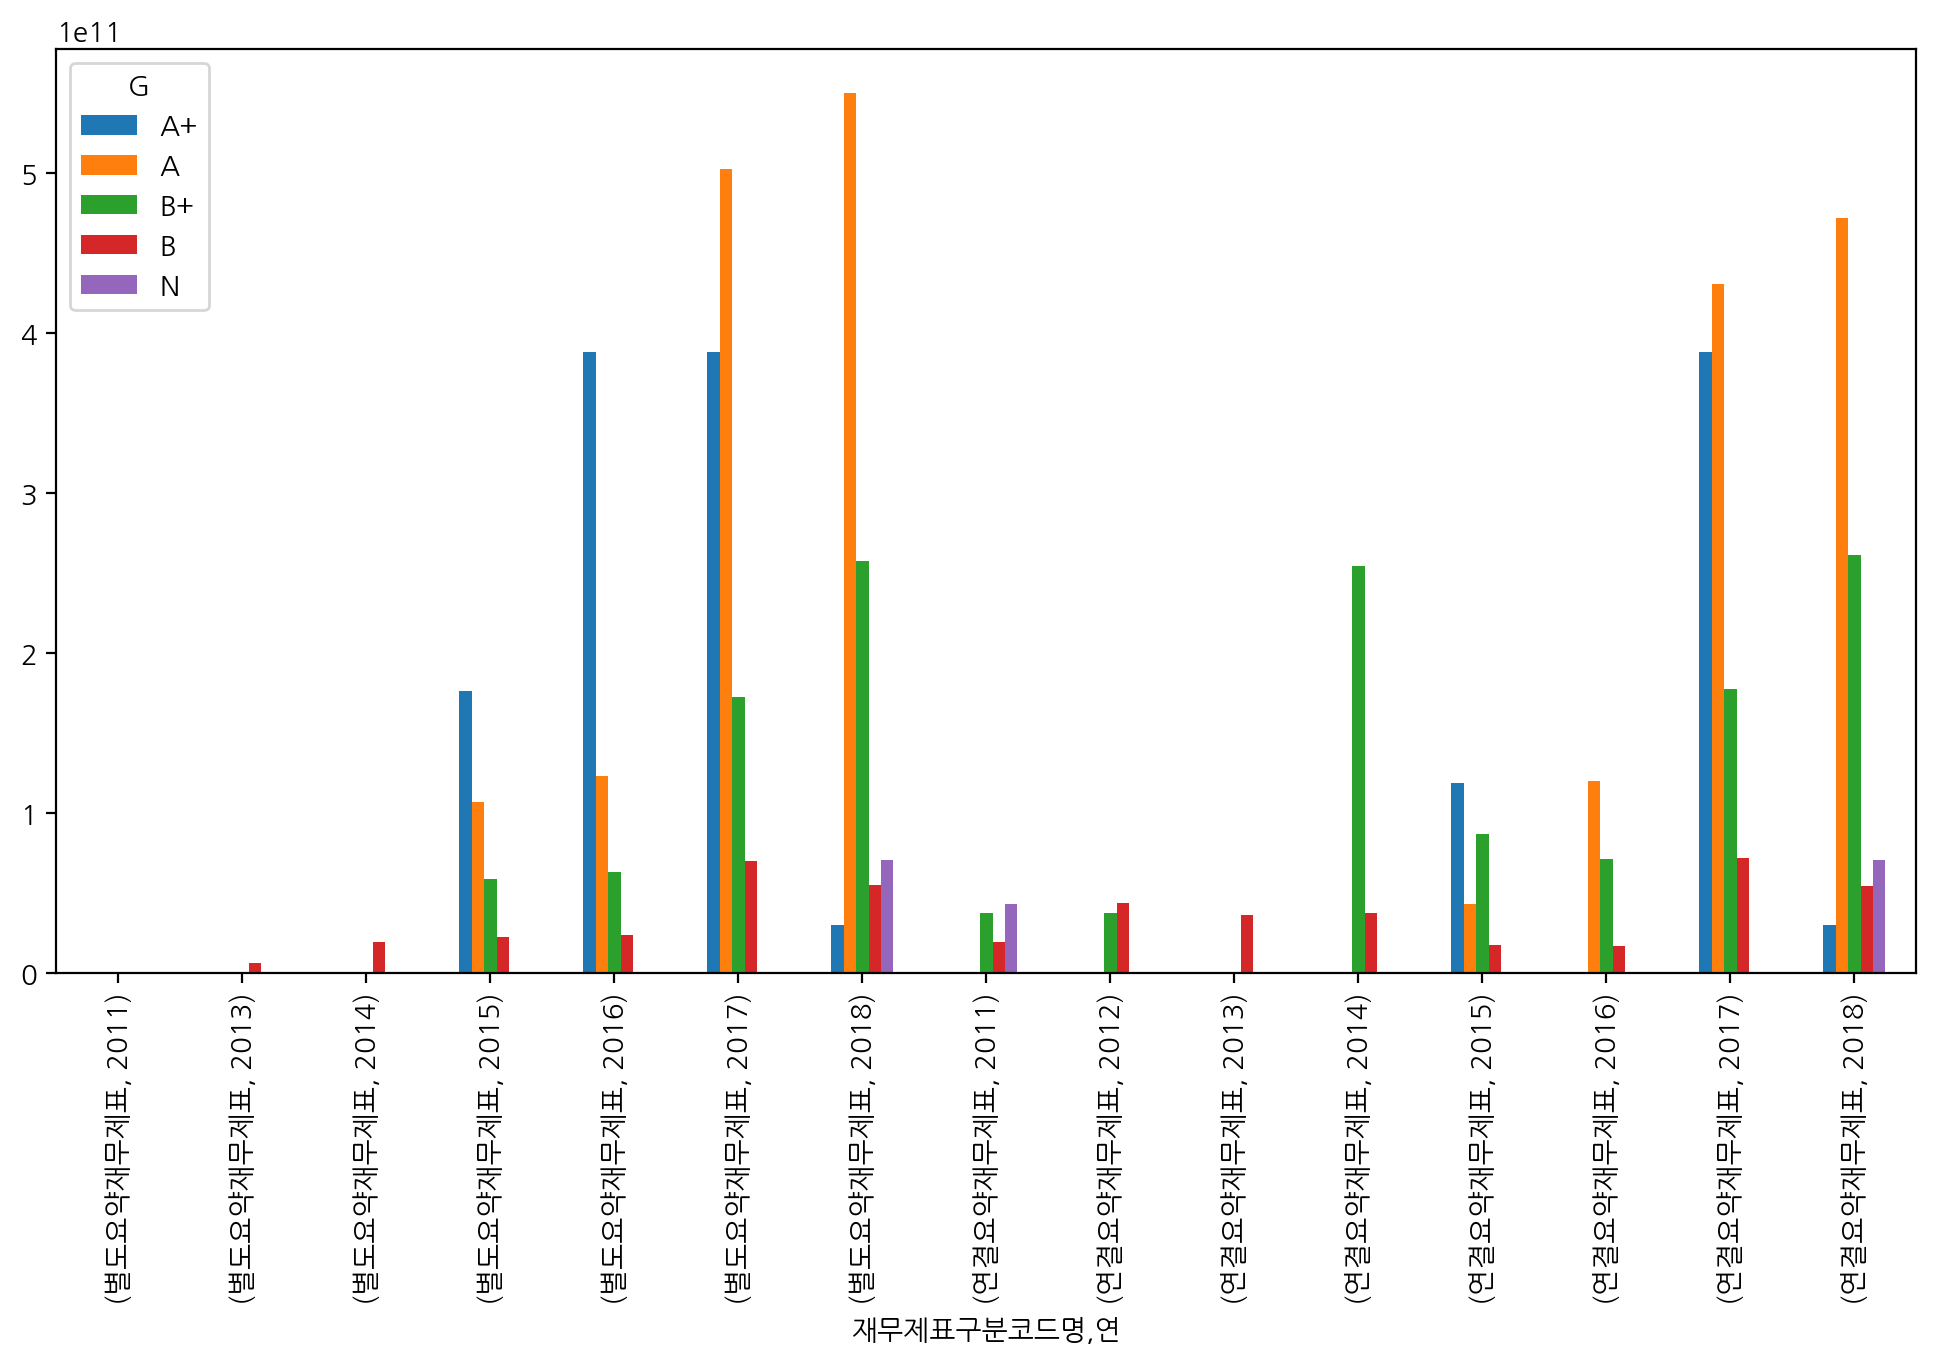

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

재무제표부채비율
ESG종합


ESG종합                A+        A       B+          B       N
재무제표구분코드명 연                                                 
별도요약재무제표  2011      NaN      NaN      NaN   152.1250     NaN
          2013      NaN      NaN      NaN -2400.0000     NaN
          2014      NaN      NaN      NaN    85.8750     NaN
          2015      NaN  64.3756 204.9141    76.7434     NaN
          2016  80.4531  66.0228 256.4311    60.1348     NaN
          2017  71.4167 105.1375  95.6269    70.9091     NaN
          2018  90.3359 100.6717  83.9992    67.7878 12.8672
연결요약재무제표  2011      NaN      NaN 130.2500   187.3958     NaN
          2012      NaN      NaN 161.2500   228.9375     NaN
          2013      NaN      NaN      NaN   177.7500     NaN
          2014      NaN      NaN 117.6875  1274.0834     NaN
          2015      NaN 103.4543 219.2426   120.7627     NaN
          2016 101.8958  95.3041 223.1641    99.8601     NaN
          2017 113.2292 154.2461 121.5686   112.6423     NaN
          2018 114.7500 162.1733 101.0053   104.4987 45.6758

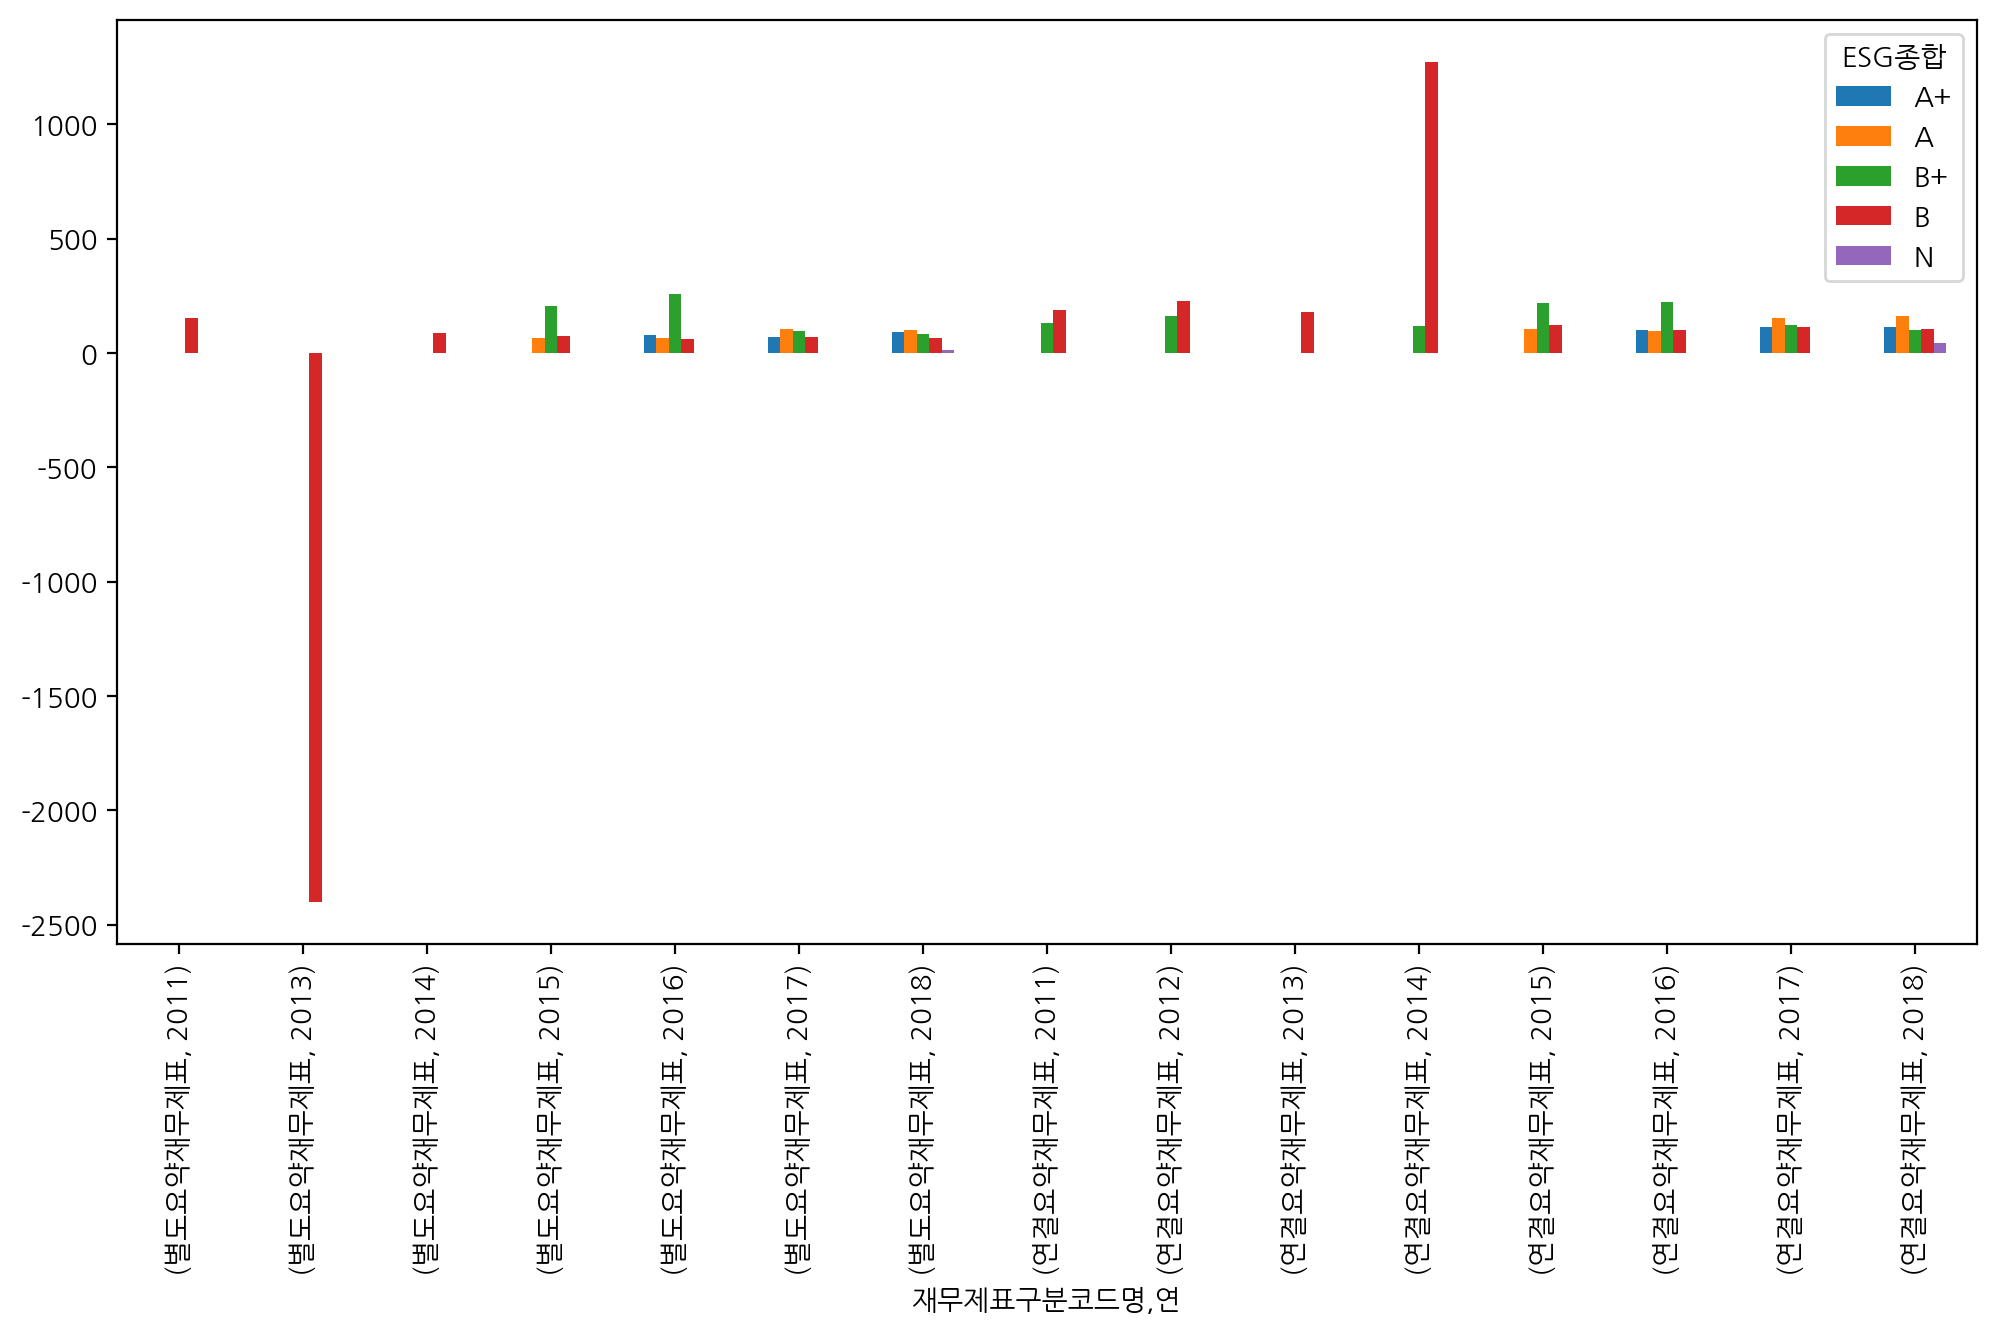

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

재무제표부채비율
E


E                    A+        A       B+          B         C        D
재무제표구분코드명 연                                                            
별도요약재무제표  2011      NaN      NaN      NaN   152.1250       NaN      NaN
          2013      NaN      NaN      NaN -2400.0000       NaN      NaN
          2014      NaN      NaN      NaN        NaN   85.8750      NaN
          2015      NaN  48.7807  89.9863   131.2146   73.6218 357.3854
          2016  63.1055  76.9162  79.4872    71.9689  216.6460  67.0488
          2017  91.1406  42.7604  97.6045    76.9868   74.8181  60.8381
          2018  94.0104  96.7039  79.8935    78.5278   52.8116  58.1047
연결요약재무제표  2011      NaN      NaN      NaN   194.0000  110.4375      NaN
          2012      NaN      NaN      NaN   216.3750  186.3750      NaN
          2013      NaN      NaN      NaN        NaN  177.7500      NaN
          2014      NaN      NaN 117.6875        NaN 1274.0834      NaN
          2015      NaN  84.2827 136.8056   166.9355  112.8702 349.4141
          2016  95.9219 114.6337 122.5396   109.2506  189.8924  86.3301
          2017 130.1875 144.1321 127.3736   115.7541   98.8075 120.6875
          2018 123.6458 205.9943 106.3935   111.6155   82.4343  85.1823

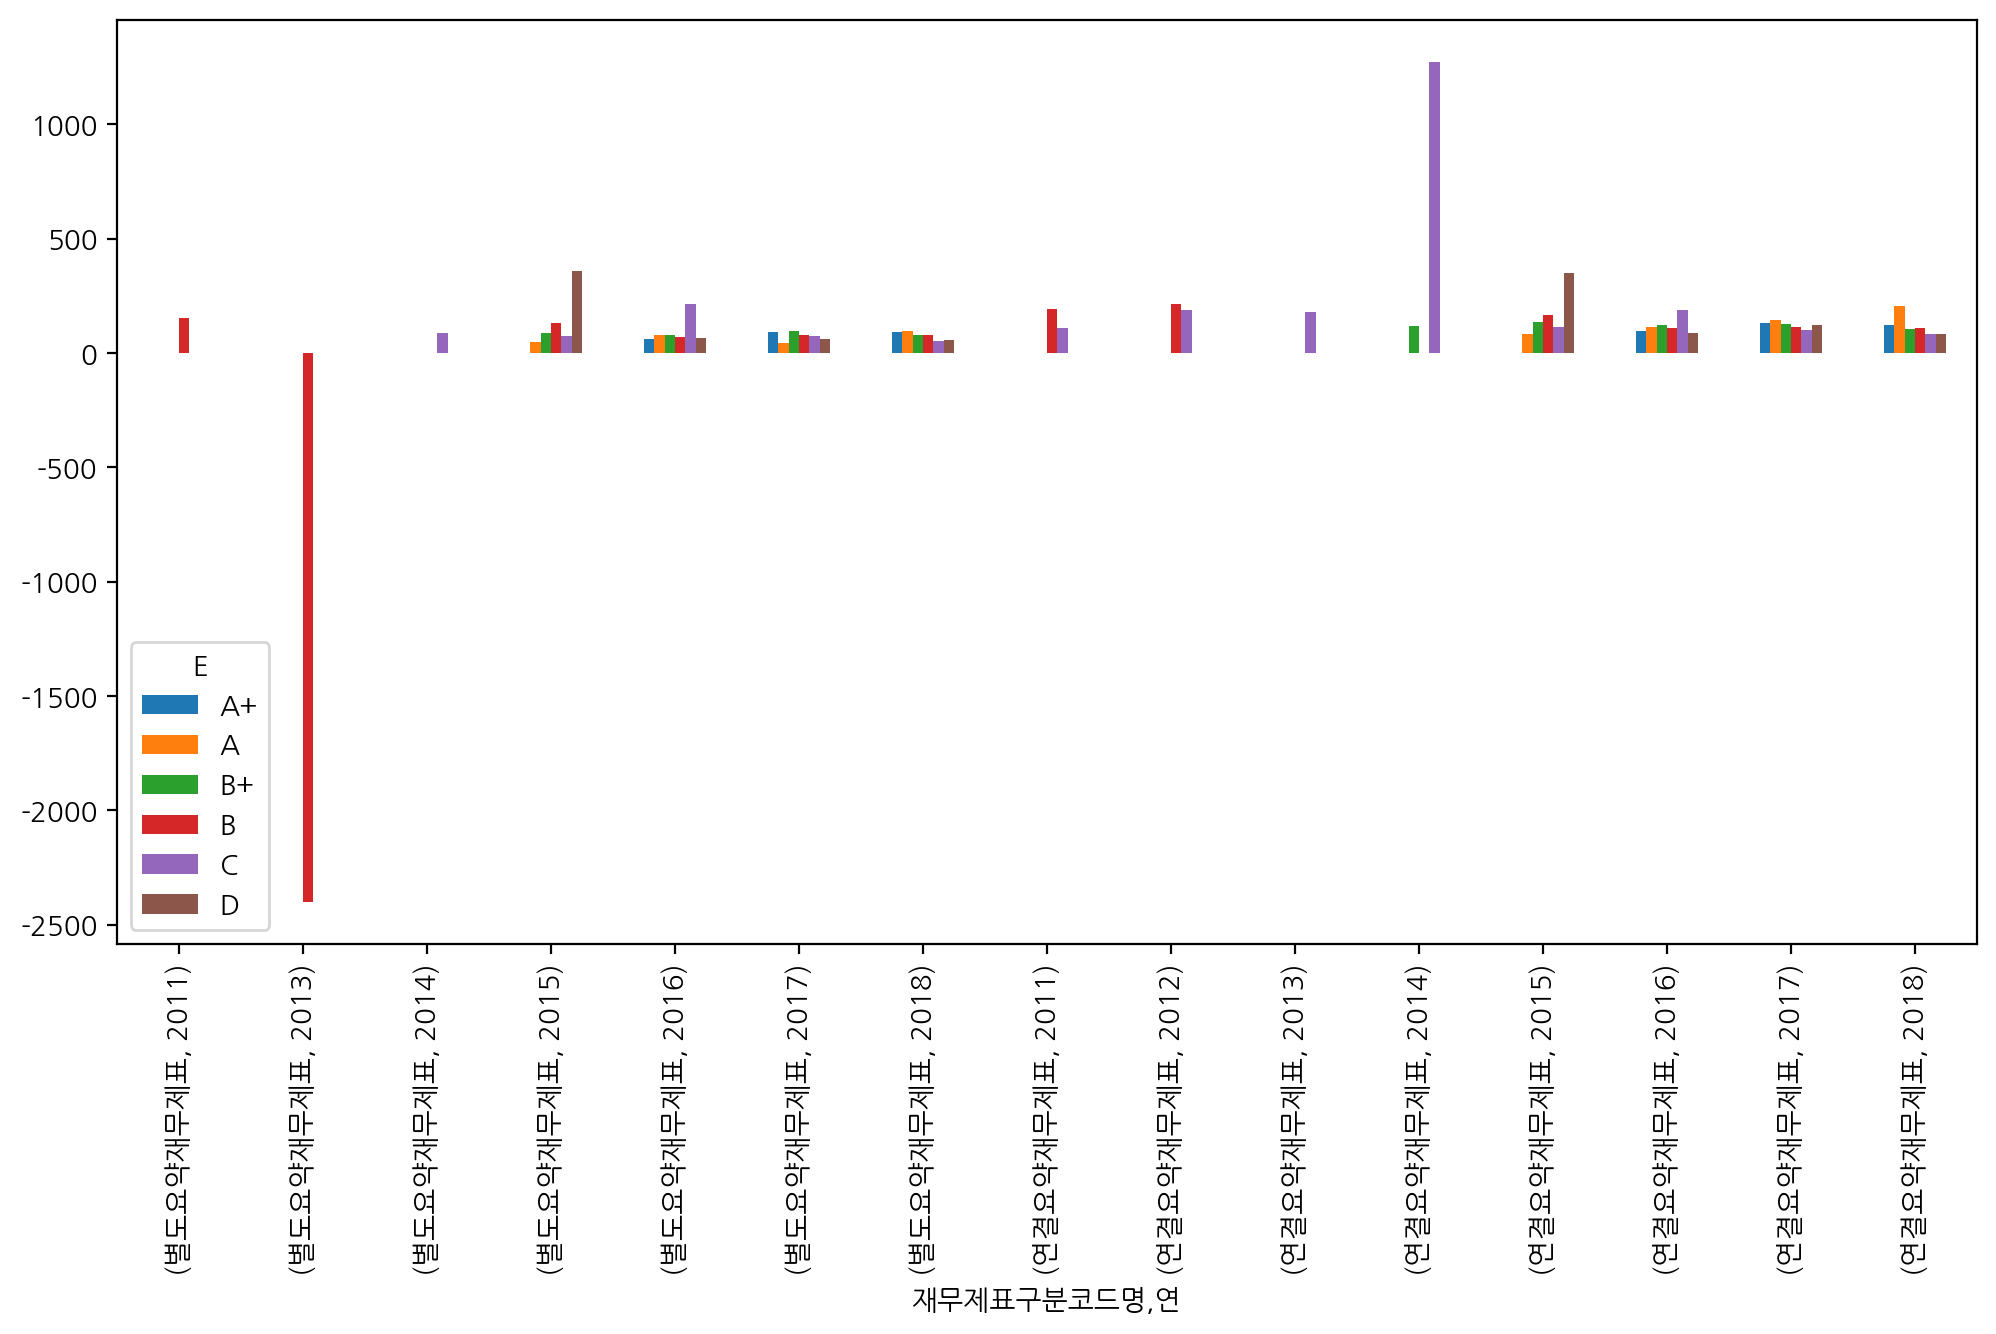

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

재무제표부채비율
S


S                    A+        A       B+          B       N
재무제표구분코드명 연                                                 
별도요약재무제표  2011      NaN      NaN      NaN   152.1250     NaN
          2013      NaN      NaN      NaN -2400.0000     NaN
          2014      NaN      NaN      NaN    85.8750     NaN
          2015  81.0833  78.3159 122.6108   100.4893     NaN
          2016  86.2833  57.7219 216.8077    60.4152     NaN
          2017  97.1526  72.7776 125.9854    57.1439     NaN
          2018  92.8395  97.7522  62.9867    74.8979 12.8672
연결요약재무제표  2011      NaN      NaN 130.2500   187.3958     NaN
          2012      NaN      NaN 161.2500   228.9375     NaN
          2013      NaN      NaN      NaN   177.7500     NaN
          2014      NaN      NaN      NaN   984.9844     NaN
          2015  83.7812 122.5430 169.5820   136.5903     NaN
          2016 112.2250 102.4984 195.2564   103.0341     NaN
          2017 143.4883 110.9531 168.2188    94.3733     NaN
          2018 121.0362 148.0280  91.5006   112.8406 45.6758

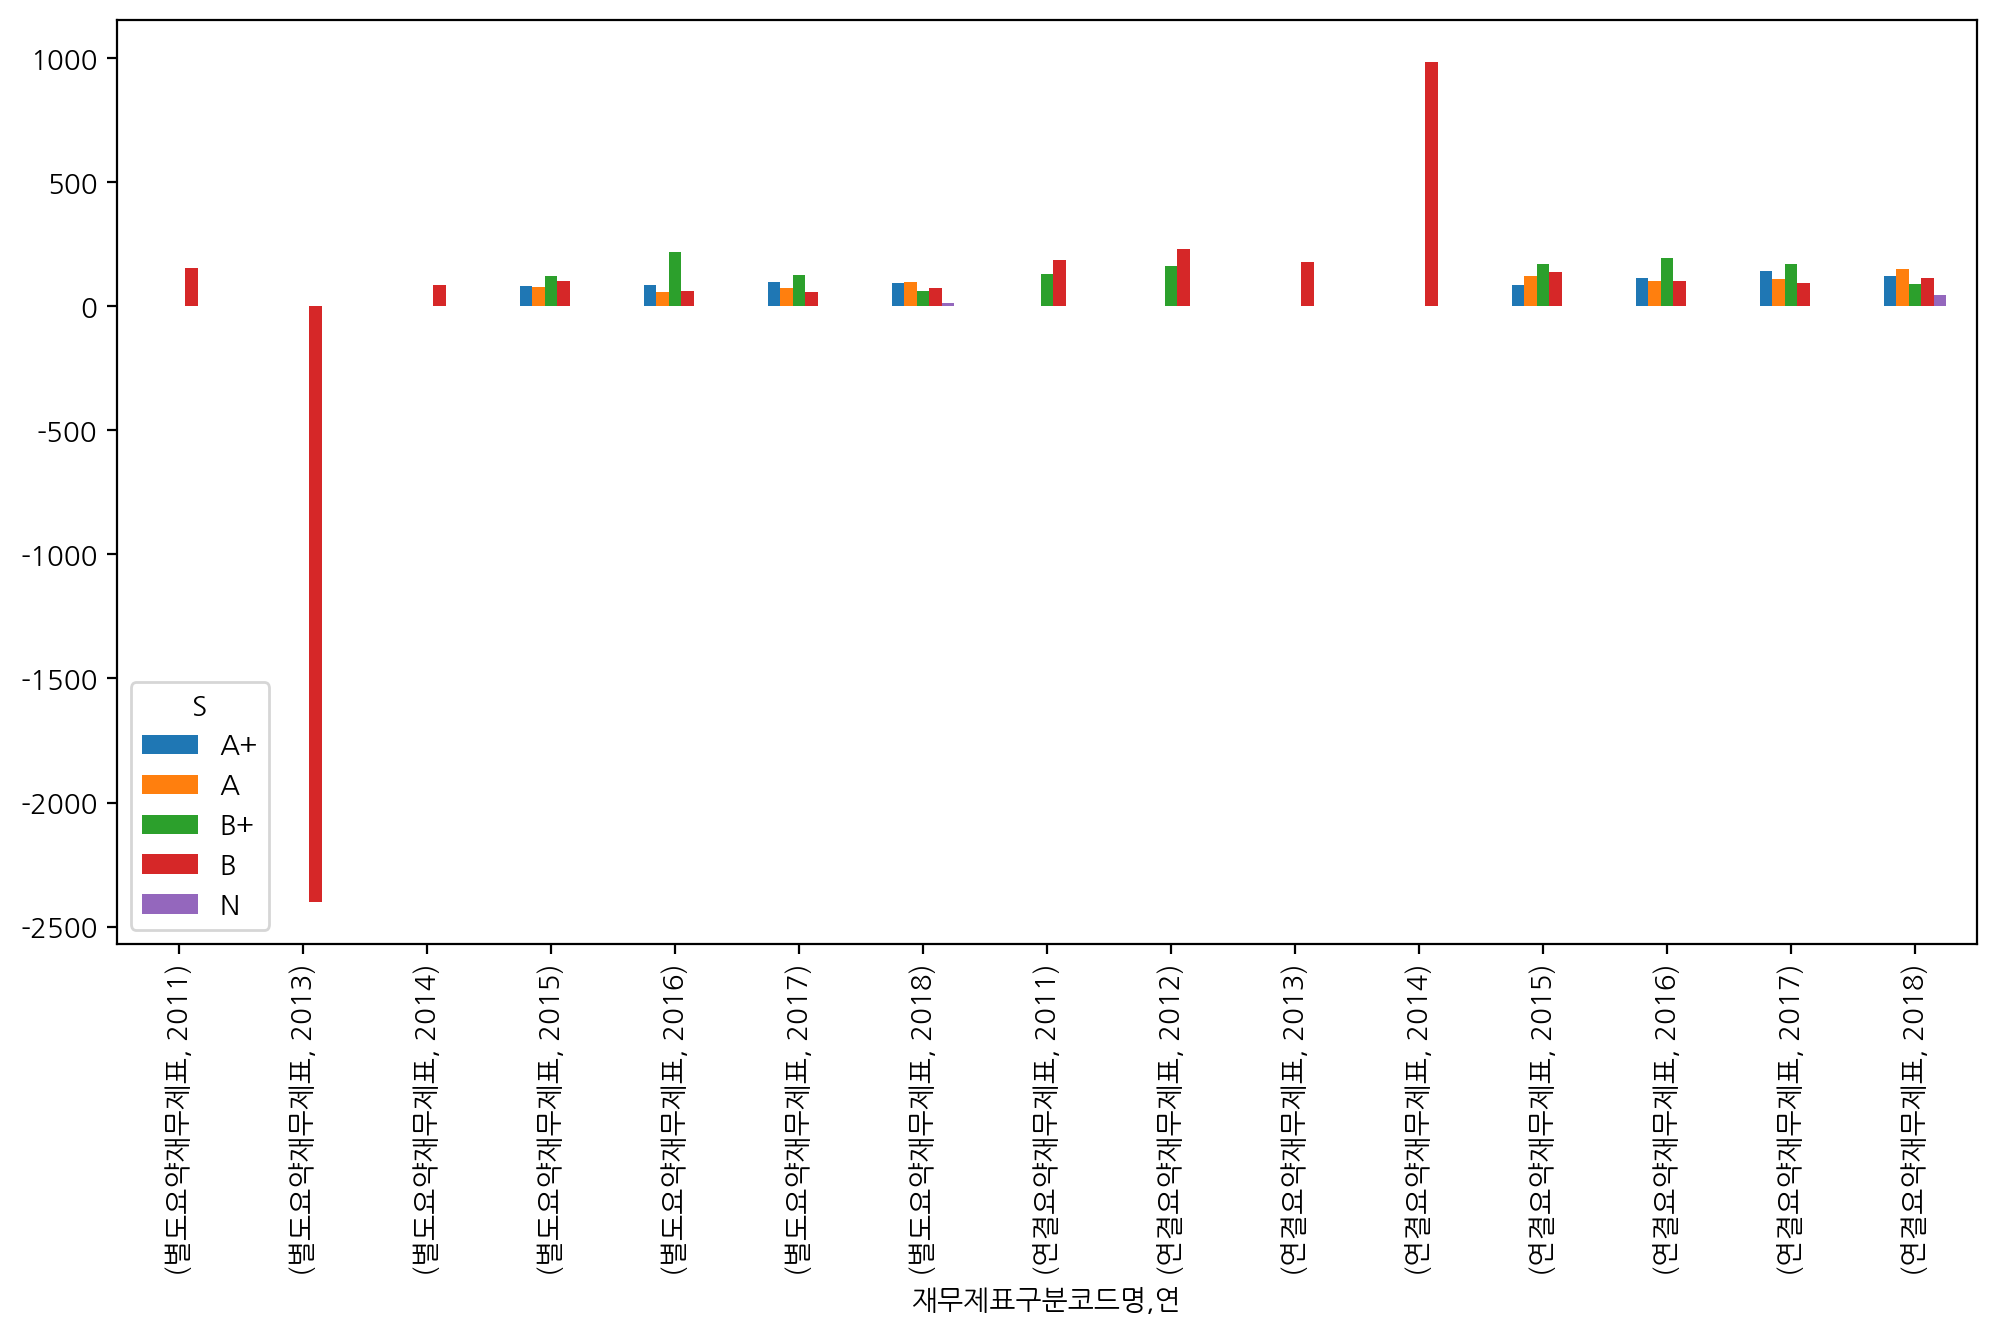

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

재무제표부채비율
G


G                    A+        A        B+          B        N
재무제표구분코드명 연                                                   
별도요약재무제표  2011      NaN      NaN       NaN        NaN 152.1250
          2013      NaN      NaN       NaN -2400.0000      NaN
          2014      NaN      NaN       NaN    85.8750      NaN
          2015  33.4844 296.4997   87.8585    59.1328      NaN
          2016  26.4219 303.9118   84.9195    57.8581      NaN
          2017  31.9688 120.7562   95.4031    60.1121      NaN
          2018  92.9375  97.8212  104.4256    54.5310  12.8672
연결요약재무제표  2011      NaN      NaN  130.2500   202.2188 157.7500
          2012      NaN      NaN  161.2500   228.9375      NaN
          2013      NaN      NaN       NaN   177.7500      NaN
          2014      NaN      NaN 1268.2291   135.2500      NaN
          2015  43.7396 318.8341  119.8666   102.8079      NaN
          2016  76.6875 246.1815  112.3024    98.4494      NaN
          2017  79.3125 157.2710  120.6974   105.7953      NaN
          2018 103.3750 145.9225  123.1669    94.9355  45.6758

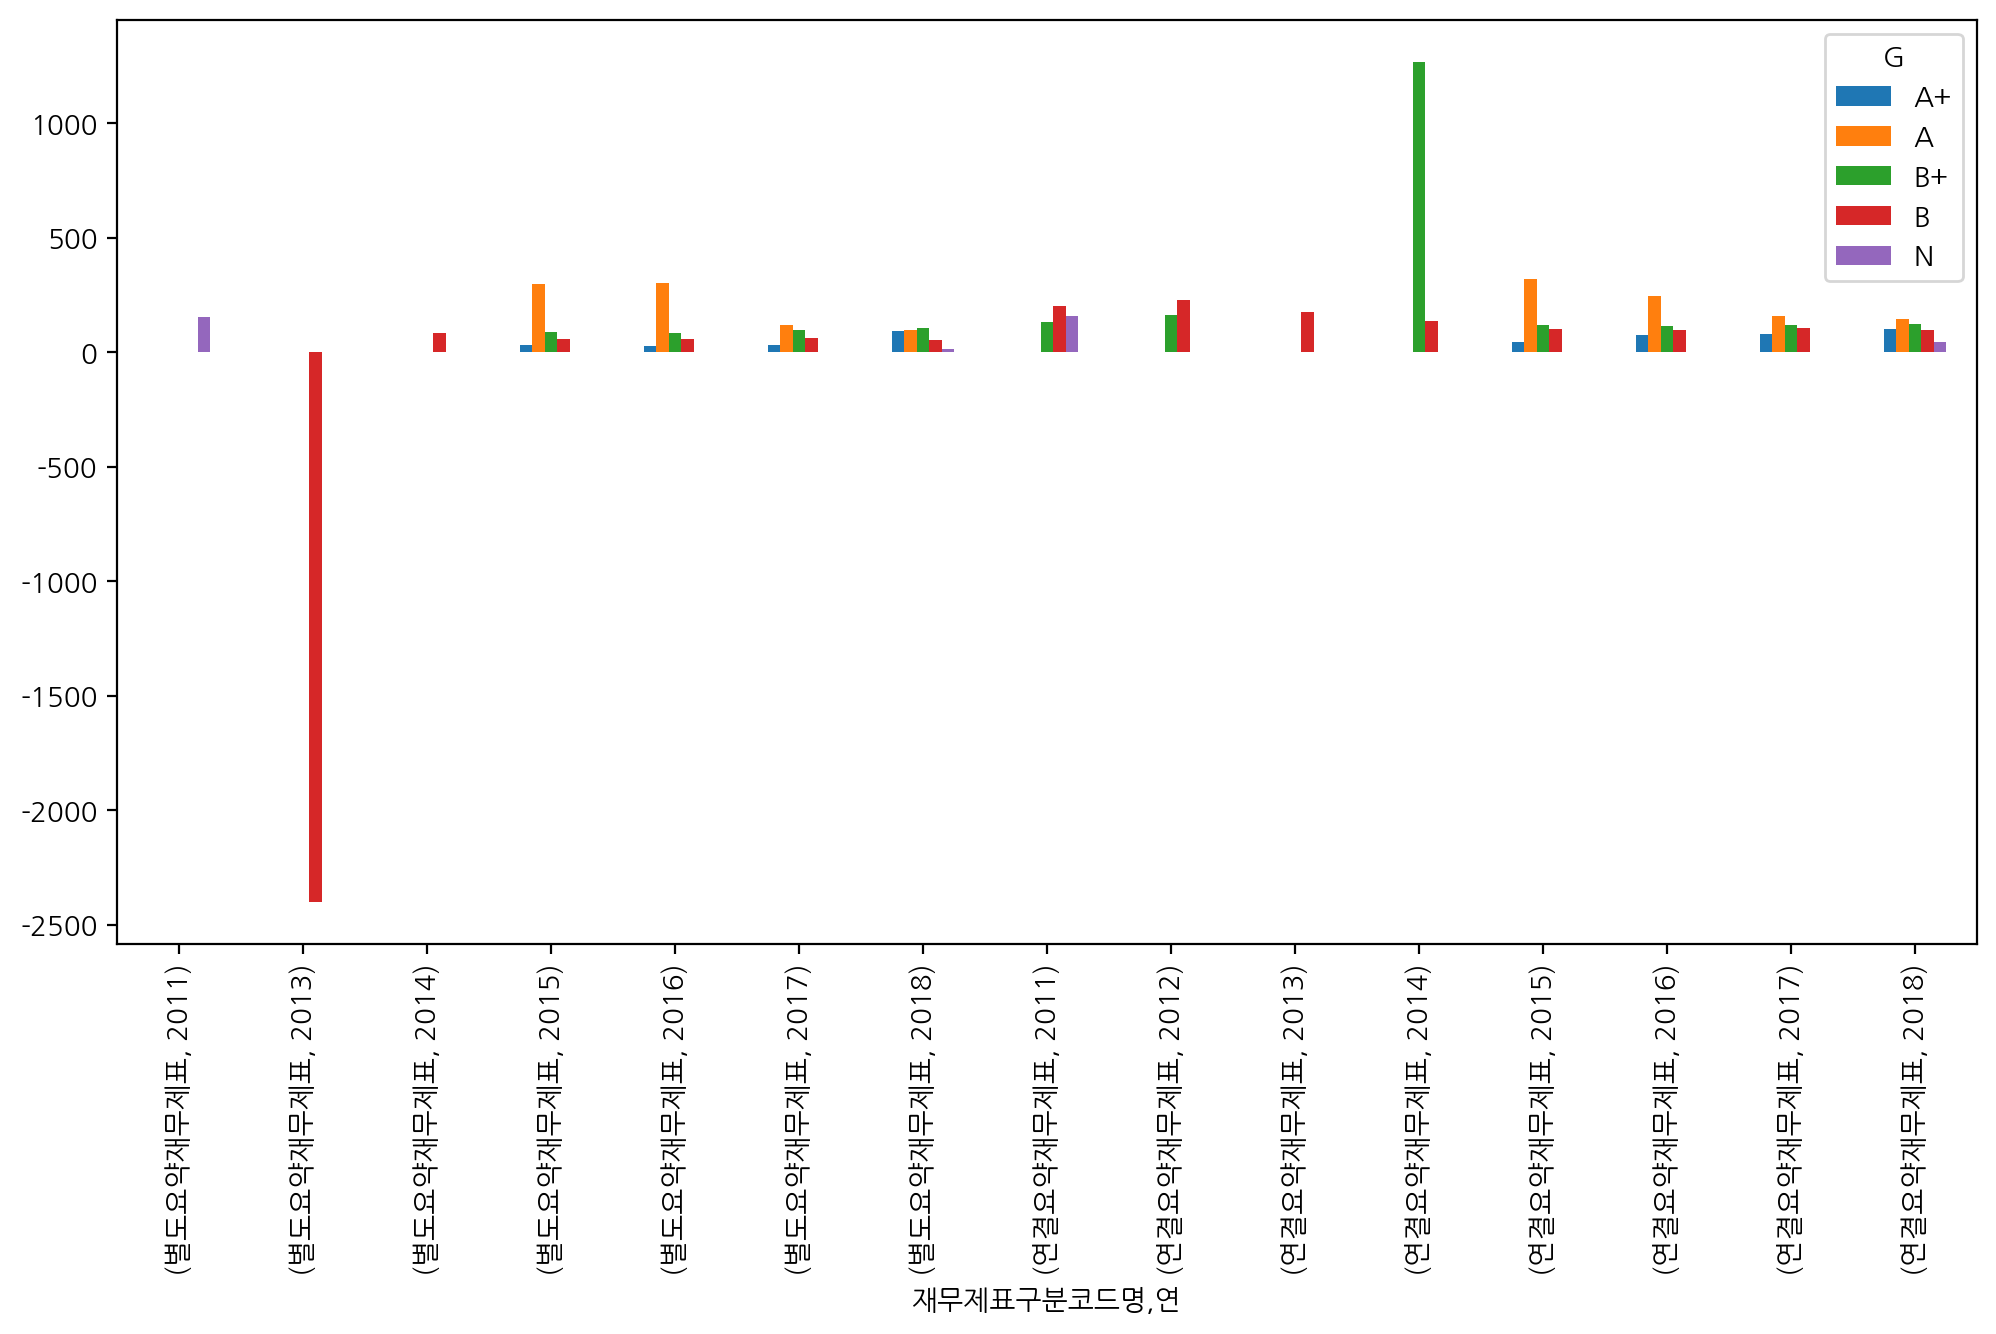

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 


In [86]:
finaStat = [
    "기업매출금액",
    "기업영업이익",
    "포괄손익계산금액",
    "기업당기순이익",
    "기업총자산금액",
    "기업총부채금액",
    "기업총자본금액",
    "기업자본금액",
    "재무제표부채비율",
]

for f in finaStat:
    for i in list_esg:
        print()
        print(f)
        print(i)

        d = df.pivot_table(f, ["재무제표구분코드명", "연"], [i], aggfunc="mean")
        display(d)
        
        d.plot(kind="bar", figsize=(12, 6))
        
        plt.show()
        print("---------- " * 8)

## finaStat_mmscl


기업매출금액_mmscl
ESG종합


ESG종합              A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.0000    NaN
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015    NaN 0.1202 0.2087 0.1654    NaN
          2016 0.1664 0.1326 0.2510 0.2156    NaN
          2017 0.1964 0.2587 0.3035 0.2606    NaN
          2018 0.3907 0.3363 0.3001 0.3249 0.0054
연결요약재무제표  2011    NaN    NaN 0.9292 0.6166    NaN
          2012    NaN    NaN 0.8511 0.0198    NaN
          2013    NaN    NaN    NaN 0.1812    NaN
          2014    NaN    NaN 0.4507 0.1160    NaN
          2015    NaN 0.6204 0.5224 0.6134    NaN
          2016 0.4154 0.6846 0.6486 0.6584    NaN
          2017 0.6773 0.7873 0.7459 0.7401    NaN
          2018 0.9722 0.7926 0.8053 0.8257 0.5772

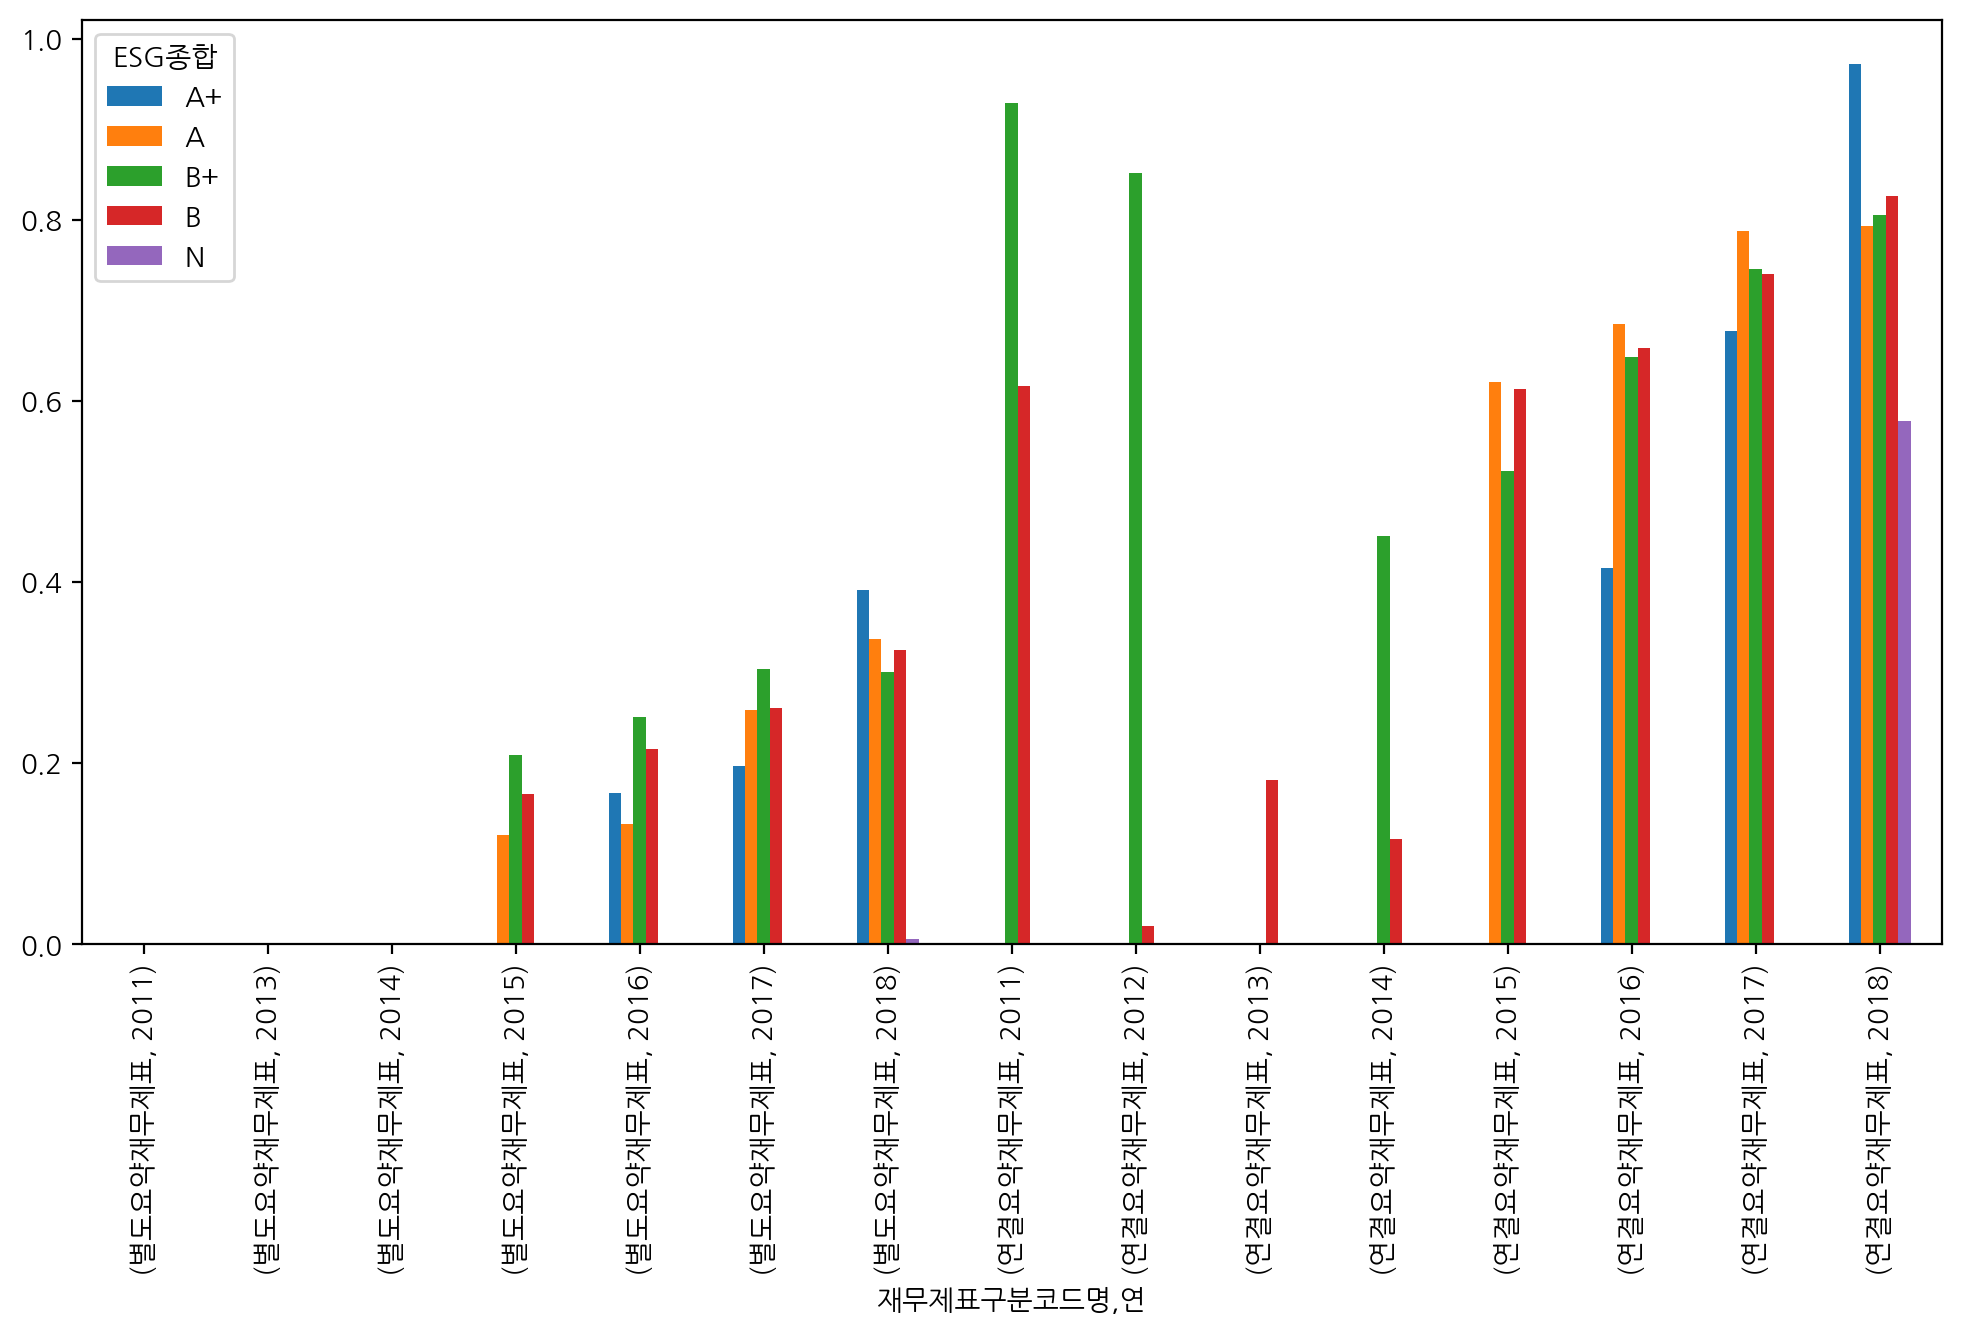

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업매출금액_mmscl
E


E                  A+      A     B+      B      C      D
재무제표구분코드명 연                                             
별도요약재무제표  2011    NaN    NaN    NaN 0.0000    NaN    NaN
          2013    NaN    NaN    NaN 0.0000    NaN    NaN
          2014    NaN    NaN    NaN    NaN 0.0000    NaN
          2015    NaN 0.1607 0.2713 0.1485 0.1440 0.0744
          2016 0.1248 0.1901 0.1948 0.2625 0.1654 0.2603
          2017 0.2499 0.3123 0.2544 0.2949 0.2414 0.1866
          2018 0.3421 0.2580 0.3092 0.3634 0.2415 0.2869
연결요약재무제표  2011    NaN    NaN    NaN 0.5930 1.0000    NaN
          2012    NaN    NaN    NaN 0.4453 0.0000    NaN
          2013    NaN    NaN    NaN    NaN 0.1812    NaN
          2014    NaN    NaN 0.4507    NaN 0.1160    NaN
          2015    NaN 0.5432 0.6092 0.5562 0.6363 0.5835
          2016 0.4912 0.6614 0.6155 0.6675 0.6690 0.6670
          2017 0.7094 0.8014 0.7656 0.7316 0.7236 0.7314
          2018 0.9629 0.8401 0.8062 0.8106 0.8113 0.8551

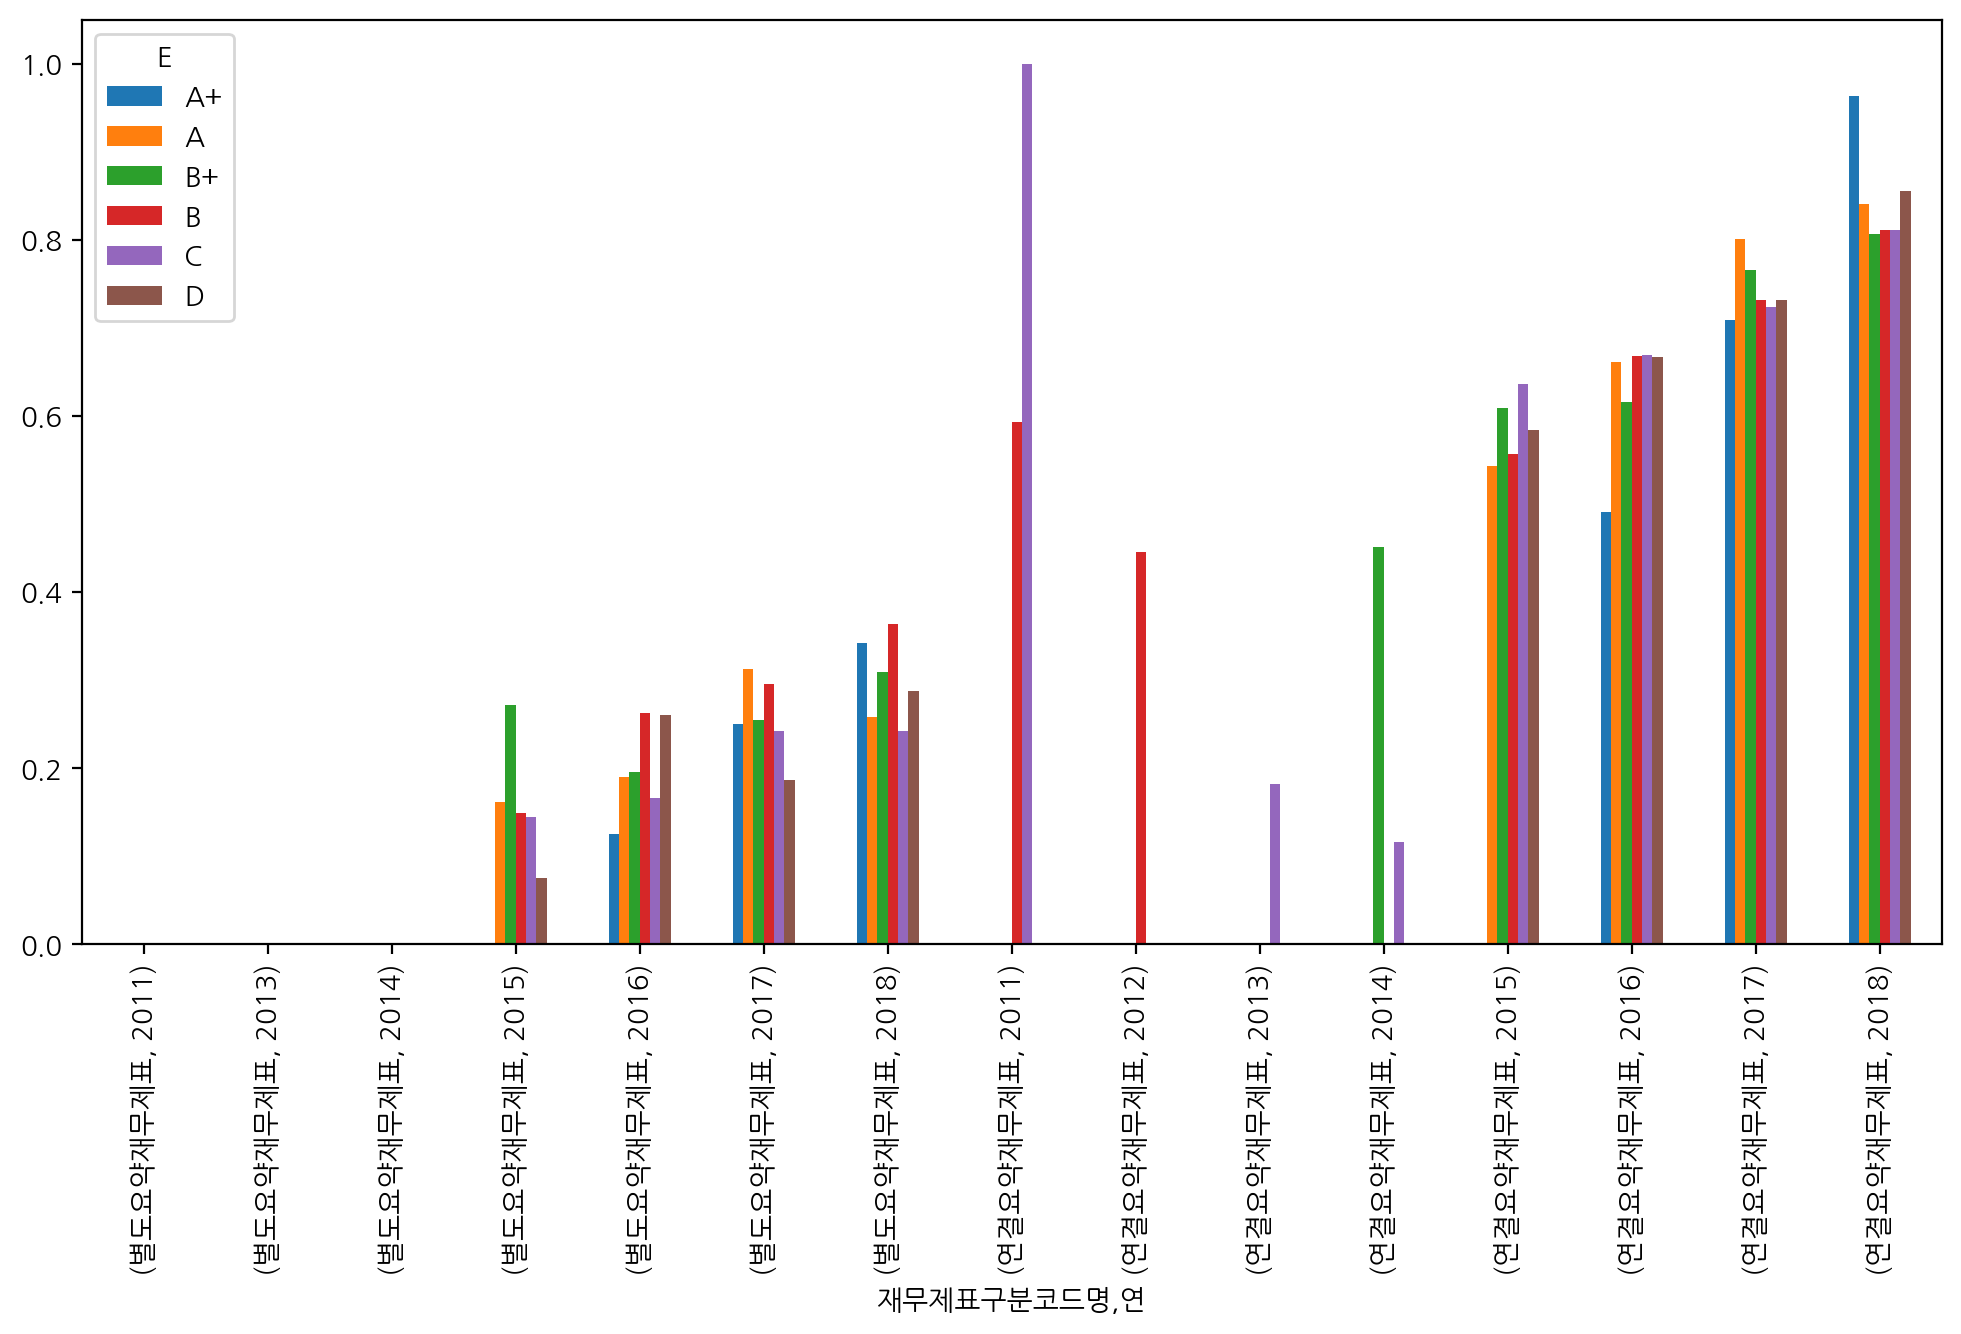

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업매출금액_mmscl
S


S                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.0000    NaN
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015 0.0659 0.0888 0.2334 0.1644    NaN
          2016 0.1300 0.2839 0.2531 0.2038    NaN
          2017 0.2672 0.2427 0.3130 0.2553    NaN
          2018 0.3579 0.3417 0.2779 0.3340 0.0054
연결요약재무제표  2011    NaN    NaN 0.9292 0.6166    NaN
          2012    NaN    NaN 0.8511 0.0198    NaN
          2013    NaN    NaN    NaN 0.1812    NaN
          2014    NaN    NaN    NaN 0.1997    NaN
          2015 0.4023 0.5883 0.5468 0.6162    NaN
          2016 0.6314 0.6902 0.5967 0.6843    NaN
          2017 0.6958 0.7956 0.7805 0.7278    NaN
          2018 0.8435 0.8899 0.7910 0.8144 0.5772

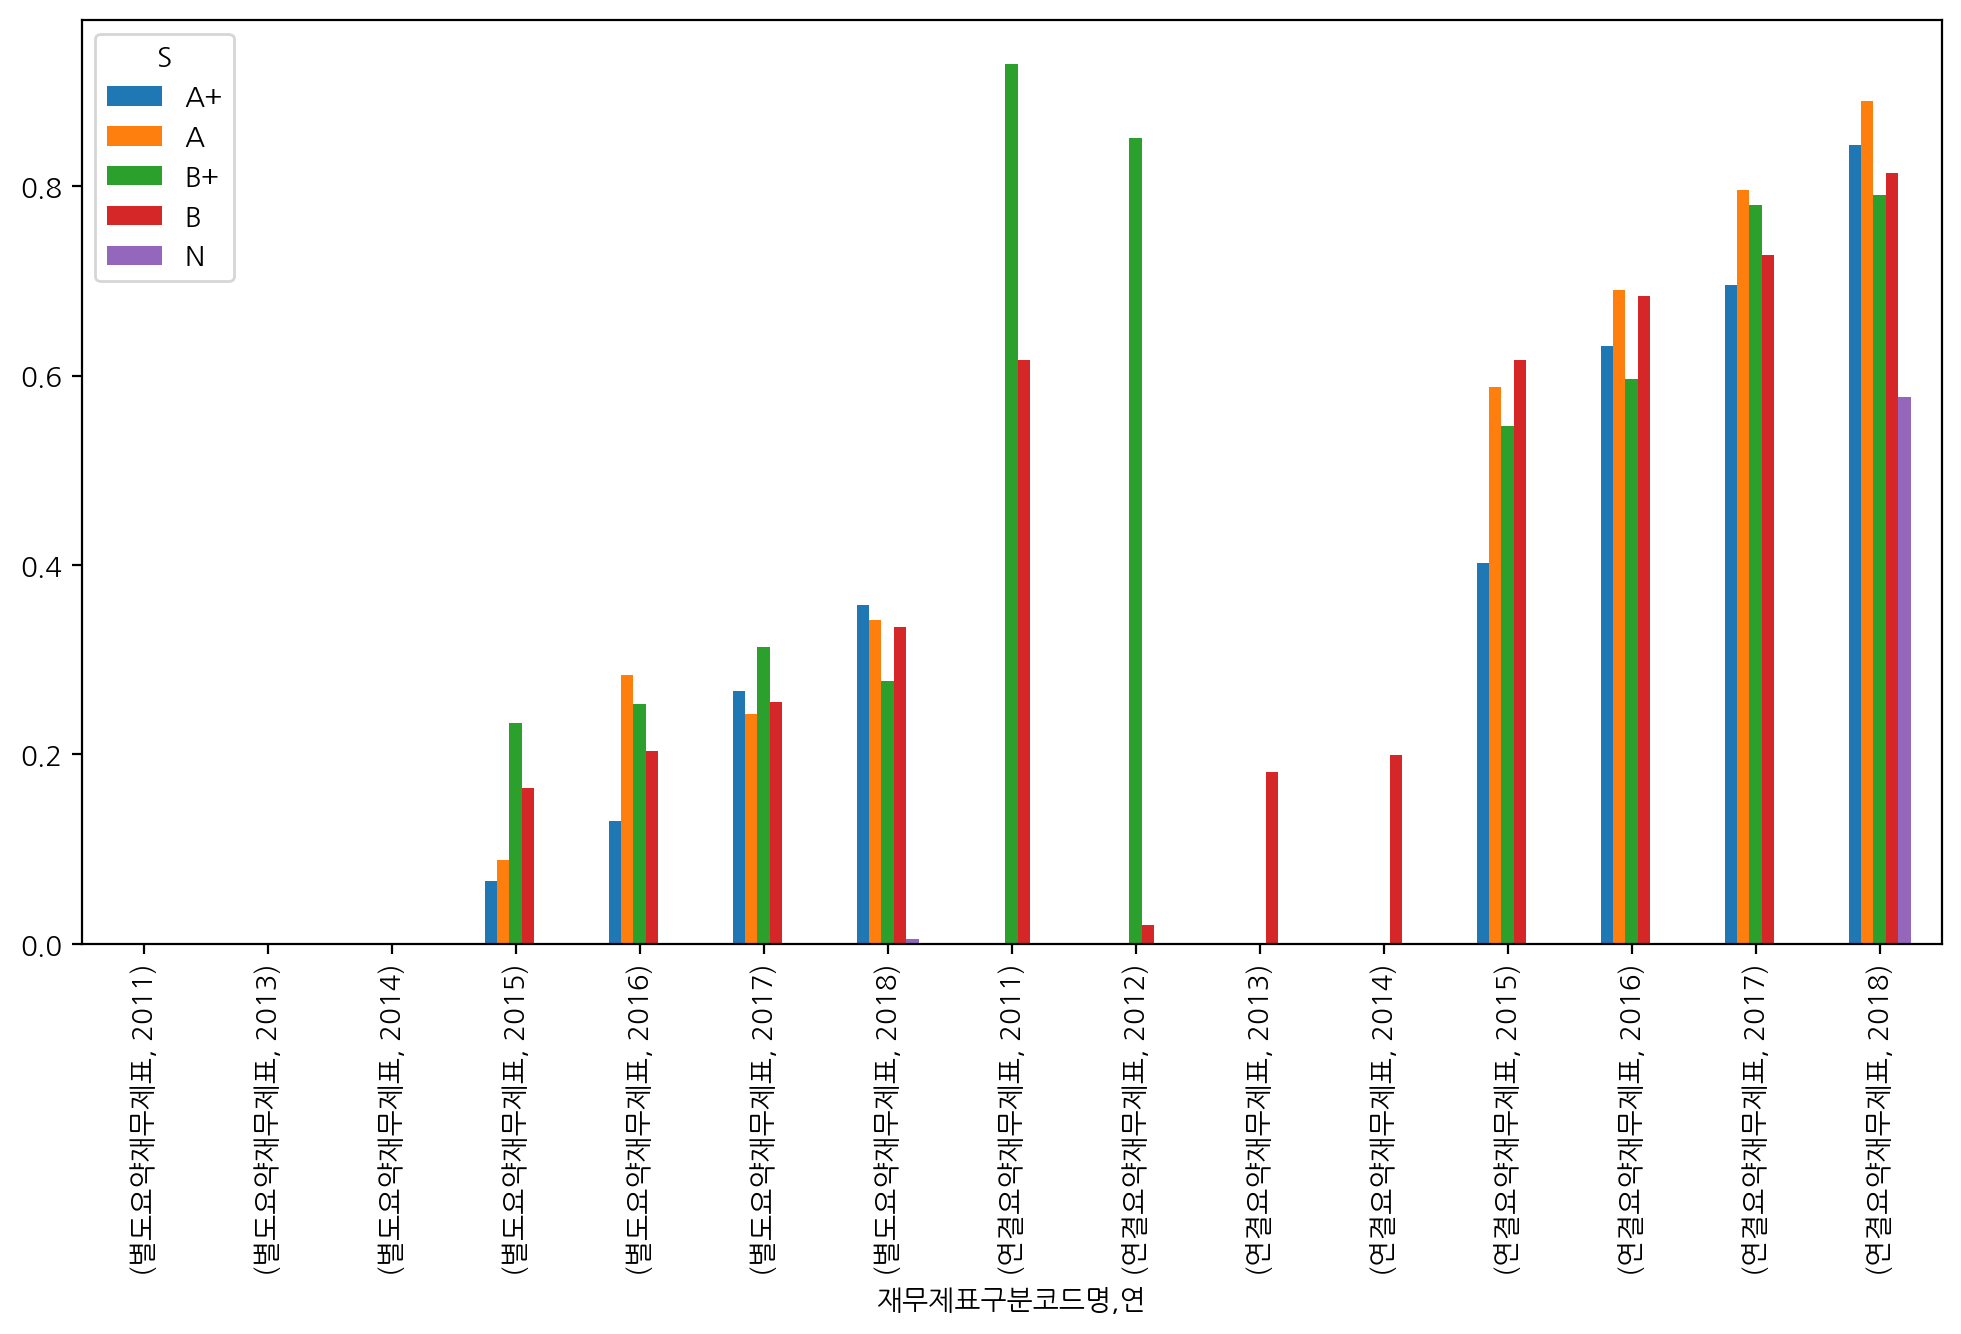

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업매출금액_mmscl
G


G                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN    NaN 0.0000
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015 0.1713 0.1616 0.1701 0.1746    NaN
          2016 0.0000 0.2100 0.1947 0.2332    NaN
          2017 0.0893 0.2631 0.2906 0.2630    NaN
          2018 0.4828 0.2593 0.3827 0.3023 0.0054
연결요약재무제표  2011    NaN    NaN 0.9292 0.7512 0.3474
          2012    NaN    NaN 0.8511 0.0198    NaN
          2013    NaN    NaN    NaN 0.1812    NaN
          2014    NaN    NaN 0.1572 0.3271    NaN
          2015 0.5630 0.6155 0.5981 0.5838    NaN
          2016 0.3833 0.6822 0.6063 0.6688    NaN
          2017 0.6133 0.7154 0.7765 0.7389    NaN
          2018 1.0000 0.7703 0.8343 0.8221 0.5772

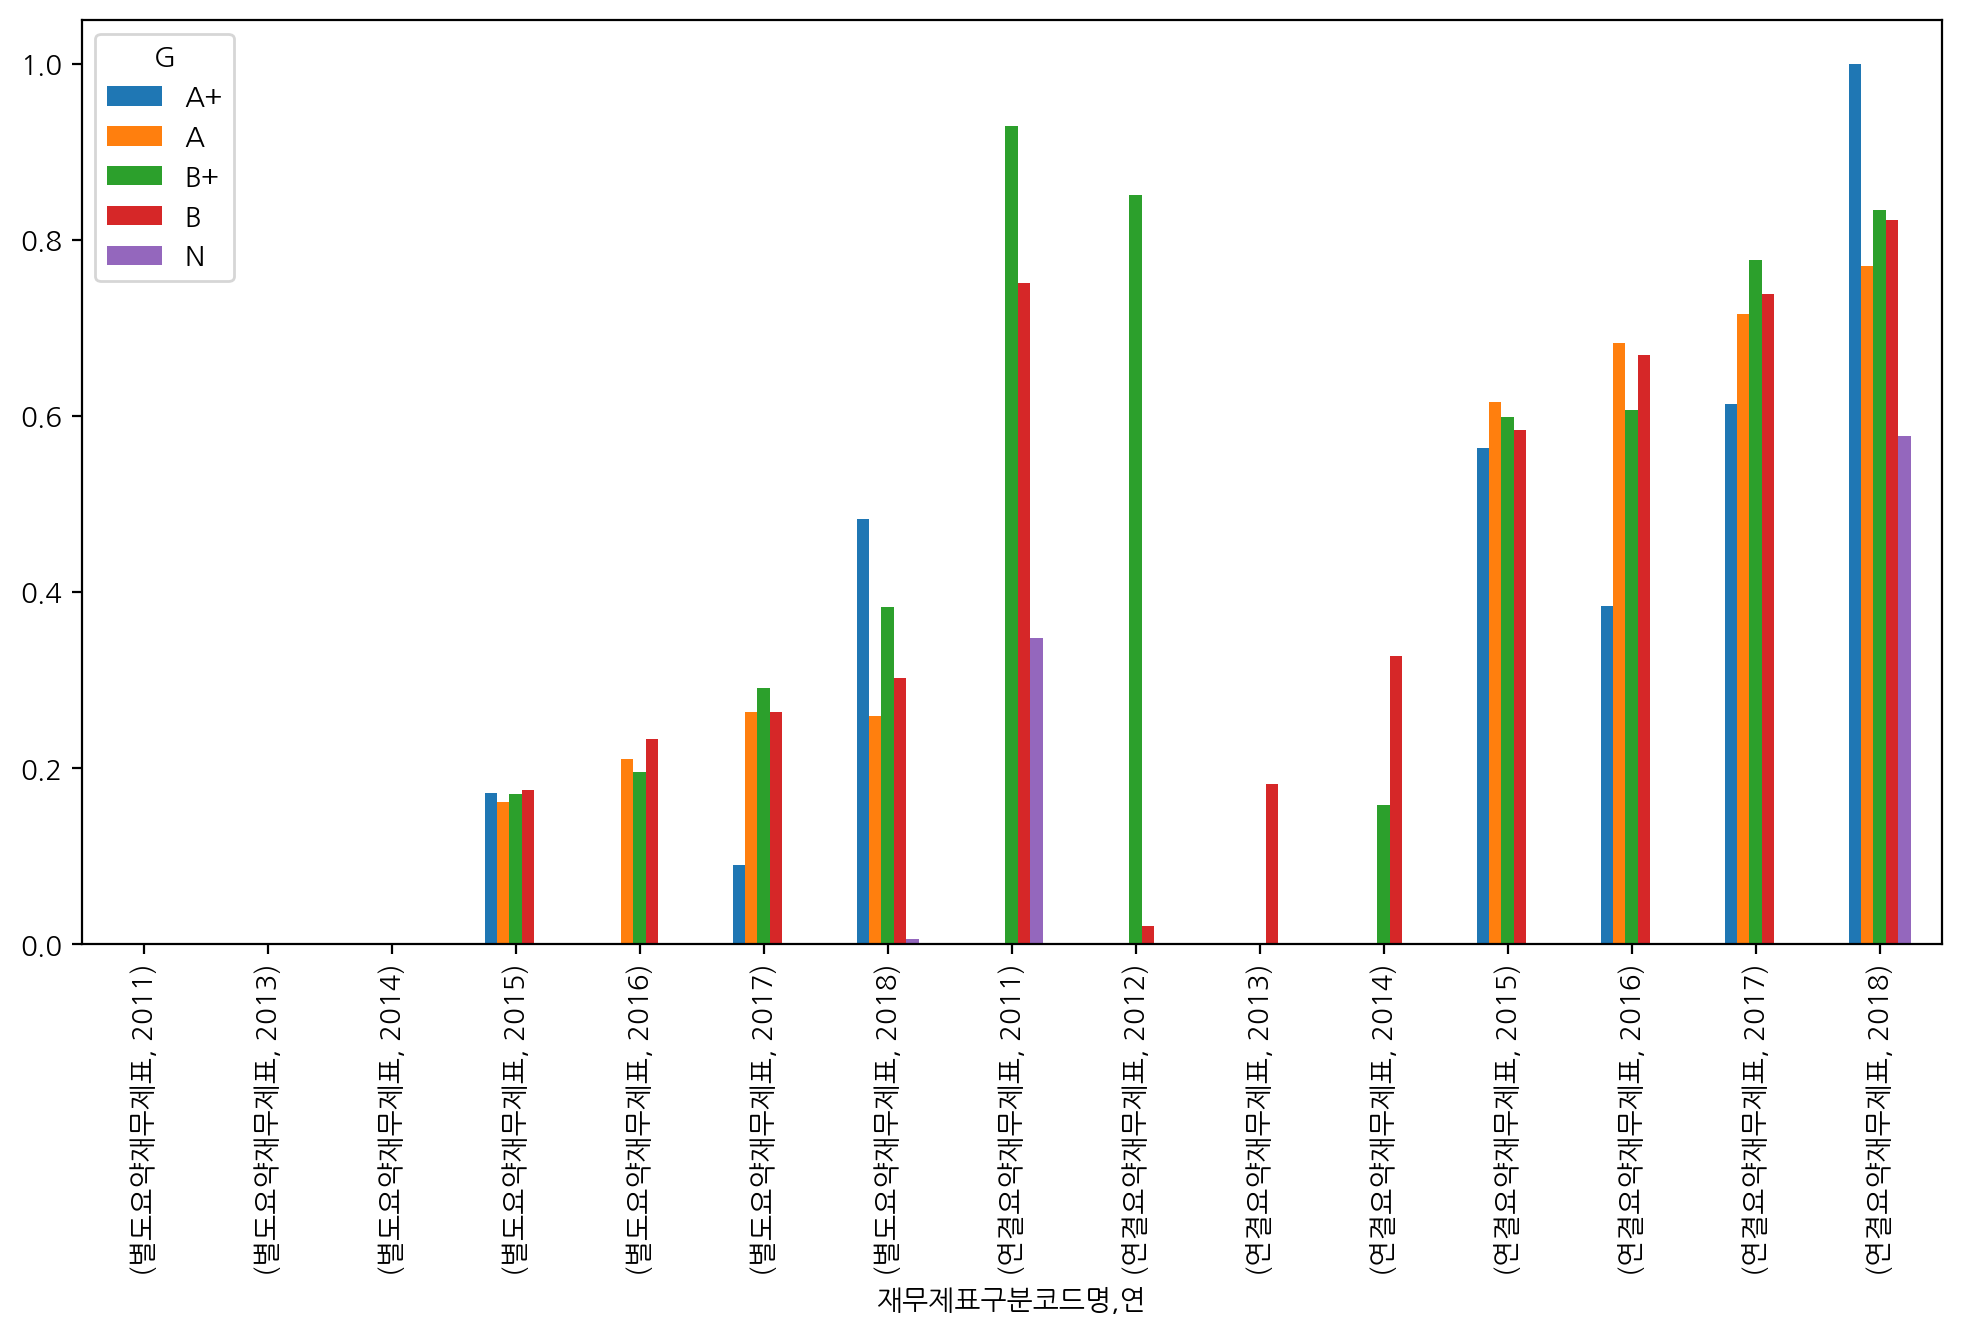

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업영업이익_mmscl
ESG종합


ESG종합              A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.1461    NaN
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015    NaN 0.1930 0.2366 0.4005    NaN
          2016 0.3944 0.2900 0.3917 0.4285    NaN
          2017 0.3401 0.5039 0.4659 0.3510    NaN
          2018 0.3944 0.4431 0.3119 0.3239 0.1201
연결요약재무제표  2011    NaN    NaN 0.3257 0.1629    NaN
          2012    NaN    NaN 0.0000 0.4346    NaN
          2013    NaN    NaN    NaN 0.7491    NaN
          2014    NaN    NaN 0.0000 0.2606    NaN
          2015    NaN 0.3515 0.3913 0.6199    NaN
          2016 0.4940 0.6382 0.6471 0.6756    NaN
          2017 0.7301 0.8176 0.6311 0.5932    NaN
          2018 0.6170 0.7558 0.5672 0.5678 0.4135

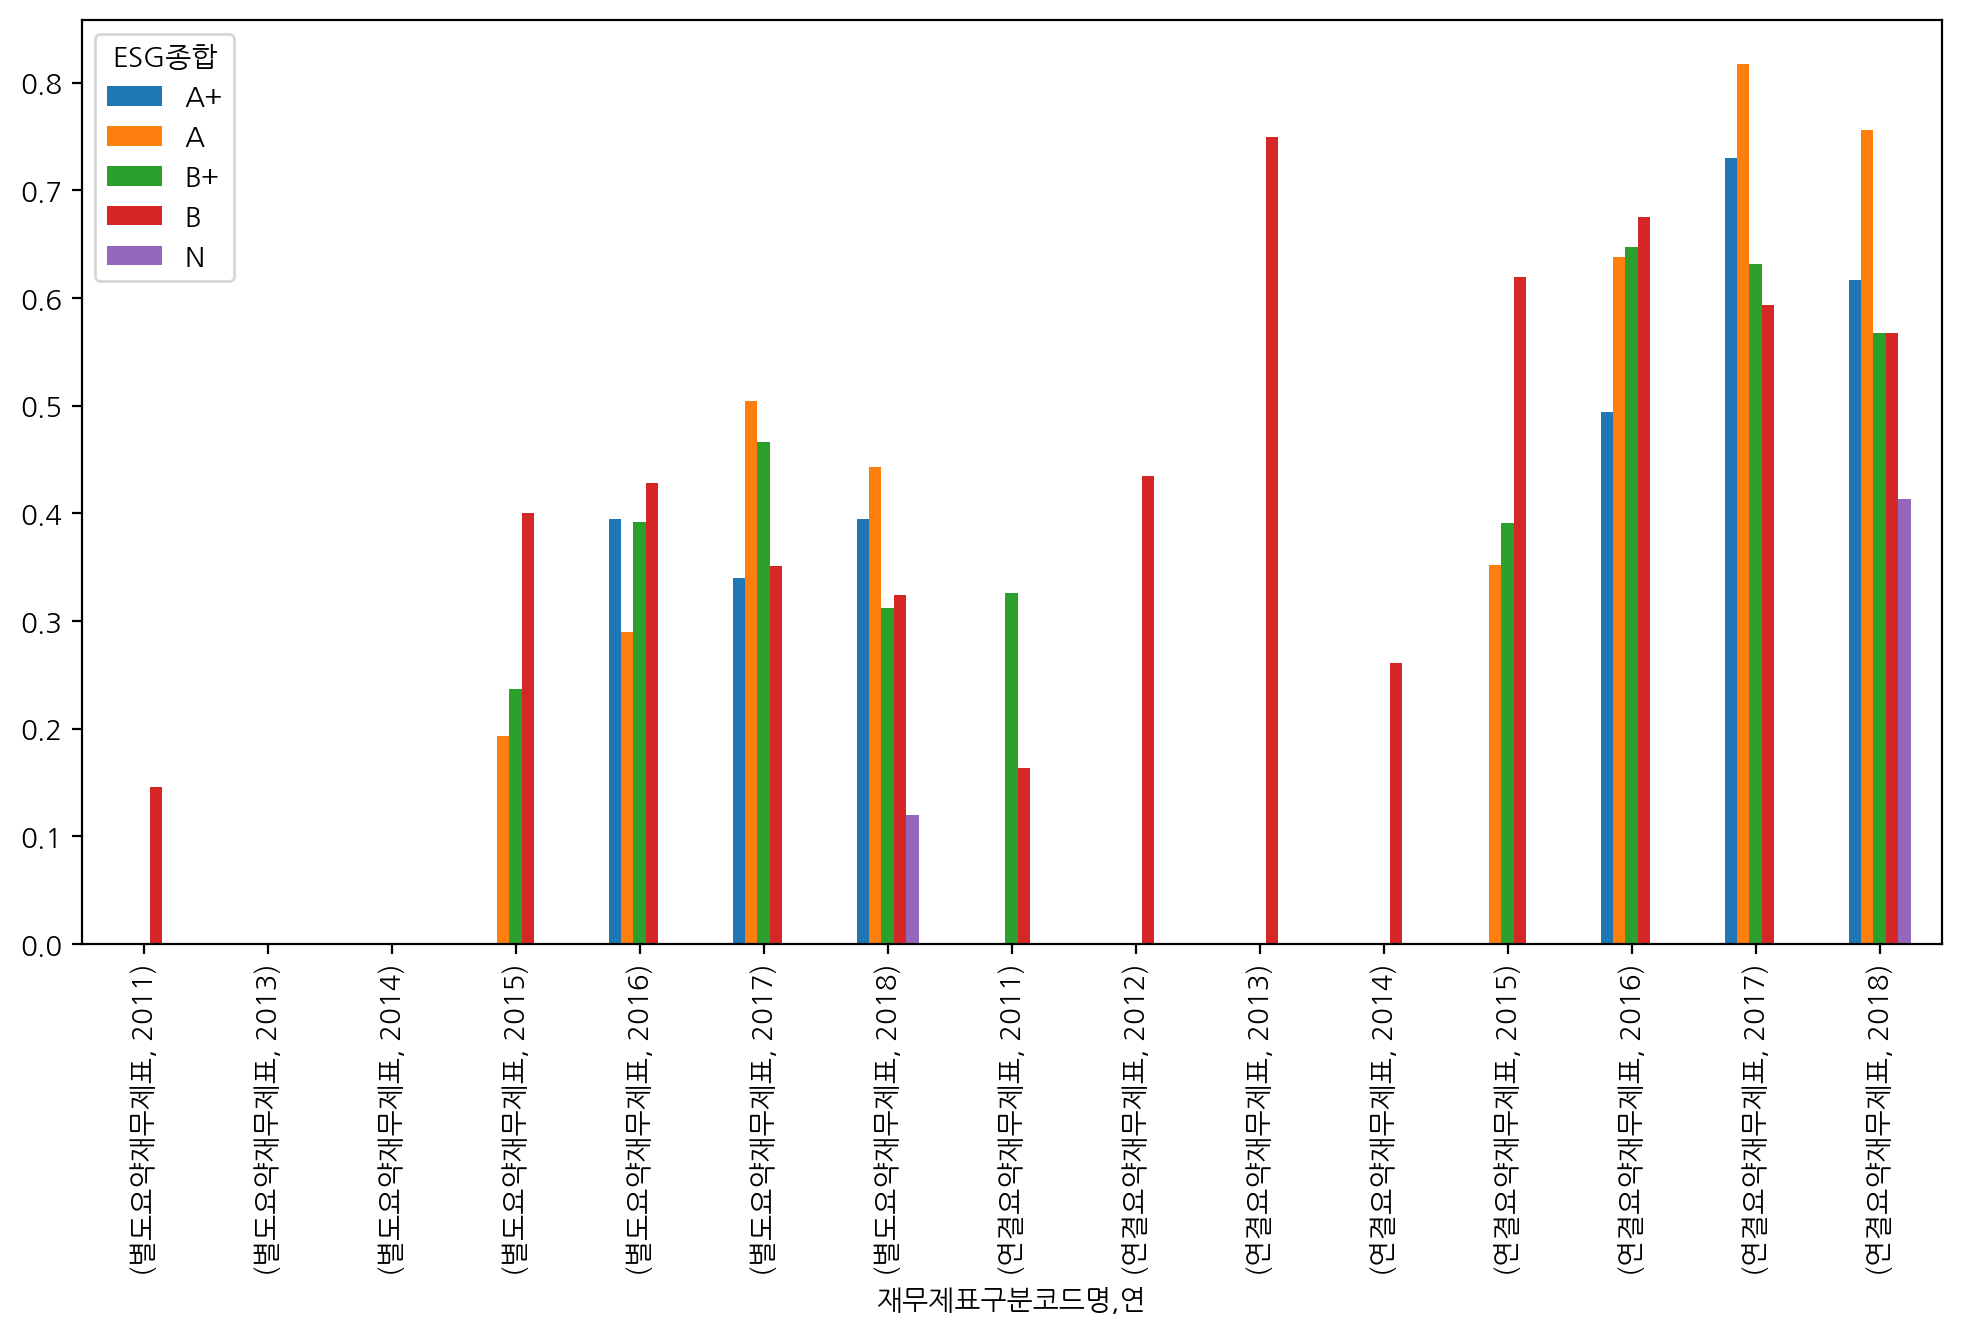

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업영업이익_mmscl
E


E                  A+      A     B+      B      C      D
재무제표구분코드명 연                                             
별도요약재무제표  2011    NaN    NaN    NaN 0.1461    NaN    NaN
          2013    NaN    NaN    NaN 0.0000    NaN    NaN
          2014    NaN    NaN    NaN    NaN 0.0000    NaN
          2015    NaN 0.2642 0.3117 0.3828 0.3480 0.4028
          2016 0.2958 0.3654 0.3584 0.4058 0.4865 0.2974
          2017 0.4315 0.5322 0.4220 0.3711 0.3819 0.2100
          2018 0.2927 0.4553 0.3671 0.3440 0.1953 0.3909
연결요약재무제표  2011    NaN    NaN    NaN 0.2715 0.0000    NaN
          2012    NaN    NaN    NaN 0.0000 0.8691    NaN
          2013    NaN    NaN    NaN    NaN 0.7491    NaN
          2014    NaN    NaN 0.0000    NaN 0.2606    NaN
          2015    NaN 0.3317 0.4594 0.5948 0.5806 0.6772
          2016 0.6200 0.5800 0.6227 0.6588 0.7377 0.5466
          2017 0.8757 0.7721 0.7072 0.5888 0.5483 0.4343
          2018 0.4893 0.7641 0.6725 0.5434 0.4654 0.7089

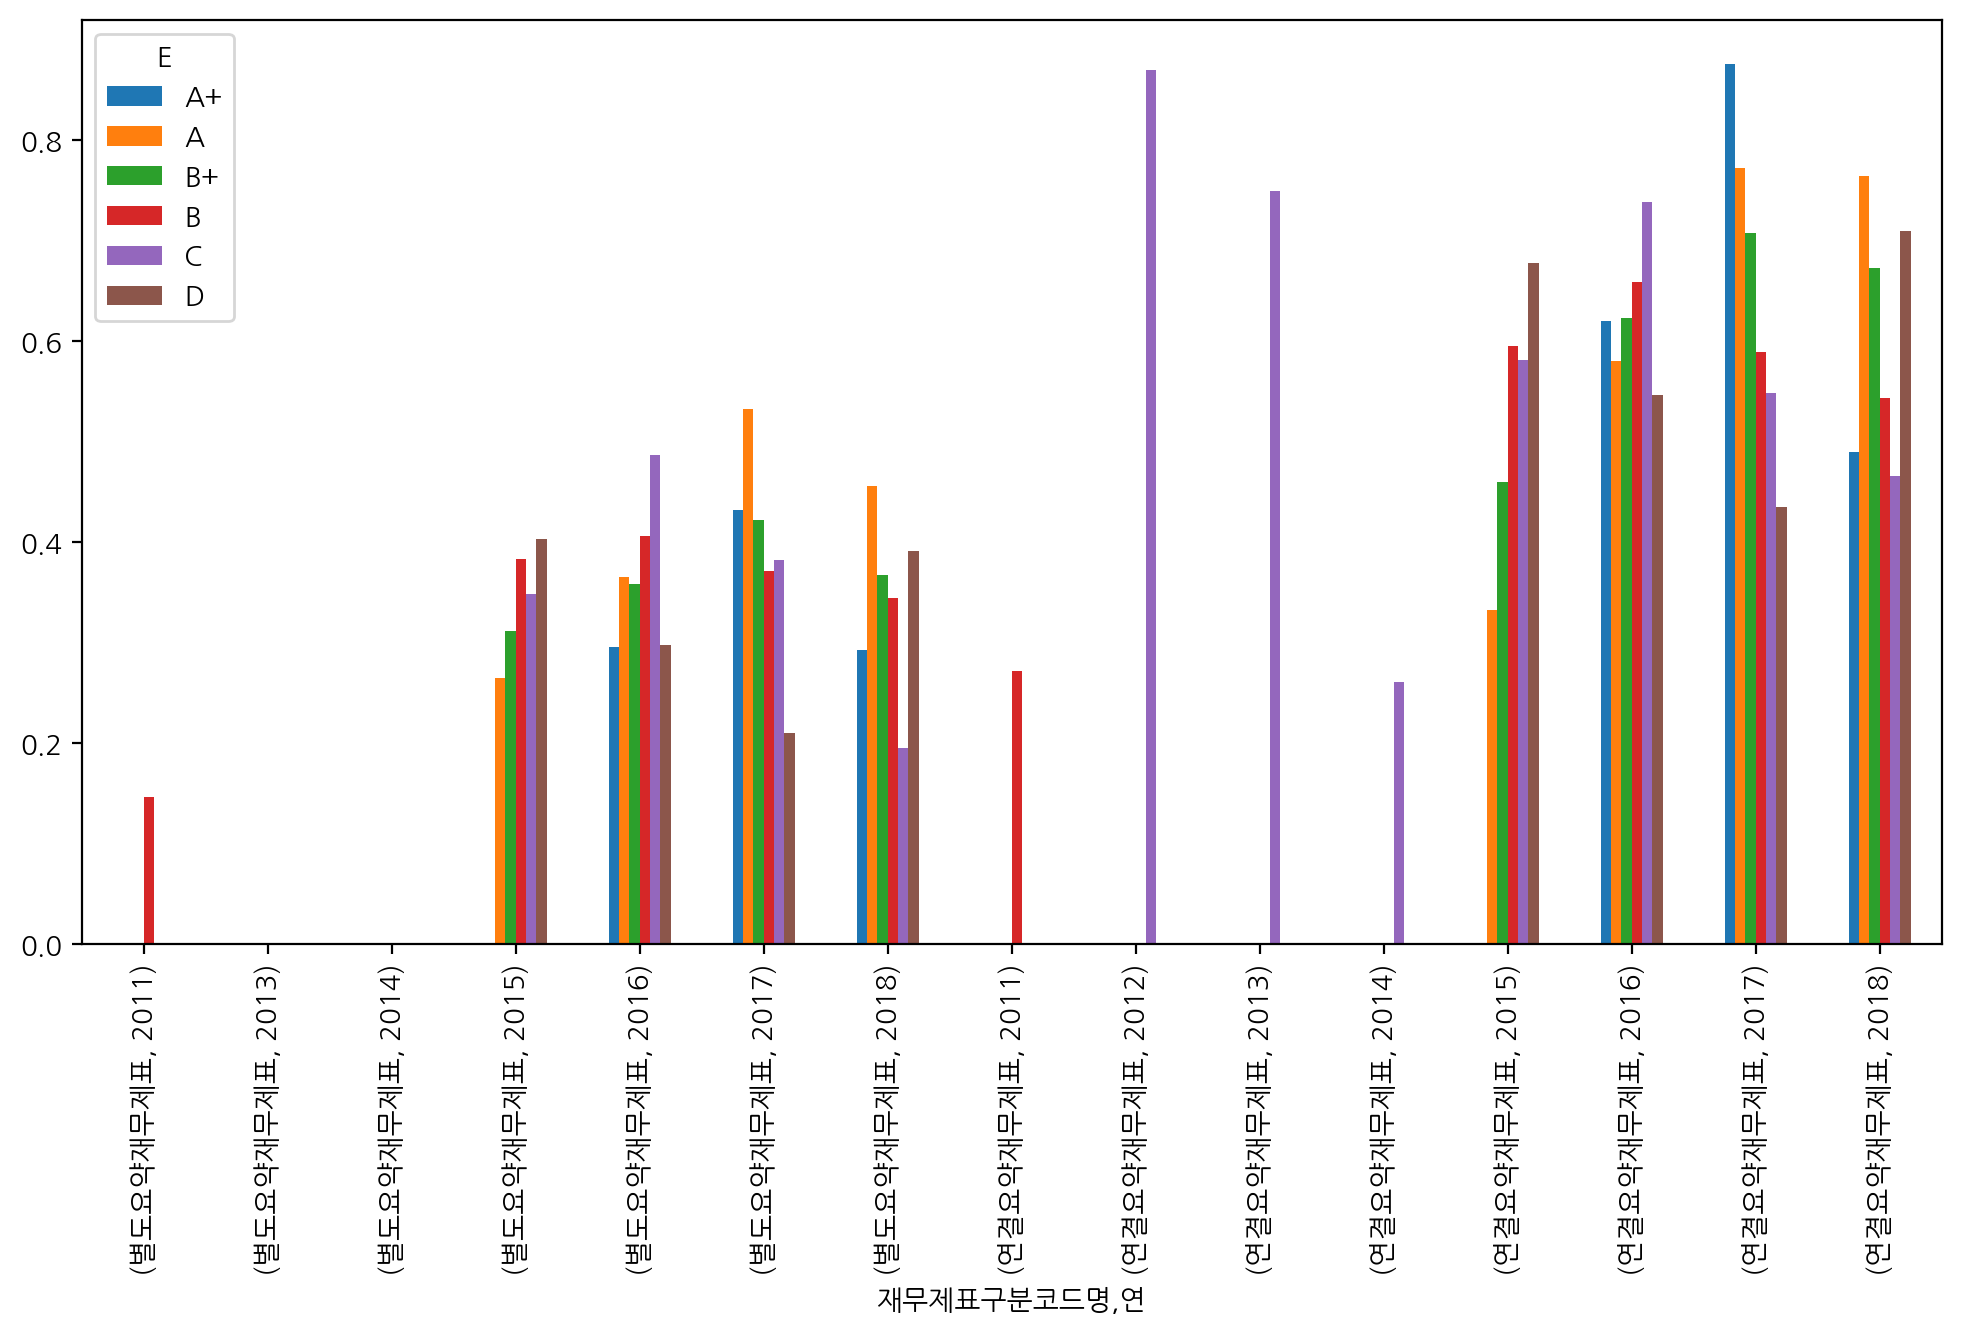

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업영업이익_mmscl
S


S                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.1461    NaN
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015 0.0615 0.2452 0.3644 0.3673    NaN
          2016 0.2999 0.4428 0.4296 0.4095    NaN
          2017 0.5325 0.3586 0.3669 0.3862    NaN
          2018 0.3968 0.4029 0.2910 0.3342 0.1201
연결요약재무제표  2011    NaN    NaN 0.3257 0.1629    NaN
          2012    NaN    NaN 0.0000 0.4346    NaN
          2013    NaN    NaN    NaN 0.7491    NaN
          2014    NaN    NaN    NaN 0.1954    NaN
          2015 0.2469 0.4280 0.5310 0.5778    NaN
          2016 0.6097 0.7310 0.6343 0.6783    NaN
          2017 0.7895 0.6753 0.5741 0.6111    NaN
          2018 0.7198 0.7956 0.4770 0.5835 0.4135

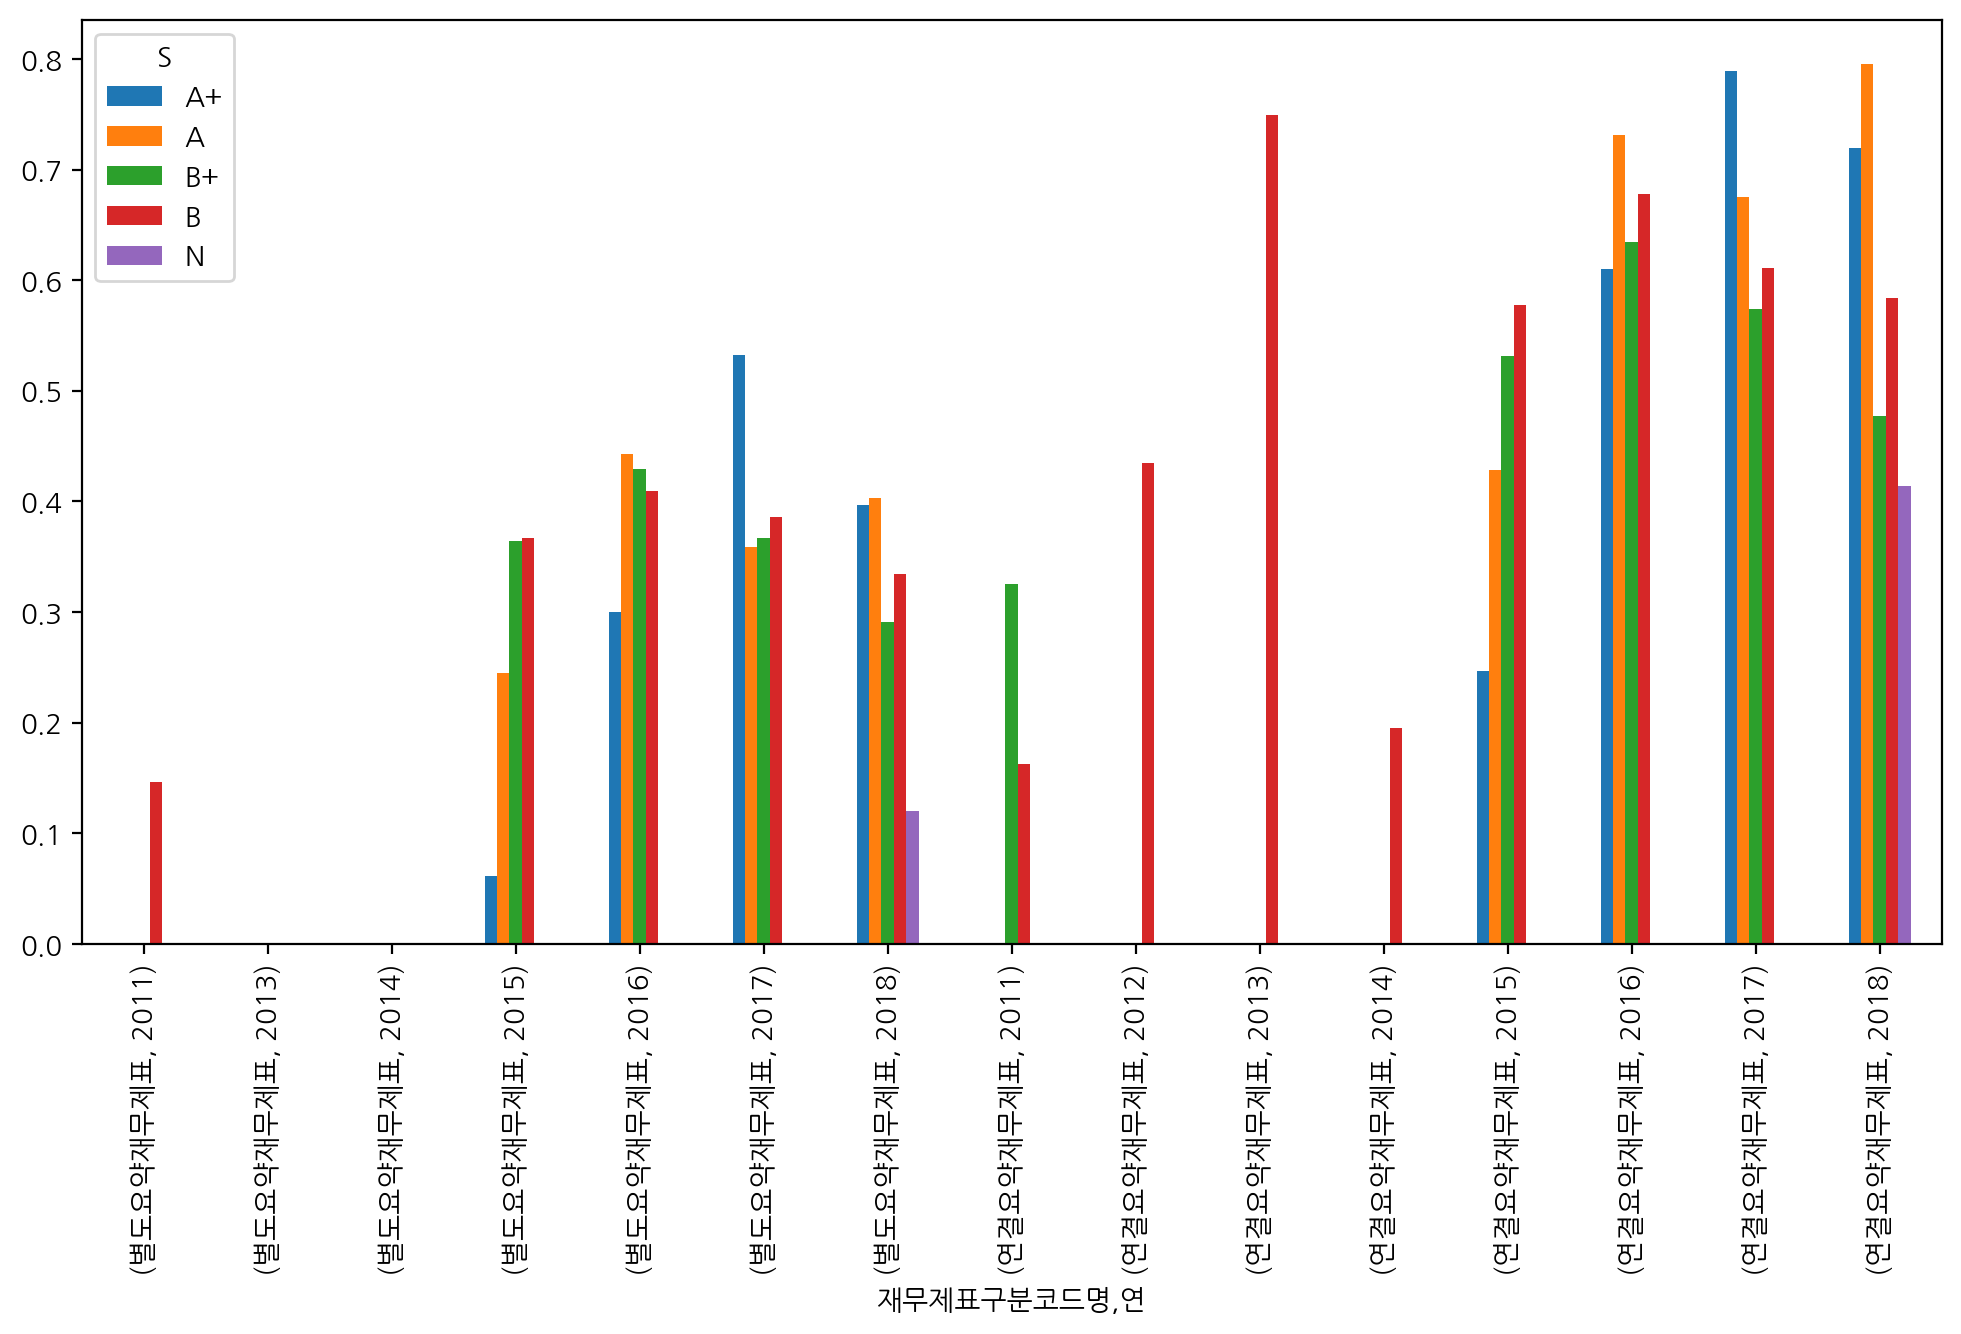

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업영업이익_mmscl
G


G                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN    NaN 0.1461
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015 0.1549 0.2298 0.3717 0.3782    NaN
          2016 0.0000 0.4141 0.4101 0.4102    NaN
          2017 0.1573 0.5037 0.4158 0.3488    NaN
          2018 0.7322 0.3782 0.3323 0.3215 0.1201
연결요약재무제표  2011    NaN    NaN 0.3257 0.2444 0.0000
          2012    NaN    NaN 0.0000 0.4346    NaN
          2013    NaN    NaN    NaN 0.7491    NaN
          2014    NaN    NaN 0.0000 0.7817    NaN
          2015 0.3361 0.3780 0.5852 0.5824    NaN
          2016 0.2166 0.6760 0.6376 0.6737    NaN
          2017 0.4387 0.7300 0.5929 0.6121    NaN
          2018 1.0000 0.6684 0.5539 0.5851 0.4135

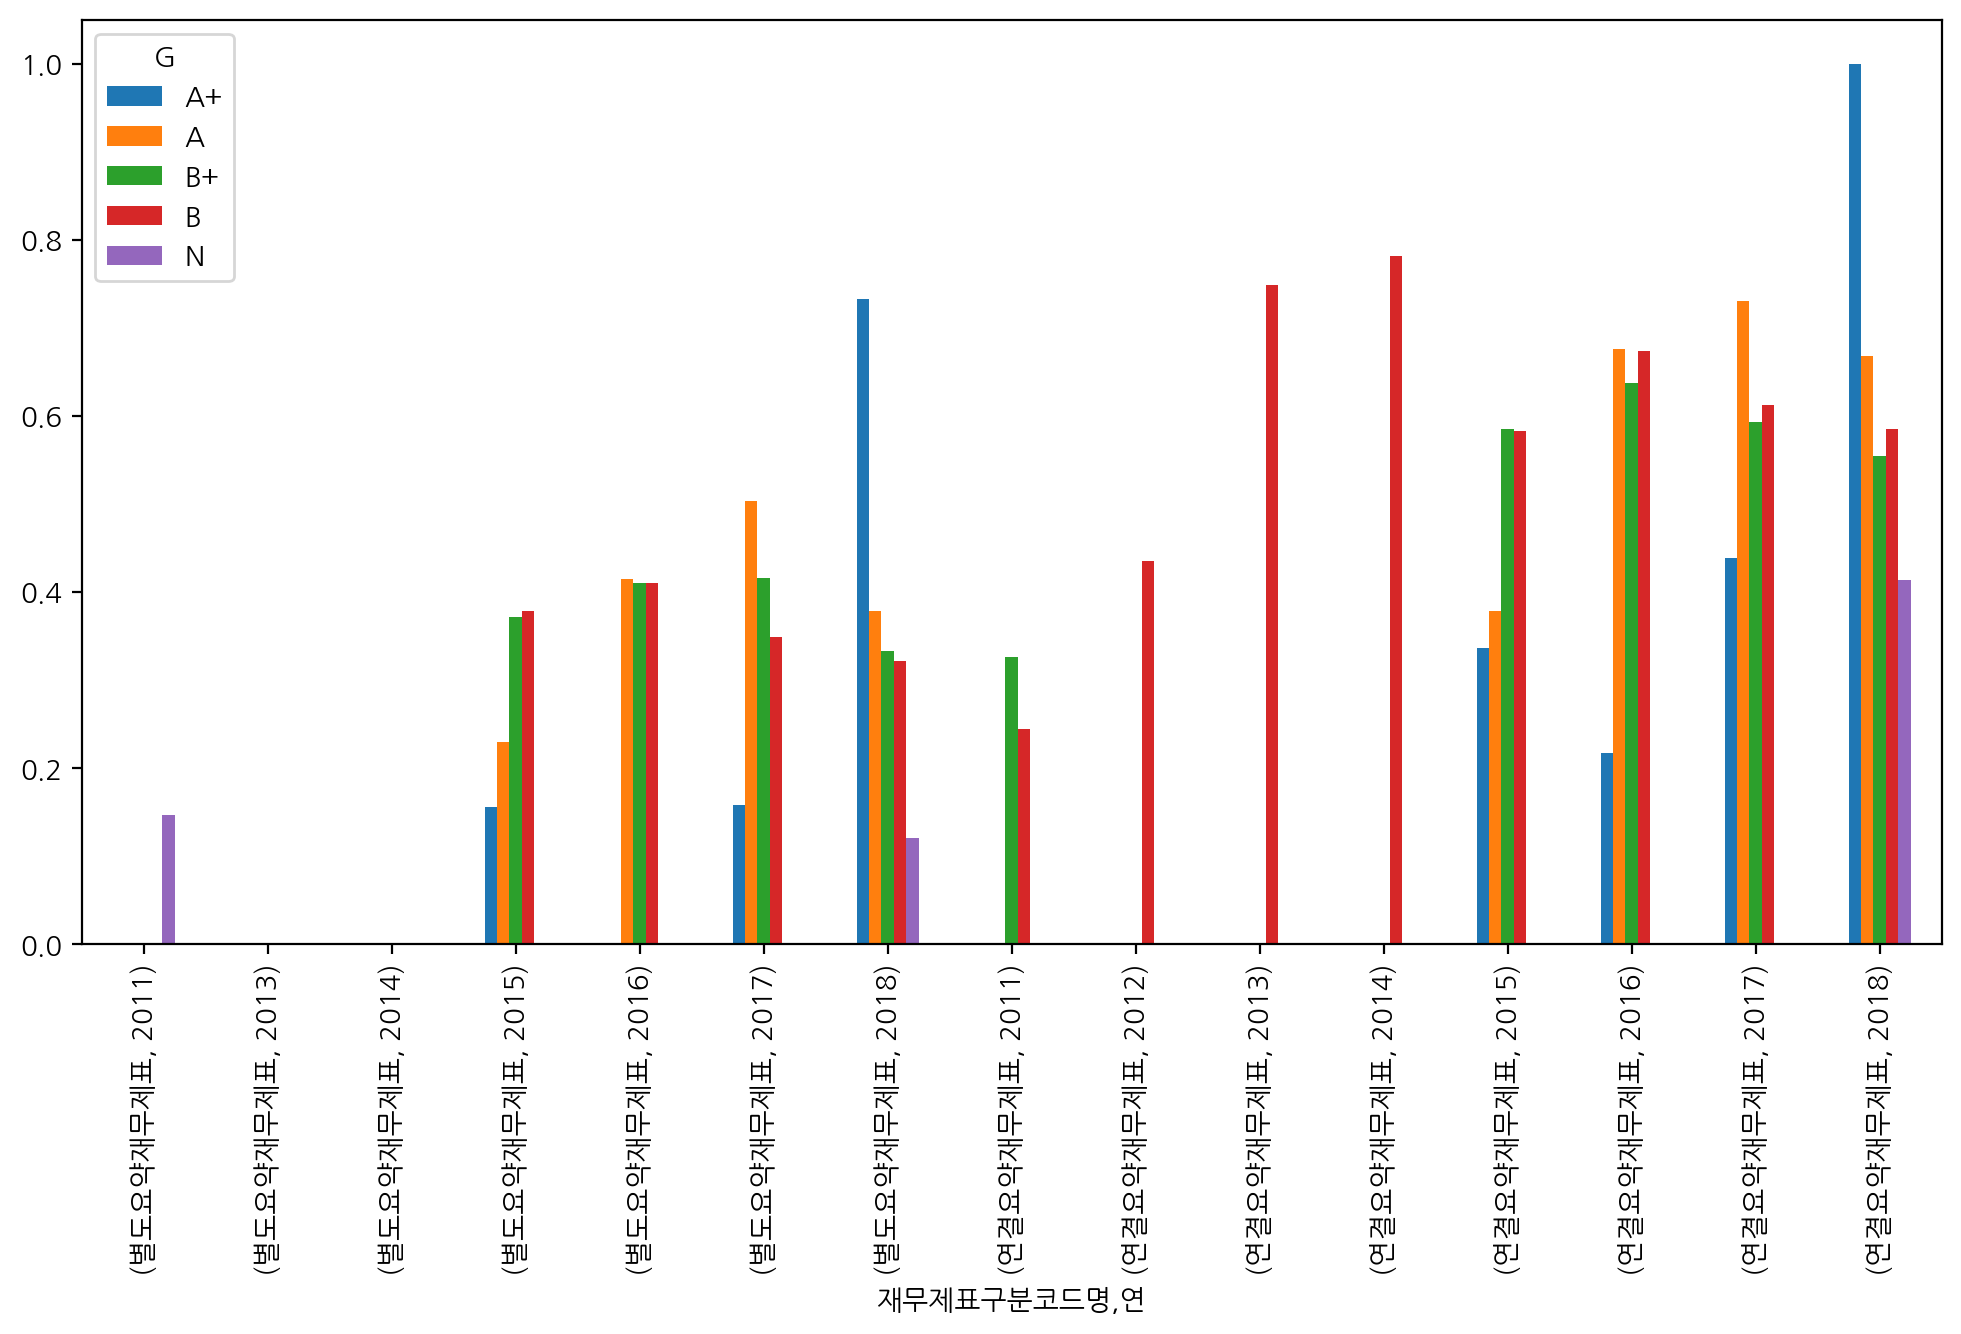

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액_mmscl
ESG종합


ESG종합              A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.3271    NaN
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015    NaN 0.3323 0.3195 0.4749    NaN
          2016 0.4023 0.3275 0.3689 0.4796    NaN
          2017 0.3333 0.4621 0.4938 0.3867    NaN
          2018 0.2468 0.5216 0.3603 0.3527 0.2461
연결요약재무제표  2011    NaN    NaN 0.0365 0.2823    NaN
          2012    NaN    NaN 0.0000 0.0000    NaN
          2013    NaN    NaN    NaN 0.6448    NaN
          2014    NaN    NaN 0.6294 0.2699    NaN
          2015    NaN 0.3545 0.4285 0.5511    NaN
          2016 0.3765 0.5281 0.5378 0.6614    NaN
          2017 0.7895 0.7281 0.6793 0.5785    NaN
          2018 0.7150 0.7768 0.5666 0.5057 0.4687

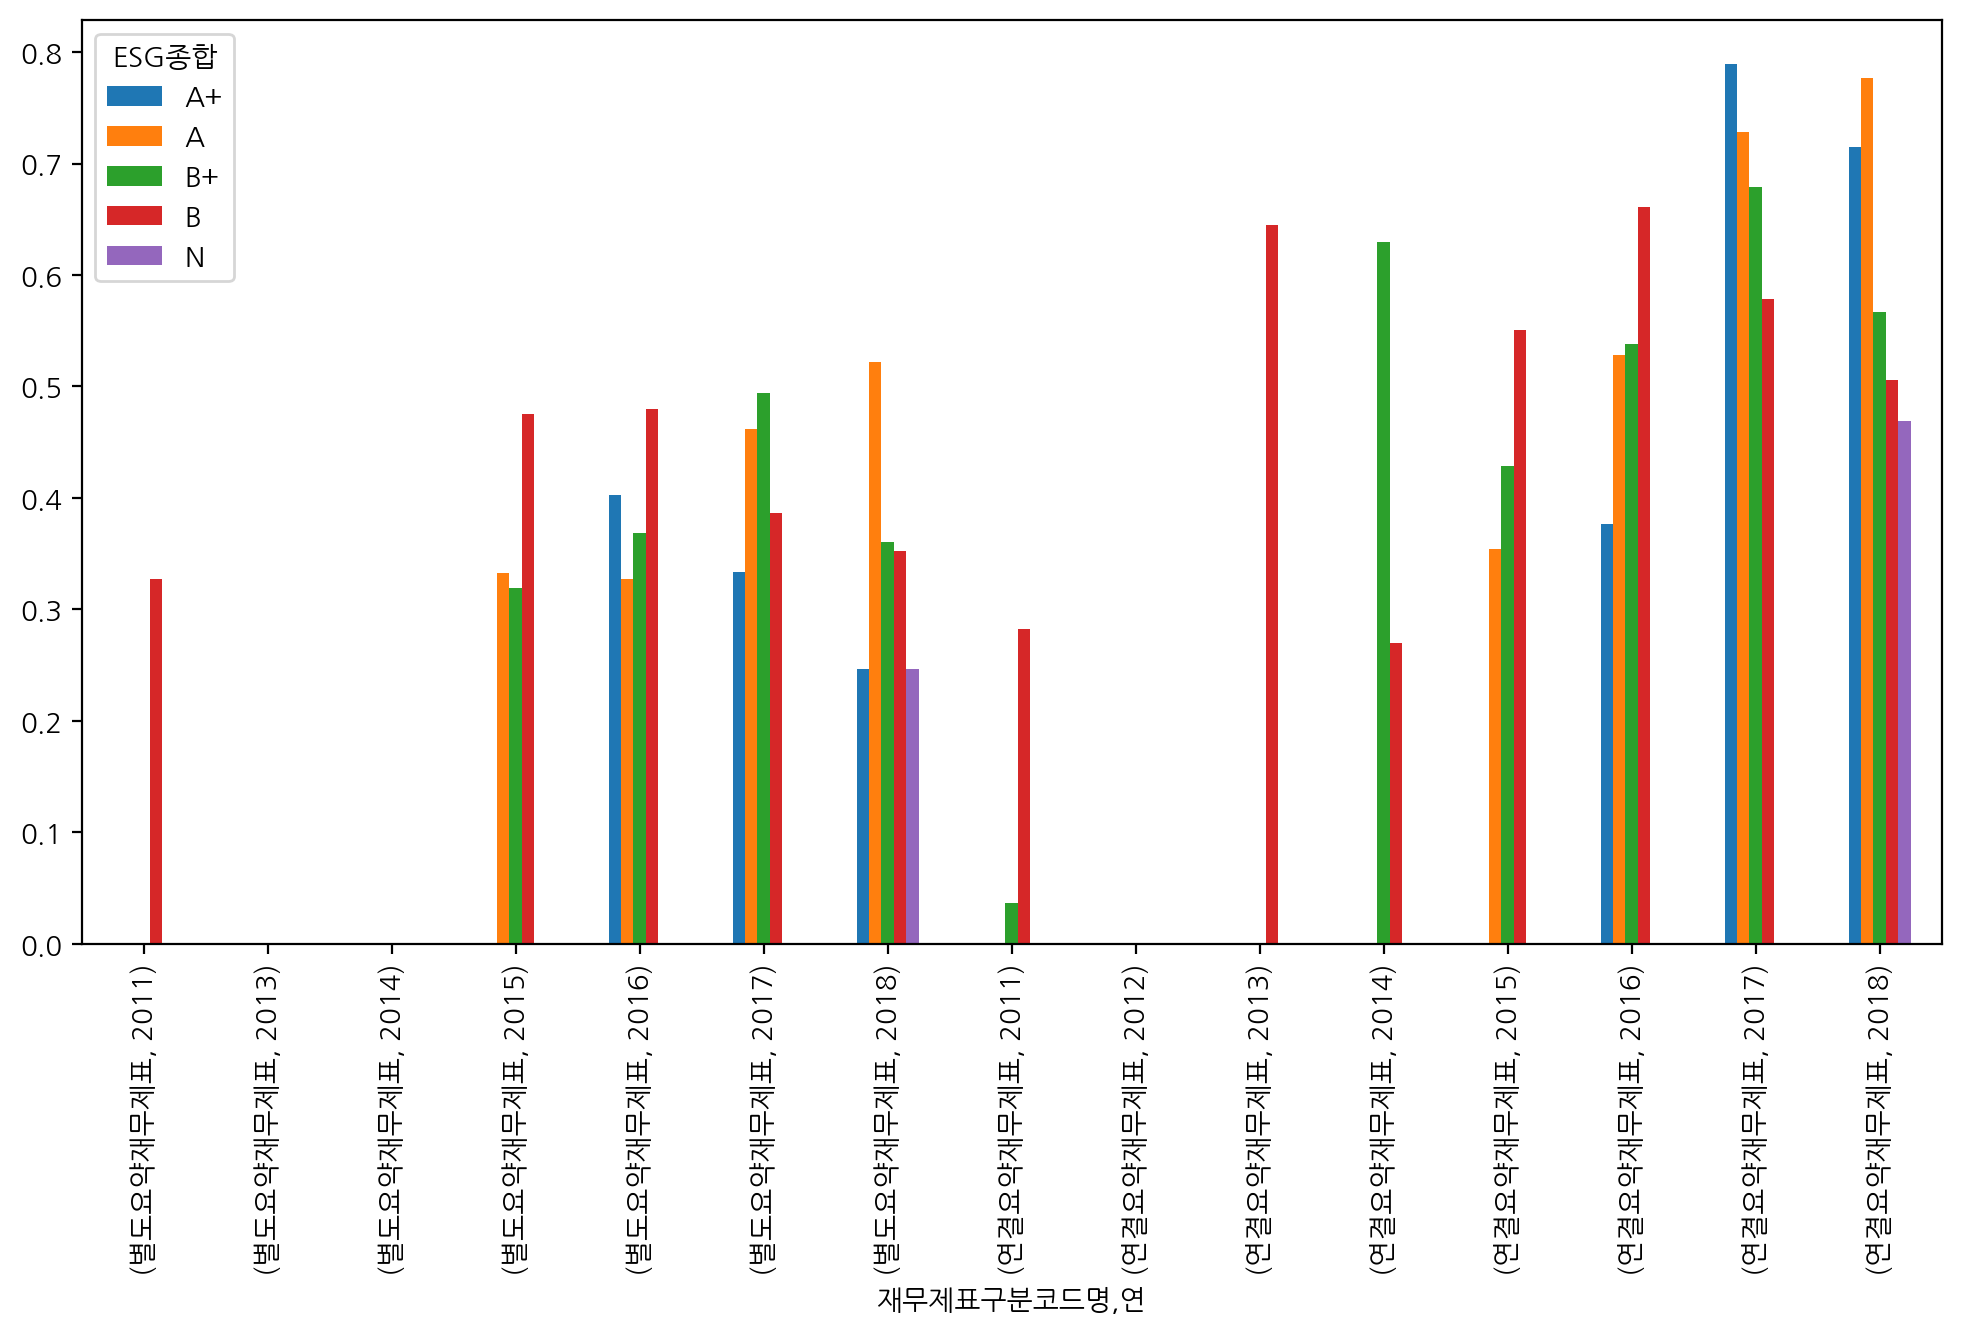

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액_mmscl
E


E                  A+      A     B+      B      C      D
재무제표구분코드명 연                                             
별도요약재무제표  2011    NaN    NaN    NaN 0.3271    NaN    NaN
          2013    NaN    NaN    NaN 0.0000    NaN    NaN
          2014    NaN    NaN    NaN    NaN 0.0000    NaN
          2015    NaN 0.4420 0.3663 0.4467 0.4432 0.5677
          2016 0.3017 0.3232 0.4132 0.4175 0.5171 0.5073
          2017 0.5000 0.3518 0.4840 0.3771 0.4749 0.2327
          2018 0.1478 0.4091 0.4550 0.3572 0.2554 0.4139
연결요약재무제표  2011    NaN    NaN    NaN 0.2944 0.0000    NaN
          2012    NaN    NaN    NaN 0.0000 0.0000    NaN
          2013    NaN    NaN    NaN    NaN 0.6448    NaN
          2014    NaN    NaN 0.6294    NaN 0.2699    NaN
          2015    NaN 0.4383 0.4356 0.5173 0.5352 0.7826
          2016 0.4757 0.4834 0.5962 0.6274 0.6376 0.6487
          2017 0.9924 0.7107 0.7274 0.5496 0.6079 0.3728
          2018 0.6688 0.8661 0.6801 0.4699 0.3886 0.6838

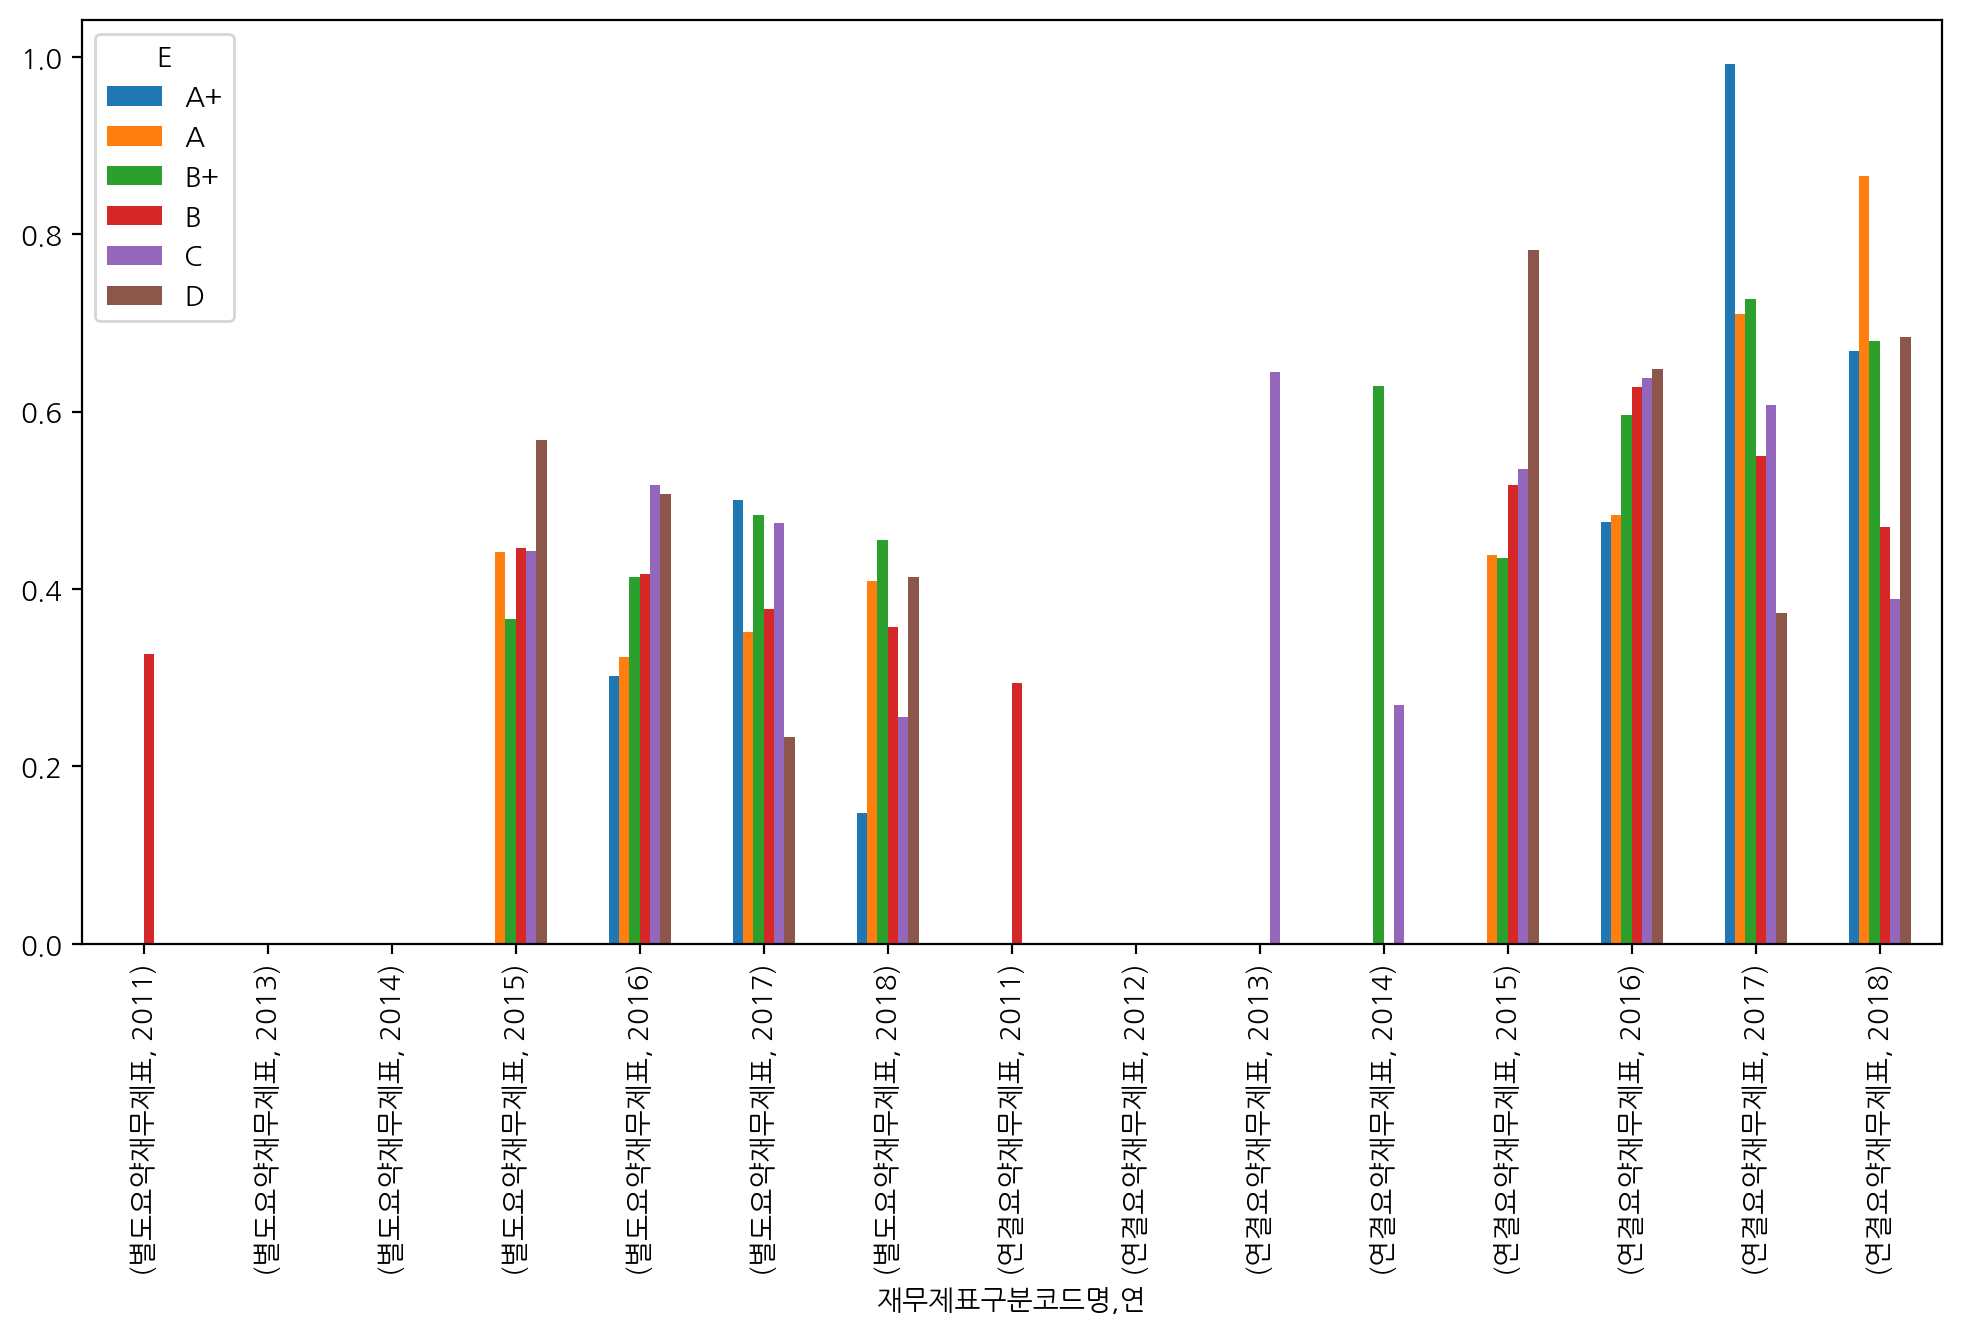

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액_mmscl
S


S                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.3271    NaN
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015 0.1221 0.4174 0.4258 0.4429    NaN
          2016 0.2848 0.5942 0.4053 0.4647    NaN
          2017 0.5555 0.4009 0.3929 0.4102    NaN
          2018 0.4430 0.4322 0.3201 0.3735 0.2461
연결요약재무제표  2011    NaN    NaN 0.0365 0.2823    NaN
          2012    NaN    NaN 0.0000 0.0000    NaN
          2013    NaN    NaN    NaN 0.6448    NaN
          2014    NaN    NaN    NaN 0.3597    NaN
          2015 0.3021 0.4466 0.5330 0.5128    NaN
          2016 0.4984 0.6316 0.5286 0.6774    NaN
          2017 0.7557 0.7110 0.6069 0.5857    NaN
          2018 0.6889 0.7387 0.4523 0.5525 0.4687

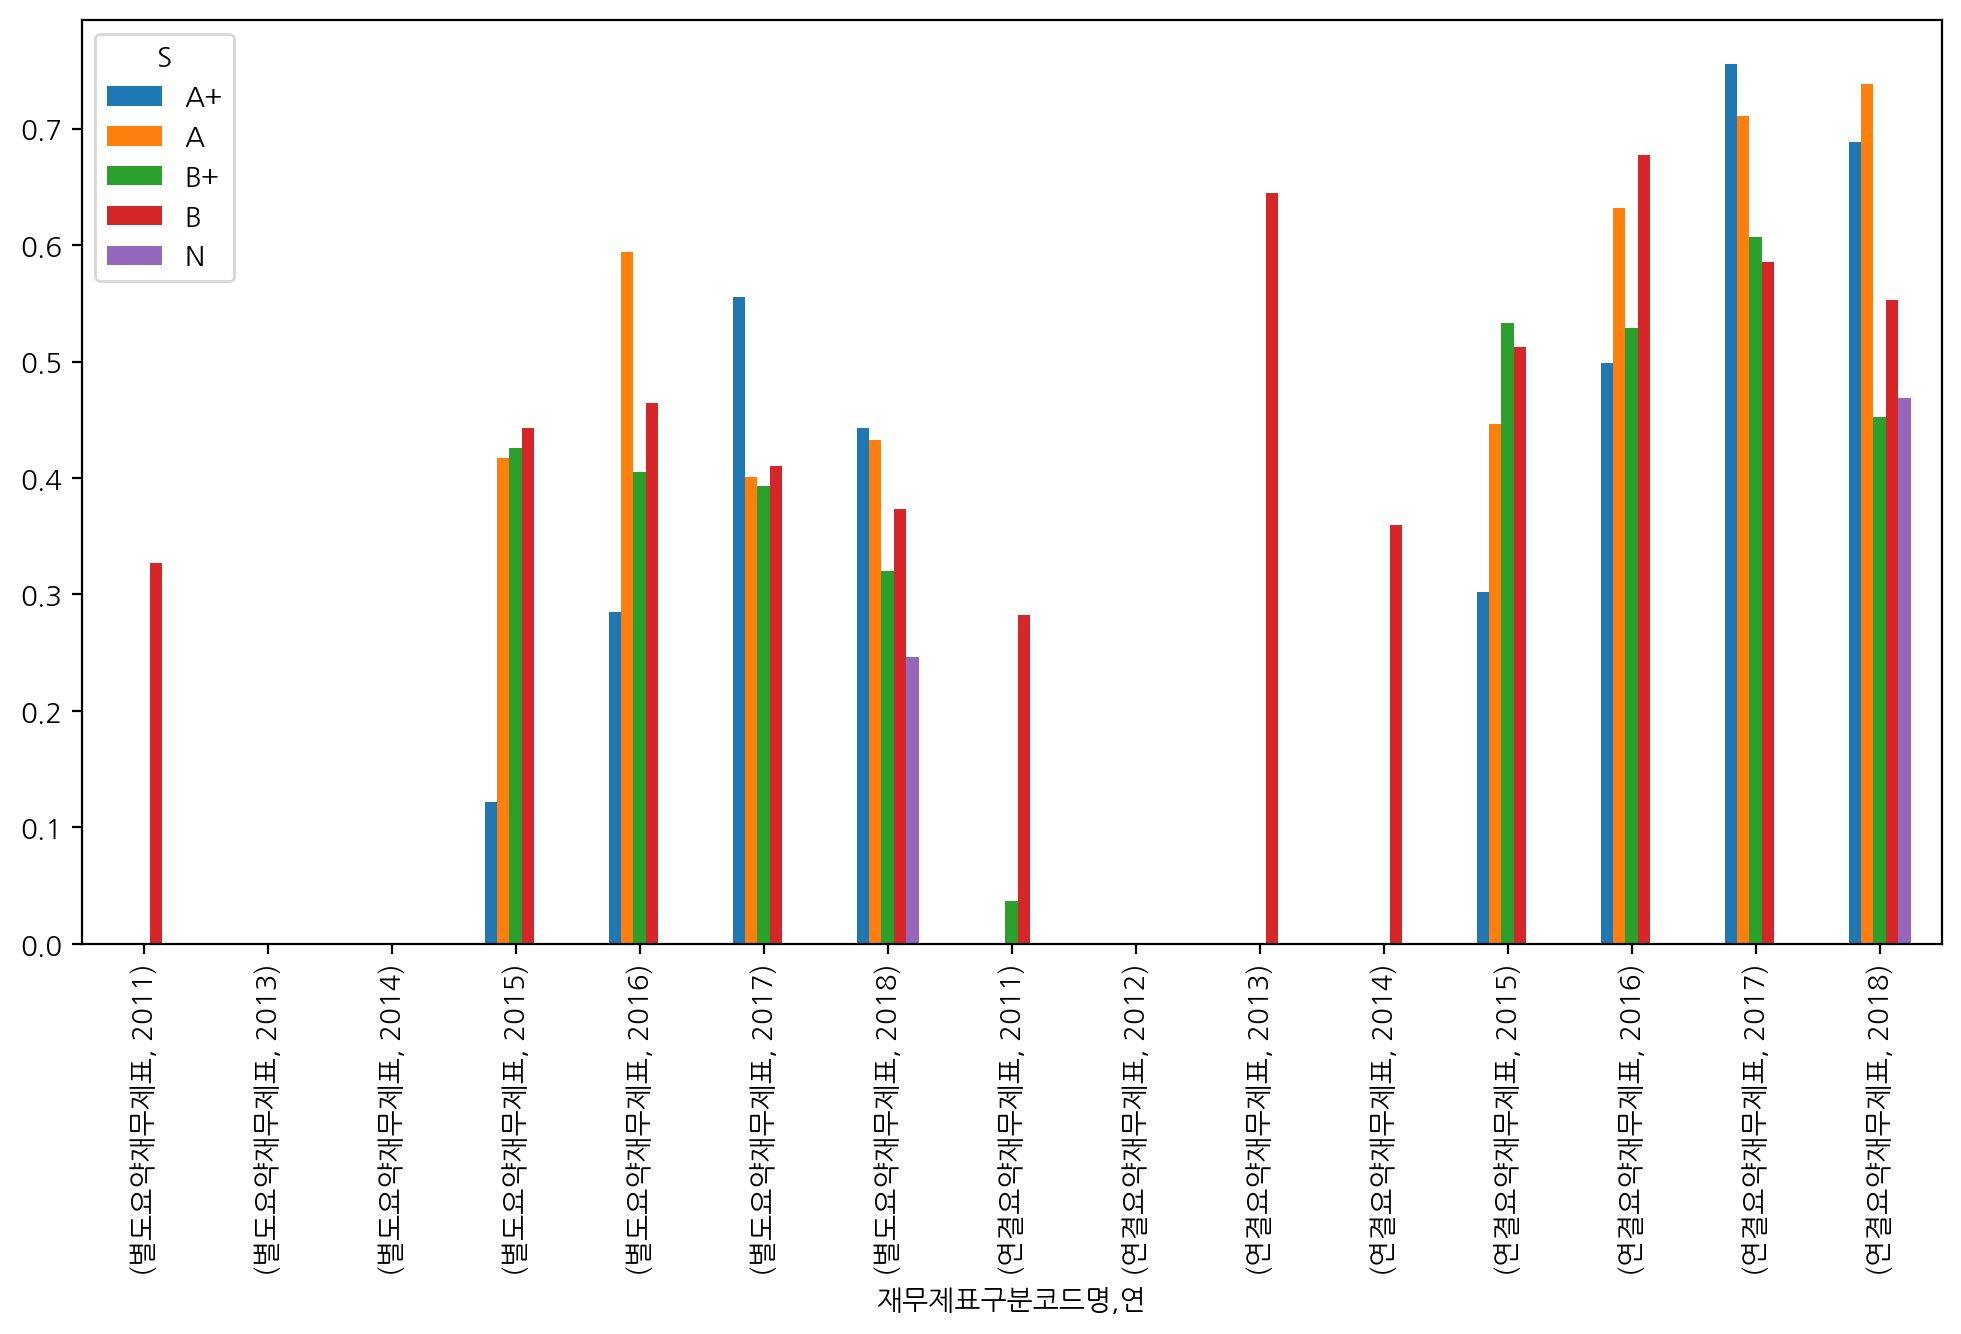

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액_mmscl
G


G                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN    NaN 0.3271
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015 0.1342 0.3356 0.4615 0.4503    NaN
          2016 0.0631 0.3652 0.4794 0.4498    NaN
          2017 0.0000 0.5415 0.4452 0.3717    NaN
          2018 0.6907 0.4268 0.3773 0.3507 0.2461
연결요약재무제표  2011    NaN    NaN 0.0365 0.0923 0.6621
          2012    NaN    NaN 0.0000 0.0000    NaN
          2013    NaN    NaN    NaN 0.6448    NaN
          2014    NaN    NaN 0.2098 0.8096    NaN
          2015 0.3013 0.4257 0.5475 0.5153    NaN
          2016 0.1847 0.5361 0.5950 0.6573    NaN
          2017 0.3835 0.7222 0.6055 0.5982    NaN
          2018 0.9268 0.6854 0.5012 0.5512 0.4687

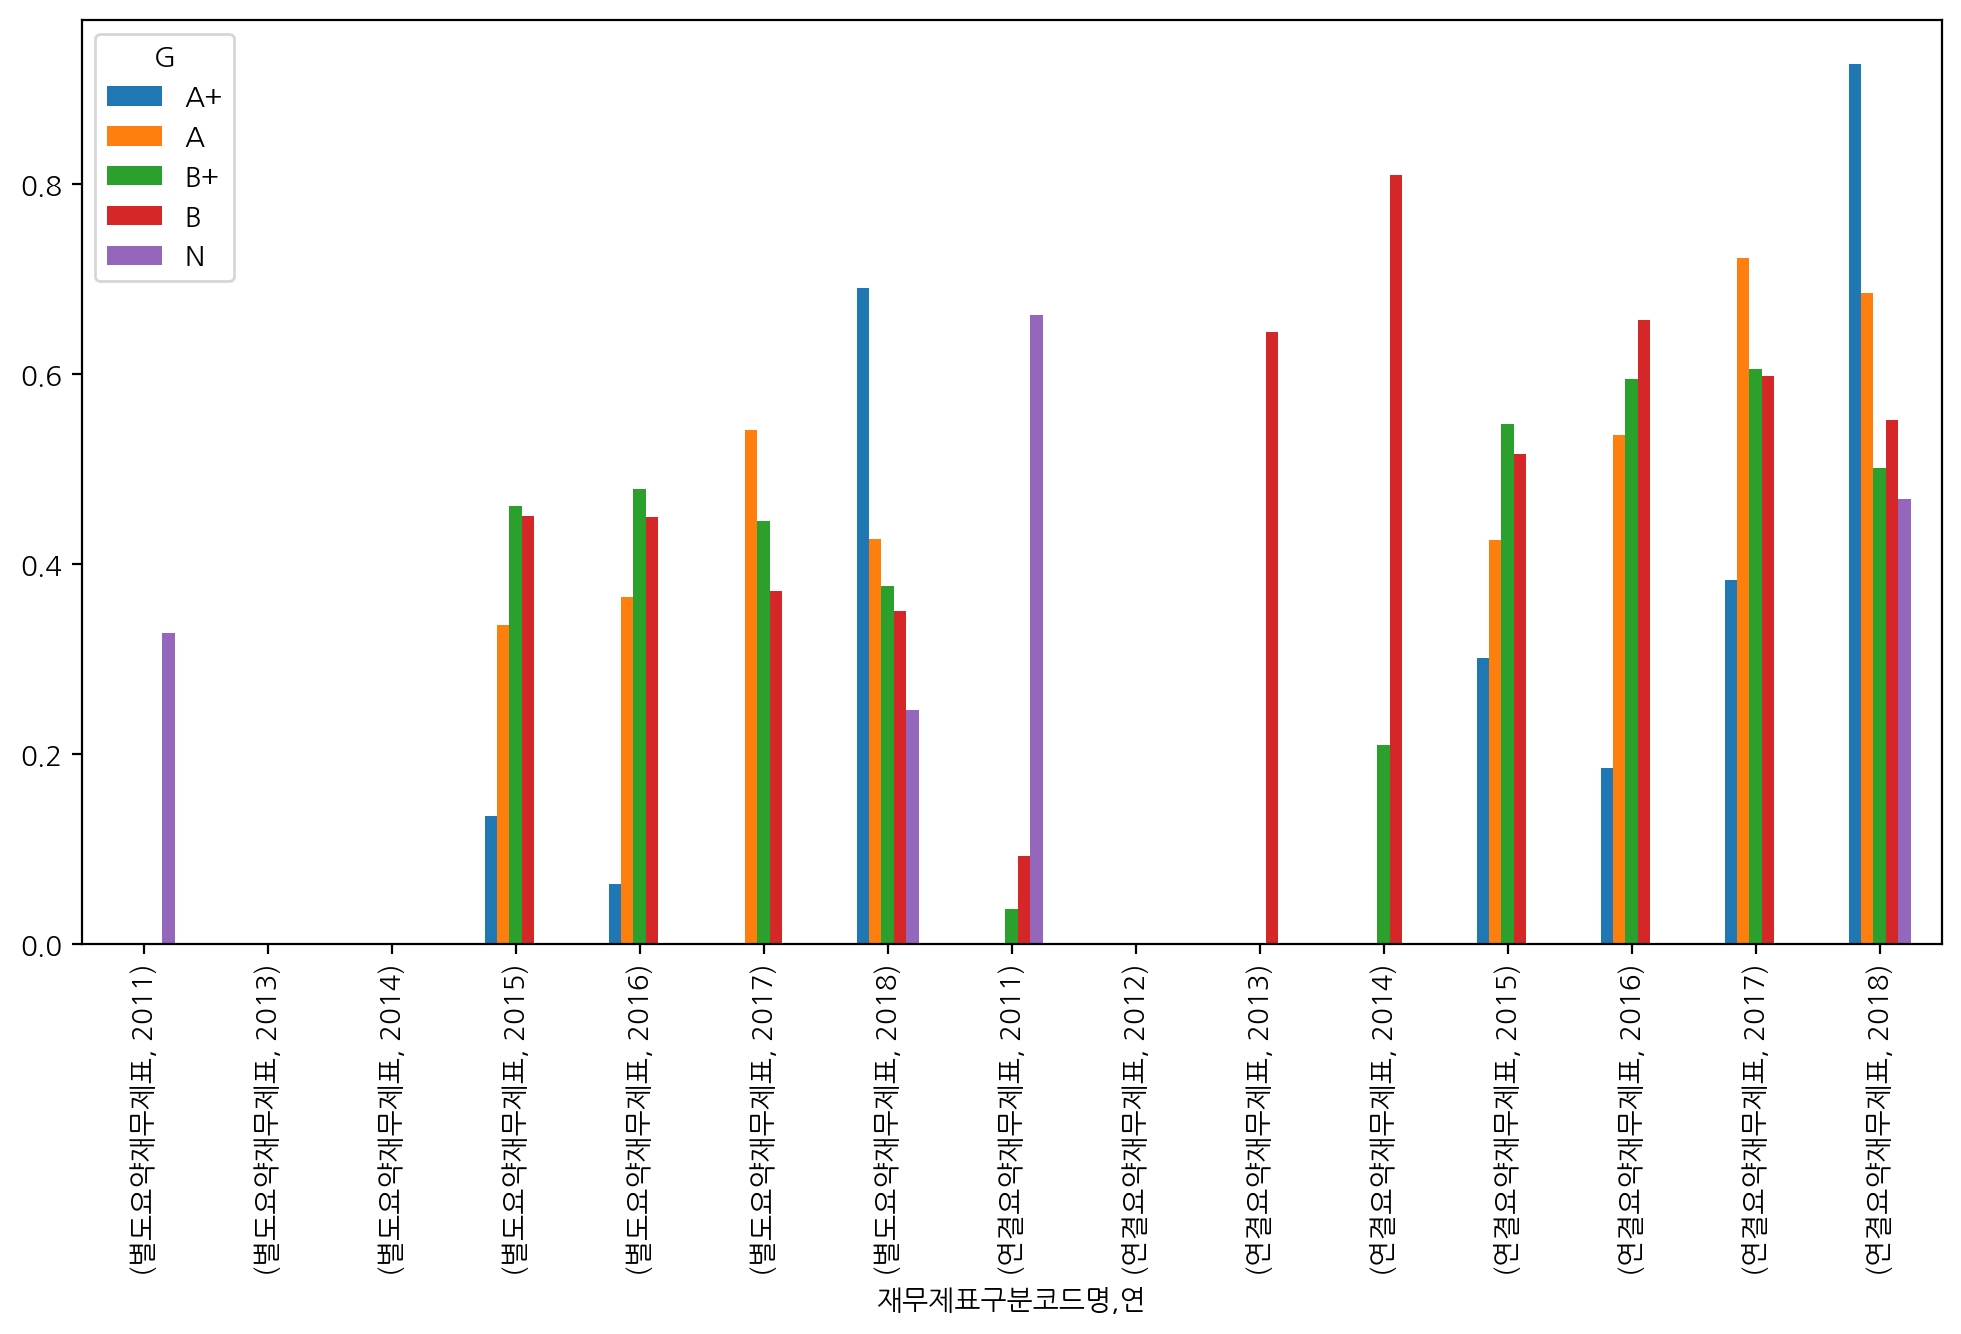

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업당기순이익_mmscl
ESG종합


ESG종합              A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.4224    NaN
          2013    NaN    NaN    NaN 0.5273    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015    NaN 0.3091 0.3418 0.4674    NaN
          2016 0.4088 0.3596 0.3659 0.4857    NaN
          2017 0.3665 0.4657 0.5388 0.4340    NaN
          2018 0.2426 0.4873 0.3851 0.3461 0.0332
연결요약재무제표  2011    NaN    NaN 0.0092 0.3997    NaN
          2012    NaN    NaN 0.0000 0.0000    NaN
          2013    NaN    NaN    NaN 0.7190    NaN
          2014    NaN    NaN 0.5879 0.2591    NaN
          2015    NaN 0.2723 0.4117 0.5188    NaN
          2016 0.3935 0.5466 0.5032 0.6271    NaN
          2017 0.7422 0.7055 0.6703 0.5820    NaN
          2018 0.6632 0.6741 0.5726 0.4677 0.0986

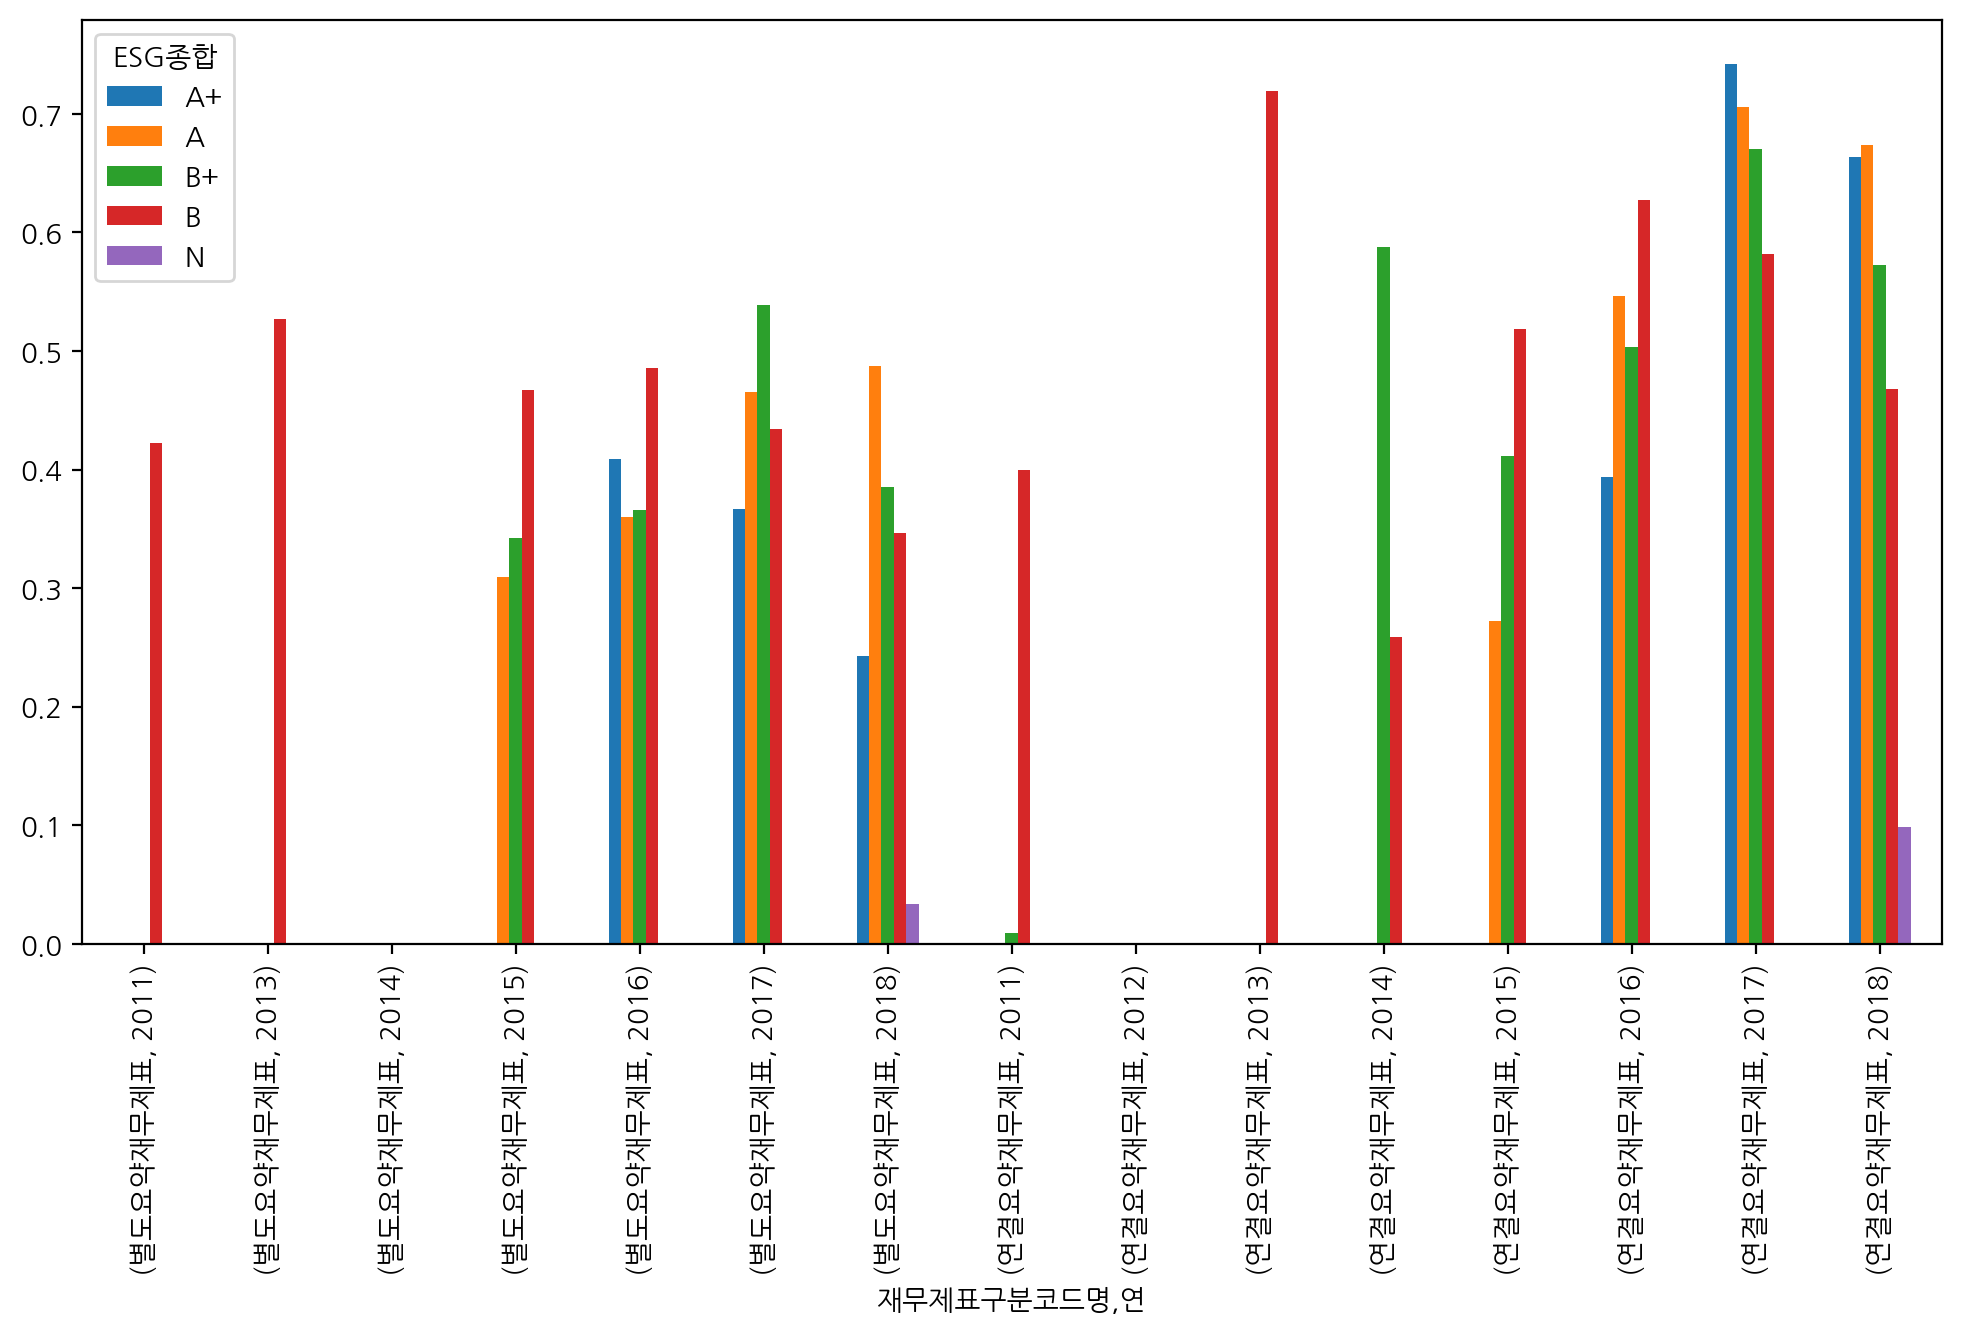

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업당기순이익_mmscl
E


E                  A+      A     B+      B      C      D
재무제표구분코드명 연                                             
별도요약재무제표  2011    NaN    NaN    NaN 0.4224    NaN    NaN
          2013    NaN    NaN    NaN 0.5273    NaN    NaN
          2014    NaN    NaN    NaN    NaN 0.0000    NaN
          2015    NaN 0.4528 0.3330 0.4577 0.4405 0.5783
          2016 0.3066 0.3118 0.4298 0.4270 0.5461 0.3114
          2017 0.5497 0.3668 0.5363 0.4298 0.5136 0.1704
          2018 0.1781 0.3062 0.4872 0.3263 0.2790 0.3915
연결요약재무제표  2011    NaN    NaN    NaN 0.4027 0.0000    NaN
          2012    NaN    NaN    NaN 0.0000 0.0000    NaN
          2013    NaN    NaN    NaN    NaN 0.7190    NaN
          2014    NaN    NaN 0.5879    NaN 0.2591    NaN
          2015    NaN 0.3326 0.3882 0.5395 0.4637 0.7547
          2016 0.5025 0.4125 0.5876 0.5866 0.6308 0.5327
          2017 0.9106 0.7155 0.7131 0.5601 0.6169 0.2966
          2018 0.6681 0.6923 0.6587 0.4094 0.4134 0.5593

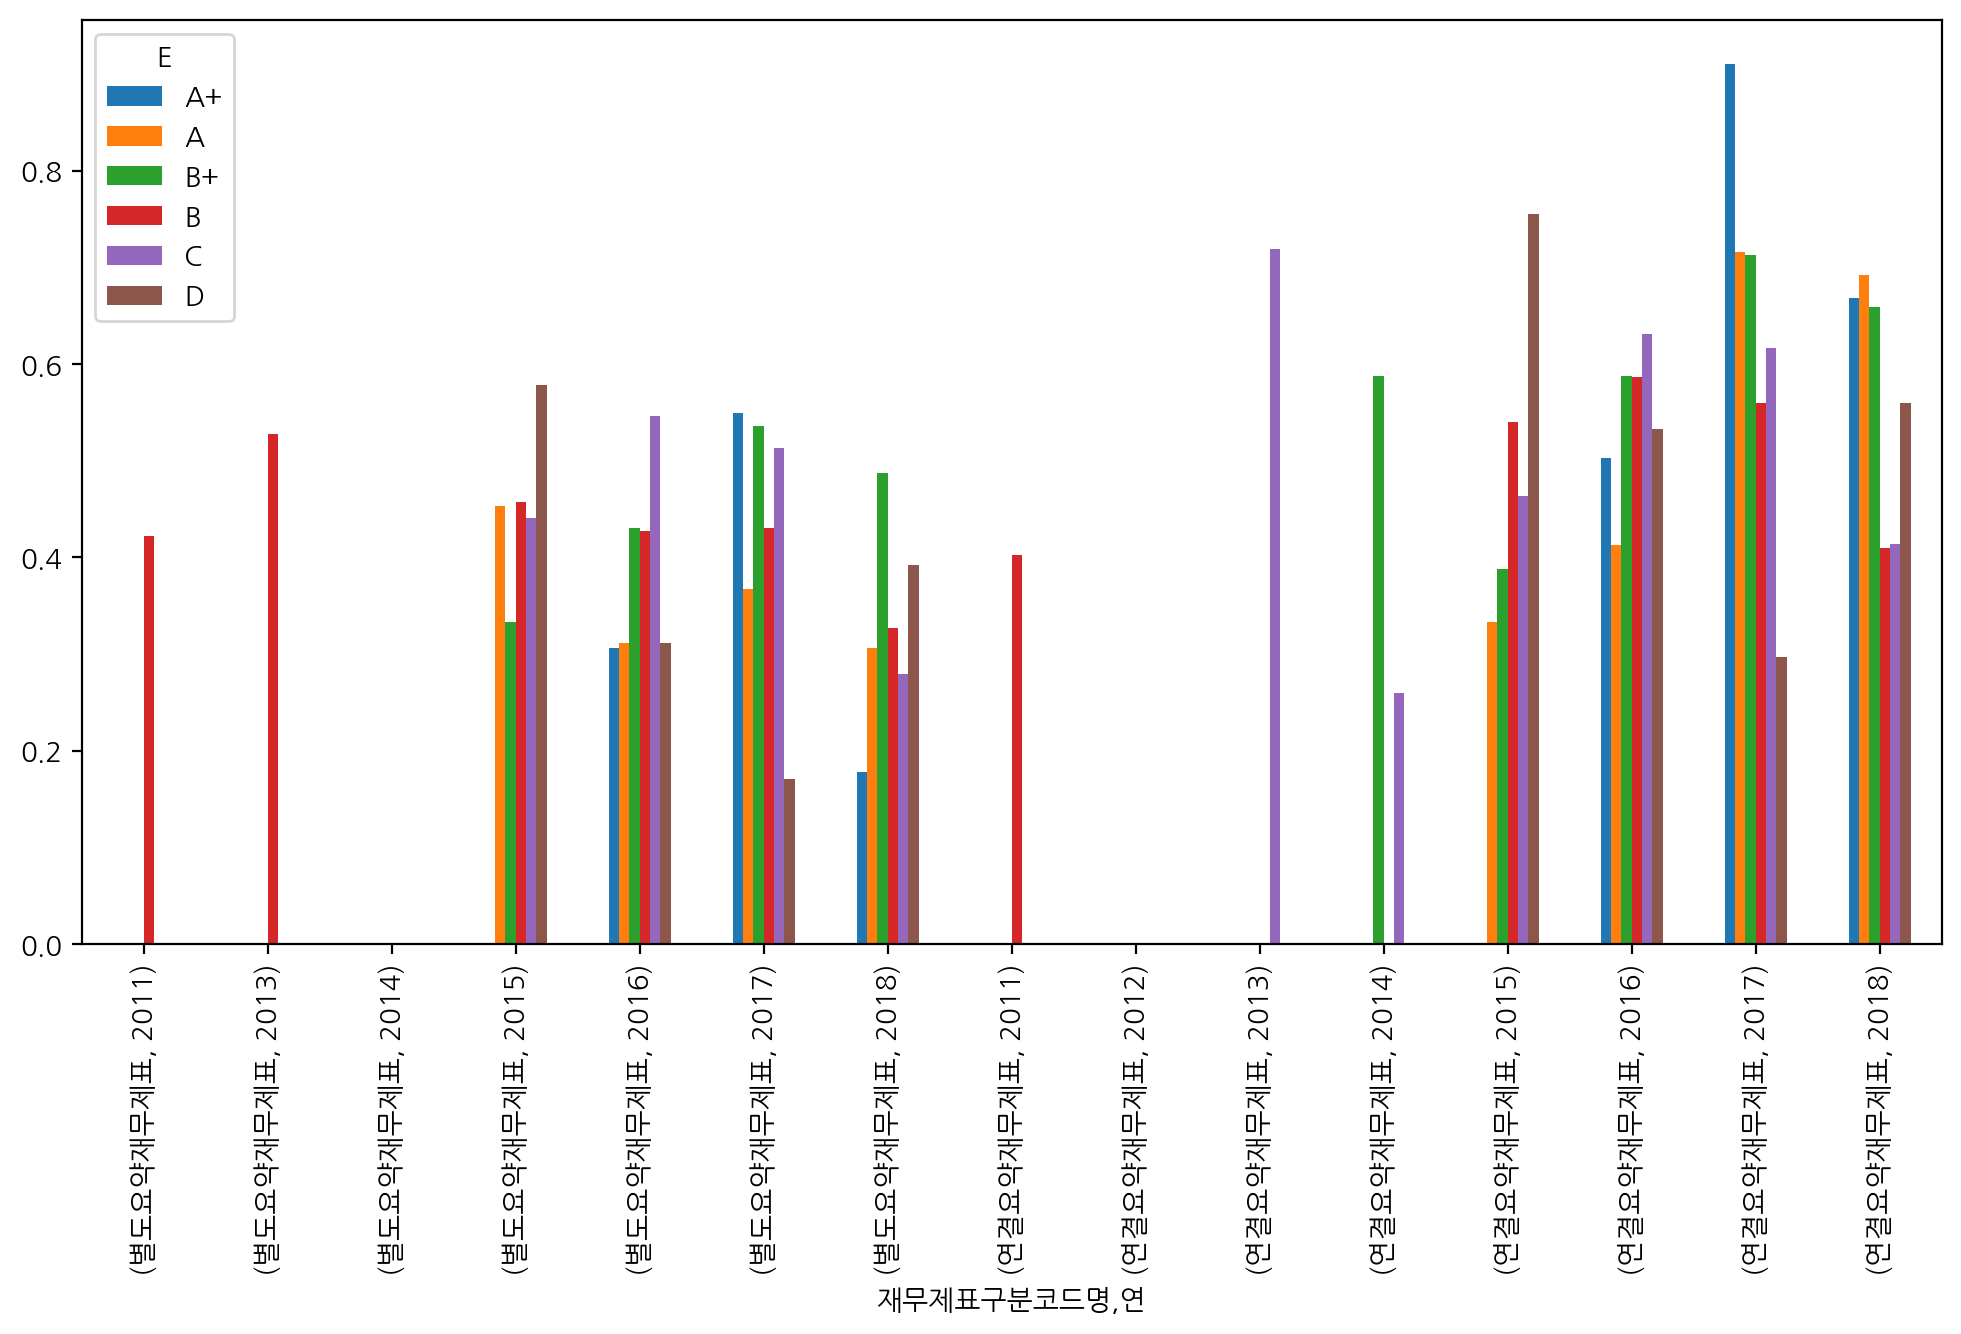

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업당기순이익_mmscl
S


S                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.4224    NaN
          2013    NaN    NaN    NaN 0.5273    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015 0.1253 0.3980 0.4220 0.4433    NaN
          2016 0.3153 0.6208 0.3849 0.4790    NaN
          2017 0.5402 0.5127 0.4236 0.4557    NaN
          2018 0.4430 0.4086 0.3282 0.3691 0.0332
연결요약재무제표  2011    NaN    NaN 0.0092 0.3997    NaN
          2012    NaN    NaN 0.0000 0.0000    NaN
          2013    NaN    NaN    NaN 0.7190    NaN
          2014    NaN    NaN    NaN 0.3413    NaN
          2015 0.2967 0.4300 0.4635 0.4901    NaN
          2016 0.5062 0.7019 0.4608 0.6523    NaN
          2017 0.7399 0.7062 0.5827 0.5948    NaN
          2018 0.6328 0.6915 0.4505 0.5023 0.0986

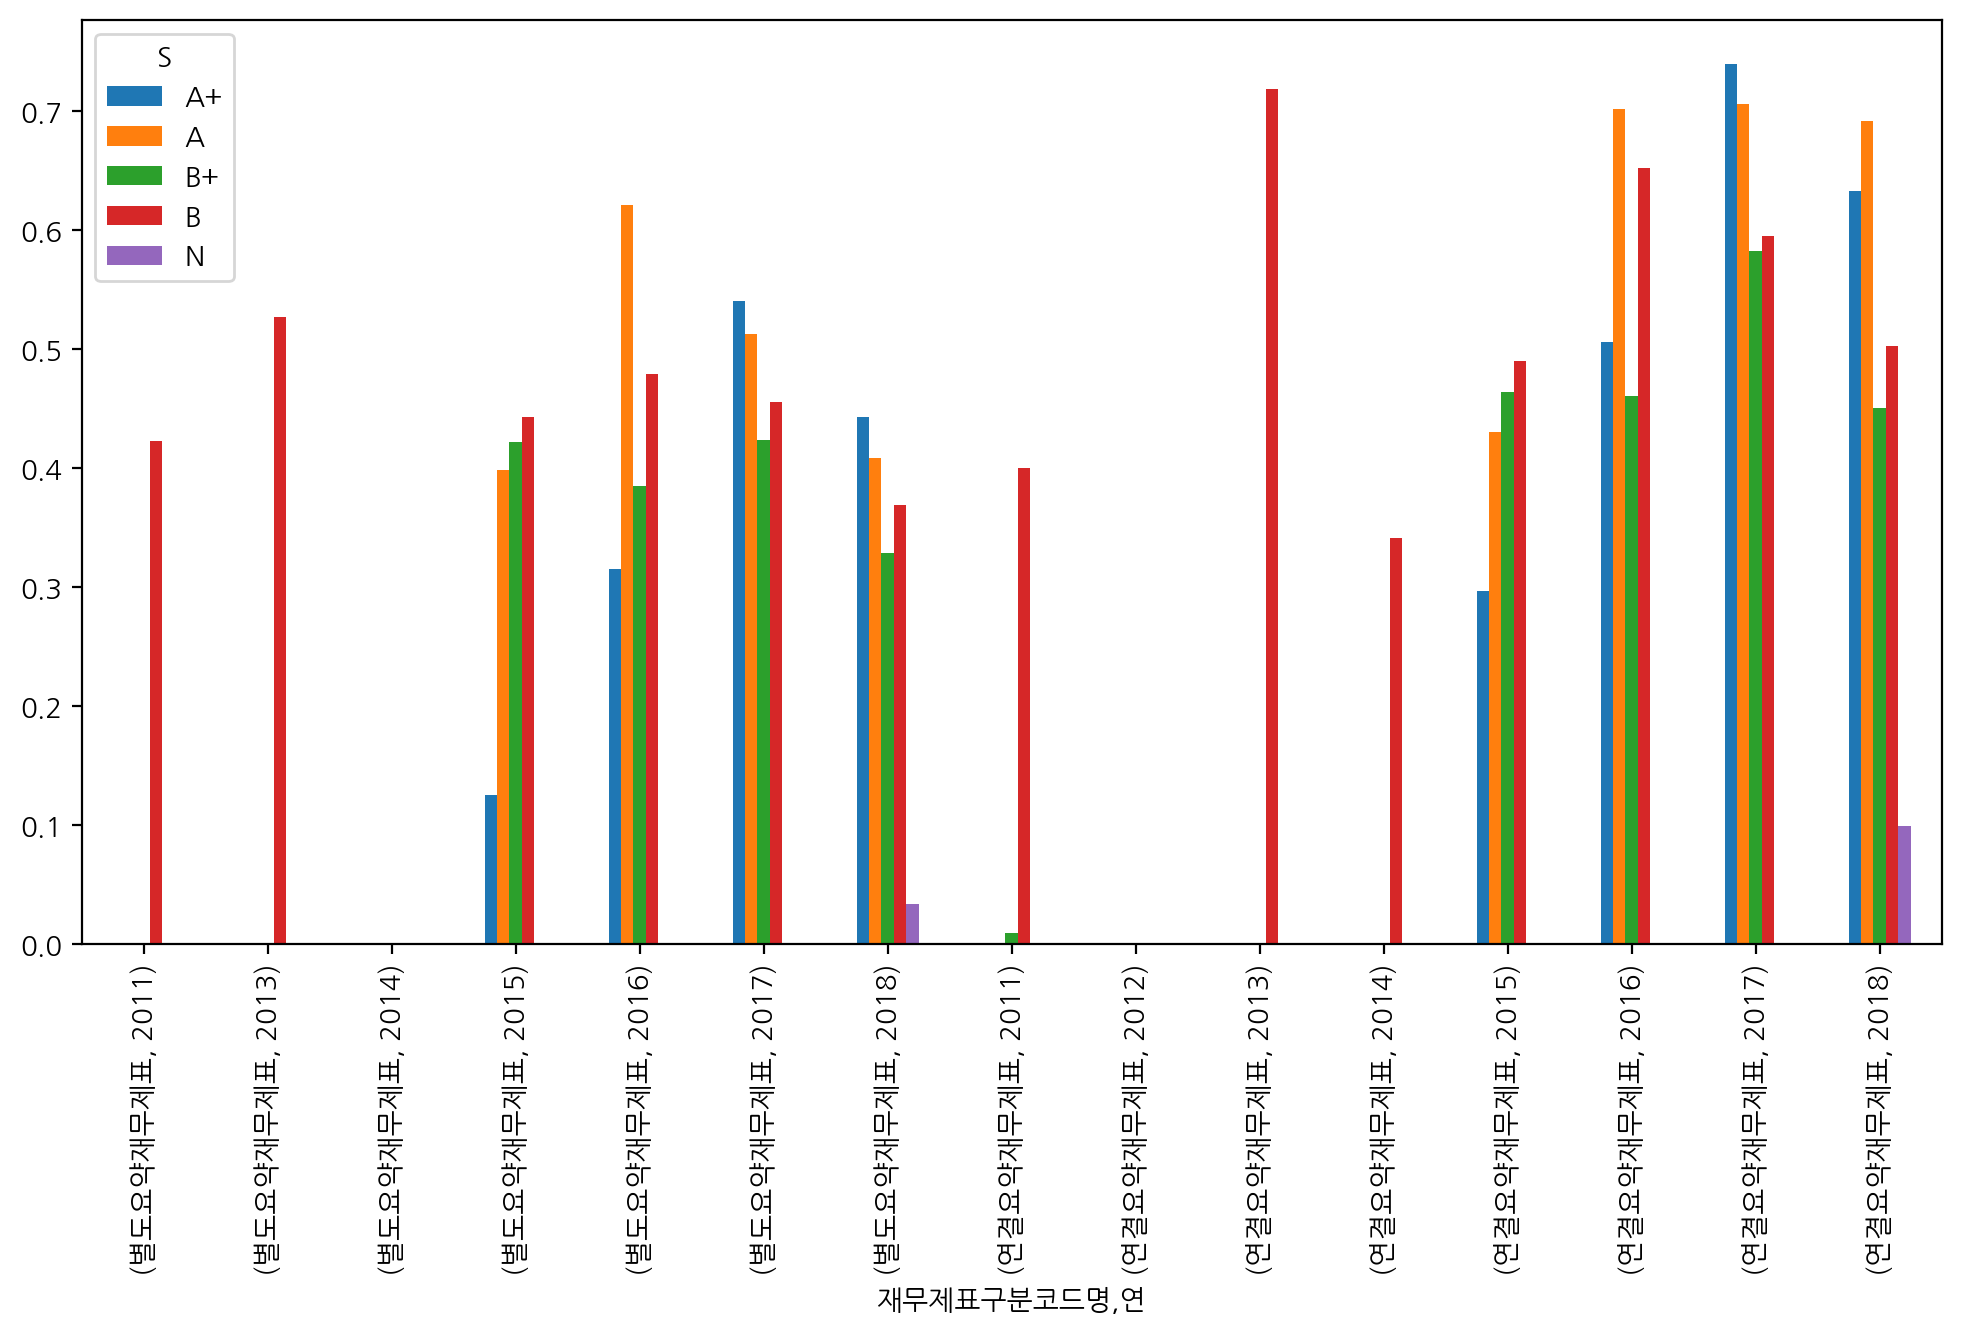

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업당기순이익_mmscl
G


G                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN    NaN 0.4224
          2013    NaN    NaN    NaN 0.5273    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015 0.0067 0.3532 0.4648 0.4430    NaN
          2016 0.1229 0.3517 0.4971 0.4558    NaN
          2017 0.0000 0.5517 0.4620 0.4379    NaN
          2018 0.6356 0.4313 0.3797 0.3445 0.0332
연결요약재무제표  2011    NaN    NaN 0.0092 0.2418 0.7153
          2012    NaN    NaN 0.0000 0.0000    NaN
          2013    NaN    NaN    NaN 0.7190    NaN
          2014    NaN    NaN 0.1960 0.7773    NaN
          2015 0.1674 0.3386 0.5094 0.5071    NaN
          2016 0.2245 0.5103 0.6091 0.6044    NaN
          2017 0.4053 0.7080 0.5837 0.6087    NaN
          2018 0.8242 0.6581 0.4714 0.5106 0.0986

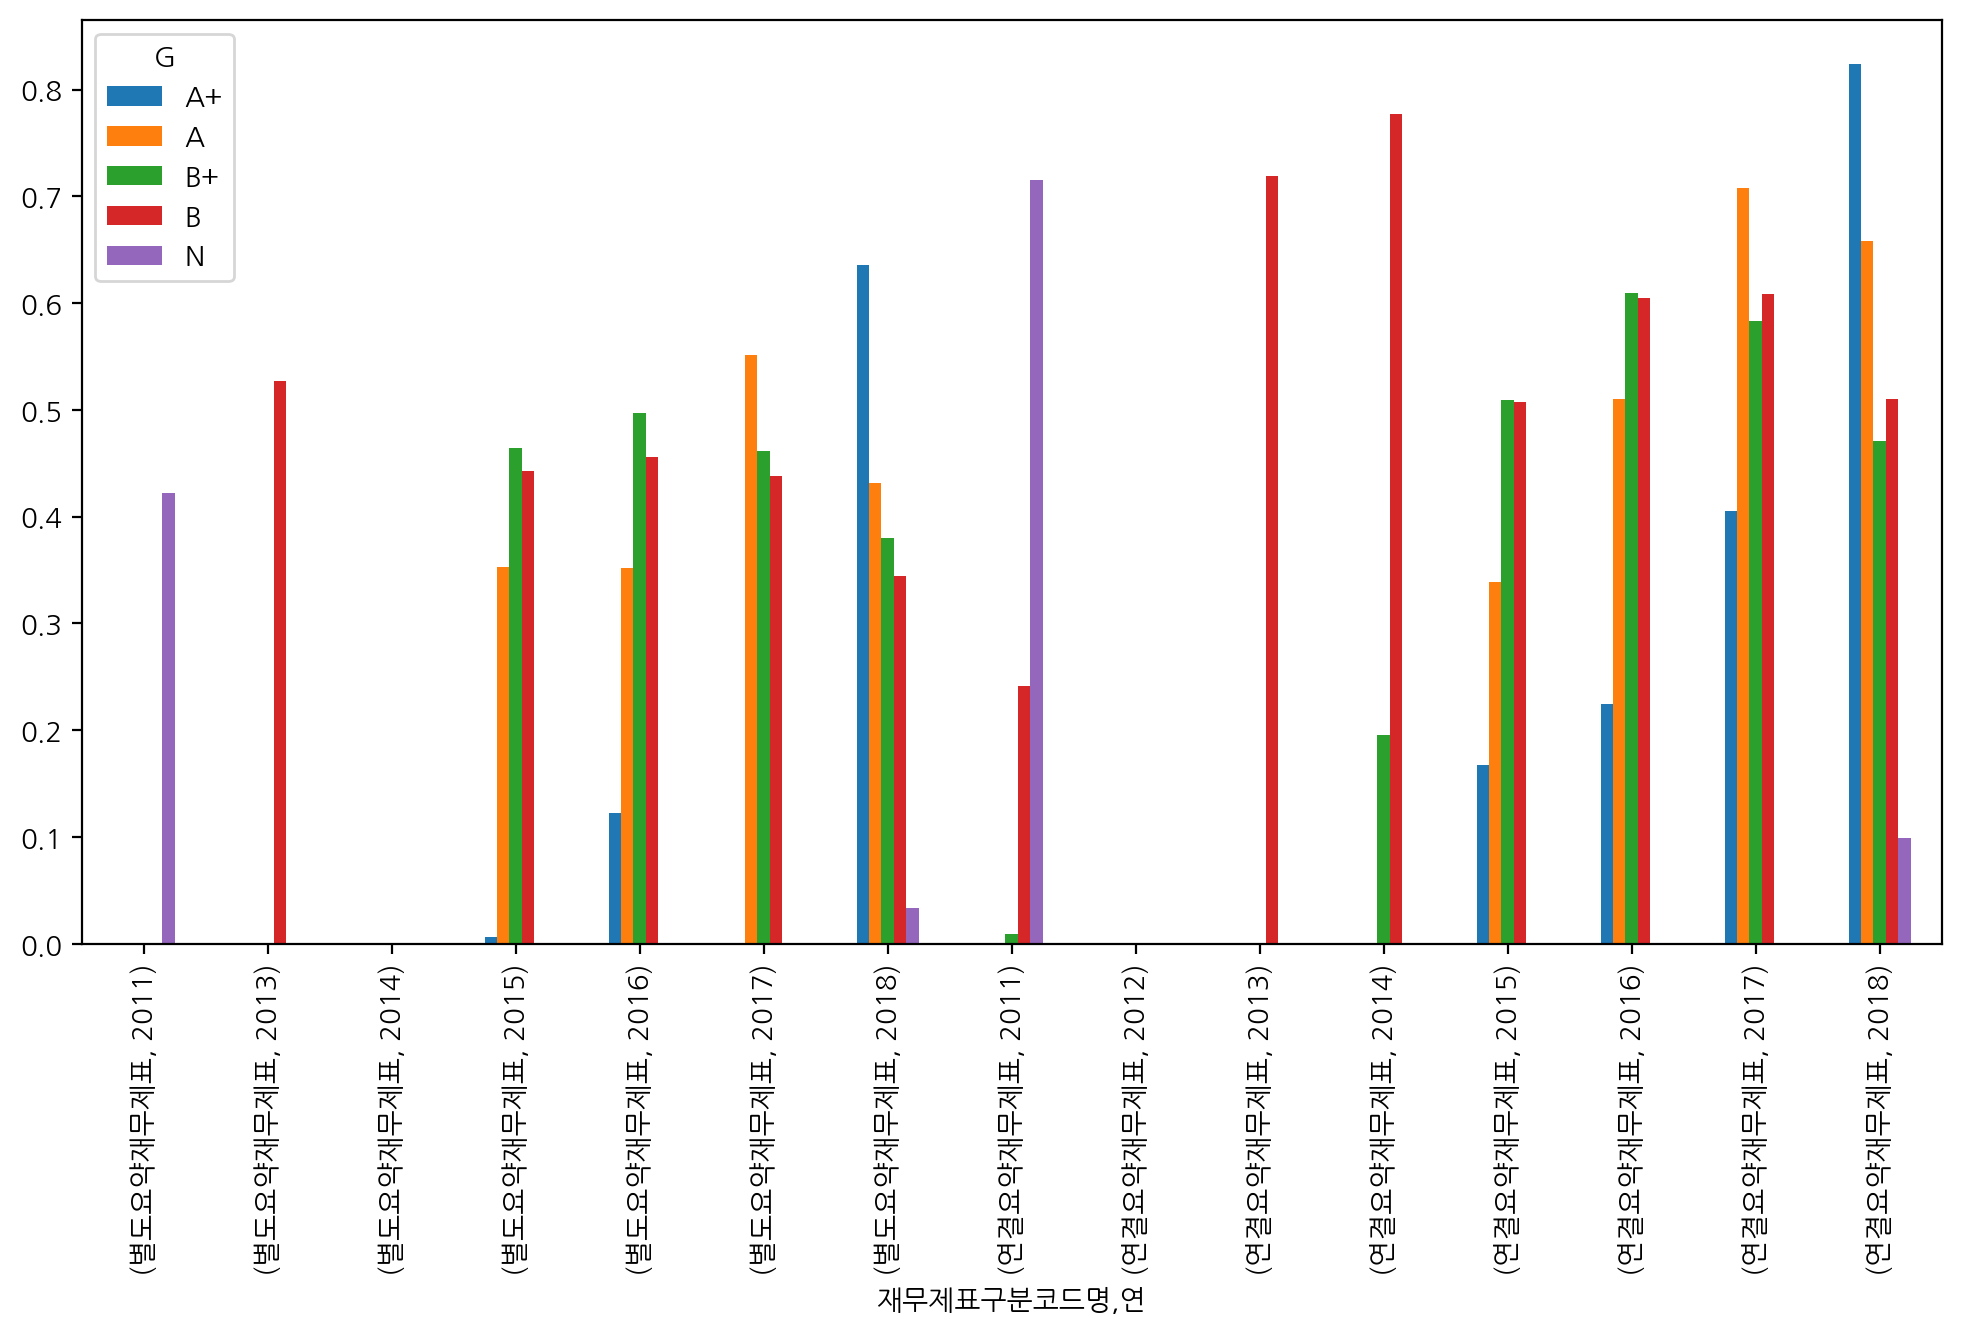

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자산금액_mmscl
ESG종합


ESG종합              A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.0000    NaN
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015    NaN 0.0595 0.1372 0.1317    NaN
          2016 0.2408 0.1635 0.2035 0.2387    NaN
          2017 0.2779 0.3276 0.3025 0.3043    NaN
          2018 0.3334 0.3349 0.3606 0.3621 0.5008
연결요약재무제표  2011    NaN    NaN 0.3992 1.0000    NaN
          2012    NaN    NaN 0.9380 0.4006    NaN
          2013    NaN    NaN    NaN 0.5000    NaN
          2014    NaN    NaN 0.1417 0.1895    NaN
          2015    NaN 0.5433 0.5396 0.5441    NaN
          2016 0.6769 0.5958 0.6444 0.6655    NaN
          2017 0.8267 0.7884 0.7174 0.7468    NaN
          2018 0.8845 0.8320 0.8486 0.8338 0.8153

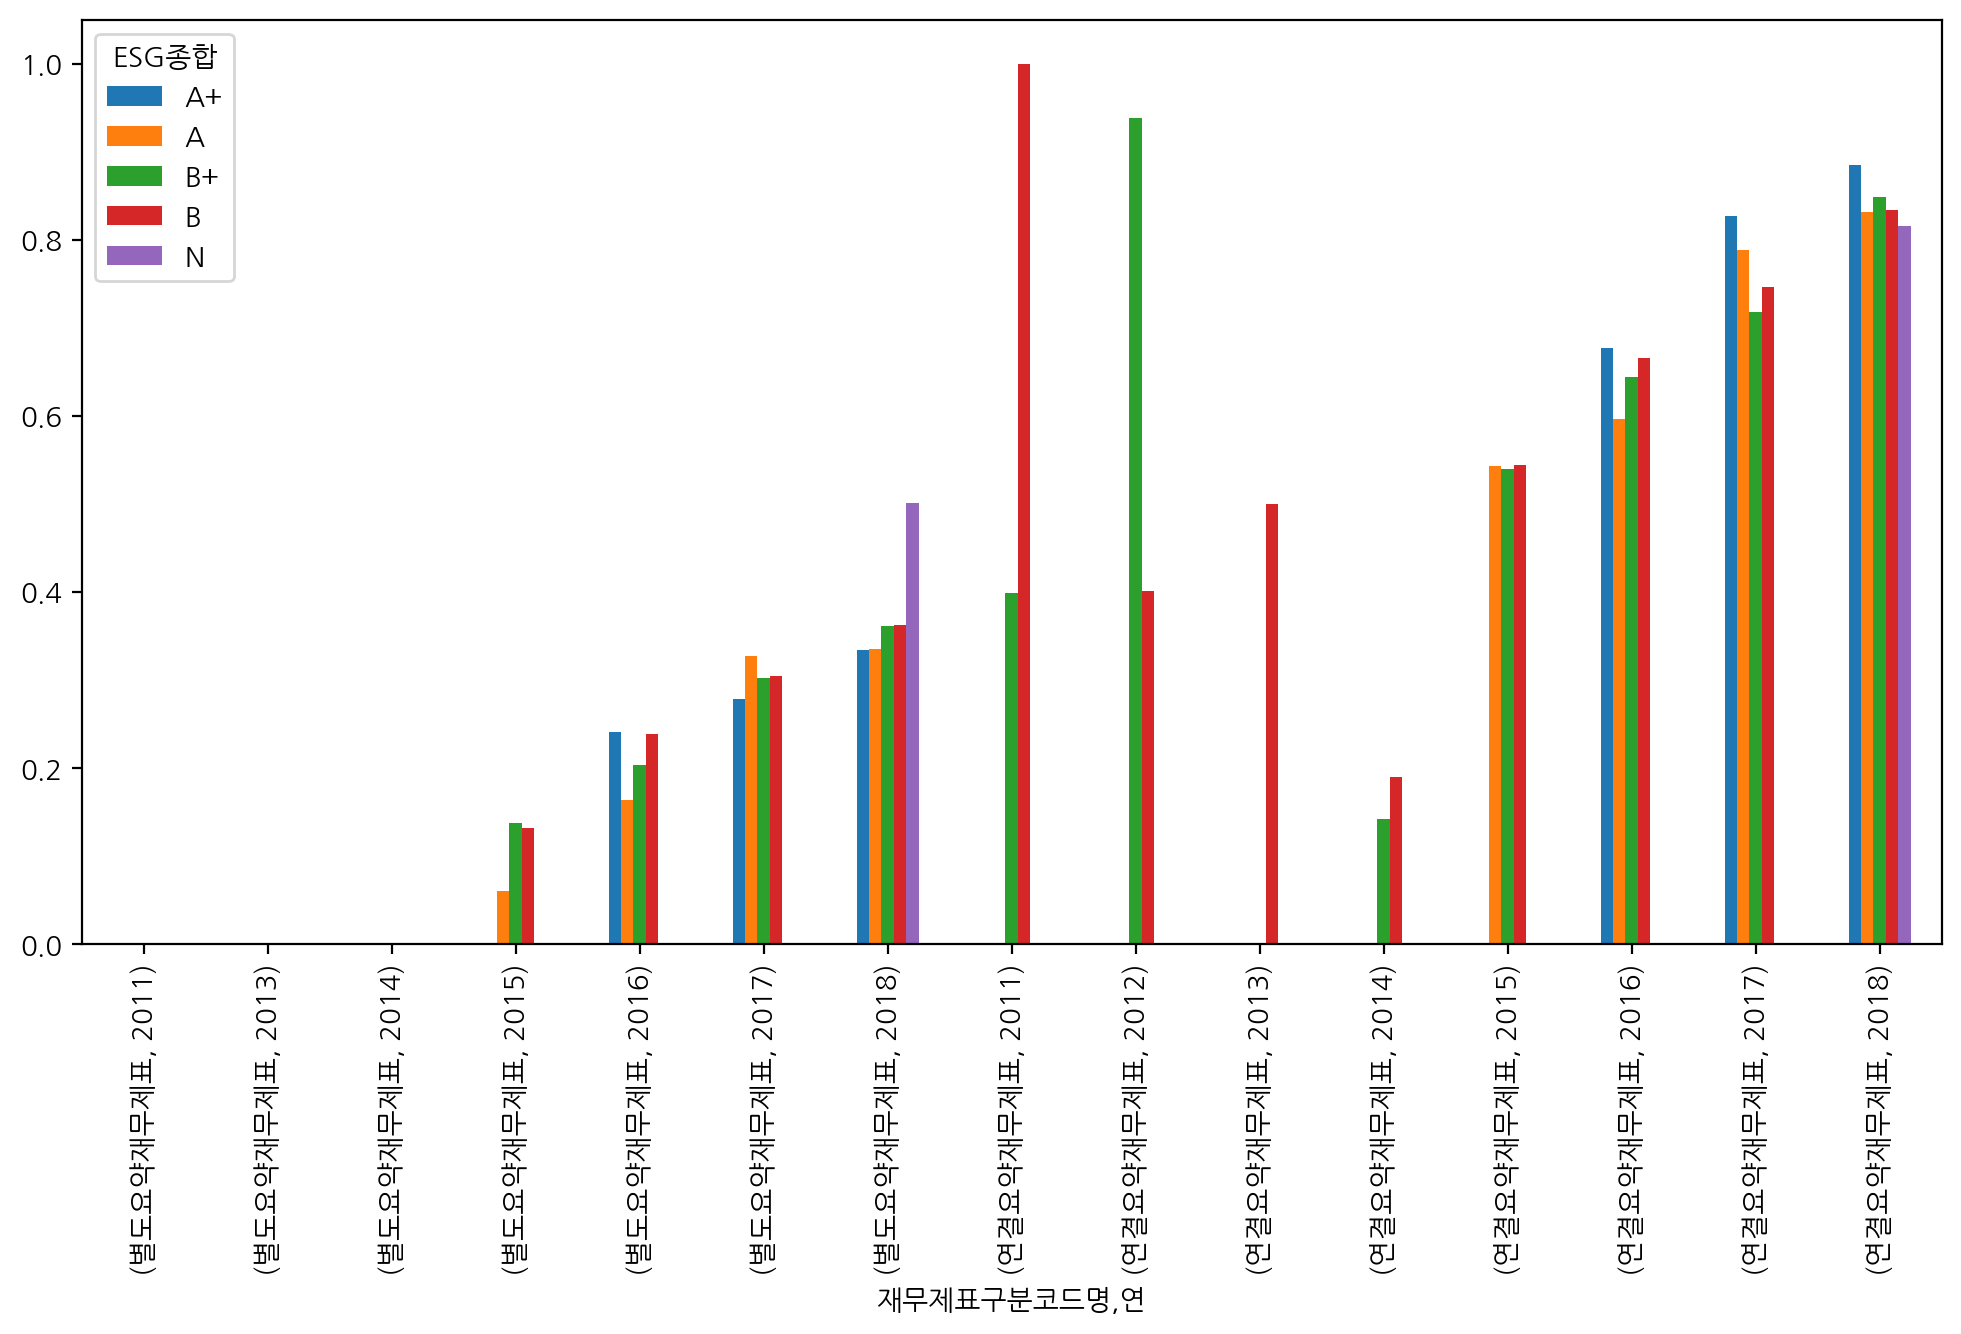

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자산금액_mmscl
E


E                  A+      A     B+      B      C      D
재무제표구분코드명 연                                             
별도요약재무제표  2011    NaN    NaN    NaN 0.0000    NaN    NaN
          2013    NaN    NaN    NaN 0.0000    NaN    NaN
          2014    NaN    NaN    NaN    NaN 0.0000    NaN
          2015    NaN 0.0093 0.1733 0.1650 0.0800 0.0459
          2016 0.1806 0.1844 0.1745 0.2429 0.2390 0.2347
          2017 0.4169 0.2635 0.3094 0.3384 0.2706 0.1372
          2018 0.4446 0.2006 0.3644 0.3966 0.3104 0.3913
연결요약재무제표  2011    NaN    NaN    NaN 0.7997 1.0000    NaN
          2012    NaN    NaN    NaN 0.5583 0.6226    NaN
          2013    NaN    NaN    NaN    NaN 0.5000    NaN
          2014    NaN    NaN 0.1417    NaN 0.1895    NaN
          2015    NaN 0.3865 0.5725 0.5654 0.5197 0.6913
          2016 0.7188 0.6221 0.6263 0.6356 0.6953 0.7243
          2017 0.8586 0.7755 0.7499 0.7321 0.7549 0.7241
          2018 0.9920 0.8131 0.8229 0.8387 0.8246 1.0000

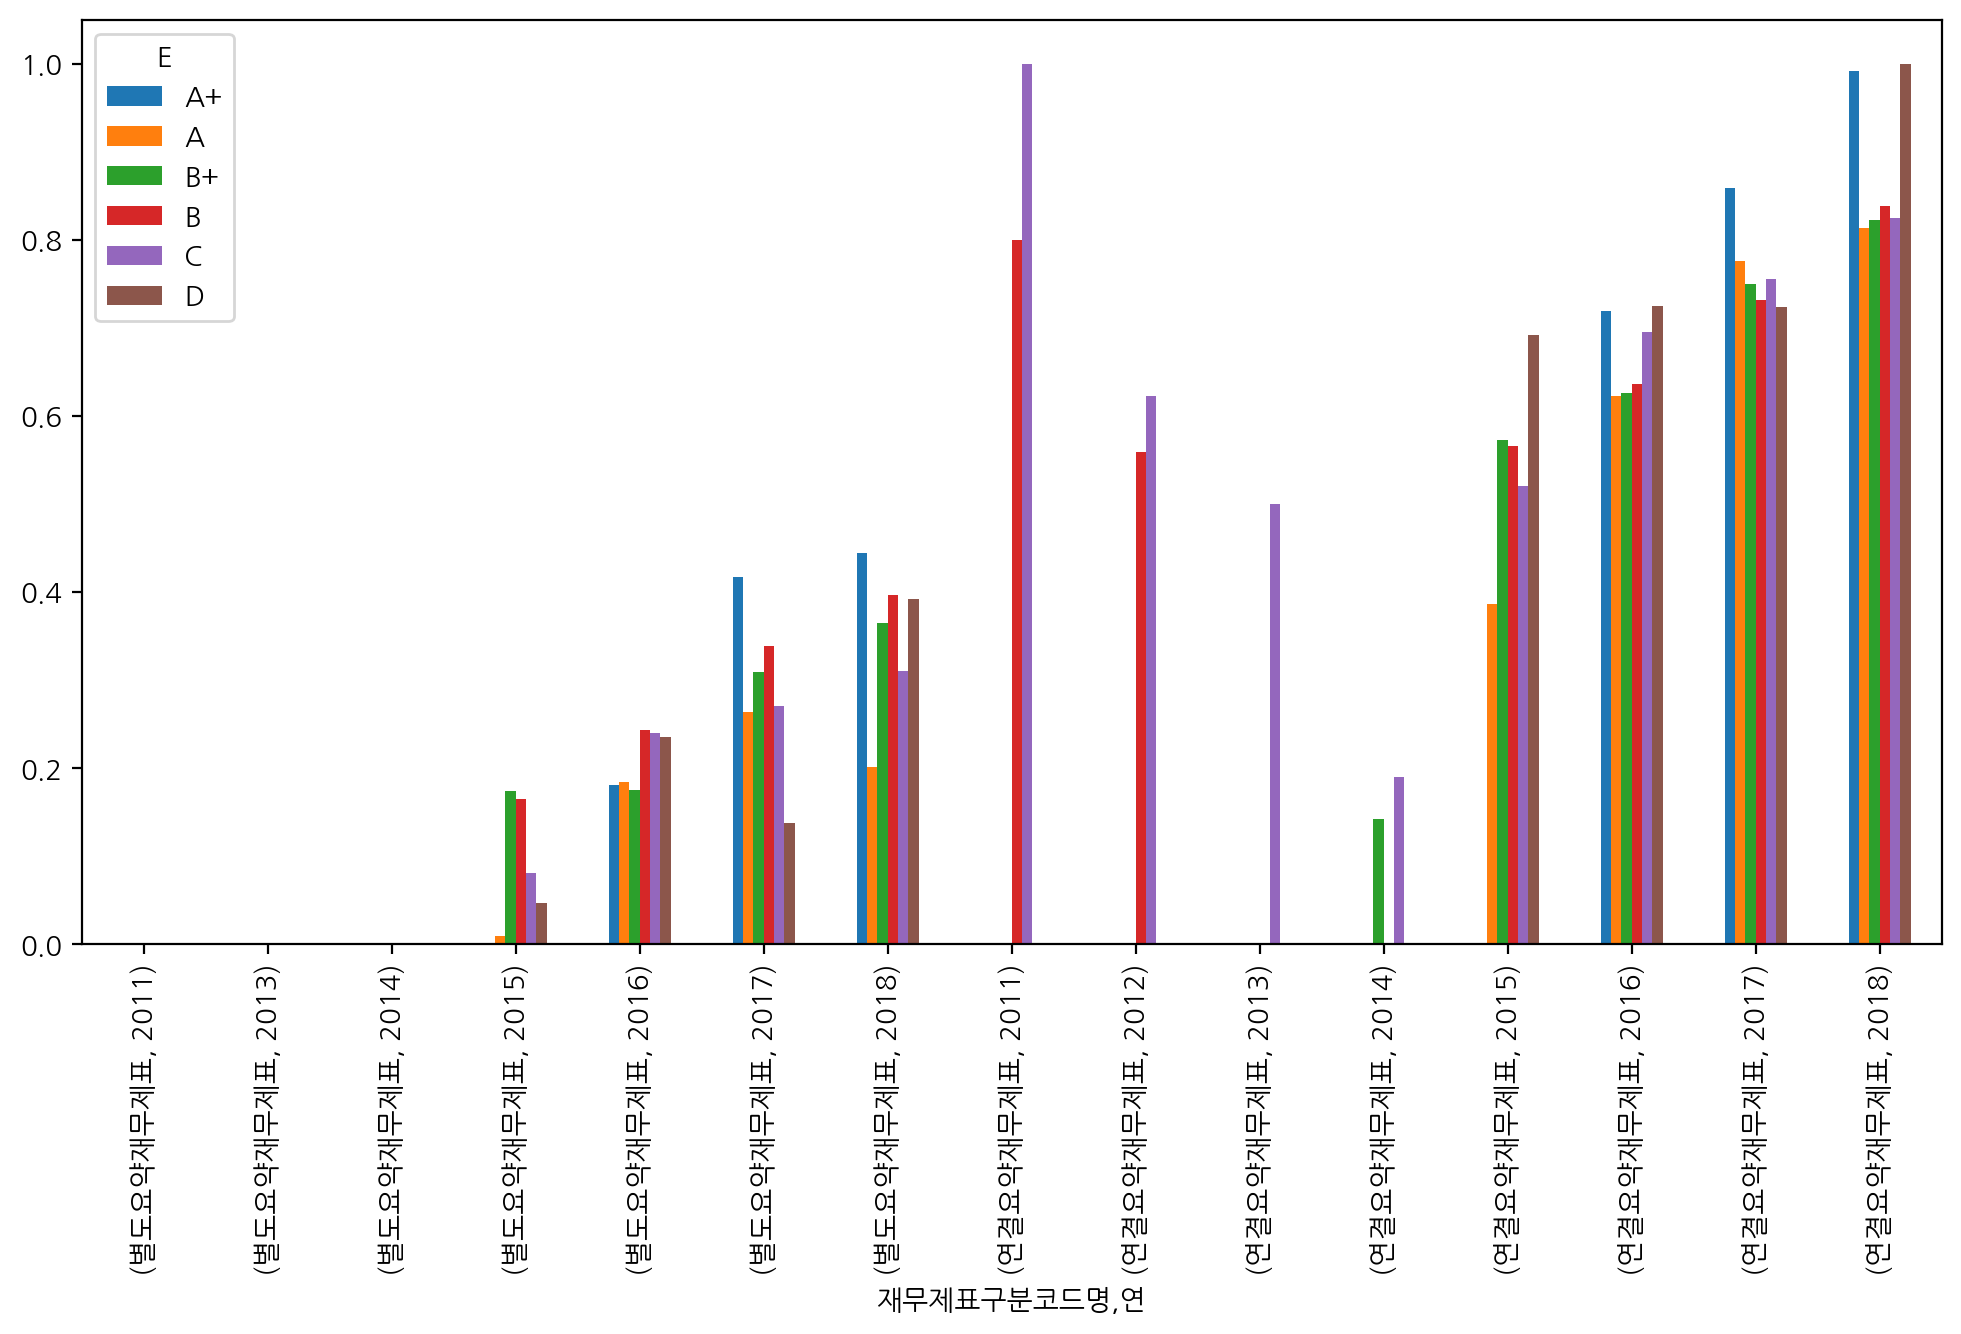

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자산금액_mmscl
S


S                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.0000    NaN
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015 0.0000 0.0783 0.1311 0.1363    NaN
          2016 0.2040 0.2375 0.2584 0.2068    NaN
          2017 0.3324 0.2824 0.3117 0.3022    NaN
          2018 0.3846 0.2974 0.3662 0.3599 0.5008
연결요약재무제표  2011    NaN    NaN 0.3992 1.0000    NaN
          2012    NaN    NaN 0.9380 0.4006    NaN
          2013    NaN    NaN    NaN 0.5000    NaN
          2014    NaN    NaN    NaN 0.1775    NaN
          2015 0.2124 0.6152 0.5150 0.5517    NaN
          2016 0.6847 0.6532 0.5929 0.6842    NaN
          2017 0.7432 0.7991 0.7249 0.7440    NaN
          2018 0.8660 0.9106 0.8361 0.8136 0.8153

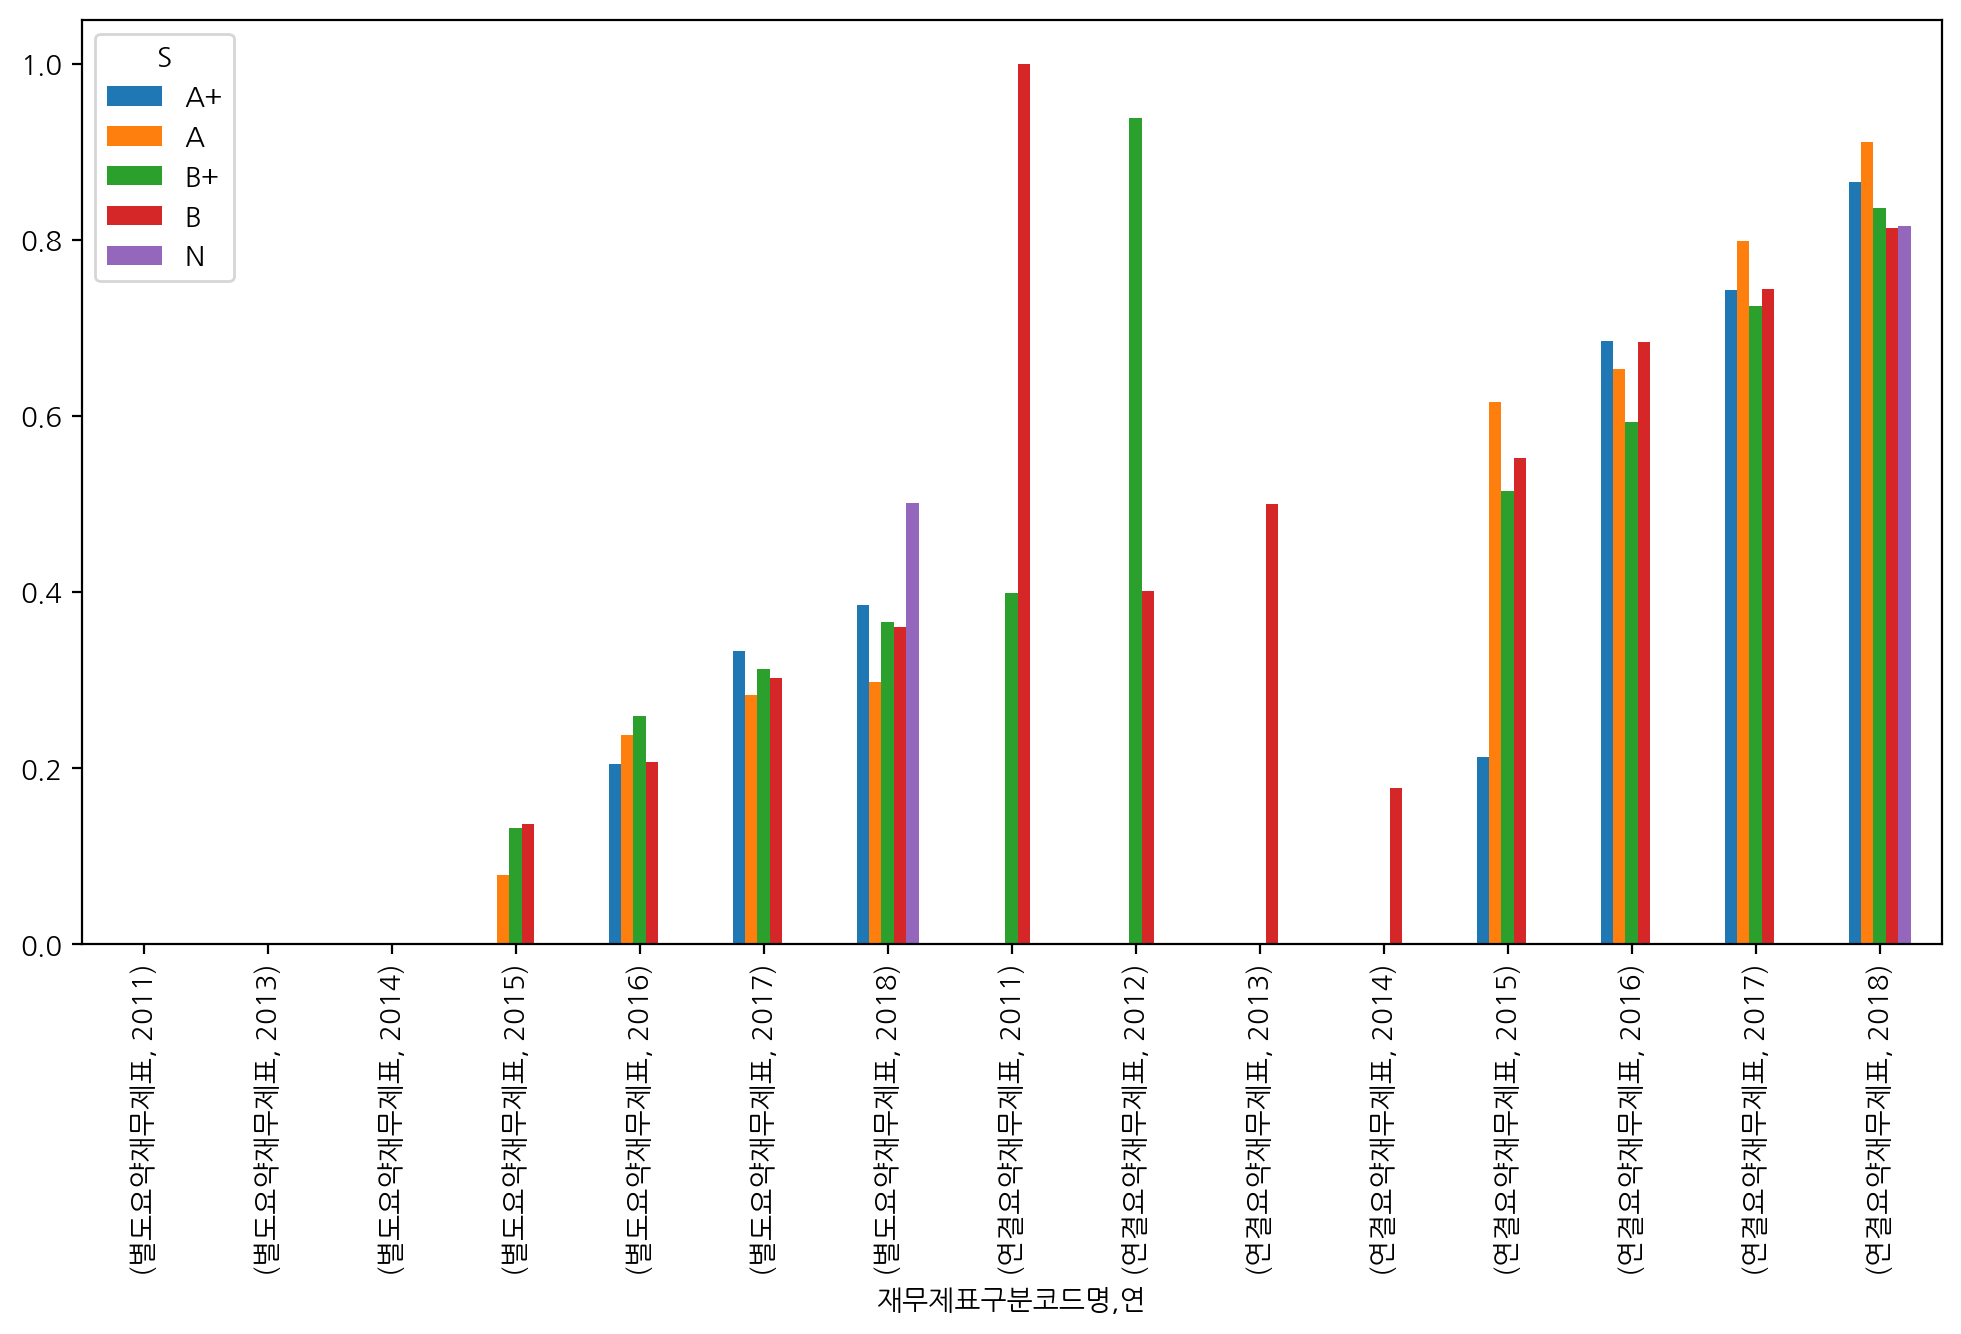

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자산금액_mmscl
G


G                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN    NaN 0.0000
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015 0.0834 0.1146 0.1405 0.1248    NaN
          2016 0.0349 0.2203 0.1976 0.2400    NaN
          2017 0.0000 0.2818 0.3019 0.3176    NaN
          2018 0.4631 0.2946 0.3898 0.3552 0.5008
연결요약재무제표  2011    NaN    NaN 0.3992 1.0000 1.0000
          2012    NaN    NaN 0.9380 0.4006    NaN
          2013    NaN    NaN    NaN 0.5000    NaN
          2014    NaN    NaN 0.0472 0.5684    NaN
          2015 0.3408 0.5887 0.5627 0.5235    NaN
          2016 0.7344 0.6900 0.5749 0.6797    NaN
          2017 0.7627 0.7195 0.7336 0.7593    NaN
          2018 0.7810 0.8184 0.8356 0.8473 0.8153

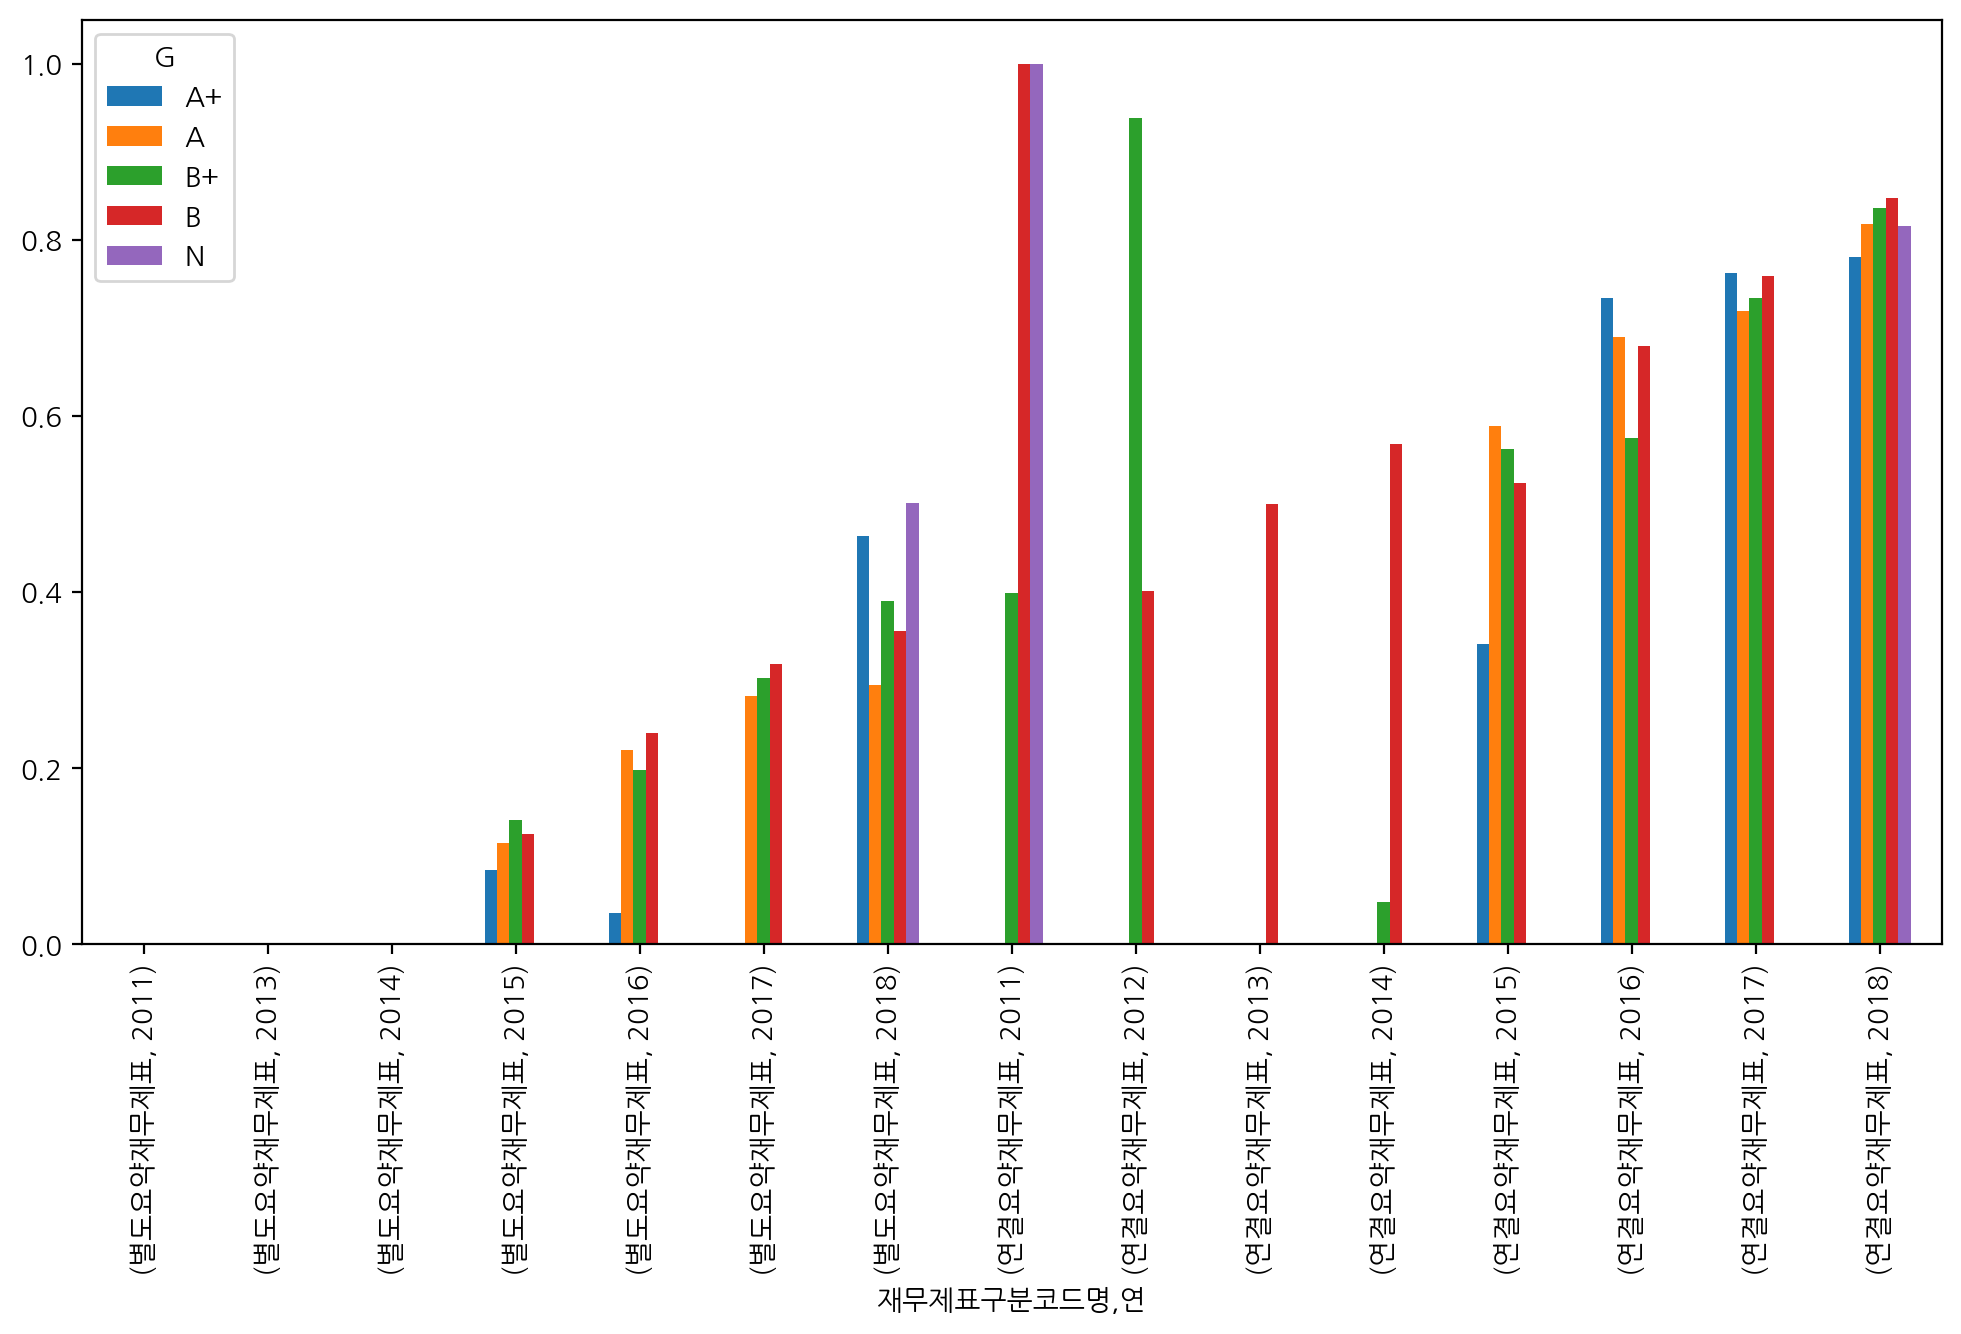

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총부채금액_mmscl
ESG종합


ESG종합              A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.0000    NaN
          2013    NaN    NaN    NaN 0.0983    NaN
          2014    NaN    NaN    NaN 0.0642    NaN
          2015    NaN 0.1148 0.2378 0.2125    NaN
          2016 0.2562 0.2339 0.2574 0.2380    NaN
          2017 0.2495 0.3021 0.2344 0.2045    NaN
          2018 0.3192 0.2226 0.2361 0.2166 0.0919
연결요약재무제표  2011    NaN    NaN 0.3655 1.0000    NaN
          2012    NaN    NaN 0.9780 0.7029    NaN
          2013    NaN    NaN    NaN 0.5568    NaN
          2014    NaN    NaN 0.0038 0.5028    NaN
          2015    NaN 0.6151 0.6795 0.6622    NaN
          2016 0.7650 0.6910 0.7161 0.6948    NaN
          2017 0.8338 0.7410 0.6834 0.7087    NaN
          2018 0.8765 0.7422 0.7234 0.7309 0.5341

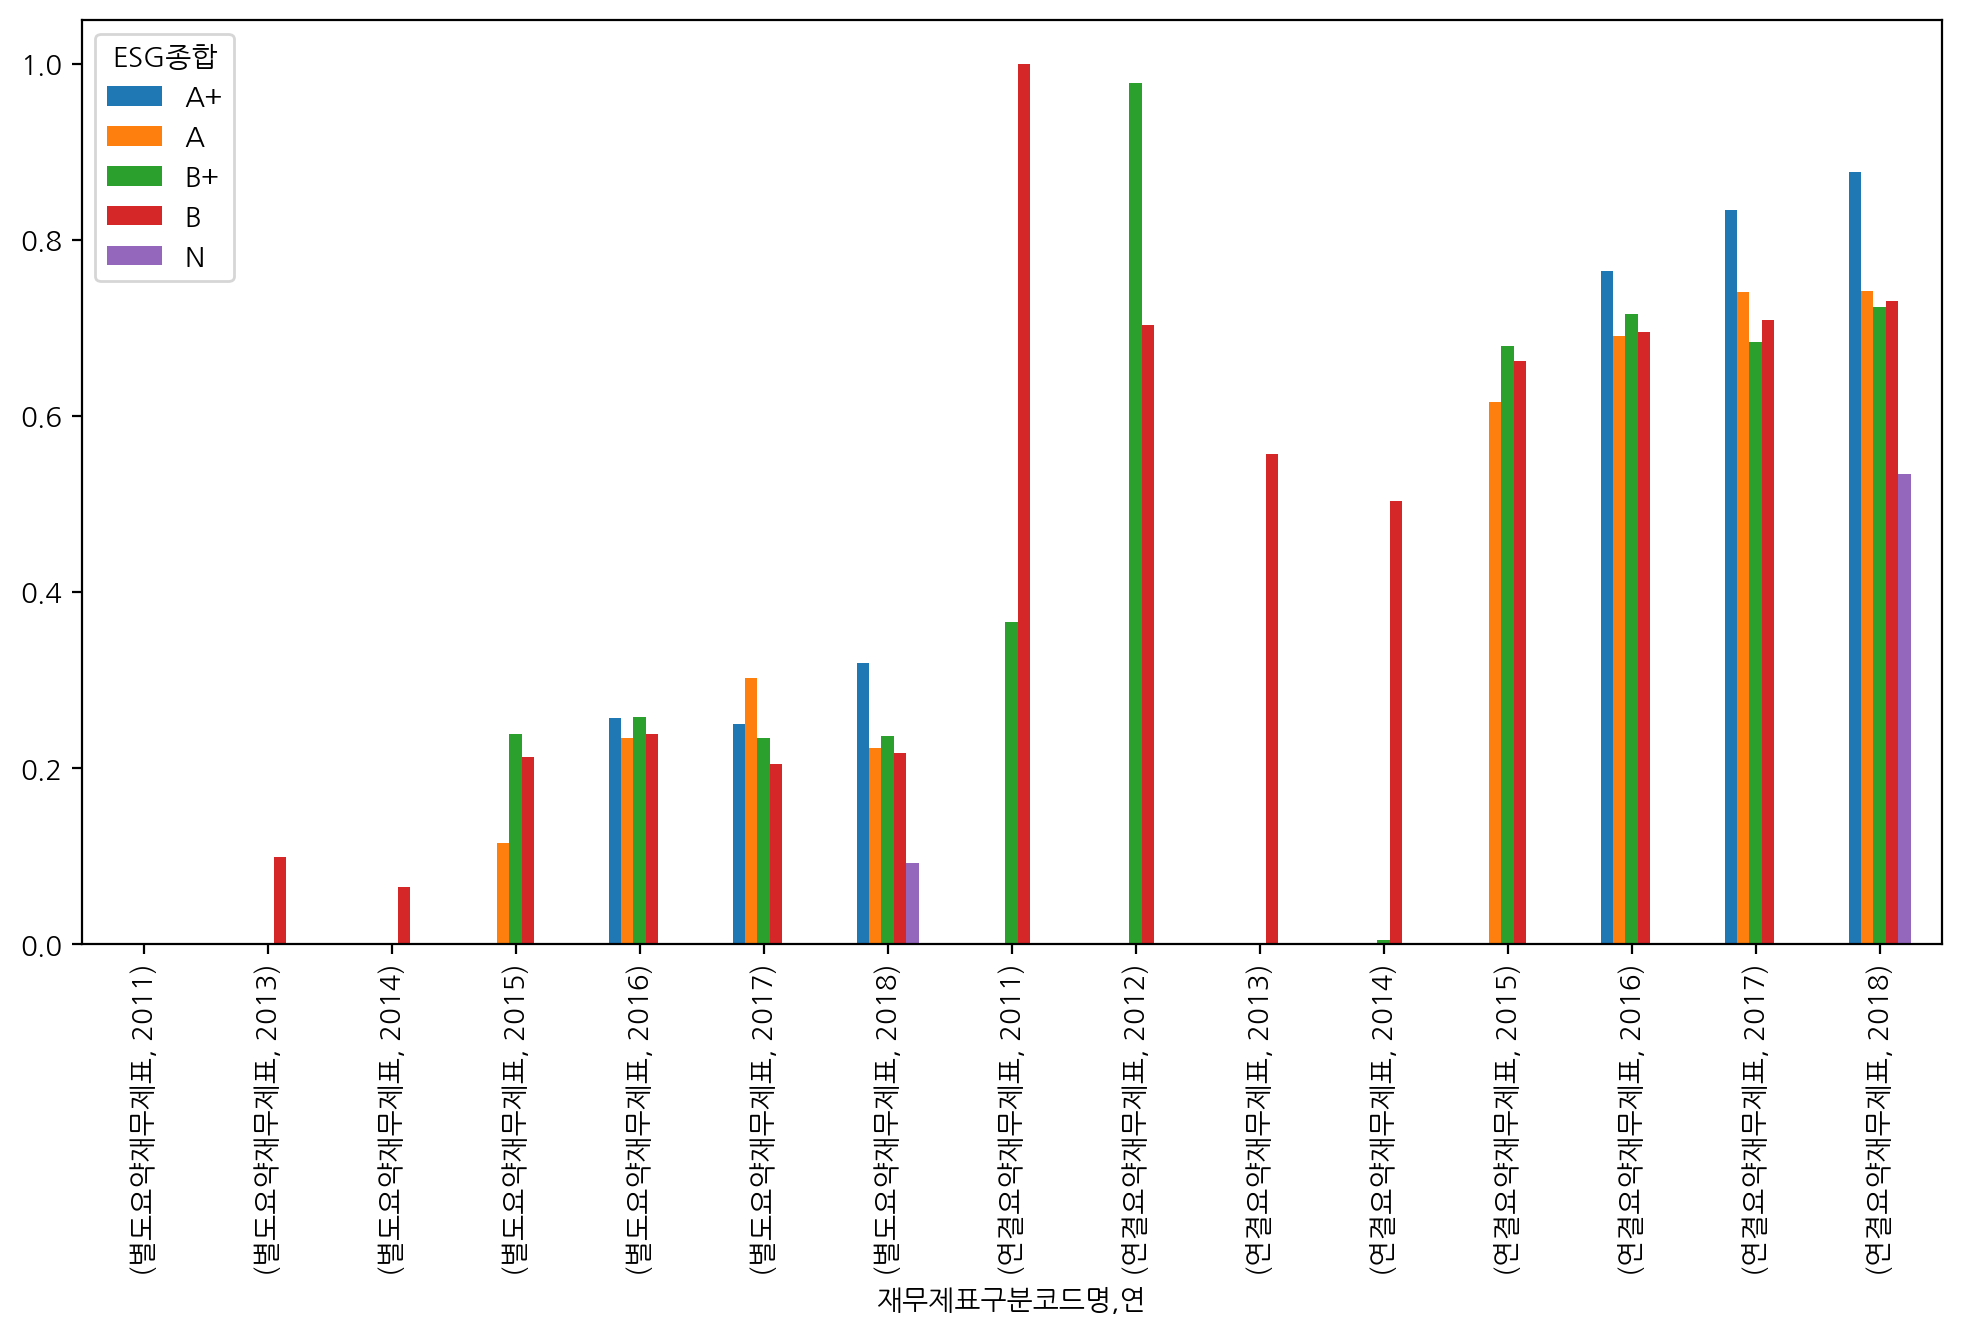

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총부채금액_mmscl
E


E                  A+      A     B+      B      C      D
재무제표구분코드명 연                                             
별도요약재무제표  2011    NaN    NaN    NaN 0.0000    NaN    NaN
          2013    NaN    NaN    NaN 0.0983    NaN    NaN
          2014    NaN    NaN    NaN    NaN 0.0642    NaN
          2015    NaN 0.0595 0.2375 0.2264 0.2025 0.2393
          2016 0.1921 0.1615 0.1900 0.2923 0.2129 0.2742
          2017 0.3483 0.2194 0.2205 0.2598 0.1507 0.0981
          2018 0.4257 0.0726 0.2587 0.2199 0.2043 0.2021
연결요약재무제표  2011    NaN    NaN    NaN 0.7885 1.0000    NaN
          2012    NaN    NaN    NaN 0.7542 0.8755    NaN
          2013    NaN    NaN    NaN    NaN 0.5568    NaN
          2014    NaN    NaN 0.0038    NaN 0.5028    NaN
          2015    NaN 0.4736 0.6932 0.6723 0.6758 0.5957
          2016 0.7834 0.6057 0.6643 0.6882 0.7646 0.6848
          2017 0.8005 0.7064 0.7177 0.7129 0.6825 0.6730
          2018 0.9894 0.7691 0.7252 0.7068 0.7382 0.8003

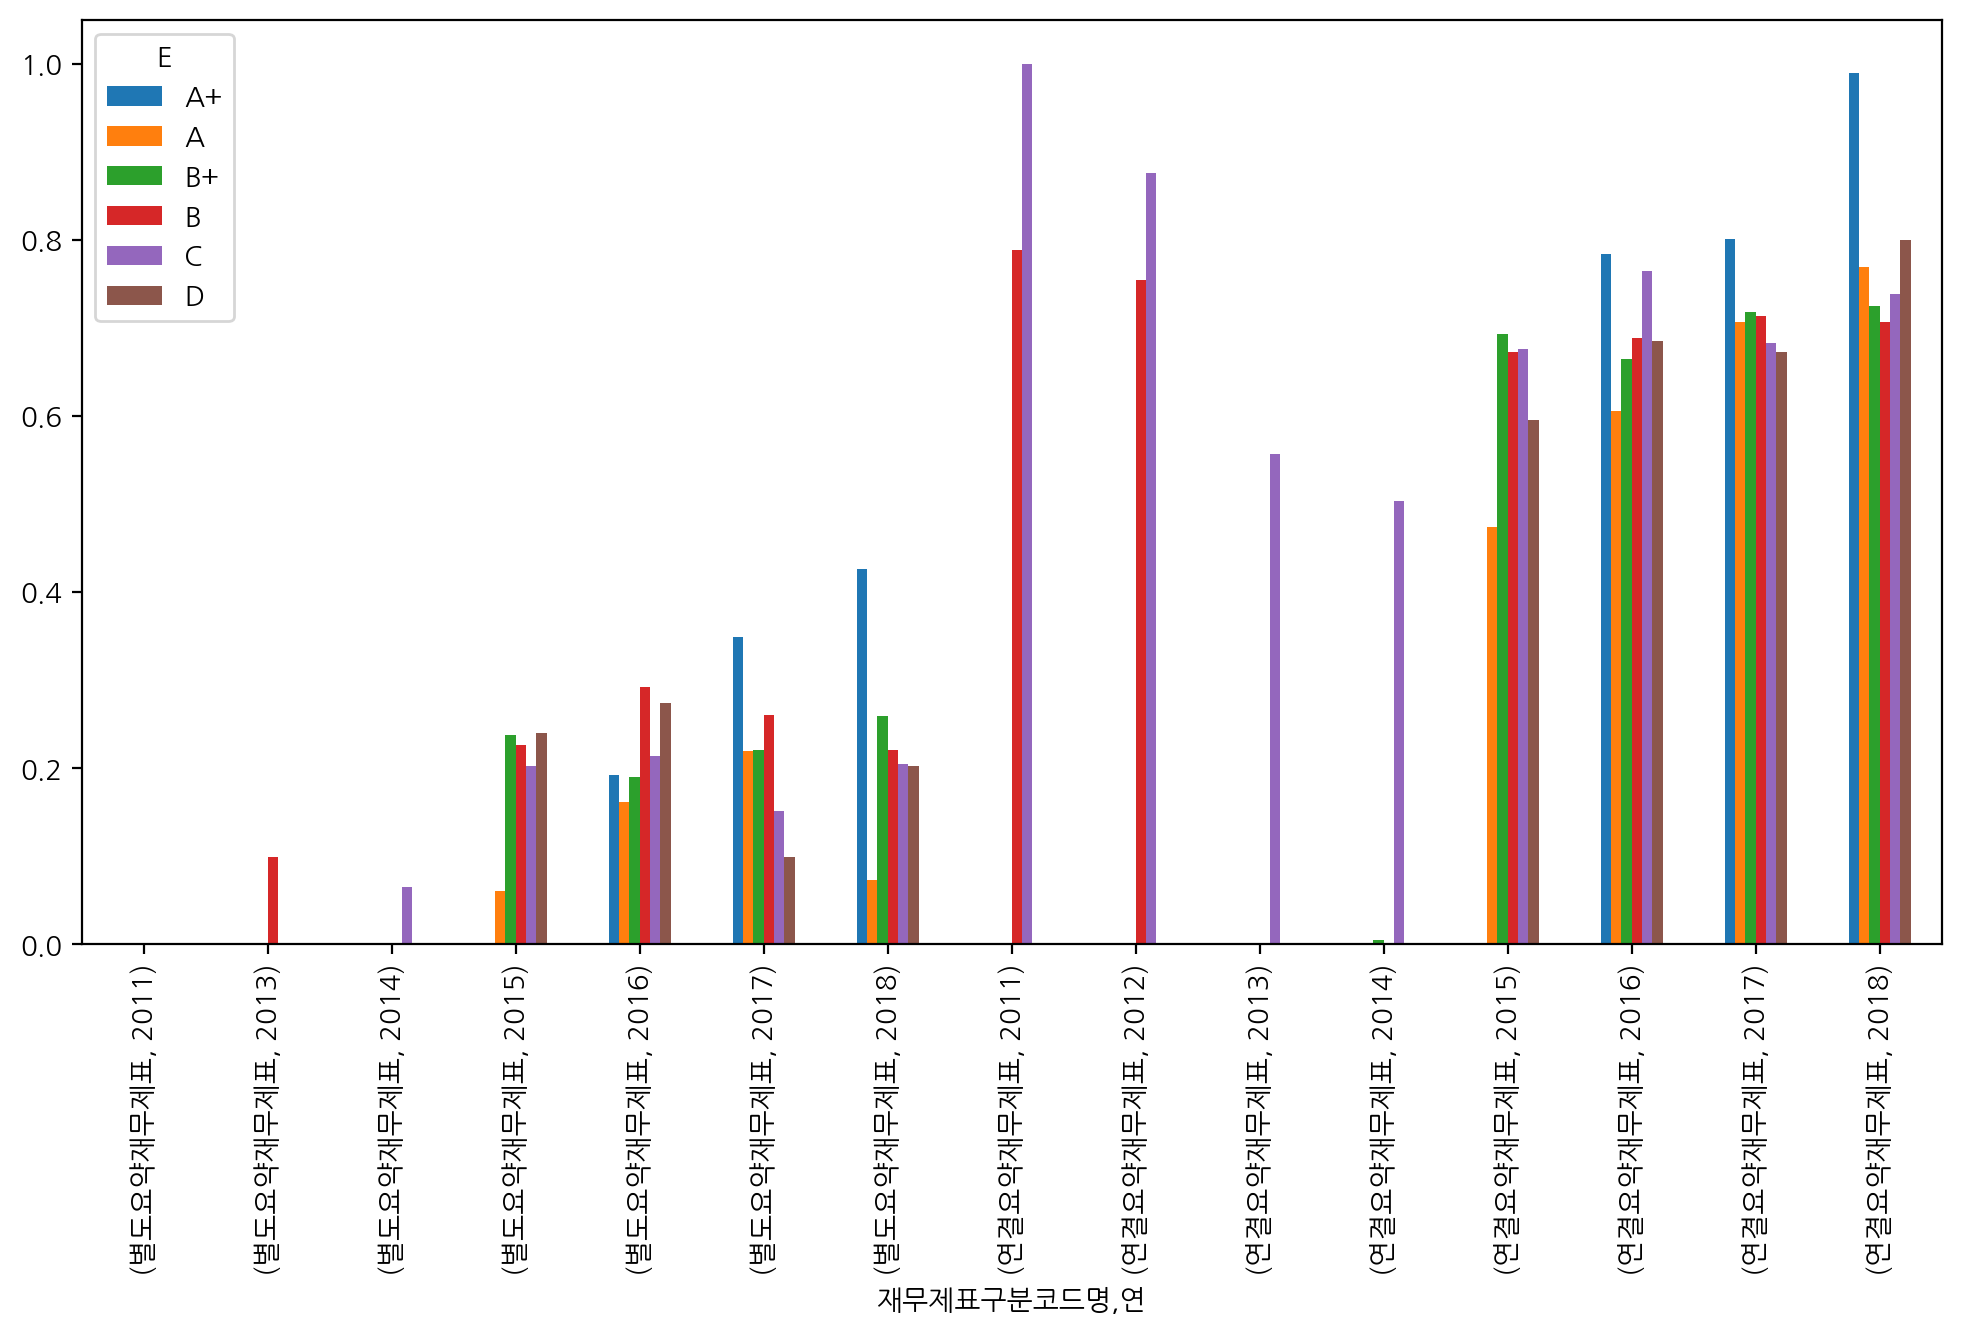

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총부채금액_mmscl
S


S                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.0000    NaN
          2013    NaN    NaN    NaN 0.0983    NaN
          2014    NaN    NaN    NaN 0.0642    NaN
          2015 0.1672 0.1253 0.2298 0.2170    NaN
          2016 0.2307 0.2930 0.3121 0.2001    NaN
          2017 0.3280 0.2062 0.2016 0.2147    NaN
          2018 0.2671 0.2310 0.1799 0.2384 0.0919
연결요약재무제표  2011    NaN    NaN 0.3655 1.0000    NaN
          2012    NaN    NaN 0.9780 0.7029    NaN
          2013    NaN    NaN    NaN 0.5568    NaN
          2014    NaN    NaN    NaN 0.3780    NaN
          2015 0.4010 0.6564 0.6550 0.6735    NaN
          2016 0.7657 0.6971 0.6856 0.7000    NaN
          2017 0.7151 0.7405 0.6957 0.7060    NaN
          2018 0.7682 0.8573 0.6878 0.7236 0.5341

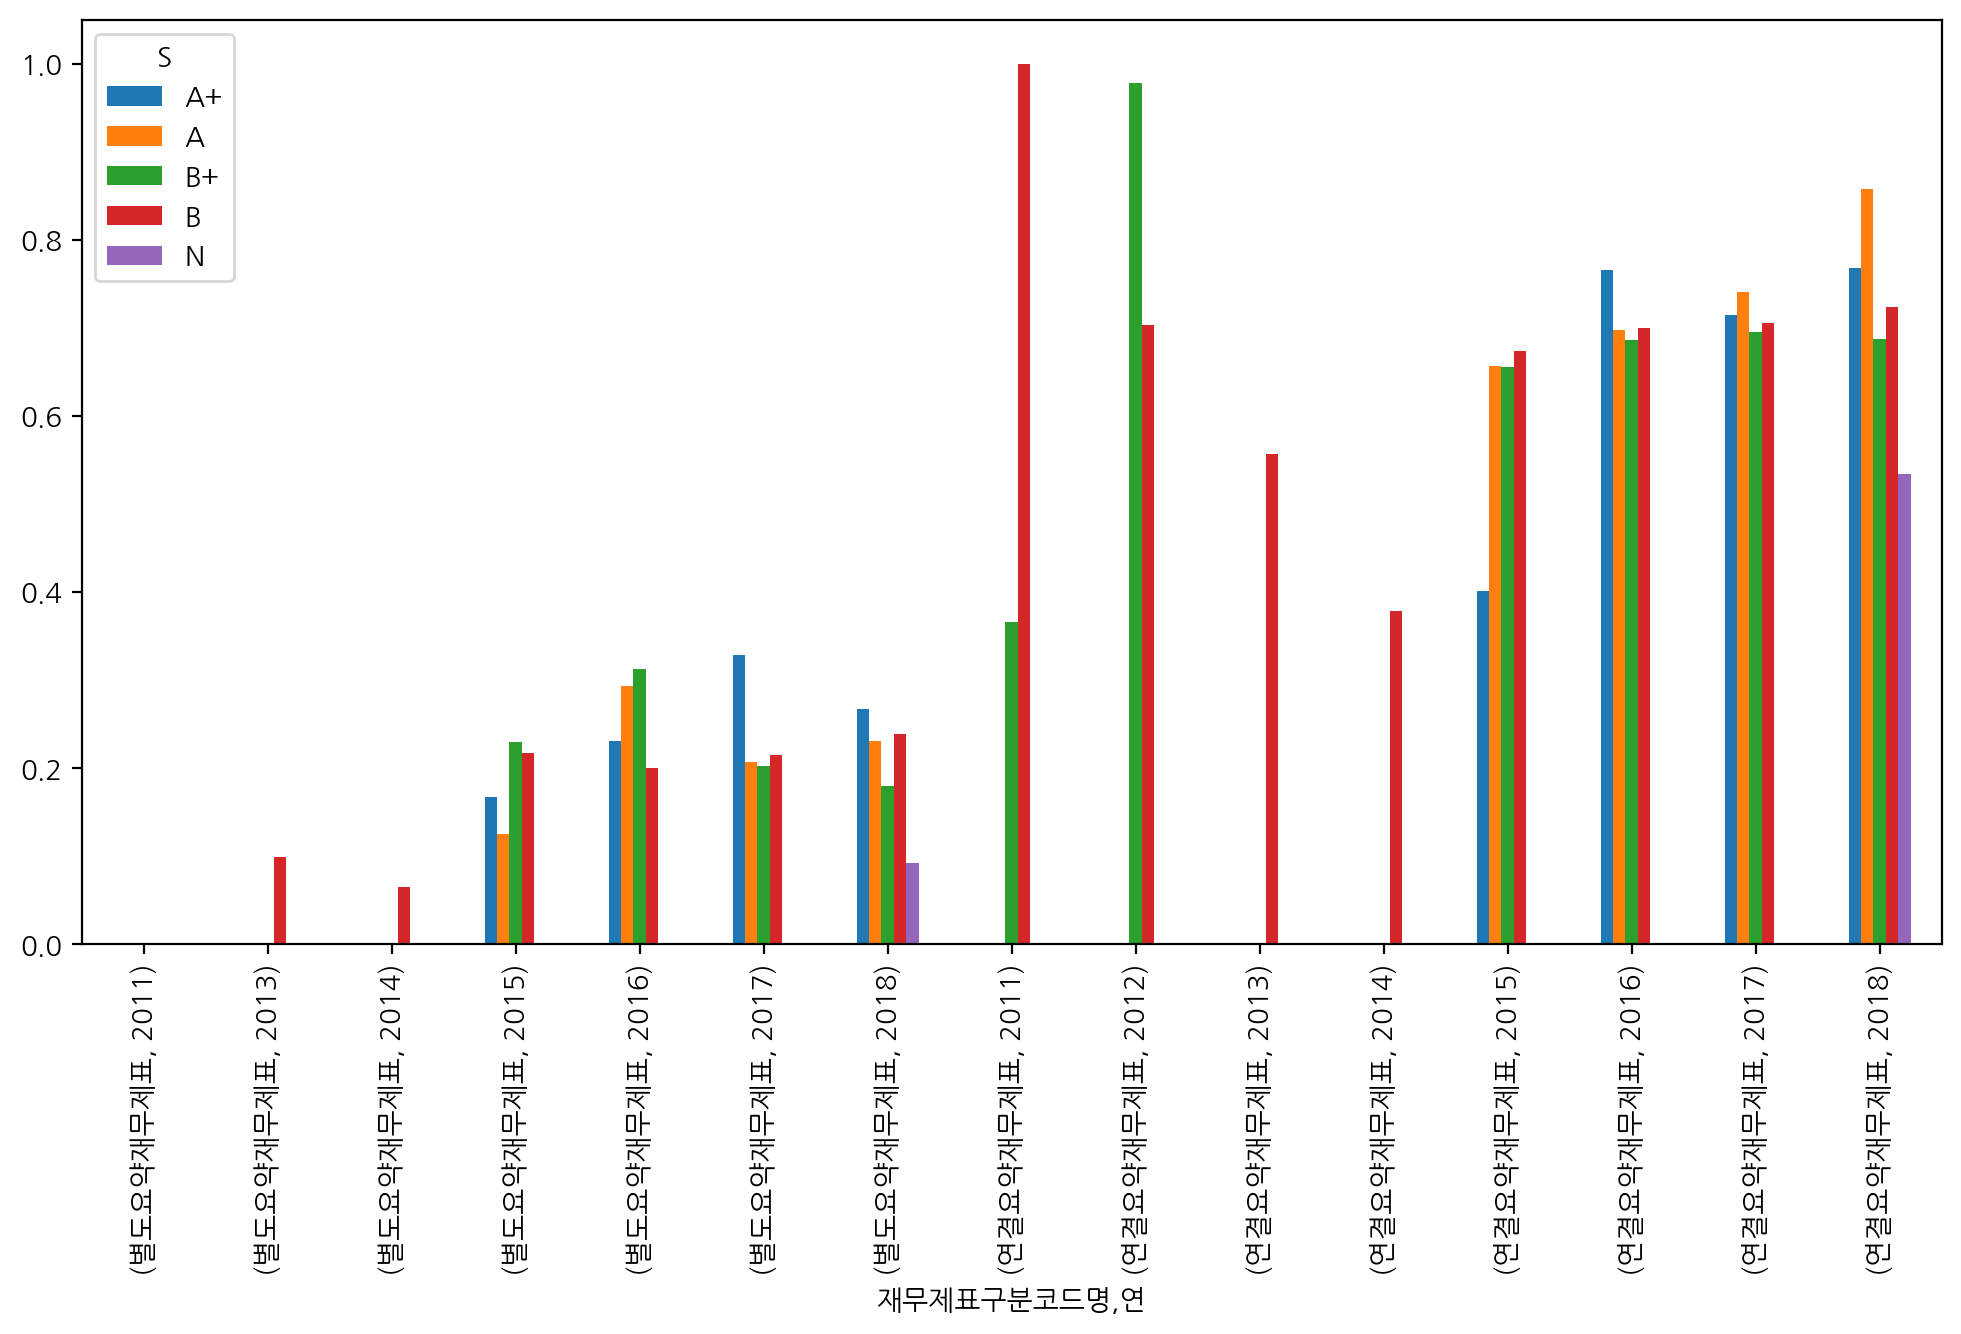

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총부채금액_mmscl
G


G                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN    NaN 0.0000
          2013    NaN    NaN    NaN 0.0983    NaN
          2014    NaN    NaN    NaN 0.0642    NaN
          2015 0.0786 0.2140 0.2599 0.1847    NaN
          2016 0.0000 0.2799 0.2232 0.2419    NaN
          2017 0.0520 0.2415 0.2433 0.2053    NaN
          2018 0.4460 0.1655 0.2810 0.2049 0.0919
연결요약재무제표  2011    NaN    NaN 0.3655 1.0000 1.0000
          2012    NaN    NaN 0.9780 0.7029    NaN
          2013    NaN    NaN    NaN 0.5568    NaN
          2014    NaN    NaN 0.3346 0.5083    NaN
          2015 0.4056 0.6915 0.7127 0.6308    NaN
          2016 0.8584 0.7480 0.6632 0.7005    NaN
          2017 0.9004 0.6737 0.6995 0.7213    NaN
          2018 0.7688 0.6631 0.7603 0.7393 0.5341

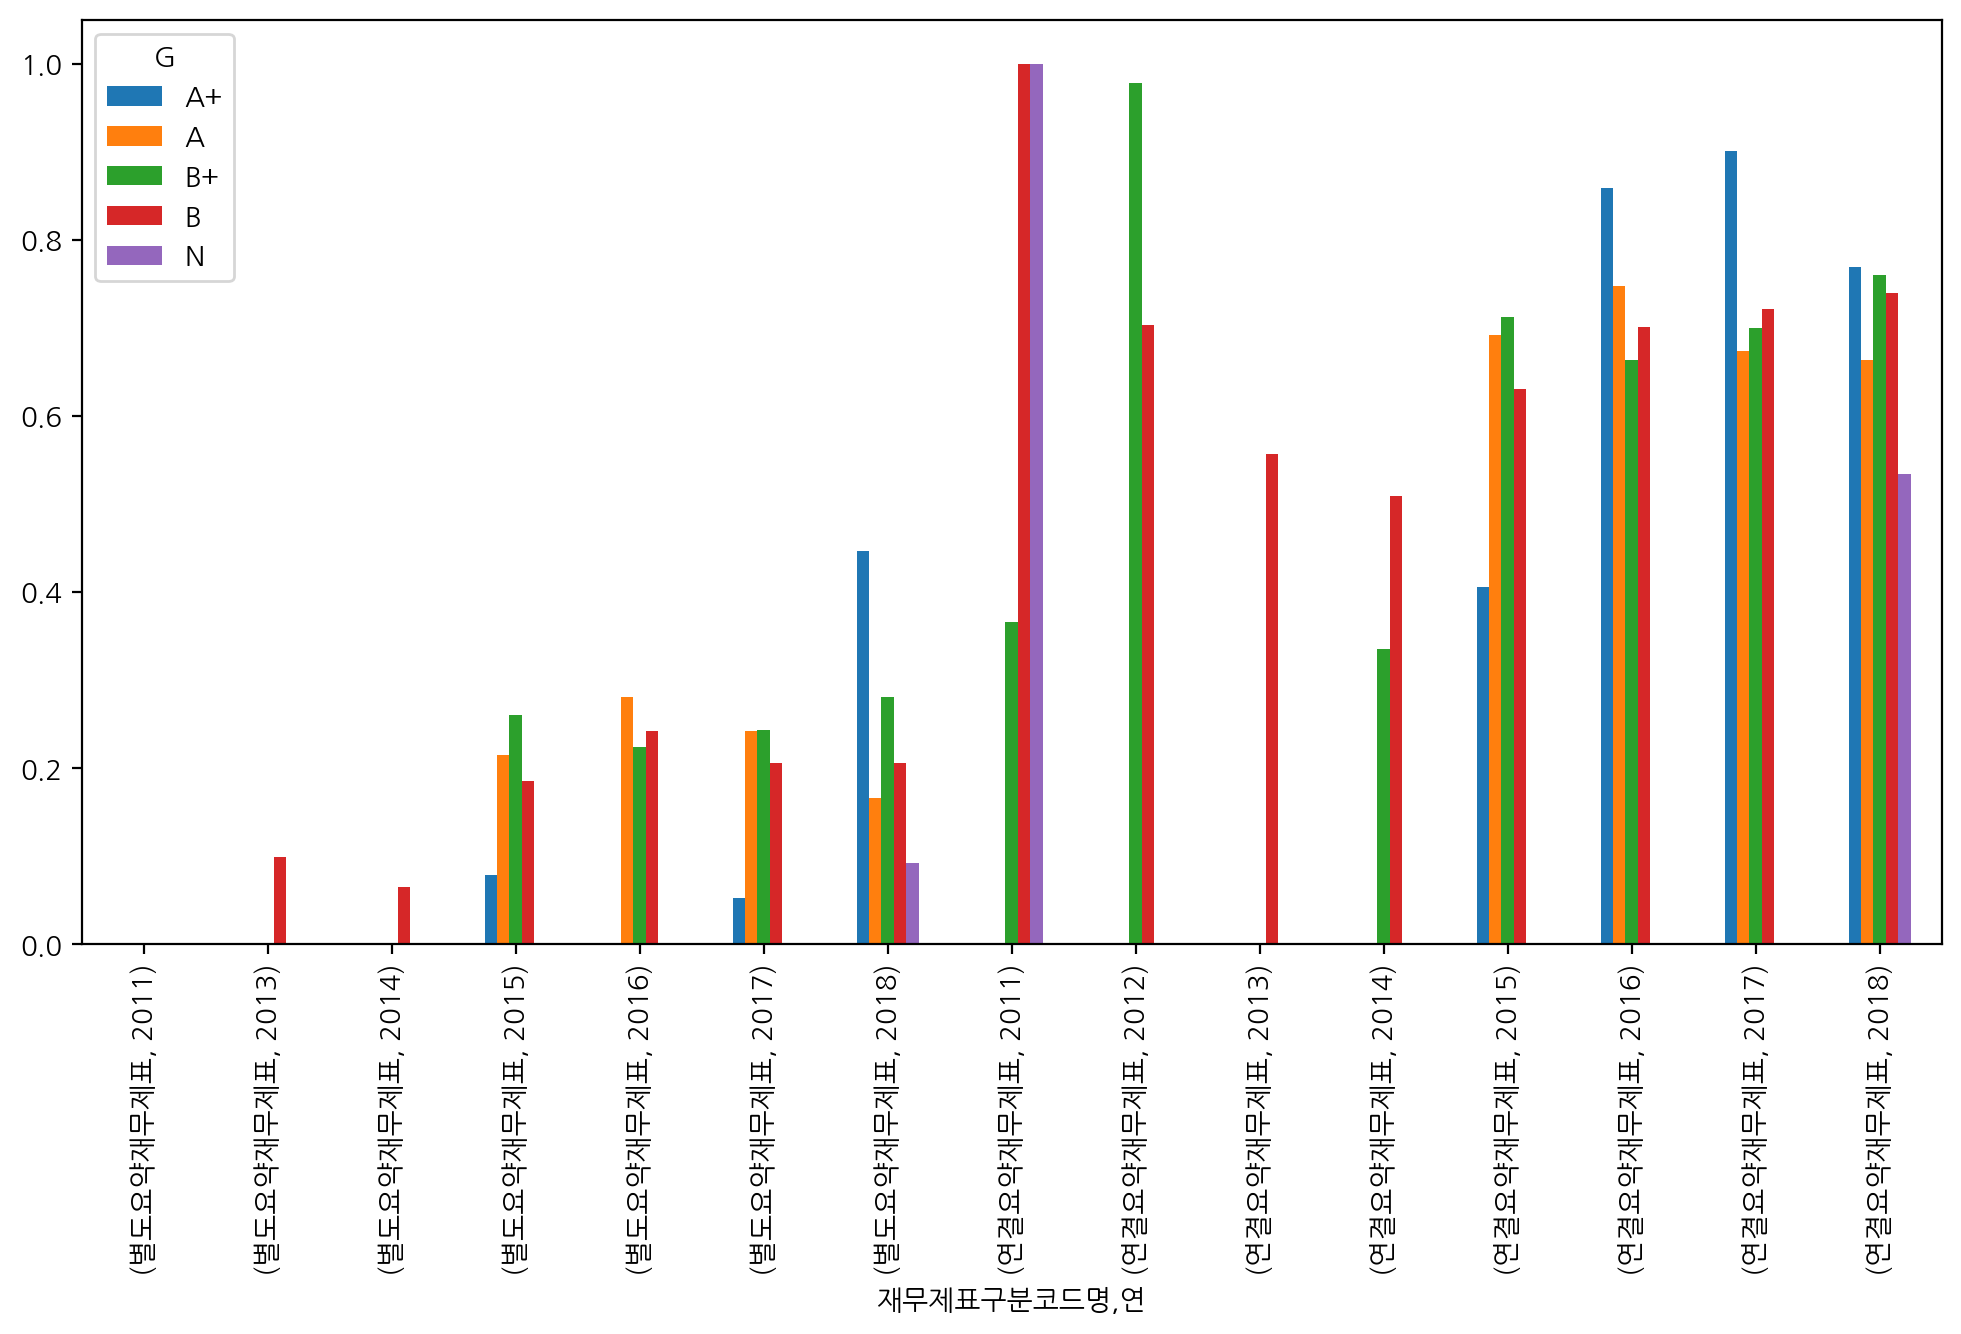

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자본금액_mmscl
ESG종합


ESG종합              A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.0000    NaN
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015    NaN 0.0519 0.1000 0.2271    NaN
          2016 0.3648 0.1781 0.3098 0.3374    NaN
          2017 0.3397 0.4144 0.4364 0.4439    NaN
          2018 0.3596 0.4348 0.5338 0.5079 0.6663
연결요약재무제표  2011    NaN    NaN 0.5146 0.6874    NaN
          2012    NaN    NaN 0.0000 0.0000    NaN
          2013    NaN    NaN    NaN 0.2269    NaN
          2014    NaN    NaN 0.3313 0.1828    NaN
          2015    NaN 0.3857 0.3559 0.4385    NaN
          2016 0.5757 0.5560 0.5333 0.6187    NaN
          2017 0.7857 0.6864 0.6722 0.7254    NaN
          2018 0.8625 0.8140 0.8814 0.8406 0.9435

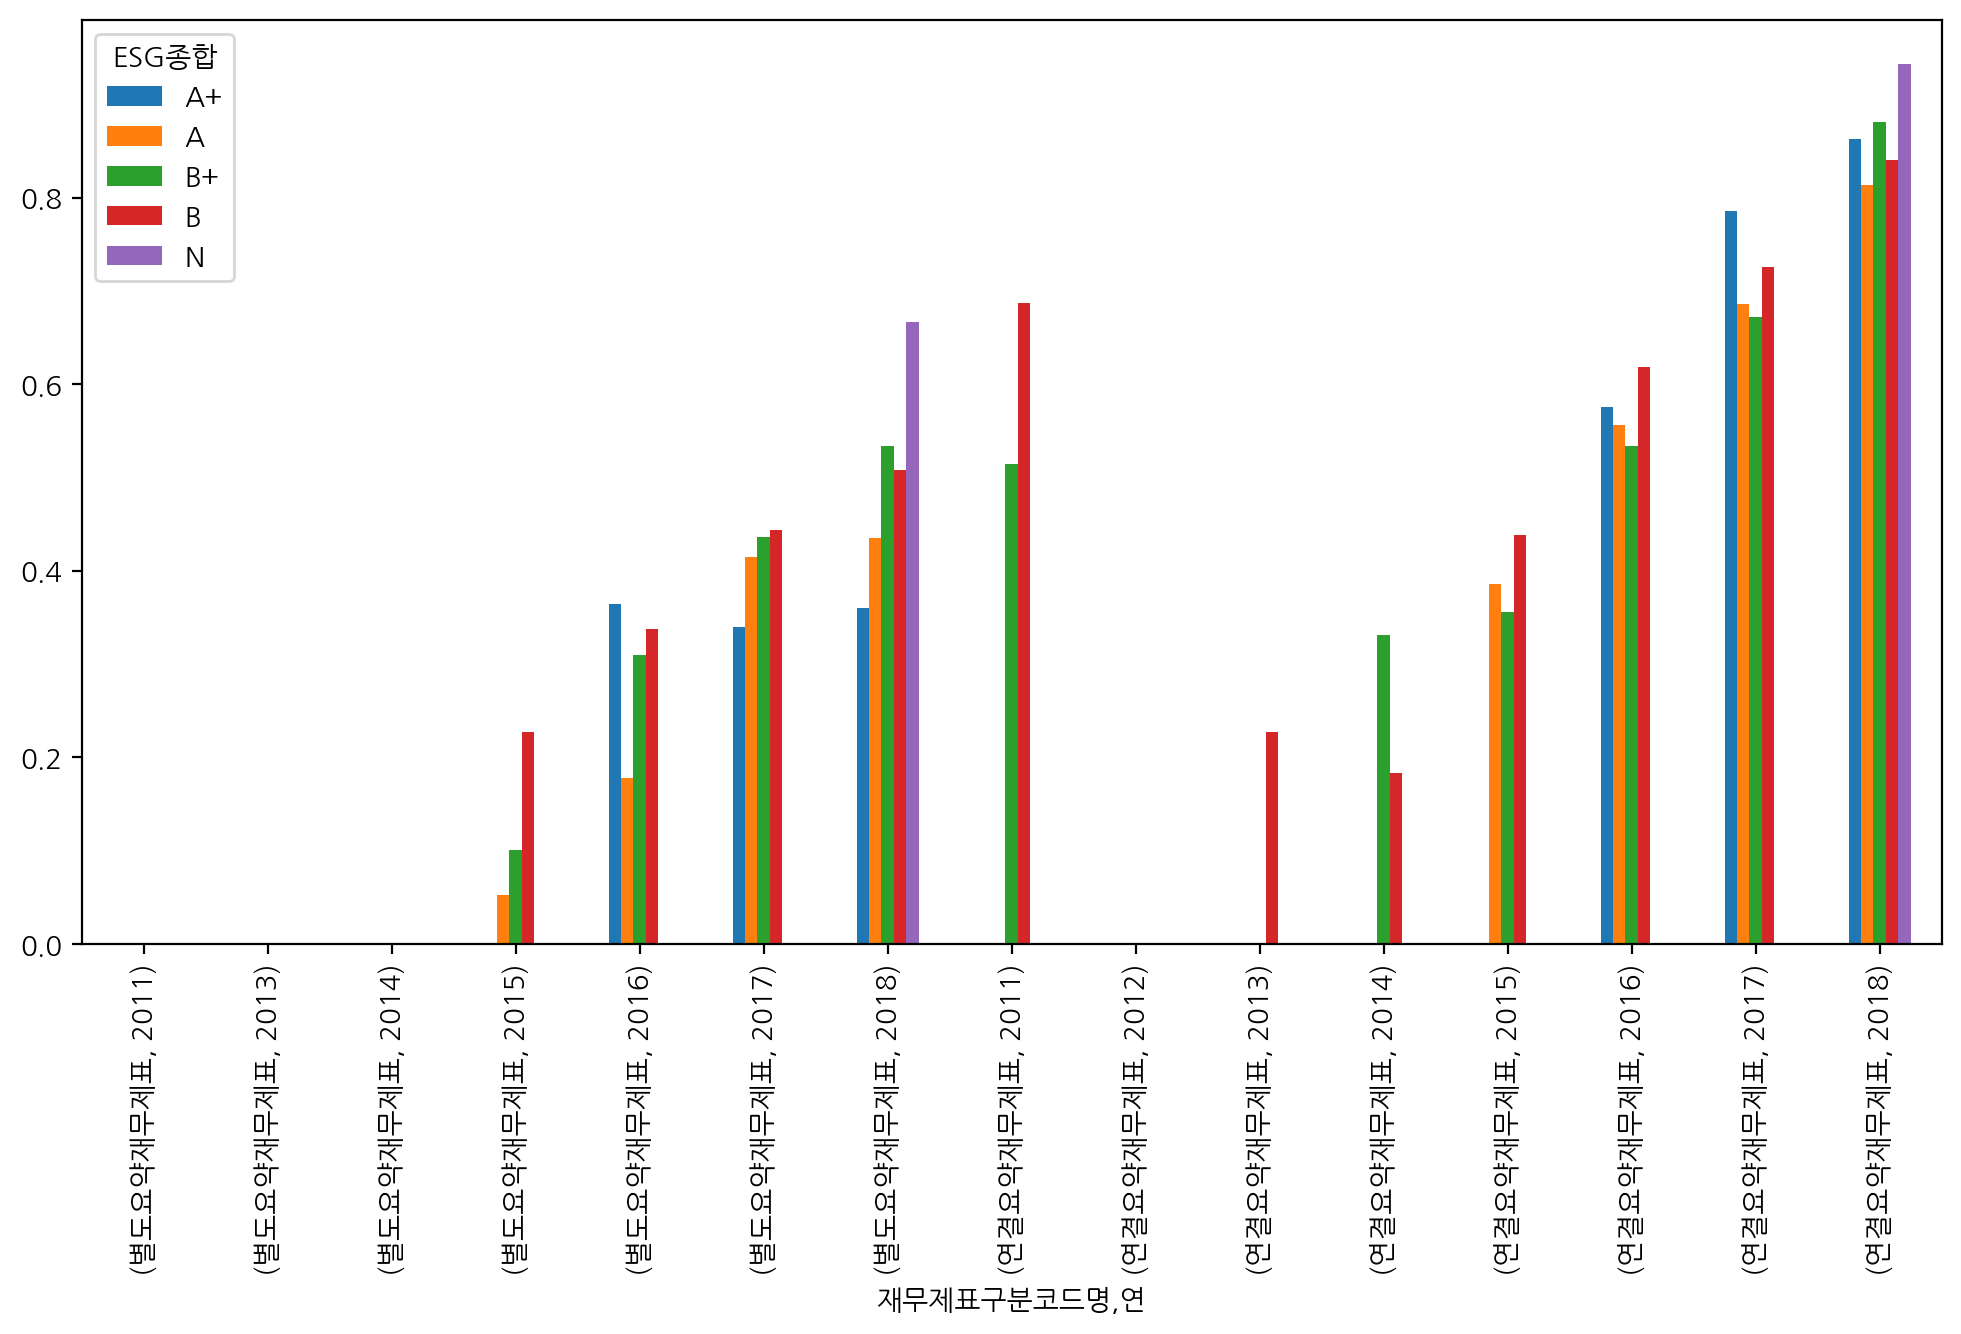

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자본금액_mmscl
E


E                  A+      A     B+      B      C      D
재무제표구분코드명 연                                             
별도요약재무제표  2011    NaN    NaN    NaN 0.0000    NaN    NaN
          2013    NaN    NaN    NaN 0.0000    NaN    NaN
          2014    NaN    NaN    NaN    NaN 0.0000    NaN
          2015    NaN 0.1197 0.1739 0.2027 0.1937 0.1022
          2016 0.2736 0.1759 0.3117 0.3178 0.3629 0.2967
          2017 0.5096 0.3261 0.4515 0.4389 0.4709 0.3592
          2018 0.3816 0.3826 0.4584 0.5985 0.3925 0.6213
연결요약재무제표  2011    NaN    NaN    NaN 0.5256 1.0000    NaN
          2012    NaN    NaN    NaN 0.0000 0.0000    NaN
          2013    NaN    NaN    NaN    NaN 0.2269    NaN
          2014    NaN    NaN 0.3313    NaN 0.1828    NaN
          2015    NaN 0.4228 0.4107 0.4293 0.3879 0.5785
          2016 0.6459 0.5535 0.5854 0.5769 0.6004 0.7018
          2017 0.9348 0.7263 0.6835 0.6832 0.8031 0.7093
          2018 0.9147 0.8381 0.8119 0.8838 0.8070 0.9998

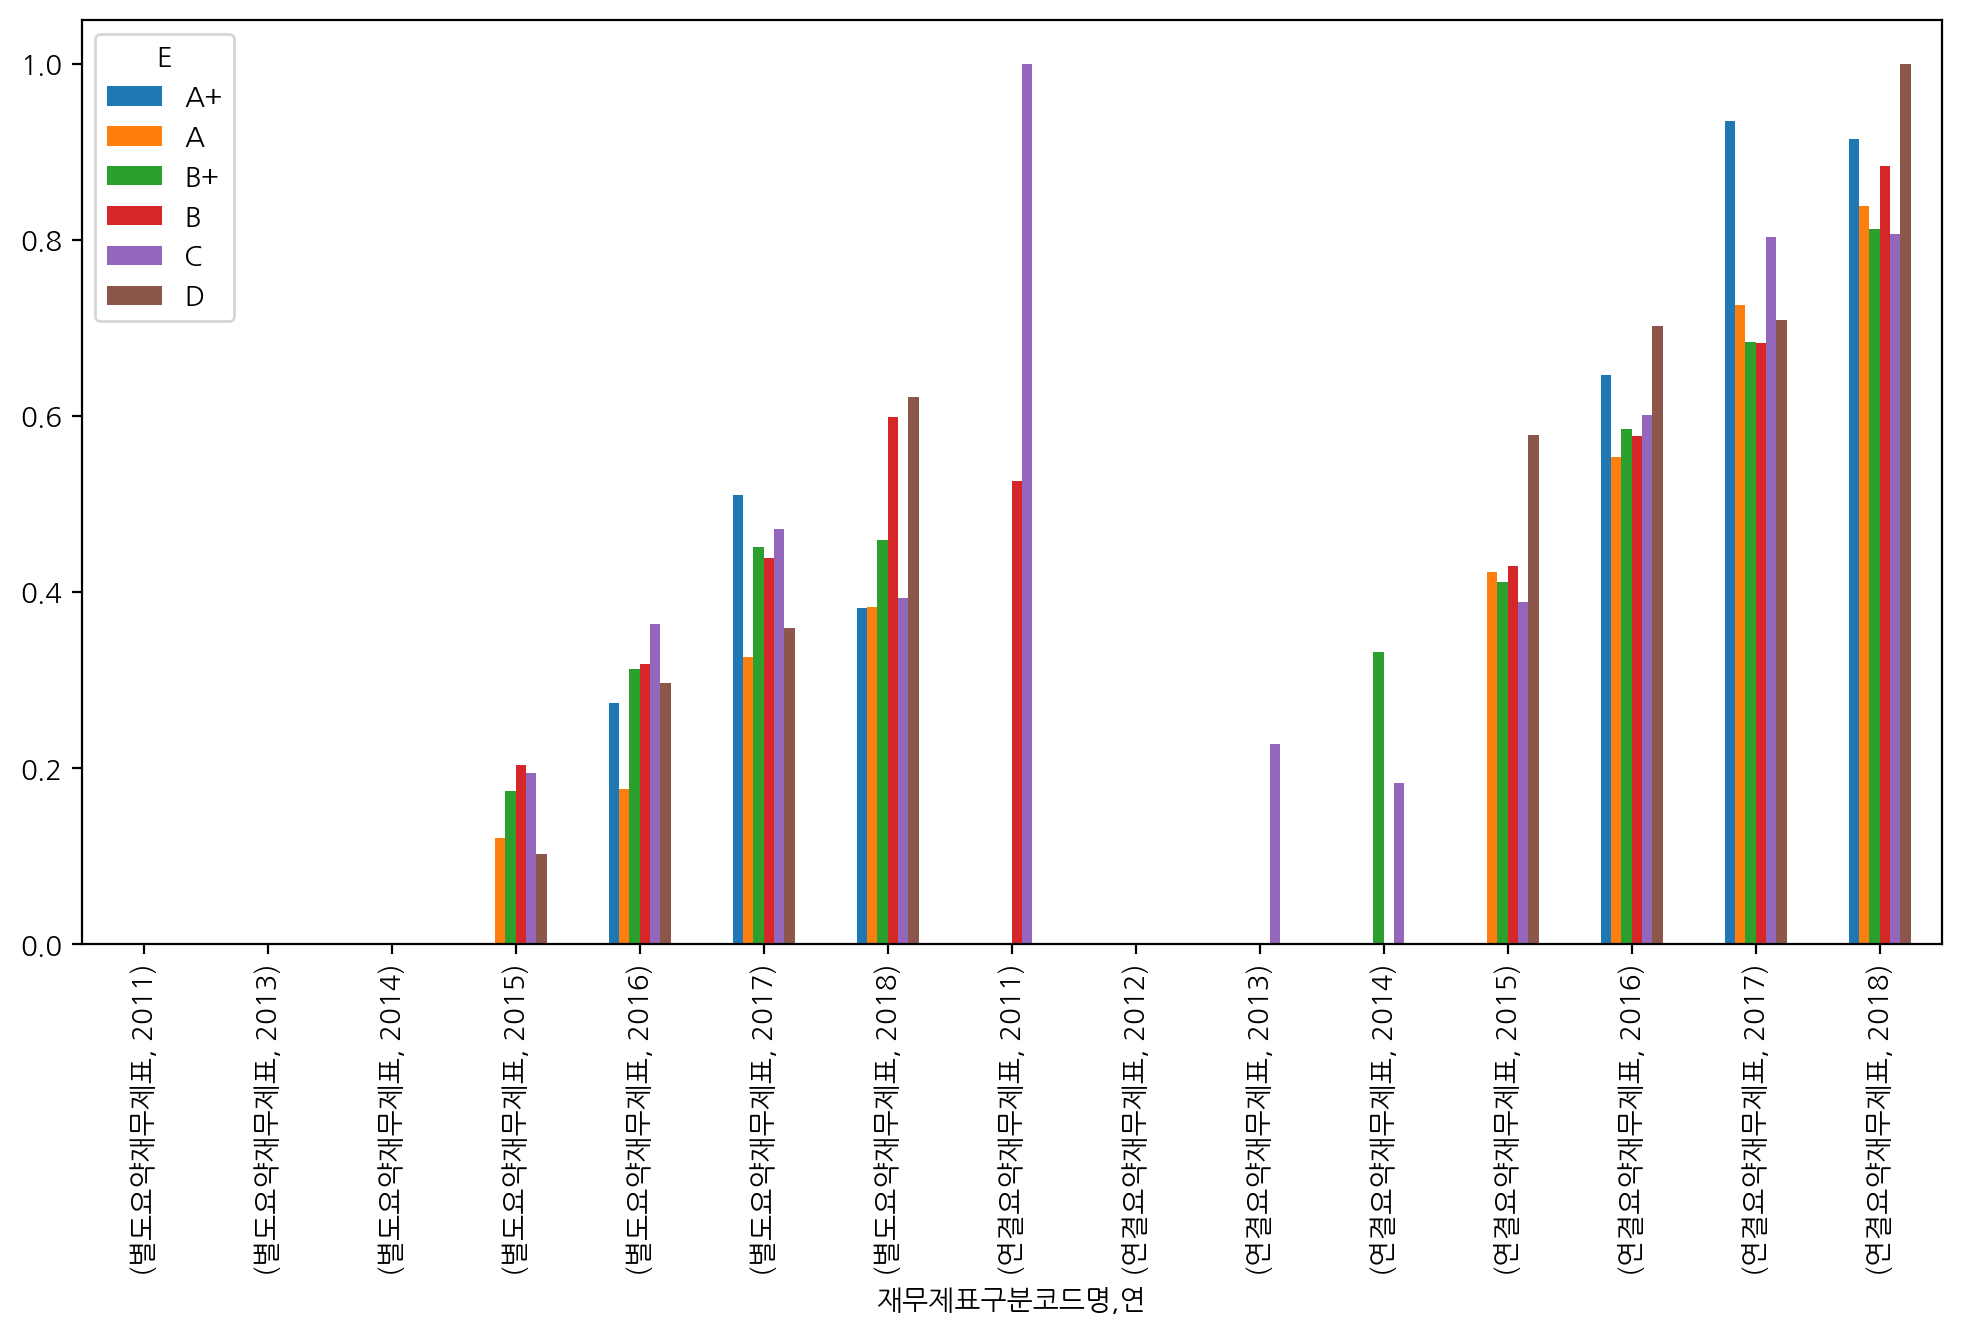

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자본금액_mmscl
S


S                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.0000    NaN
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015 0.0000 0.1209 0.1461 0.2147    NaN
          2016 0.3252 0.3134 0.2888 0.3366    NaN
          2017 0.4049 0.3510 0.4609 0.4483    NaN
          2018 0.4693 0.4466 0.4978 0.5266 0.6663
연결요약재무제표  2011    NaN    NaN 0.5146 0.6874    NaN
          2012    NaN    NaN 0.0000 0.0000    NaN
          2013    NaN    NaN    NaN 0.2269    NaN
          2014    NaN    NaN    NaN 0.2199    NaN
          2015 0.1087 0.4956 0.3872 0.4220    NaN
          2016 0.6227 0.6304 0.5039 0.6293    NaN
          2017 0.6751 0.7464 0.7101 0.7092    NaN
          2018 0.8303 0.8914 0.8726 0.8251 0.9435

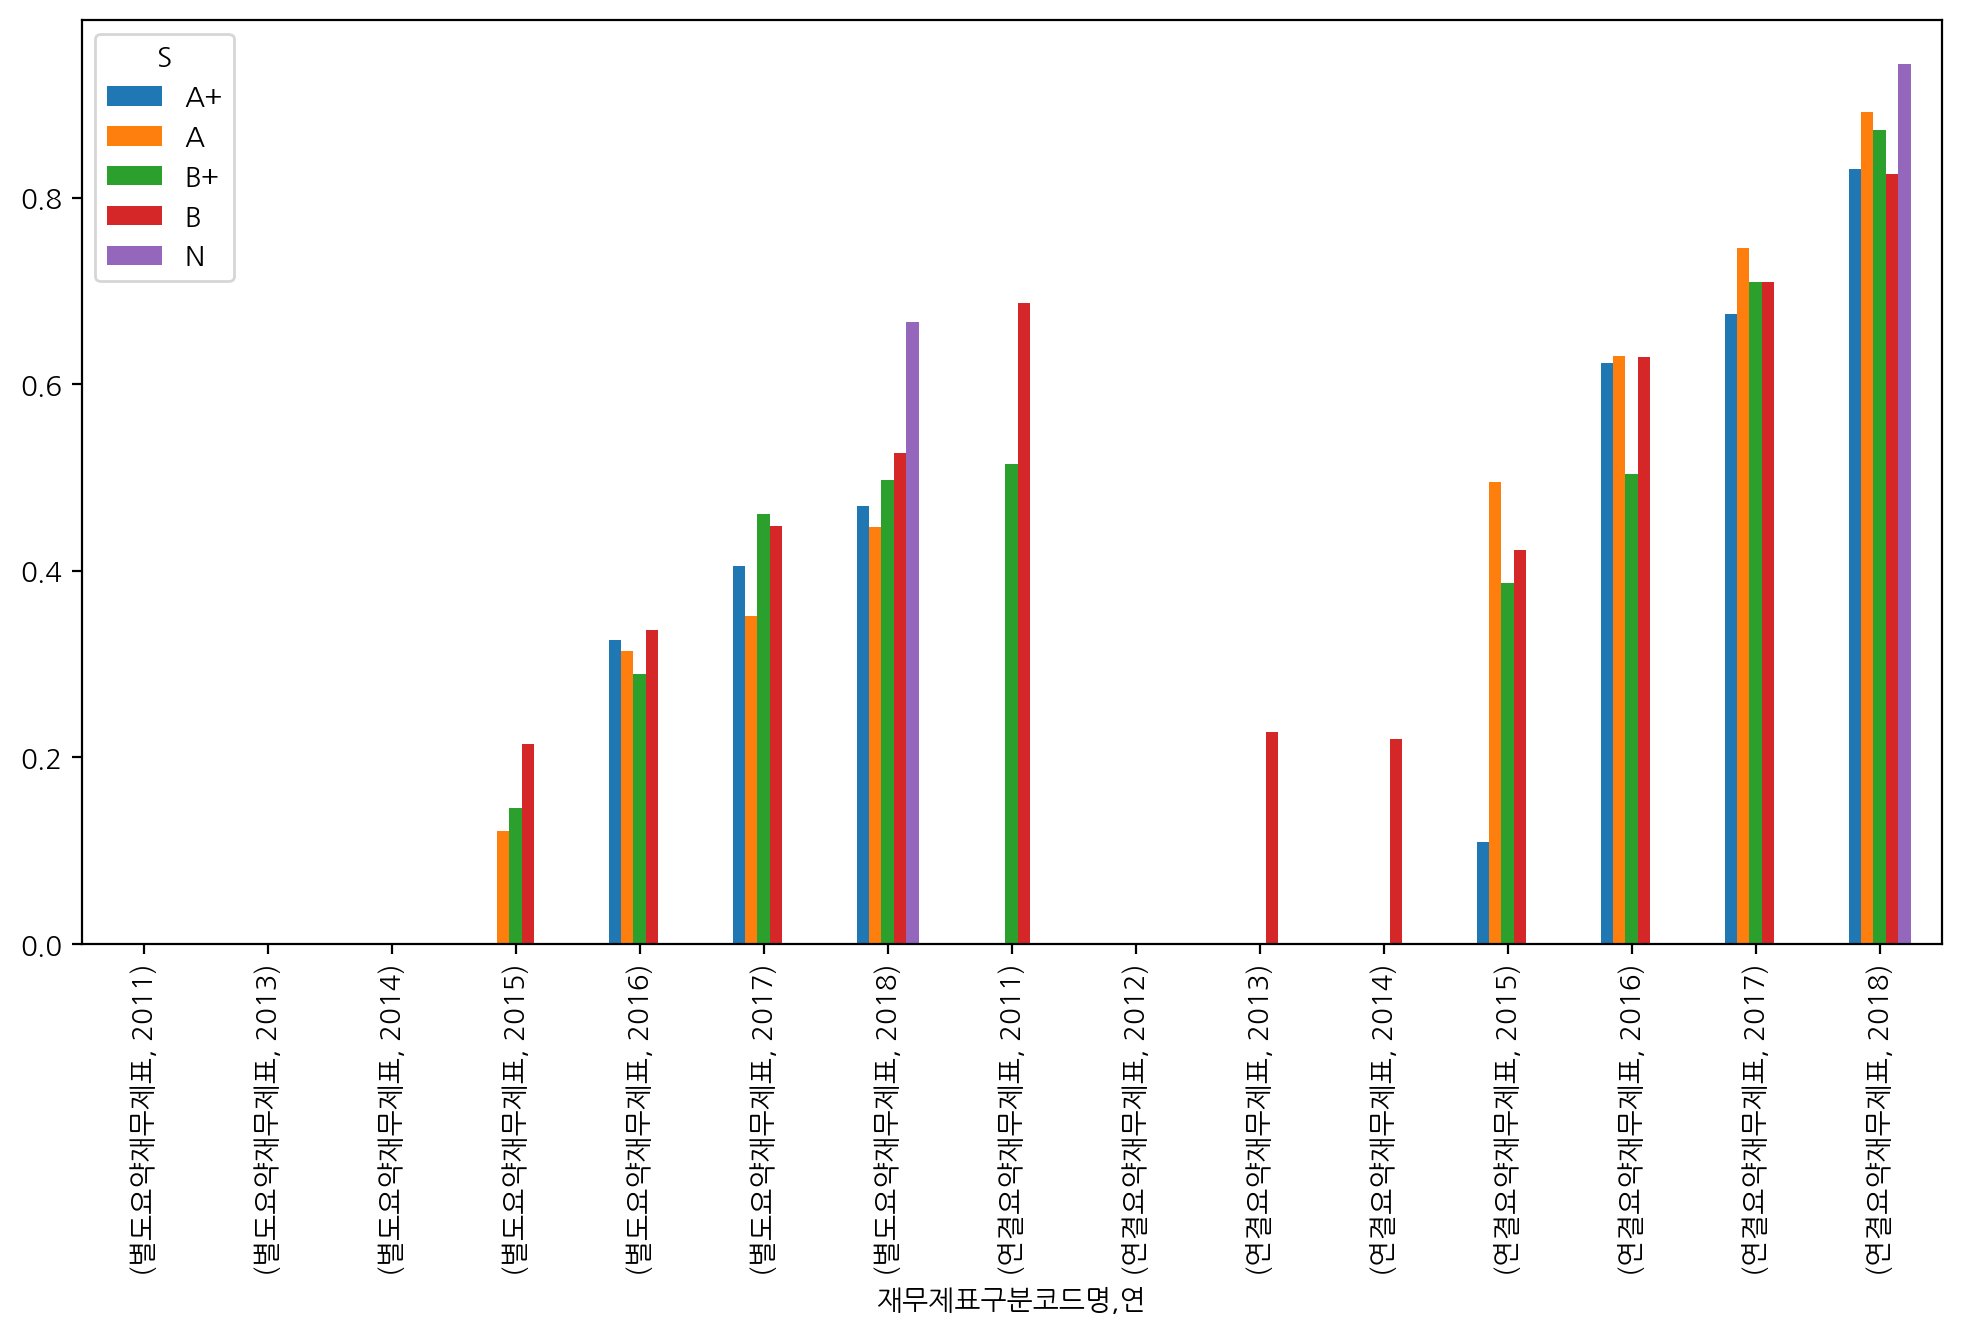

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업총자본금액_mmscl
G


G                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN    NaN 0.0000
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.0000    NaN
          2015 0.0990 0.1271 0.1567 0.2250    NaN
          2016 0.2217 0.2969 0.3269 0.3246    NaN
          2017 0.0000 0.4210 0.4806 0.4252    NaN
          2018 0.4025 0.5030 0.5379 0.4826 0.6663
연결요약재무제표  2011    NaN    NaN 0.5146 0.5311 1.0000
          2012    NaN    NaN 0.0000 0.0000    NaN
          2013    NaN    NaN    NaN 0.2269    NaN
          2014    NaN    NaN 0.1104 0.5483    NaN
          2015 0.3058 0.4271 0.3757 0.4404    NaN
          2016 0.4927 0.5693 0.5612 0.6147    NaN
          2017 0.4875 0.6633 0.7376 0.7131    NaN
          2018 0.5366 0.9046 0.8325 0.8465 0.9435

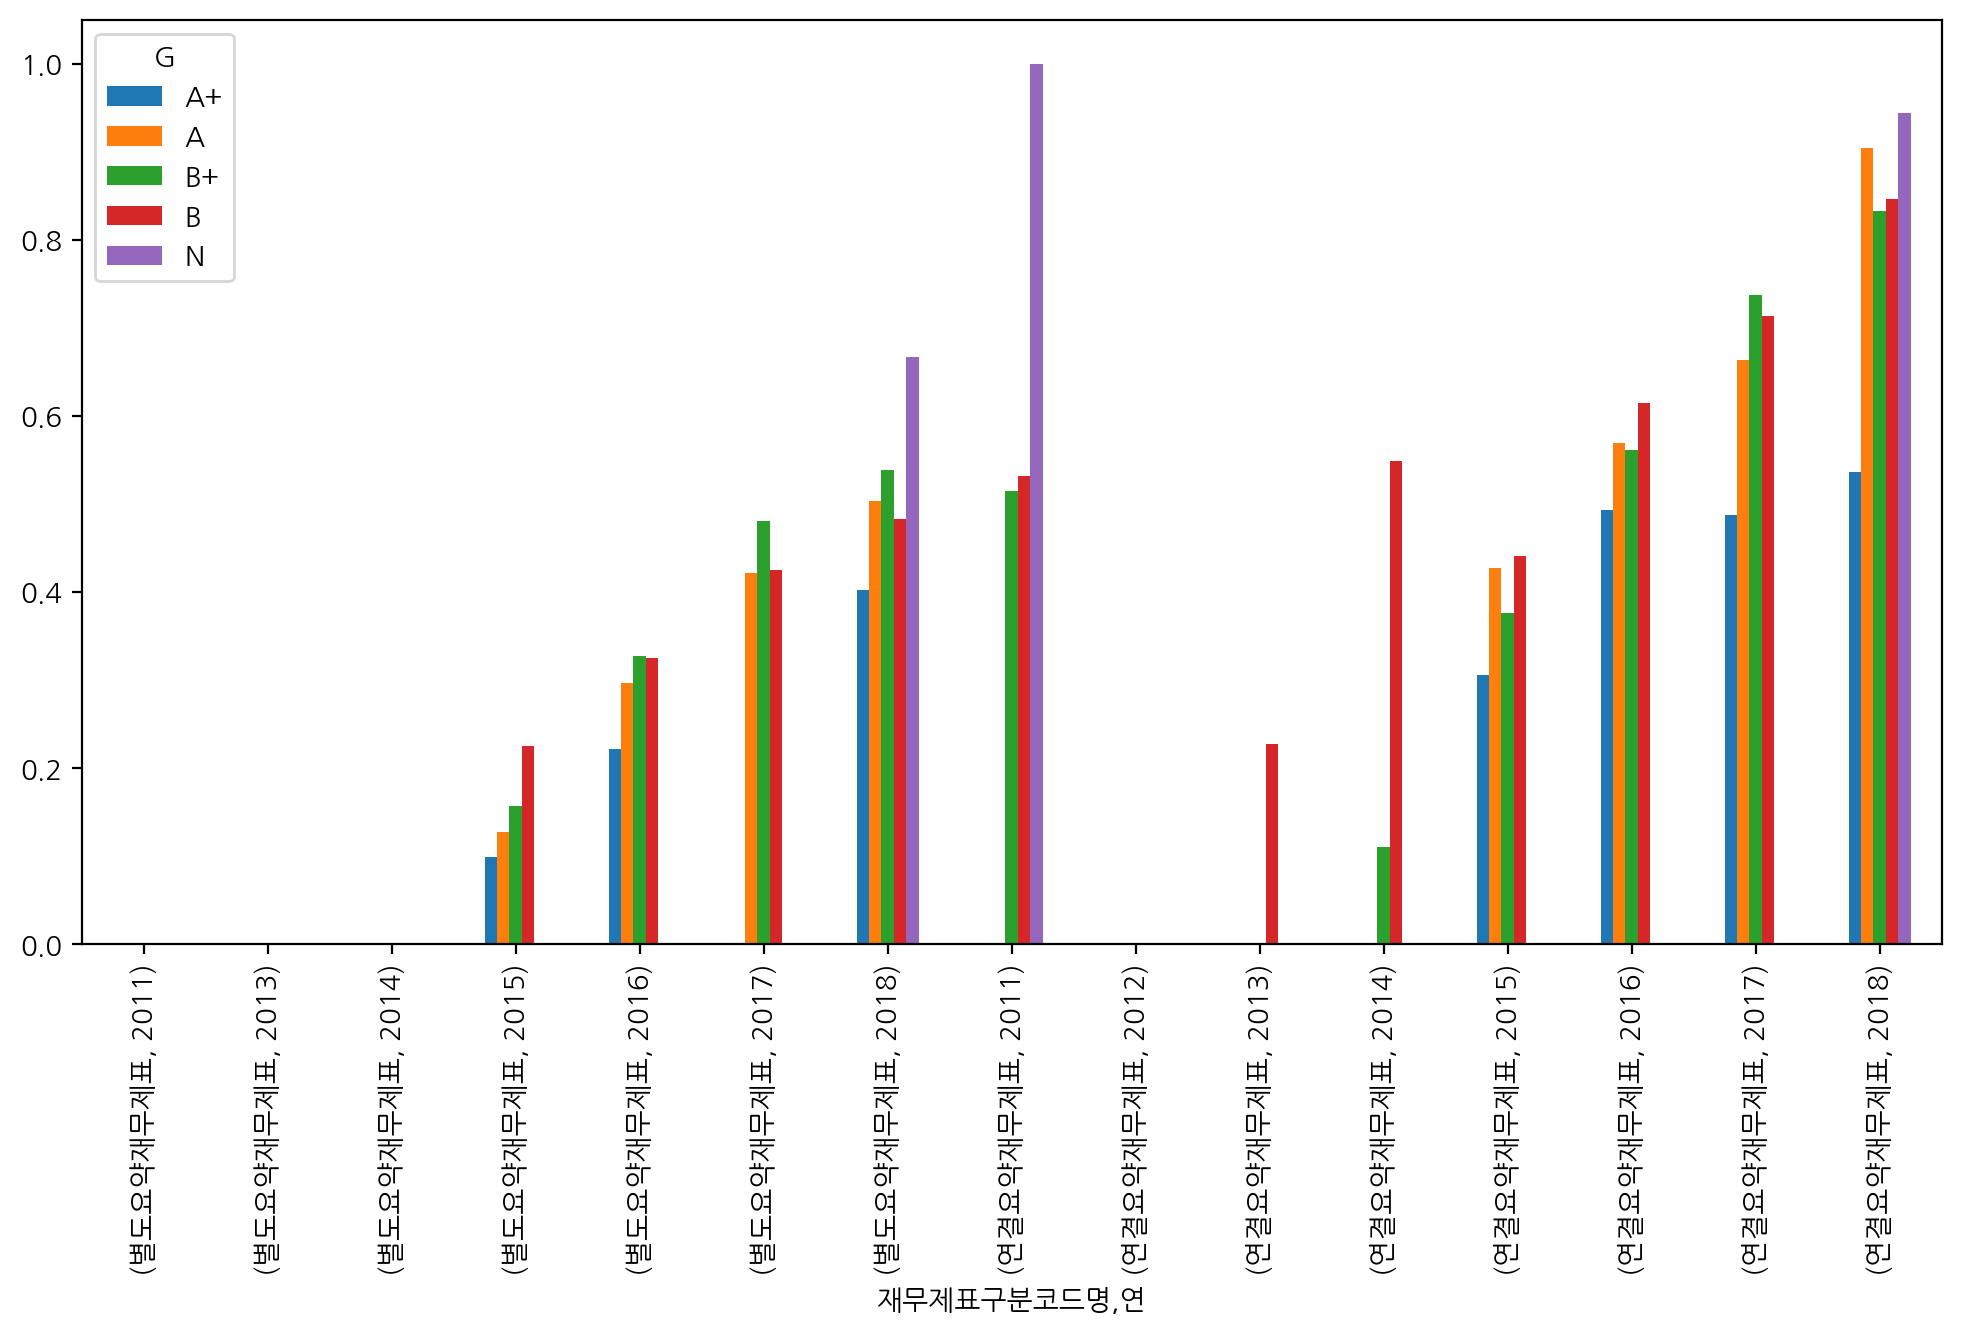

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업자본금액_mmscl
ESG종합


ESG종합              A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.0007    NaN
          2013    NaN    NaN    NaN 1.0000    NaN
          2014    NaN    NaN    NaN 1.0000    NaN
          2015    NaN 0.2450 0.0341 0.1112    NaN
          2016 0.6667 0.1538 0.1361 0.1271    NaN
          2017 1.0000 0.9242 0.6053 0.7535    NaN
          2018 1.0000 0.7597 0.7674 0.7643 0.9412
연결요약재무제표  2011    NaN    NaN 1.0000 0.6551    NaN
          2012    NaN    NaN 1.0000 0.9136    NaN
          2013    NaN    NaN    NaN 1.0000    NaN
          2014    NaN    NaN 0.9810 0.6667    NaN
          2015    NaN 0.0000 0.0981 0.1067    NaN
          2016 0.3333 0.0000 0.1073 0.1304    NaN
          2017 1.0000 0.9242 0.6158 0.7173    NaN
          2018 1.0000 0.7943 0.7561 0.7347 0.9412

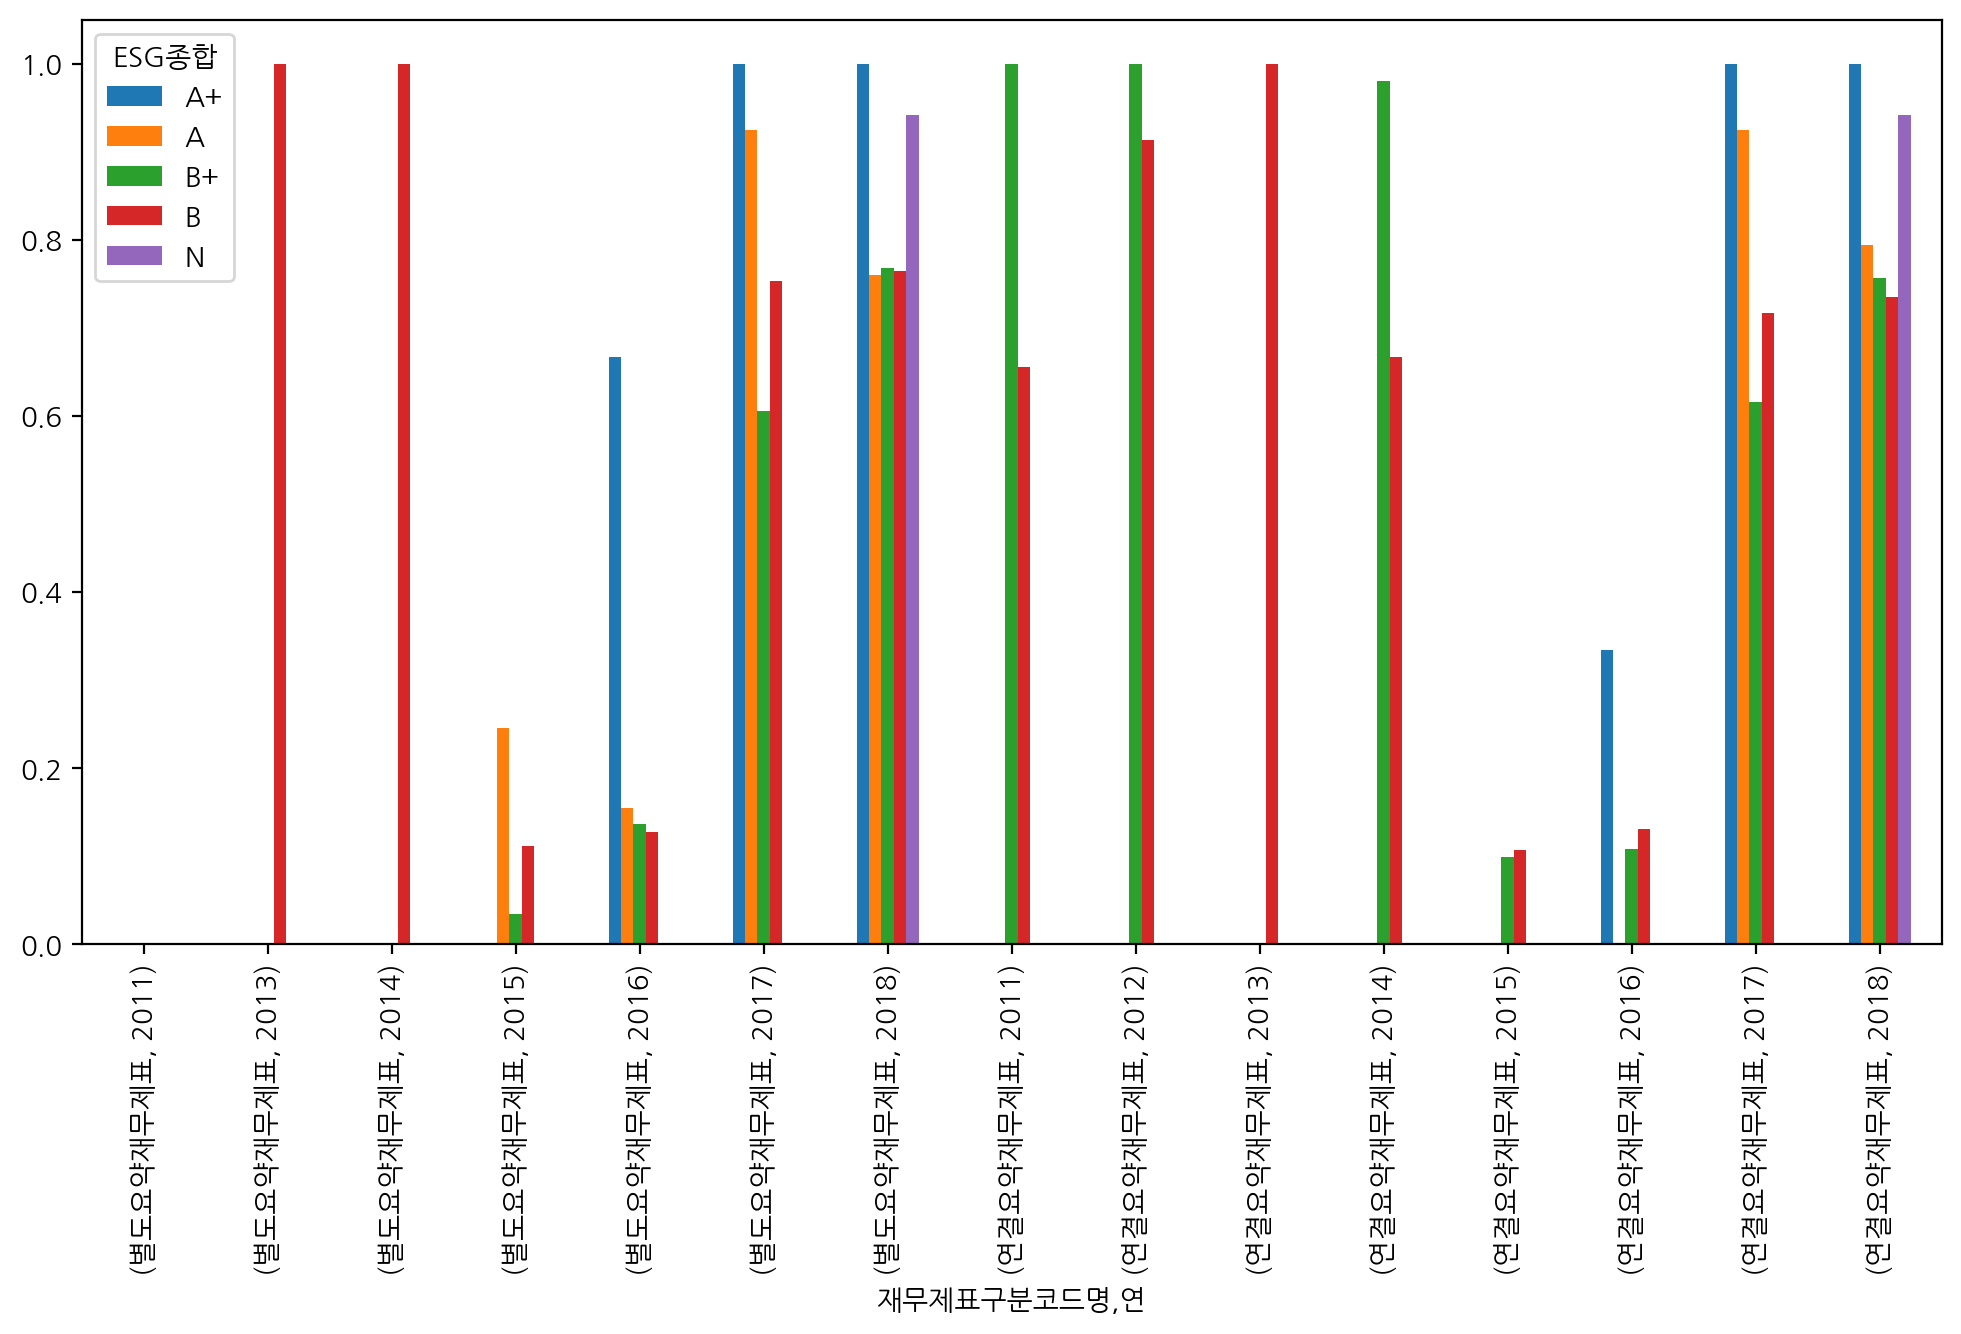

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업자본금액_mmscl
E


E                  A+      A     B+      B      C      D
재무제표구분코드명 연                                             
별도요약재무제표  2011    NaN    NaN    NaN 0.0007    NaN    NaN
          2013    NaN    NaN    NaN 1.0000    NaN    NaN
          2014    NaN    NaN    NaN    NaN 1.0000    NaN
          2015    NaN 0.0909 0.0699 0.0863 0.1578 0.0000
          2016 0.5000 0.1111 0.1319 0.1464 0.0859 0.2872
          2017 1.0000 0.9969 0.6486 0.7327 0.7802 0.7476
          2018 1.0000 0.7864 0.7422 0.7813 0.7333 1.0000
연결요약재무제표  2011    NaN    NaN    NaN 0.6551 1.0000    NaN
          2012    NaN    NaN    NaN 0.9136 1.0000    NaN
          2013    NaN    NaN    NaN    NaN 1.0000    NaN
          2014    NaN    NaN 0.9810    NaN 0.6667    NaN
          2015    NaN 0.0000 0.1020 0.0833 0.1154 0.2500
          2016 0.2500 0.0000 0.1352 0.1276 0.0917 0.1726
          2017 1.0000 0.9897 0.6279 0.7250 0.7288 0.7476
          2018 1.0000 0.8545 0.7190 0.7548 0.7241 1.0000

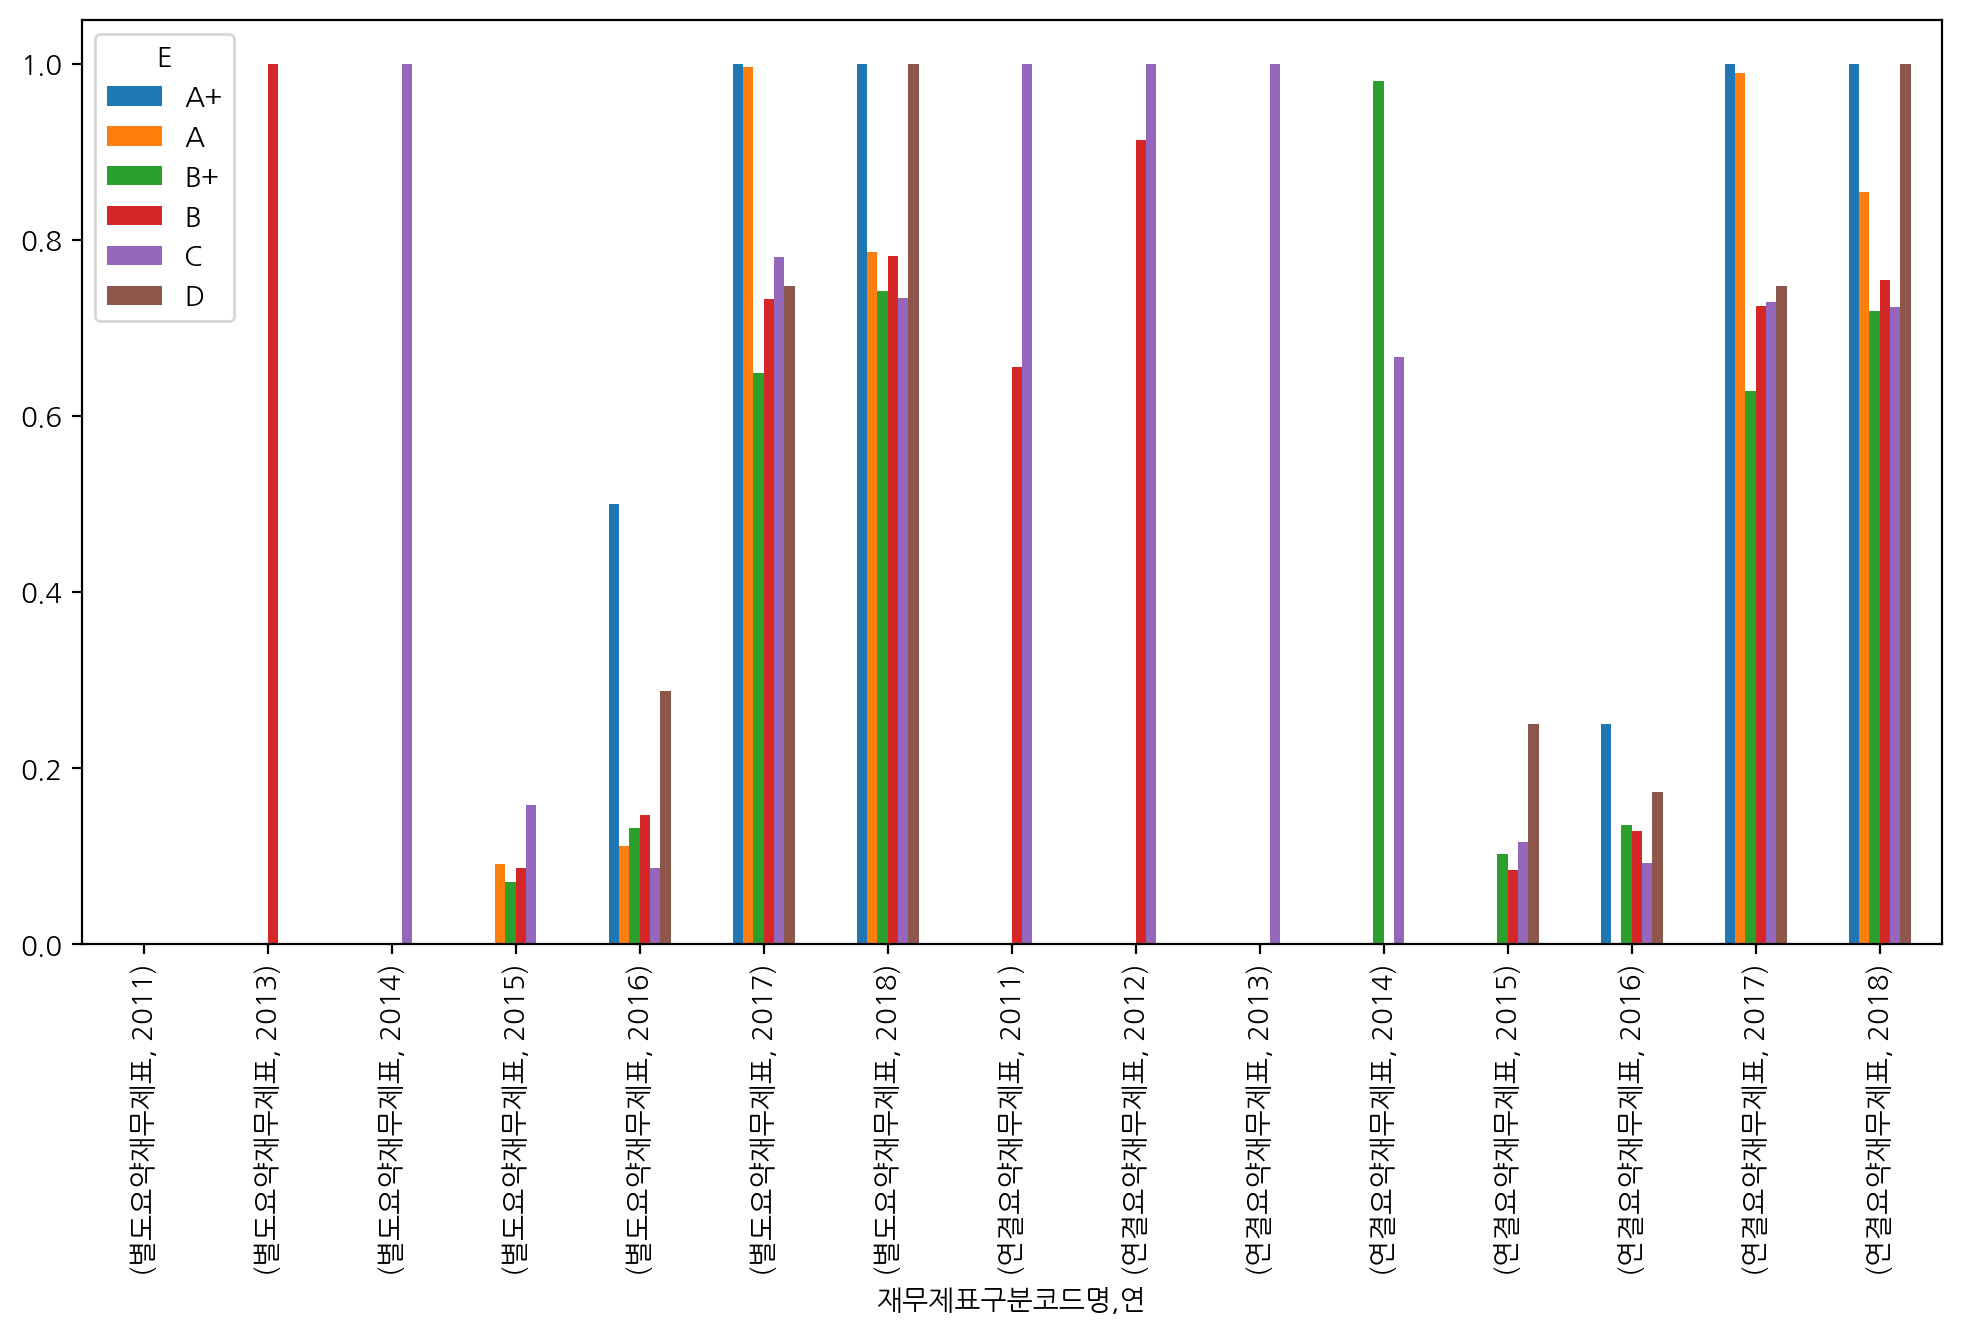

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업자본금액_mmscl
S


S                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 0.0007    NaN
          2013    NaN    NaN    NaN 1.0000    NaN
          2014    NaN    NaN    NaN 1.0000    NaN
          2015 0.3333 0.1990 0.0810 0.0939    NaN
          2016 0.3333 0.1818 0.1304 0.1120    NaN
          2017 0.8820 0.8692 0.6185 0.7424    NaN
          2018 0.8696 0.7369 0.7451 0.7656 0.9412
연결요약재무제표  2011    NaN    NaN 1.0000 0.6551    NaN
          2012    NaN    NaN 1.0000 0.9136    NaN
          2013    NaN    NaN    NaN 1.0000    NaN
          2014    NaN    NaN    NaN 0.7452    NaN
          2015 0.0000 0.0000 0.1218 0.1042    NaN
          2016 0.0667 0.1619 0.0828 0.1407    NaN
          2017 0.8746 0.8692 0.6452 0.6940    NaN
          2018 0.9091 0.7618 0.7200 0.7299 0.9412

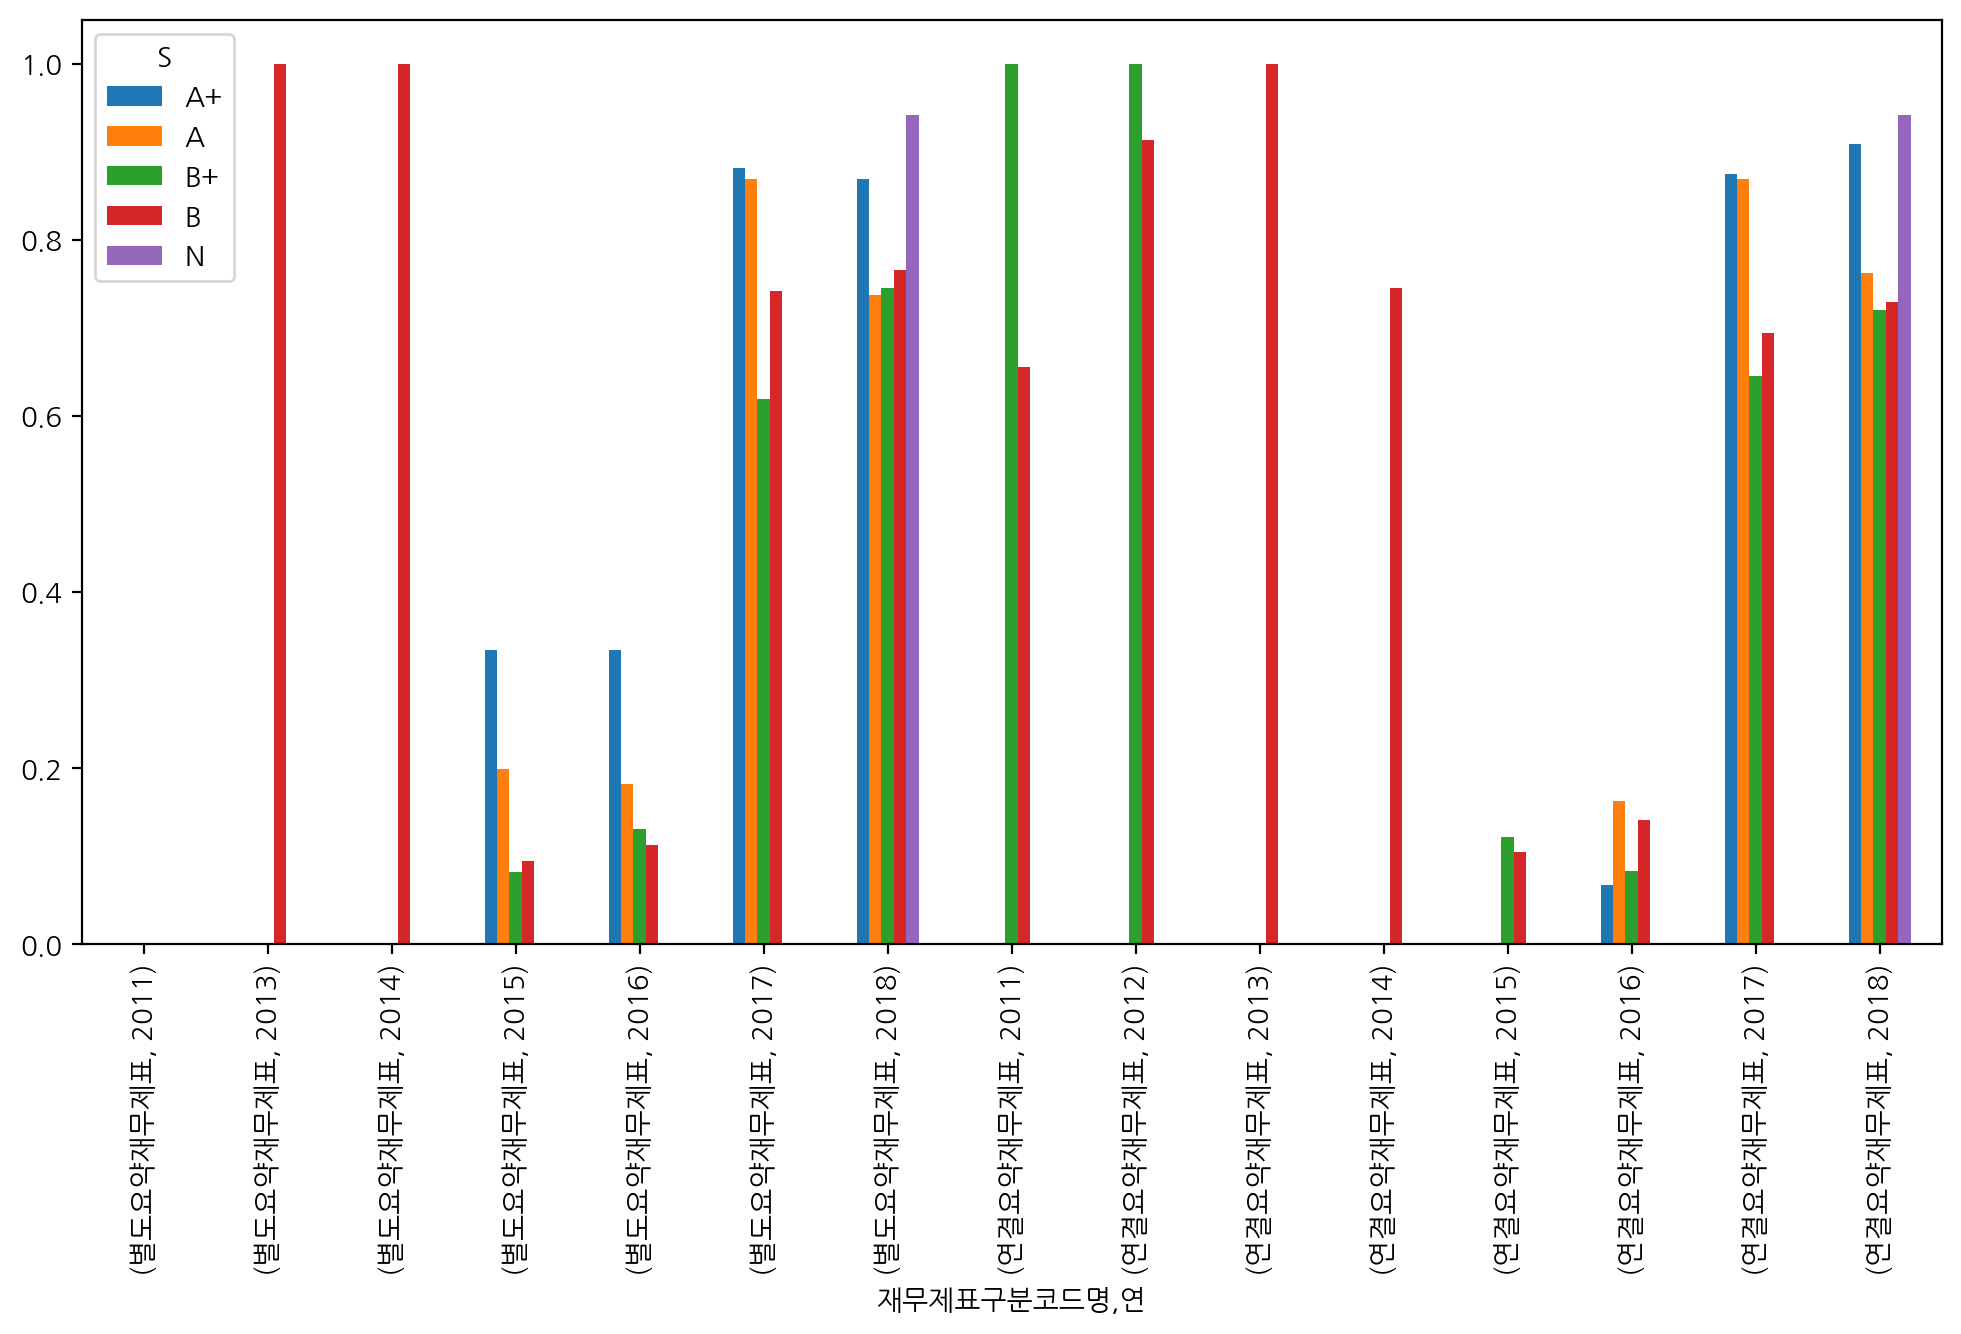

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

기업자본금액_mmscl
G


G                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN    NaN 0.0007
          2013    NaN    NaN    NaN 1.0000    NaN
          2014    NaN    NaN    NaN 1.0000    NaN
          2015 0.3333 0.1710 0.1092 0.0758    NaN
          2016 1.0000 0.2136 0.0953 0.1274    NaN
          2017 1.0000 0.8427 0.6860 0.7279    NaN
          2018 1.0000 0.8694 0.7547 0.7450 0.9412
연결요약재무제표  2011    NaN    NaN 1.0000 0.8645 0.2362
          2012    NaN    NaN 1.0000 0.9136    NaN
          2013    NaN    NaN    NaN 1.0000    NaN
          2014    NaN    NaN 0.6603 1.0000    NaN
          2015 0.0000 0.0870 0.1444 0.0721    NaN
          2016 0.0000 0.1435 0.1451 0.0963    NaN
          2017 1.0000 0.8373 0.6881 0.6925    NaN
          2018 1.0000 0.8644 0.7400 0.7243 0.9412

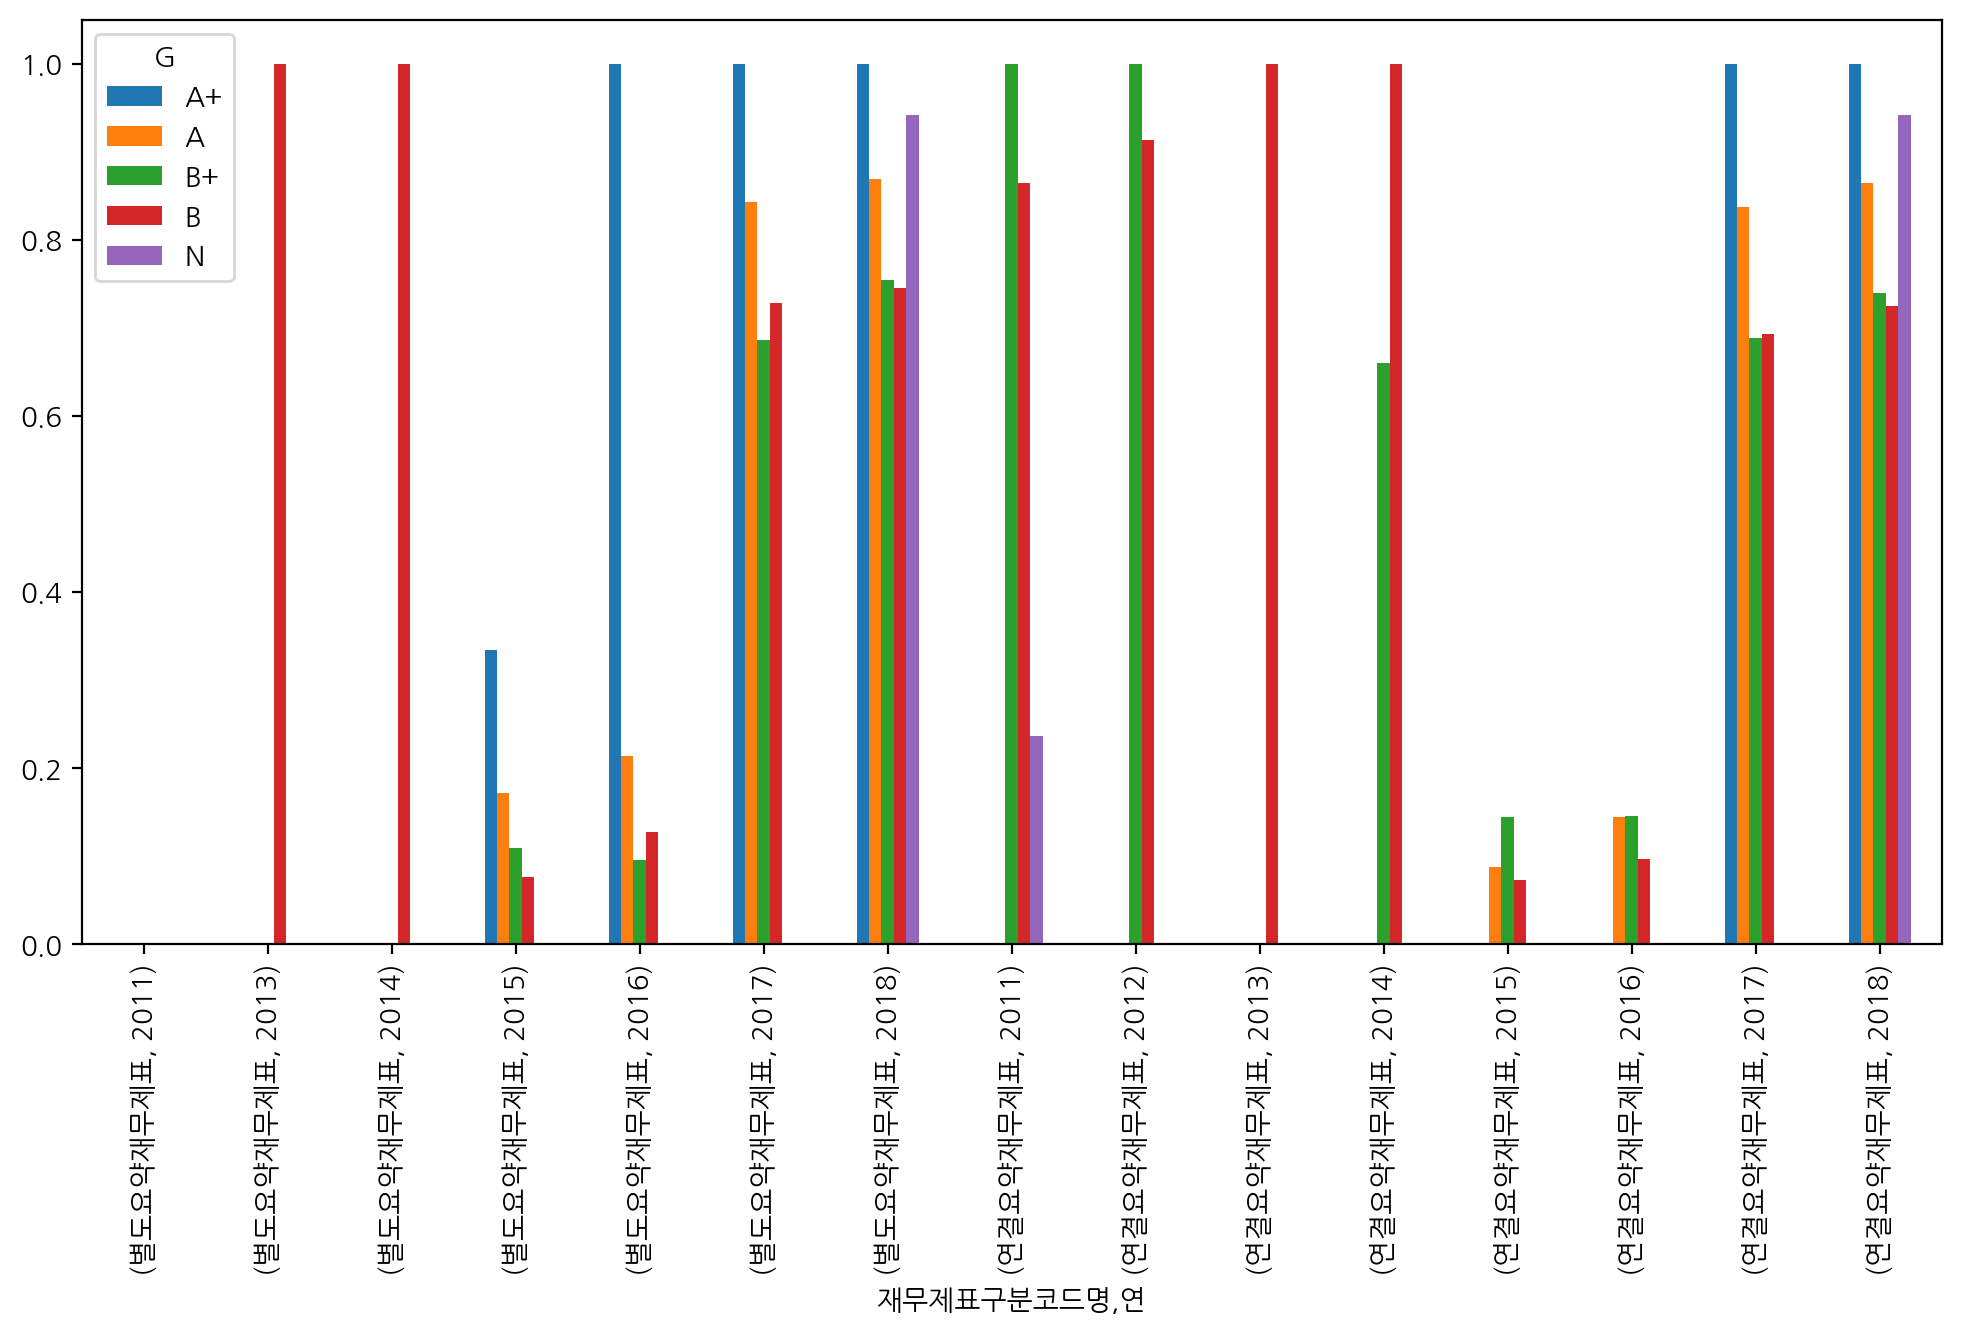

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

재무제표부채비율_mmscl
ESG종합


ESG종합              A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 1.0000    NaN
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.2874    NaN
          2015    NaN 0.1300 0.4258 0.3326    NaN
          2016 0.2347 0.3722 0.3625 0.2687    NaN
          2017 0.2051 0.3643 0.2560 0.2345    NaN
          2018 0.3024 0.2674 0.2363 0.2429 0.0000
연결요약재무제표  2011    NaN    NaN 0.3789 0.8936    NaN
          2012    NaN    NaN 1.0000 0.9290    NaN
          2013    NaN    NaN    NaN 0.6765    NaN
          2014    NaN    NaN 0.0000 0.4926    NaN
          2015    NaN 0.6245 0.7529 0.7241    NaN
          2016 0.6418 0.7086 0.6494 0.6309    NaN
          2017 0.7922 0.6222 0.5773 0.6219    NaN
          2018 0.7123 0.6995 0.5117 0.5894 0.3940

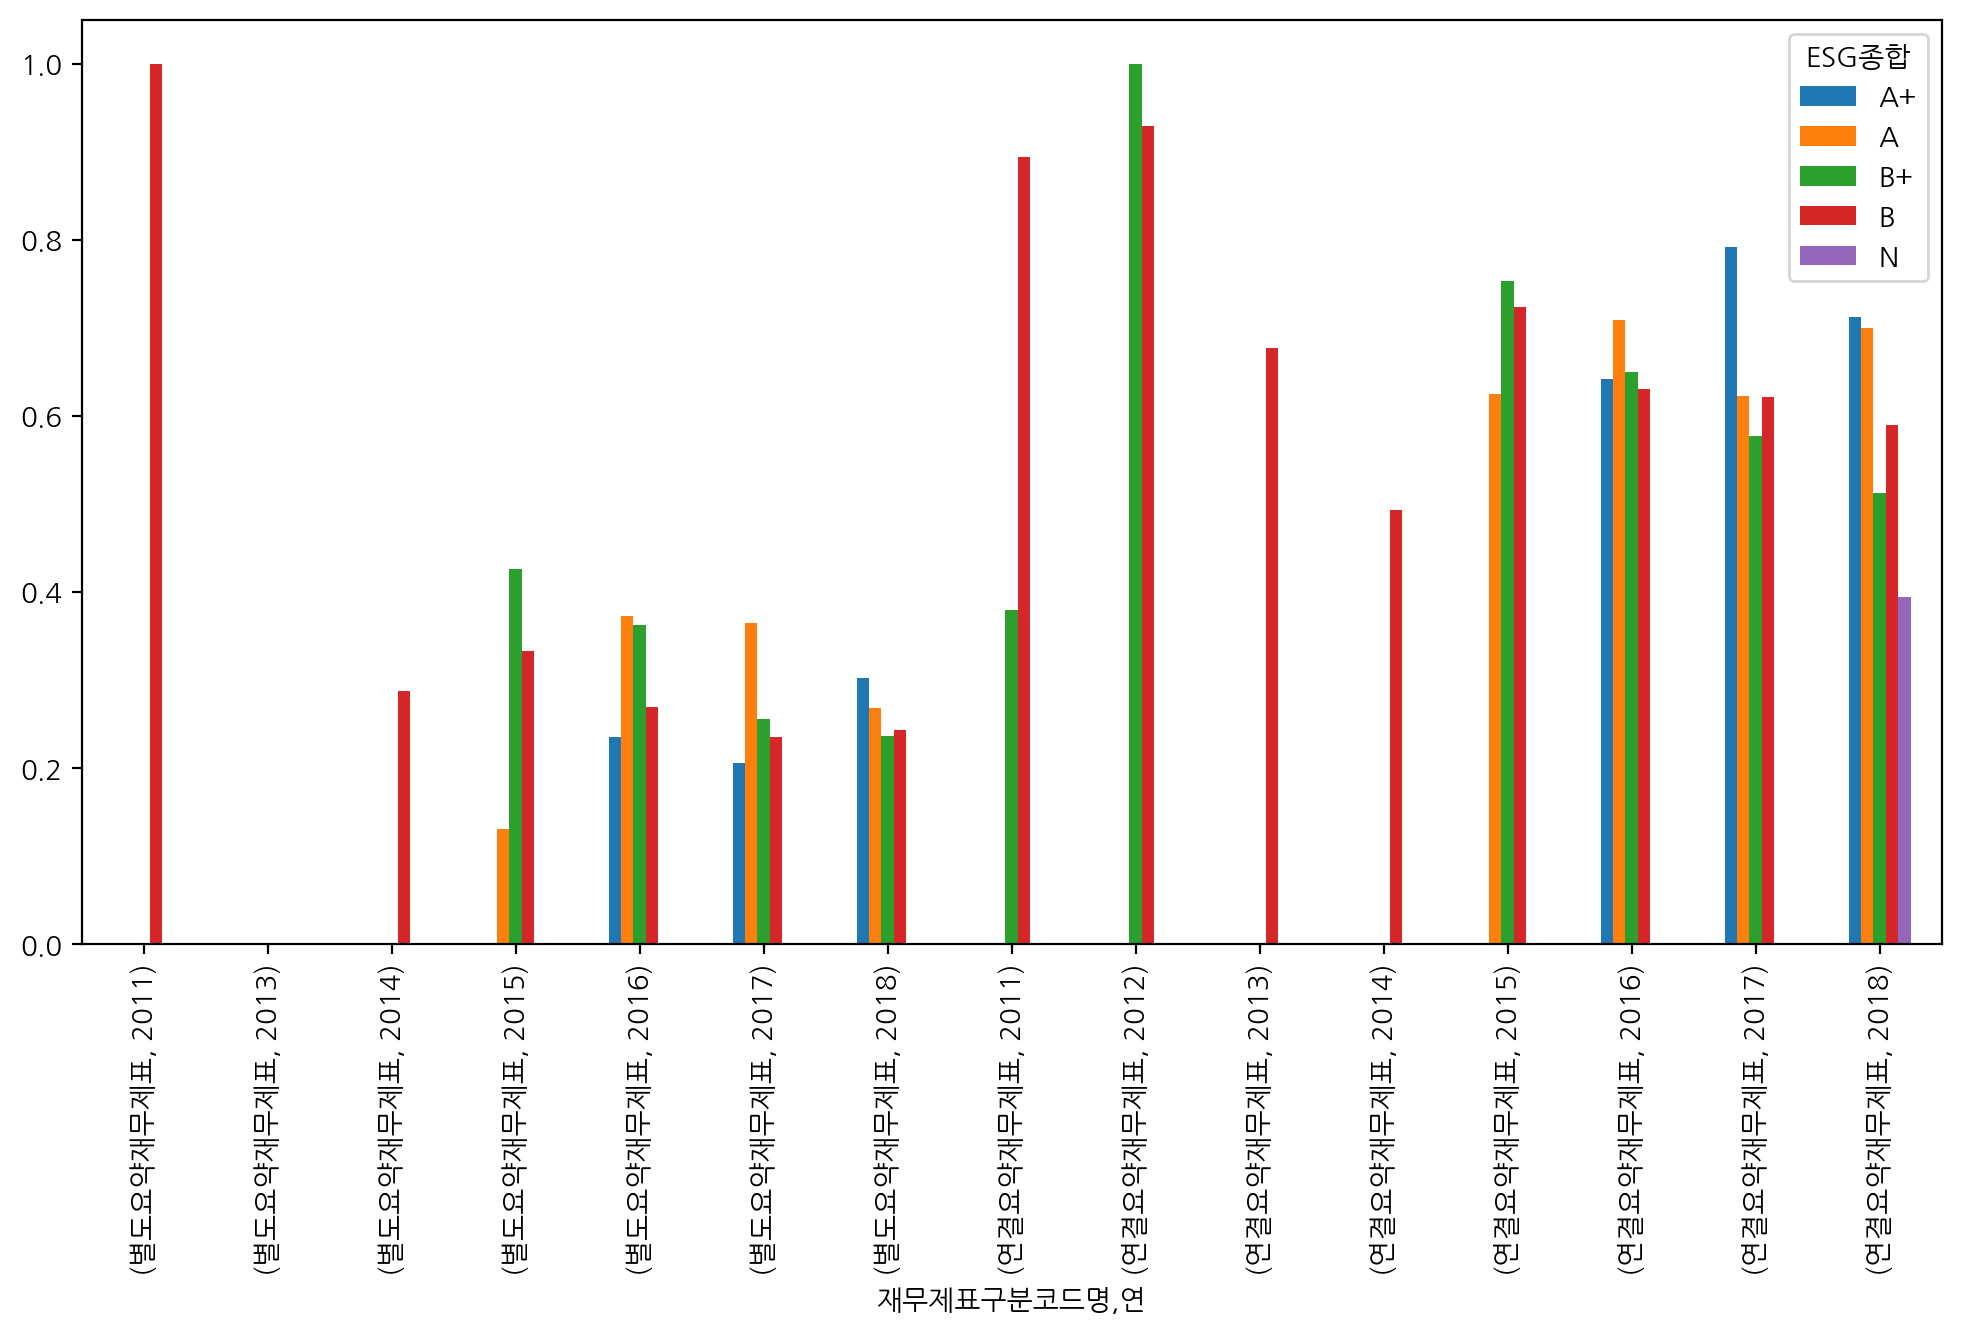

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

재무제표부채비율_mmscl
E


E                  A+      A     B+      B      C      D
재무제표구분코드명 연                                             
별도요약재무제표  2011    NaN    NaN    NaN 1.0000    NaN    NaN
          2013    NaN    NaN    NaN 0.0000    NaN    NaN
          2014    NaN    NaN    NaN    NaN 0.2874    NaN
          2015    NaN 0.1160 0.3687 0.3430 0.3424 0.5564
          2016 0.1760 0.2703 0.2693 0.3490 0.2507 0.3180
          2017 0.2552 0.1568 0.2722 0.2898 0.1811 0.1400
          2018 0.4031 0.1849 0.2587 0.2239 0.2638 0.2277
연결요약재무제표  2011    NaN    NaN    NaN 0.6865 1.0000    NaN
          2012    NaN    NaN    NaN 0.9290 1.0000    NaN
          2013    NaN    NaN    NaN    NaN 0.6765    NaN
          2014    NaN    NaN 0.0000    NaN 0.4926    NaN
          2015    NaN 0.5452 0.7705 0.7389 0.7239 0.5450
          2016 0.7025 0.6780 0.6037 0.6435 0.6773 0.5142
          2017 0.6884 0.6128 0.6119 0.6378 0.5538 0.6238
          2018 0.8936 0.7912 0.5637 0.5358 0.6259 0.5684

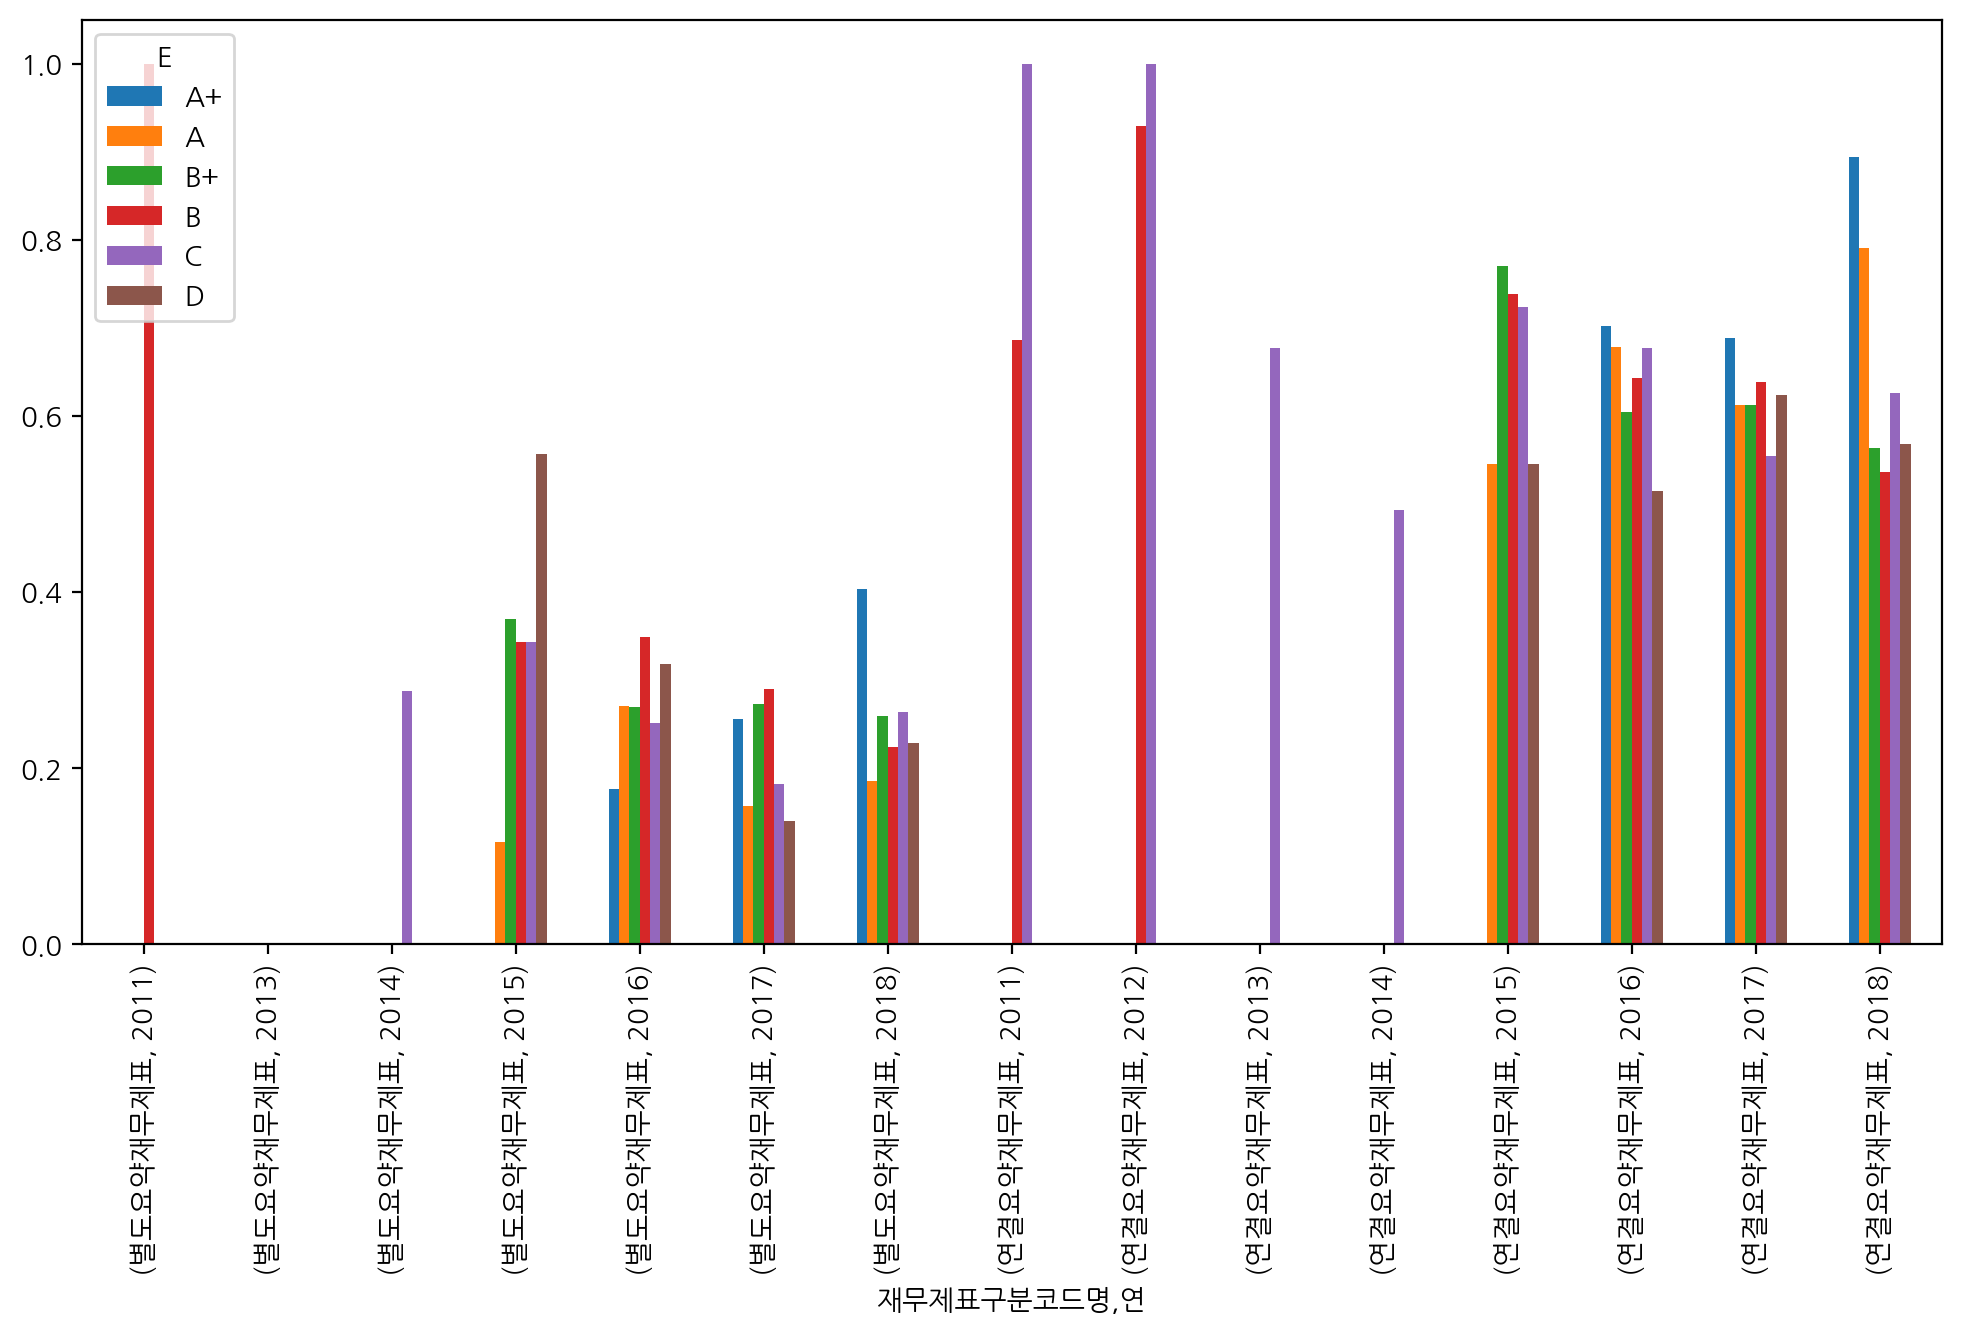

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

재무제표부채비율_mmscl
S


S                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN 1.0000    NaN
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.2874    NaN
          2015 0.4074 0.1518 0.4368 0.3277    NaN
          2016 0.3100 0.3010 0.3998 0.2408    NaN
          2017 0.3639 0.2538 0.2630 0.2253    NaN
          2018 0.2871 0.2761 0.1893 0.2616 0.0000
연결요약재무제표  2011    NaN    NaN 0.3789 0.8936    NaN
          2012    NaN    NaN 1.0000 0.9290    NaN
          2013    NaN    NaN    NaN 0.6765    NaN
          2014    NaN    NaN    NaN 0.3694    NaN
          2015 0.4953 0.6260 0.7114 0.7482    NaN
          2016 0.6307 0.6695 0.6298 0.6473    NaN
          2017 0.6120 0.6329 0.6010 0.6171    NaN
          2018 0.7032 0.5901 0.5046 0.6087 0.3940

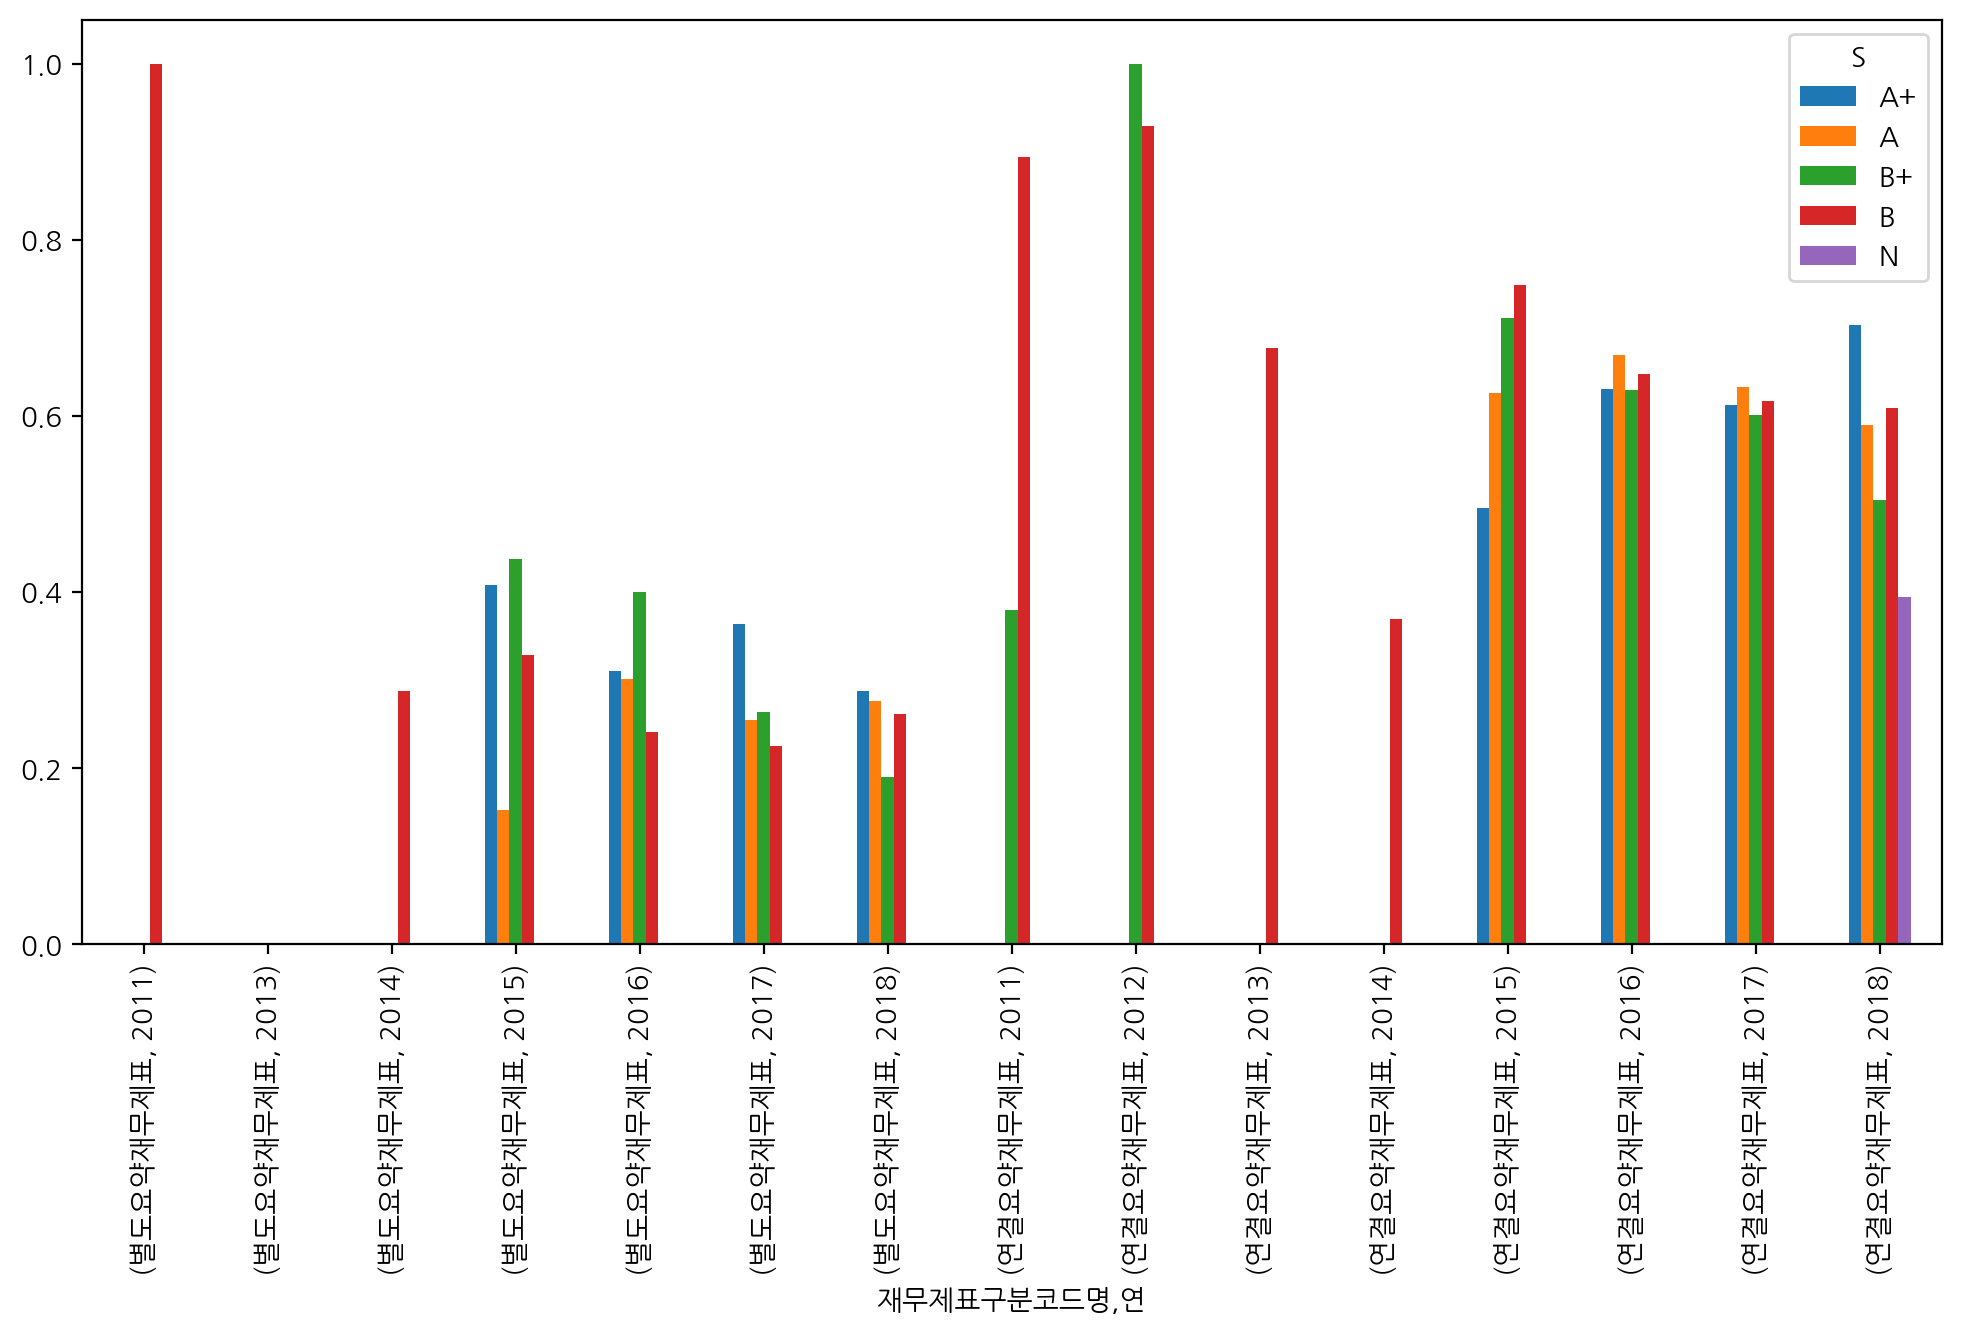

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

재무제표부채비율_mmscl
G


G                  A+      A     B+      B      N
재무제표구분코드명 연                                      
별도요약재무제표  2011    NaN    NaN    NaN    NaN 1.0000
          2013    NaN    NaN    NaN 0.0000    NaN
          2014    NaN    NaN    NaN 0.2874    NaN
          2015 0.1608 0.3172 0.4230 0.2980    NaN
          2016 0.0000 0.3921 0.2822 0.2788    NaN
          2017 0.1047 0.3332 0.2446 0.2304    NaN
          2018 0.4197 0.2561 0.2525 0.2355 0.0000
연결요약재무제표  2011    NaN    NaN 0.3789 1.0000 0.6807
          2012    NaN    NaN 1.0000 0.9290    NaN
          2013    NaN    NaN    NaN 0.6765    NaN
          2014    NaN    NaN 0.3333 0.4778    NaN
          2015 0.5806 0.6579 0.7956 0.7028    NaN
          2016 0.9497 0.6599 0.6250 0.6399    NaN
          2017 1.0000 0.5811 0.5788 0.6395    NaN
          2018 0.5777 0.5919 0.5569 0.6043 0.3940

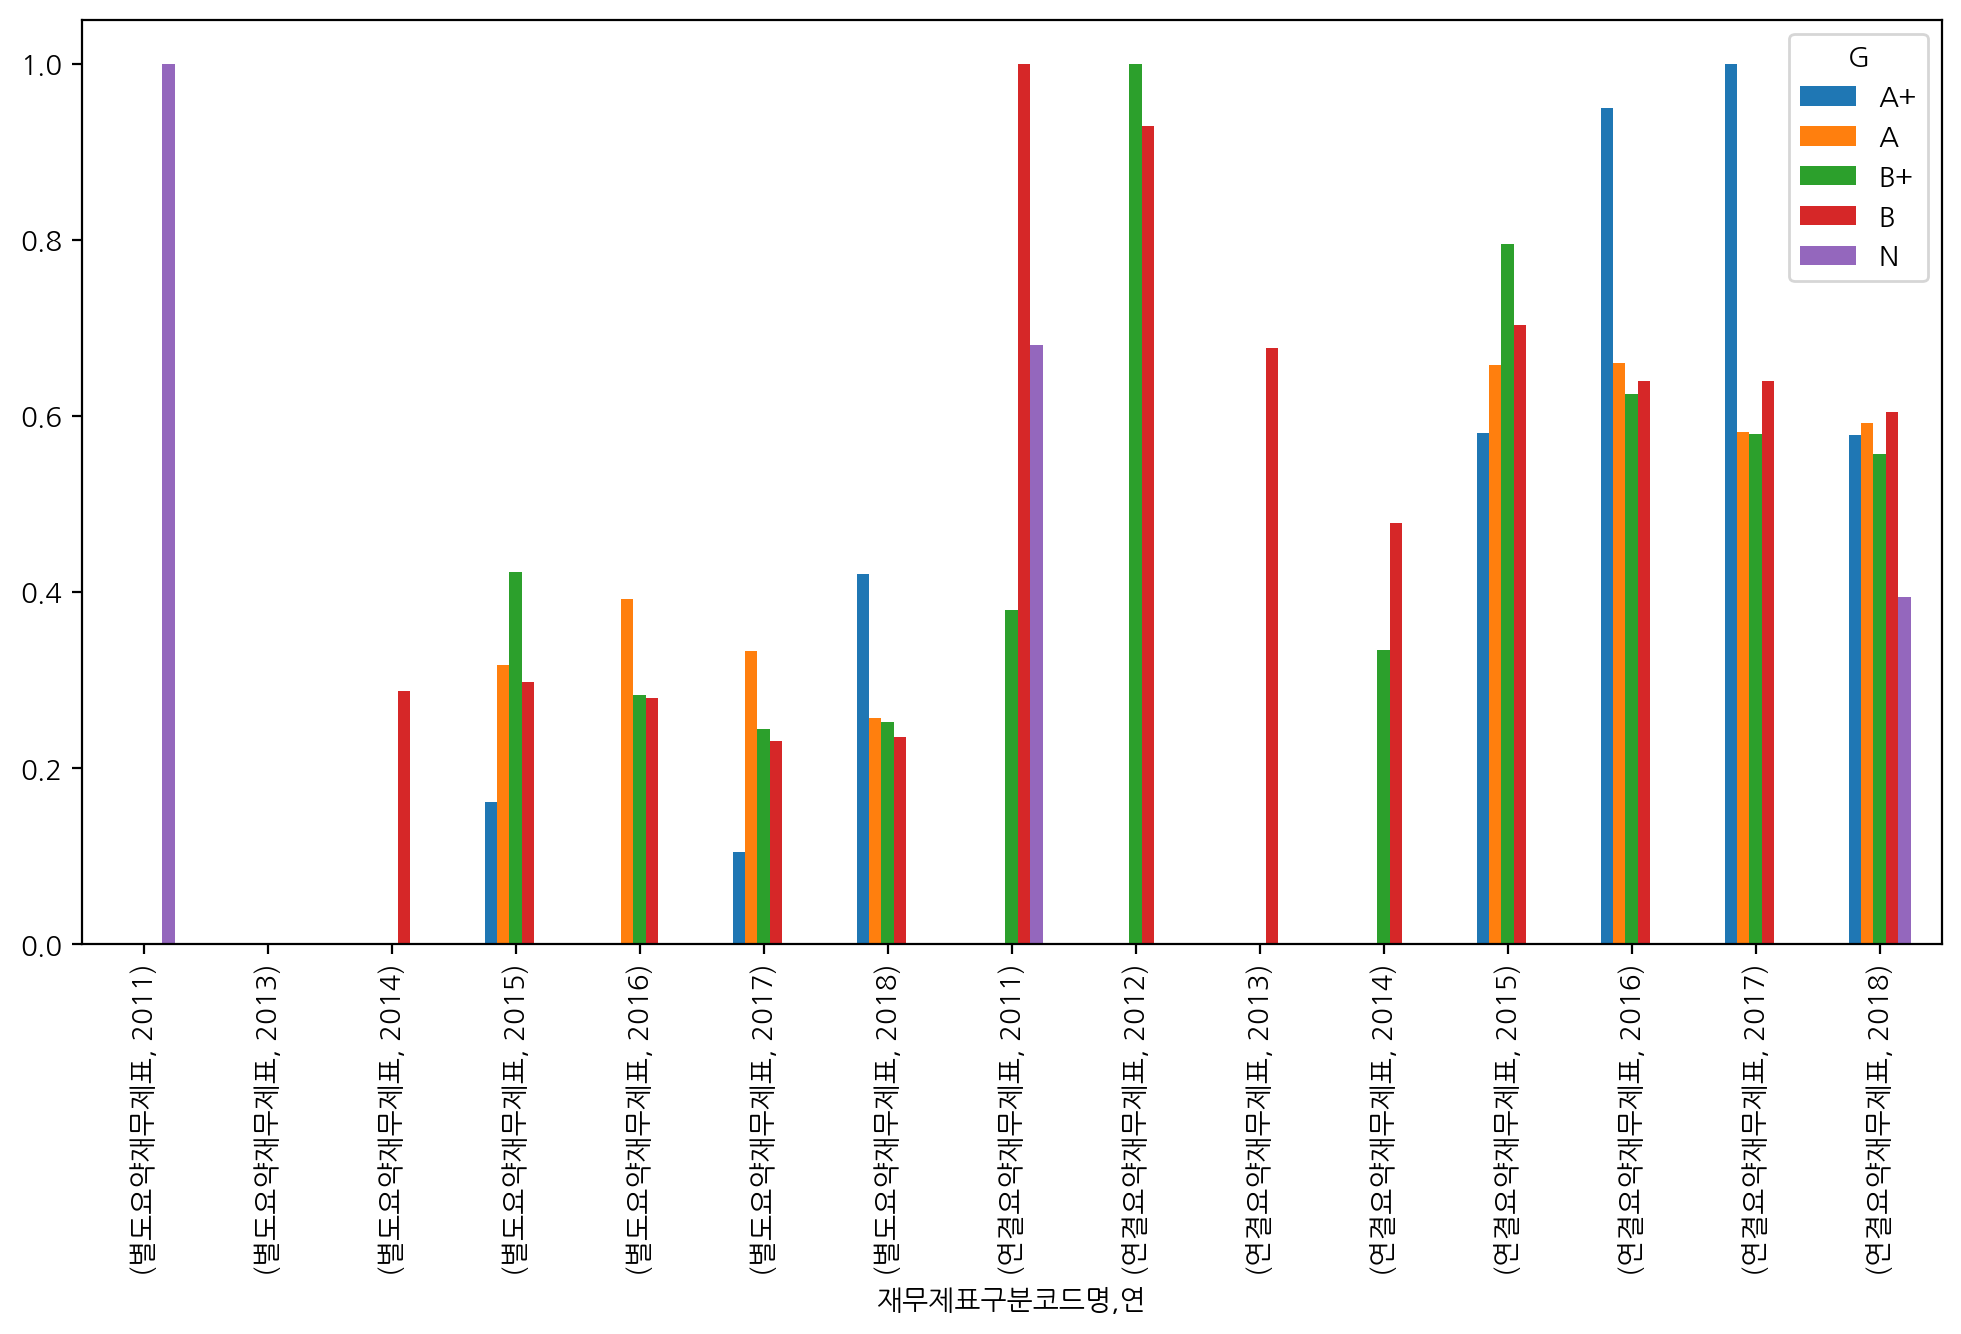

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 


In [91]:
finaStat = [
    "기업매출금액_mmscl",
    "기업영업이익_mmscl",
    "포괄손익계산금액_mmscl",
    "기업당기순이익_mmscl",
    "기업총자산금액_mmscl",
    "기업총부채금액_mmscl",
    "기업총자본금액_mmscl",
    "기업자본금액_mmscl",
    "재무제표부채비율_mmscl",
]

for f in finaStat:
    for i in list_esg:
        print()
        print(f)
        print(i)

        d = df.pivot_table(f, ["재무제표구분코드명", "연"], [i], aggfunc="mean")
        display(d)

        d.plot(kind="bar", figsize=(12, 6))
        plt.show()
        print("---------- " * 8)